# s1_get_skeletons_from_training_imgs.py

In [1]:
#!/usr/bin/env python
# coding: utf-8

'''
Read training images based on `valid_images.txt` and then detect skeletons.
    
In each image, there should be only 1 person performing one type of action.
Each image is named as 00001.jpg, 00002.jpg, ...

An example of the content of valid_images.txt is shown below:
    
    jump_03-12-09-18-26-176
    58 680

    jump_03-13-11-27-50-720
    65 393

    kick_03-02-12-36-05-185
    54 62
    75 84

The two indices (such as `56 680` in the first `jump` example)
represents the starting index and ending index of a certain action.

Input:
    SRC_IMAGES_DESCRIPTION_TXT
    SRC_IMAGES_FOLDER
    
Output:
    DST_IMAGES_INFO_TXT
    DST_DETECTED_SKELETONS_FOLDER
    DST_VIZ_IMGS_FOLDER
'''

import cv2
import yaml

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    from utils.lib_openpose import SkeletonDetector
    from utils.lib_tracker import Tracker
    from utils.lib_skeletons_io import ReadValidImagesAndActionTypesByTxt
    import utils.lib_commons as lib_commons


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s1_get_skeletons_from_training_imgs.py"]

IMG_FILENAME_FORMAT = cfg_all["image_filename_format"]
SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]


# Input
if True:
    SRC_IMAGES_DESCRIPTION_TXT = par(cfg["input"]["images_description_txt"])
    SRC_IMAGES_FOLDER = par(cfg["input"]["images_folder"])

# Output
if True:
    # This txt will store image info, such as index, action label, filename, etc.
    # This file is saved but not used.
    DST_IMAGES_INFO_TXT = par(cfg["output"]["images_info_txt"])

    # Each txt will store the skeleton of each image
    DST_DETECTED_SKELETONS_FOLDER = par(
        cfg["output"]["detected_skeletons_folder"])

    # Each image is drawn with the detected skeleton
    DST_VIZ_IMGS_FOLDER = par(cfg["output"]["viz_imgs_folders"])

# Openpose
if True:
    OPENPOSE_MODEL = cfg["openpose"]["model"]
    OPENPOSE_IMG_SIZE = cfg["openpose"]["img_size"]

# -- Functions


class ImageDisplayer(object):
    ''' A simple wrapper of using cv2.imshow to display image '''

    def __init__(self):
        self._window_name = "cv2_display_window"
        cv2.namedWindow(self._window_name)

    def display(self, image, wait_key_ms=1):
        cv2.imshow(self._window_name, image)
        cv2.waitKey(wait_key_ms)

    def __del__(self):
        cv2.destroyWindow(self._window_name)


# -- Main
if __name__ == "__main__":

    # -- Detector
    skeleton_detector = SkeletonDetector(OPENPOSE_MODEL, OPENPOSE_IMG_SIZE)
    multiperson_tracker = Tracker()

    # -- Image reader and displayer
    images_loader = ReadValidImagesAndActionTypesByTxt(
        img_folder=SRC_IMAGES_FOLDER,
        valid_imgs_txt=SRC_IMAGES_DESCRIPTION_TXT,
        img_filename_format=IMG_FILENAME_FORMAT)
    # This file is not used.
    images_loader.save_images_info(filepath=DST_IMAGES_INFO_TXT)
    img_displayer = ImageDisplayer()

    # -- Init output path
    os.makedirs(os.path.dirname(DST_IMAGES_INFO_TXT), exist_ok=True)
    os.makedirs(DST_DETECTED_SKELETONS_FOLDER, exist_ok=True)
    os.makedirs(DST_VIZ_IMGS_FOLDER, exist_ok=True)

    # -- Read images and process
    num_total_images = images_loader.num_images
    for ith_img in range(num_total_images):

        # -- Read image
        img, str_action_label, img_info = images_loader.read_image()

        # -- Detect
        humans = skeleton_detector.detect(img)

        # -- Draw
        img_disp = img.copy()
        skeleton_detector.draw(img_disp, humans)
        img_displayer.display(img_disp, wait_key_ms=1)

        # -- Get skeleton data and save to file
        skeletons, scale_h = skeleton_detector.humans_to_skels_list(humans)
        dict_id2skeleton = multiperson_tracker.track(
            skeletons)  # dict: (int human id) -> (np.array() skeleton)
        skels_to_save = [img_info + skeleton.tolist()
                         for skeleton in dict_id2skeleton.values()]

        # -- Save result

        # Save skeleton data for training
        filename = SKELETON_FILENAME_FORMAT.format(ith_img)
        lib_commons.save_listlist(
            DST_DETECTED_SKELETONS_FOLDER + filename,
            skels_to_save)

        # Save the visualized image for debug
        filename = IMG_FILENAME_FORMAT.format(ith_img)
        cv2.imwrite(
            DST_VIZ_IMGS_FOLDER + filename,
            img_disp)

        print(f"{ith_img}/{num_total_images} th image "
              f"has {len(skeletons)} people in it")

    print("Program ends")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





[2021-05-28 12:53:43,307] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/cmu/graph_opt.pb(default size=656x368)






TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimat



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





[2021-05-28 12:53:44,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:44,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Number of action classes = 2
Number of training images = 1812
Number of training images of each action:
      safe|  841|
    unsafe|  971|
Reading images from txtscript: C:\Users\tirumva2\Realtime-Action-Recognition//data/source_images3/
Reading images information from: C:\Users\tirumva2\Realtime-Action-Recognition//data/source_images3/valid_images.txt
    Num images = 1812



[2021-05-28 12:53:45,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,269] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:53:45,269] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:53:45,270] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-05-28 12:53:45,270] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-05-28 12:53:45,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:45,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


0/1812 th image has 2 people in it


[2021-05-28 12:53:45,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,684] [TfPoseEstimator] [DEBUG] estimate time=0.00903
[2021-05-28 12:53:45,684] [TfPoseEstimator] [DEBUG] estimate time=0.00903
[2021-05-28 12:53:45,685] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-05-28 12:53:45,685] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-05-28 12:53:45,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:45,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1/1812 th image has 1 people in it


[2021-05-28 12:53:45,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:45,993] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:45,993] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:45,994] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 12:53:45,994] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 12:53:46,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:46,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


2/1812 th image has 1 people in it


[2021-05-28 12:53:46,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,307] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:46,307] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:46,309] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:46,309] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:46,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:46,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


3/1812 th image has 1 people in it


[2021-05-28 12:53:46,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,614] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:46,614] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:46,615] [TfPoseEstimator] [INFO] inference image in 0.2762 seconds.
[2021-05-28 12:53:46,615] [TfPoseEstimator] [INFO] inference image in 0.2762 seconds.
[2021-05-28 12:53:46,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:46,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


4/1812 th image has 1 people in it


[2021-05-28 12:53:46,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:46,922] [TfPoseEstimator] [DEBUG] estimate time=0.00215
[2021-05-28 12:53:46,922] [TfPoseEstimator] [DEBUG] estimate time=0.00215
[2021-05-28 12:53:46,923] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 12:53:46,923] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 12:53:46,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:46,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


5/1812 th image has 1 people in it


[2021-05-28 12:53:47,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,237] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:53:47,237] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:53:47,239] [TfPoseEstimator] [INFO] inference image in 0.2862 seconds.
[2021-05-28 12:53:47,239] [TfPoseEstimator] [INFO] inference image in 0.2862 seconds.
[2021-05-28 12:53:47,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:47,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


6/1812 th image has 1 people in it


[2021-05-28 12:53:47,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,553] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:47,553] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:47,554] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:47,554] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:47,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:47,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


7/1812 th image has 1 people in it


[2021-05-28 12:53:47,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:47,870] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:47,870] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:47,871] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:47,871] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 12:53:47,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:47,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


8/1812 th image has 1 people in it


[2021-05-28 12:53:48,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,179] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 12:53:48,179] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 12:53:48,180] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 12:53:48,180] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 12:53:48,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:48,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


9/1812 th image has 1 people in it


[2021-05-28 12:53:48,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,486] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 12:53:48,486] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 12:53:48,487] [TfPoseEstimator] [INFO] inference image in 0.2753 seconds.
[2021-05-28 12:53:48,487] [TfPoseEstimator] [INFO] inference image in 0.2753 seconds.
[2021-05-28 12:53:48,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:48,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


10/1812 th image has 1 people in it


[2021-05-28 12:53:48,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:48,791] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-05-28 12:53:48,791] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-05-28 12:53:48,792] [TfPoseEstimator] [INFO] inference image in 0.2752 seconds.
[2021-05-28 12:53:48,792] [TfPoseEstimator] [INFO] inference image in 0.2752 seconds.
[2021-05-28 12:53:48,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:48,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


11/1812 th image has 1 people in it


[2021-05-28 12:53:49,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,097] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:49,097] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:53:49,098] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 12:53:49,098] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 12:53:49,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:49,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


12/1812 th image has 1 people in it


[2021-05-28 12:53:49,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,403] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:49,403] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:53:49,404] [TfPoseEstimator] [INFO] inference image in 0.2752 seconds.
[2021-05-28 12:53:49,404] [TfPoseEstimator] [INFO] inference image in 0.2752 seconds.
[2021-05-28 12:53:49,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:49,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


13/1812 th image has 1 people in it


[2021-05-28 12:53:49,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:49,715] [TfPoseEstimator] [DEBUG] estimate time=0.01234
[2021-05-28 12:53:49,715] [TfPoseEstimator] [DEBUG] estimate time=0.01234
[2021-05-28 12:53:49,716] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-05-28 12:53:49,716] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-05-28 12:53:49,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:49,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


14/1812 th image has 1 people in it


[2021-05-28 12:53:50,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,021] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 12:53:50,021] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 12:53:50,023] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:53:50,023] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:53:50,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:50,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


15/1812 th image has 1 people in it


[2021-05-28 12:53:50,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,325] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-05-28 12:53:50,325] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-05-28 12:53:50,326] [TfPoseEstimator] [INFO] inference image in 0.2823 seconds.
[2021-05-28 12:53:50,326] [TfPoseEstimator] [INFO] inference image in 0.2823 seconds.
[2021-05-28 12:53:50,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:50,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


16/1812 th image has 1 people in it


[2021-05-28 12:53:50,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,632] [TfPoseEstimator] [DEBUG] estimate time=0.00332
[2021-05-28 12:53:50,632] [TfPoseEstimator] [DEBUG] estimate time=0.00332
[2021-05-28 12:53:50,633] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-05-28 12:53:50,633] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-05-28 12:53:50,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:50,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


17/1812 th image has 1 people in it


[2021-05-28 12:53:50,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:50,944] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:53:50,944] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:53:50,945] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-05-28 12:53:50,945] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-05-28 12:53:50,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:50,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


18/1812 th image has 1 people in it


[2021-05-28 12:53:51,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,262] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-05-28 12:53:51,262] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-05-28 12:53:51,263] [TfPoseEstimator] [INFO] inference image in 0.2879 seconds.
[2021-05-28 12:53:51,263] [TfPoseEstimator] [INFO] inference image in 0.2879 seconds.
[2021-05-28 12:53:51,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:51,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


19/1812 th image has 1 people in it


[2021-05-28 12:53:51,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,571] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 12:53:51,571] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 12:53:51,573] [TfPoseEstimator] [INFO] inference image in 0.2774 seconds.
[2021-05-28 12:53:51,573] [TfPoseEstimator] [INFO] inference image in 0.2774 seconds.
[2021-05-28 12:53:51,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:51,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


20/1812 th image has 1 people in it


[2021-05-28 12:53:51,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:51,879] [TfPoseEstimator] [DEBUG] estimate time=0.01003
[2021-05-28 12:53:51,879] [TfPoseEstimator] [DEBUG] estimate time=0.01003
[2021-05-28 12:53:51,881] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-05-28 12:53:51,881] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-05-28 12:53:51,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:51,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


21/1812 th image has 1 people in it


[2021-05-28 12:53:52,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,186] [TfPoseEstimator] [DEBUG] estimate time=0.00132
[2021-05-28 12:53:52,186] [TfPoseEstimator] [DEBUG] estimate time=0.00132
[2021-05-28 12:53:52,200] [TfPoseEstimator] [INFO] inference image in 0.2894 seconds.
[2021-05-28 12:53:52,200] [TfPoseEstimator] [INFO] inference image in 0.2894 seconds.
[2021-05-28 12:53:52,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:52,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


22/1812 th image has 1 people in it


[2021-05-28 12:53:52,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,502] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-05-28 12:53:52,502] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-05-28 12:53:52,503] [TfPoseEstimator] [INFO] inference image in 0.2728 seconds.
[2021-05-28 12:53:52,503] [TfPoseEstimator] [INFO] inference image in 0.2728 seconds.
[2021-05-28 12:53:52,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:52,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


23/1812 th image has 1 people in it


[2021-05-28 12:53:52,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:52,805] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-05-28 12:53:52,805] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-05-28 12:53:52,806] [TfPoseEstimator] [INFO] inference image in 0.2723 seconds.
[2021-05-28 12:53:52,806] [TfPoseEstimator] [INFO] inference image in 0.2723 seconds.
[2021-05-28 12:53:52,837] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:52,837] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


24/1812 th image has 1 people in it


[2021-05-28 12:53:53,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,109] [TfPoseEstimator] [DEBUG] estimate time=0.00733
[2021-05-28 12:53:53,109] [TfPoseEstimator] [DEBUG] estimate time=0.00733
[2021-05-28 12:53:53,111] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:53:53,111] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:53:53,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:53,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


25/1812 th image has 1 people in it


[2021-05-28 12:53:53,412] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,412] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,414] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-05-28 12:53:53,414] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-05-28 12:53:53,415] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-05-28 12:53:53,415] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-05-28 12:53:53,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:53,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


26/1812 th image has 1 people in it


[2021-05-28 12:53:53,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:53,725] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-05-28 12:53:53,725] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-05-28 12:53:53,726] [TfPoseEstimator] [INFO] inference image in 0.2802 seconds.
[2021-05-28 12:53:53,726] [TfPoseEstimator] [INFO] inference image in 0.2802 seconds.
[2021-05-28 12:53:53,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:53,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


27/1812 th image has 1 people in it


[2021-05-28 12:53:54,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,038] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 12:53:54,038] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 12:53:54,039] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-05-28 12:53:54,039] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-05-28 12:53:54,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:54,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


28/1812 th image has 1 people in it


[2021-05-28 12:53:54,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,362] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-05-28 12:53:54,362] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-05-28 12:53:54,363] [TfPoseEstimator] [INFO] inference image in 0.2913 seconds.
[2021-05-28 12:53:54,363] [TfPoseEstimator] [INFO] inference image in 0.2913 seconds.
[2021-05-28 12:53:54,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:54,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


29/1812 th image has 1 people in it


[2021-05-28 12:53:54,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,677] [TfPoseEstimator] [DEBUG] estimate time=0.00846
[2021-05-28 12:53:54,677] [TfPoseEstimator] [DEBUG] estimate time=0.00846
[2021-05-28 12:53:54,678] [TfPoseEstimator] [INFO] inference image in 0.2829 seconds.
[2021-05-28 12:53:54,678] [TfPoseEstimator] [INFO] inference image in 0.2829 seconds.
[2021-05-28 12:53:54,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:54,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


30/1812 th image has 1 people in it


[2021-05-28 12:53:54,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:54,979] [TfPoseEstimator] [DEBUG] estimate time=0.00387
[2021-05-28 12:53:54,979] [TfPoseEstimator] [DEBUG] estimate time=0.00387
[2021-05-28 12:53:54,980] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 12:53:54,980] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 12:53:55,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:55,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


31/1812 th image has 1 people in it


[2021-05-28 12:53:55,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,285] [TfPoseEstimator] [DEBUG] estimate time=0.00964
[2021-05-28 12:53:55,285] [TfPoseEstimator] [DEBUG] estimate time=0.00964
[2021-05-28 12:53:55,287] [TfPoseEstimator] [INFO] inference image in 0.2754 seconds.
[2021-05-28 12:53:55,287] [TfPoseEstimator] [INFO] inference image in 0.2754 seconds.
[2021-05-28 12:53:55,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:55,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


32/1812 th image has 1 people in it


[2021-05-28 12:53:55,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,591] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:53:55,591] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:53:55,592] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-05-28 12:53:55,592] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-05-28 12:53:55,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:55,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


33/1812 th image has 1 people in it


[2021-05-28 12:53:55,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:55,897] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 12:53:55,897] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 12:53:55,898] [TfPoseEstimator] [INFO] inference image in 0.2748 seconds.
[2021-05-28 12:53:55,898] [TfPoseEstimator] [INFO] inference image in 0.2748 seconds.
[2021-05-28 12:53:55,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:55,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


34/1812 th image has 1 people in it


[2021-05-28 12:53:56,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,208] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-05-28 12:53:56,208] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-05-28 12:53:56,209] [TfPoseEstimator] [INFO] inference image in 0.2799 seconds.
[2021-05-28 12:53:56,209] [TfPoseEstimator] [INFO] inference image in 0.2799 seconds.
[2021-05-28 12:53:56,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:56,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


35/1812 th image has 1 people in it


[2021-05-28 12:53:56,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,514] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 12:53:56,514] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 12:53:56,515] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:53:56,515] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:53:56,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:56,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


36/1812 th image has 1 people in it


[2021-05-28 12:53:56,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:56,818] [TfPoseEstimator] [DEBUG] estimate time=0.00931
[2021-05-28 12:53:56,818] [TfPoseEstimator] [DEBUG] estimate time=0.00931
[2021-05-28 12:53:56,820] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:53:56,820] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:53:56,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:56,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


37/1812 th image has 1 people in it


[2021-05-28 12:53:57,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,124] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-05-28 12:53:57,124] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-05-28 12:53:57,125] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:53:57,125] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:53:57,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:57,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


38/1812 th image has 1 people in it


[2021-05-28 12:53:57,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,431] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 12:53:57,431] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 12:53:57,433] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 12:53:57,433] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 12:53:57,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:57,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


39/1812 th image has 1 people in it


[2021-05-28 12:53:57,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:57,739] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-05-28 12:53:57,739] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-05-28 12:53:57,740] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-05-28 12:53:57,740] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-05-28 12:53:57,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:57,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


40/1812 th image has 1 people in it


[2021-05-28 12:53:58,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,044] [TfPoseEstimator] [DEBUG] estimate time=0.00902
[2021-05-28 12:53:58,044] [TfPoseEstimator] [DEBUG] estimate time=0.00902
[2021-05-28 12:53:58,046] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:53:58,046] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:53:58,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:58,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


41/1812 th image has 1 people in it


[2021-05-28 12:53:58,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,347] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:53:58,347] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:53:58,348] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 12:53:58,348] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 12:53:58,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:58,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


42/1812 th image has 1 people in it


[2021-05-28 12:53:58,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,655] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-05-28 12:53:58,655] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-05-28 12:53:58,657] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 12:53:58,657] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 12:53:58,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:58,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


43/1812 th image has 1 people in it


[2021-05-28 12:53:58,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:58,960] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-05-28 12:53:58,960] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-05-28 12:53:58,961] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 12:53:58,961] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 12:53:58,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:58,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


44/1812 th image has 1 people in it


[2021-05-28 12:53:59,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,269] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 12:53:59,269] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 12:53:59,270] [TfPoseEstimator] [INFO] inference image in 0.2783 seconds.
[2021-05-28 12:53:59,270] [TfPoseEstimator] [INFO] inference image in 0.2783 seconds.
[2021-05-28 12:53:59,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:59,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


45/1812 th image has 1 people in it


[2021-05-28 12:53:59,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,574] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-05-28 12:53:59,574] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-05-28 12:53:59,575] [TfPoseEstimator] [INFO] inference image in 0.2742 seconds.
[2021-05-28 12:53:59,575] [TfPoseEstimator] [INFO] inference image in 0.2742 seconds.
[2021-05-28 12:53:59,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:59,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


46/1812 th image has 1 people in it


[2021-05-28 12:53:59,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:53:59,883] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2021-05-28 12:53:59,883] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2021-05-28 12:53:59,884] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 12:53:59,884] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 12:53:59,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:53:59,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


47/1812 th image has 1 people in it


[2021-05-28 12:54:00,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,195] [TfPoseEstimator] [DEBUG] estimate time=0.00609
[2021-05-28 12:54:00,195] [TfPoseEstimator] [DEBUG] estimate time=0.00609
[2021-05-28 12:54:00,197] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-05-28 12:54:00,197] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-05-28 12:54:00,227] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:00,227] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


48/1812 th image has 1 people in it


[2021-05-28 12:54:00,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,497] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 12:54:00,497] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 12:54:00,498] [TfPoseEstimator] [INFO] inference image in 0.2713 seconds.
[2021-05-28 12:54:00,498] [TfPoseEstimator] [INFO] inference image in 0.2713 seconds.
[2021-05-28 12:54:00,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:00,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


49/1812 th image has 1 people in it


[2021-05-28 12:54:00,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:00,820] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-05-28 12:54:00,820] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-05-28 12:54:00,821] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 12:54:00,821] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 12:54:00,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:00,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


50/1812 th image has 1 people in it


[2021-05-28 12:54:01,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,129] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 12:54:01,129] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 12:54:01,130] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 12:54:01,130] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 12:54:01,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:01,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


51/1812 th image has 1 people in it


[2021-05-28 12:54:01,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,443] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-05-28 12:54:01,443] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-05-28 12:54:01,444] [TfPoseEstimator] [INFO] inference image in 0.2829 seconds.
[2021-05-28 12:54:01,444] [TfPoseEstimator] [INFO] inference image in 0.2829 seconds.
[2021-05-28 12:54:01,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:01,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


52/1812 th image has 1 people in it


[2021-05-28 12:54:01,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:01,759] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:54:01,759] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:54:01,761] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-05-28 12:54:01,761] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-05-28 12:54:01,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:01,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


53/1812 th image has 1 people in it


[2021-05-28 12:54:02,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,065] [TfPoseEstimator] [DEBUG] estimate time=0.00686
[2021-05-28 12:54:02,065] [TfPoseEstimator] [DEBUG] estimate time=0.00686
[2021-05-28 12:54:02,066] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:54:02,066] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:54:02,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:02,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


54/1812 th image has 1 people in it


[2021-05-28 12:54:02,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,370] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 12:54:02,370] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 12:54:02,371] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:54:02,371] [TfPoseEstimator] [INFO] inference image in 0.2741 seconds.
[2021-05-28 12:54:02,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:02,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


55/1812 th image has 1 people in it


[2021-05-28 12:54:02,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,674] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-05-28 12:54:02,674] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-05-28 12:54:02,675] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:02,675] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:02,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:02,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


56/1812 th image has 1 people in it


[2021-05-28 12:54:02,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:02,995] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 12:54:02,995] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 12:54:02,996] [TfPoseEstimator] [INFO] inference image in 0.2903 seconds.
[2021-05-28 12:54:02,996] [TfPoseEstimator] [INFO] inference image in 0.2903 seconds.
[2021-05-28 12:54:03,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:03,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


57/1812 th image has 1 people in it


[2021-05-28 12:54:03,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,300] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 12:54:03,300] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 12:54:03,301] [TfPoseEstimator] [INFO] inference image in 0.2739 seconds.
[2021-05-28 12:54:03,301] [TfPoseEstimator] [INFO] inference image in 0.2739 seconds.
[2021-05-28 12:54:03,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:03,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


58/1812 th image has 1 people in it


[2021-05-28 12:54:03,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,604] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:54:03,604] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:54:03,605] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2021-05-28 12:54:03,605] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2021-05-28 12:54:03,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:03,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


59/1812 th image has 1 people in it


[2021-05-28 12:54:03,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:03,910] [TfPoseEstimator] [DEBUG] estimate time=0.00787
[2021-05-28 12:54:03,910] [TfPoseEstimator] [DEBUG] estimate time=0.00787
[2021-05-28 12:54:03,911] [TfPoseEstimator] [INFO] inference image in 0.2820 seconds.
[2021-05-28 12:54:03,911] [TfPoseEstimator] [INFO] inference image in 0.2820 seconds.
[2021-05-28 12:54:03,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:03,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


60/1812 th image has 1 people in it


[2021-05-28 12:54:04,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,219] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-05-28 12:54:04,219] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-05-28 12:54:04,220] [TfPoseEstimator] [INFO] inference image in 0.2785 seconds.
[2021-05-28 12:54:04,220] [TfPoseEstimator] [INFO] inference image in 0.2785 seconds.
[2021-05-28 12:54:04,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:04,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


61/1812 th image has 1 people in it


[2021-05-28 12:54:04,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,527] [TfPoseEstimator] [DEBUG] estimate time=0.00861
[2021-05-28 12:54:04,527] [TfPoseEstimator] [DEBUG] estimate time=0.00861
[2021-05-28 12:54:04,528] [TfPoseEstimator] [INFO] inference image in 0.2773 seconds.
[2021-05-28 12:54:04,528] [TfPoseEstimator] [INFO] inference image in 0.2773 seconds.
[2021-05-28 12:54:04,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:04,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


62/1812 th image has 1 people in it


[2021-05-28 12:54:04,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,829] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:04,831] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 12:54:04,831] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 12:54:04,833] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:54:04,833] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:54:04,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:04,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


63/1812 th image has 1 people in it


[2021-05-28 12:54:05,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,139] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 12:54:05,139] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 12:54:05,140] [TfPoseEstimator] [INFO] inference image in 0.2766 seconds.
[2021-05-28 12:54:05,140] [TfPoseEstimator] [INFO] inference image in 0.2766 seconds.
[2021-05-28 12:54:05,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:05,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


64/1812 th image has 1 people in it


[2021-05-28 12:54:05,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,443] [TfPoseEstimator] [DEBUG] estimate time=0.00721
[2021-05-28 12:54:05,443] [TfPoseEstimator] [DEBUG] estimate time=0.00721
[2021-05-28 12:54:05,445] [TfPoseEstimator] [INFO] inference image in 0.2738 seconds.
[2021-05-28 12:54:05,445] [TfPoseEstimator] [INFO] inference image in 0.2738 seconds.
[2021-05-28 12:54:05,476] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:05,476] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


65/1812 th image has 1 people in it


[2021-05-28 12:54:05,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:05,755] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-05-28 12:54:05,755] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-05-28 12:54:05,756] [TfPoseEstimator] [INFO] inference image in 0.2813 seconds.
[2021-05-28 12:54:05,756] [TfPoseEstimator] [INFO] inference image in 0.2813 seconds.
[2021-05-28 12:54:05,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:05,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


66/1812 th image has 1 people in it


[2021-05-28 12:54:06,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,060] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-05-28 12:54:06,060] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-05-28 12:54:06,061] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:54:06,061] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:54:06,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:06,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


67/1812 th image has 1 people in it


[2021-05-28 12:54:06,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,364] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:54:06,364] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:54:06,365] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-05-28 12:54:06,365] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-05-28 12:54:06,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:06,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


68/1812 th image has 1 people in it


[2021-05-28 12:54:06,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,673] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-05-28 12:54:06,673] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-05-28 12:54:06,674] [TfPoseEstimator] [INFO] inference image in 0.2787 seconds.
[2021-05-28 12:54:06,674] [TfPoseEstimator] [INFO] inference image in 0.2787 seconds.
[2021-05-28 12:54:06,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:06,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


69/1812 th image has 1 people in it


[2021-05-28 12:54:06,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:06,986] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 12:54:06,986] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 12:54:06,987] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-05-28 12:54:06,987] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-05-28 12:54:07,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:07,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


70/1812 th image has 1 people in it


[2021-05-28 12:54:07,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,290] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 12:54:07,290] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 12:54:07,291] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:07,291] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:07,322] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:07,322] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


71/1812 th image has 1 people in it


[2021-05-28 12:54:07,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,595] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:54:07,595] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:54:07,596] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:07,596] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 12:54:07,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:07,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


72/1812 th image has 1 people in it


[2021-05-28 12:54:07,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:07,900] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-05-28 12:54:07,900] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-05-28 12:54:07,901] [TfPoseEstimator] [INFO] inference image in 0.2738 seconds.
[2021-05-28 12:54:07,901] [TfPoseEstimator] [INFO] inference image in 0.2738 seconds.
[2021-05-28 12:54:07,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:07,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


73/1812 th image has 1 people in it


[2021-05-28 12:54:08,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,209] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 12:54:08,209] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 12:54:08,211] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 12:54:08,211] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 12:54:08,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:08,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


74/1812 th image has 1 people in it


[2021-05-28 12:54:08,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,516] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-05-28 12:54:08,516] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-05-28 12:54:08,517] [TfPoseEstimator] [INFO] inference image in 0.2755 seconds.
[2021-05-28 12:54:08,517] [TfPoseEstimator] [INFO] inference image in 0.2755 seconds.
[2021-05-28 12:54:08,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:08,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


75/1812 th image has 1 people in it


[2021-05-28 12:54:08,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:08,825] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-05-28 12:54:08,825] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-05-28 12:54:08,826] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 12:54:08,826] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 12:54:08,857] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:08,857] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


76/1812 th image has 1 people in it


[2021-05-28 12:54:09,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,128] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:54:09,128] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:54:09,130] [TfPoseEstimator] [INFO] inference image in 0.2736 seconds.
[2021-05-28 12:54:09,130] [TfPoseEstimator] [INFO] inference image in 0.2736 seconds.
[2021-05-28 12:54:09,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:09,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


77/1812 th image has 1 people in it


[2021-05-28 12:54:09,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,440] [TfPoseEstimator] [DEBUG] estimate time=0.00408
[2021-05-28 12:54:09,440] [TfPoseEstimator] [DEBUG] estimate time=0.00408
[2021-05-28 12:54:09,442] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-05-28 12:54:09,442] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-05-28 12:54:09,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:09,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


78/1812 th image has 1 people in it


[2021-05-28 12:54:09,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:09,745] [TfPoseEstimator] [DEBUG] estimate time=0.00967
[2021-05-28 12:54:09,745] [TfPoseEstimator] [DEBUG] estimate time=0.00967
[2021-05-28 12:54:09,746] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 12:54:09,746] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 12:54:09,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:09,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


79/1812 th image has 1 people in it


[2021-05-28 12:54:10,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,051] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:10,051] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:10,051] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:54:10,051] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 12:54:10,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:10,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


80/1812 th image has 1 people in it


[2021-05-28 12:54:10,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,354] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 12:54:10,354] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 12:54:10,355] [TfPoseEstimator] [INFO] inference image in 0.2731 seconds.
[2021-05-28 12:54:10,355] [TfPoseEstimator] [INFO] inference image in 0.2731 seconds.
[2021-05-28 12:54:10,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:10,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


81/1812 th image has 1 people in it


[2021-05-28 12:54:10,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,662] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 12:54:10,662] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 12:54:10,663] [TfPoseEstimator] [INFO] inference image in 0.2773 seconds.
[2021-05-28 12:54:10,663] [TfPoseEstimator] [INFO] inference image in 0.2773 seconds.
[2021-05-28 12:54:10,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:10,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


82/1812 th image has 1 people in it


[2021-05-28 12:54:10,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:10,971] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-05-28 12:54:10,971] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-05-28 12:54:10,973] [TfPoseEstimator] [INFO] inference image in 0.2797 seconds.
[2021-05-28 12:54:10,973] [TfPoseEstimator] [INFO] inference image in 0.2797 seconds.
[2021-05-28 12:54:11,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:11,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


83/1812 th image has 1 people in it


[2021-05-28 12:54:11,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,278] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 12:54:11,278] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 12:54:11,279] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:54:11,279] [TfPoseEstimator] [INFO] inference image in 0.2749 seconds.
[2021-05-28 12:54:11,310] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:11,310] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


84/1812 th image has 1 people in it


[2021-05-28 12:54:11,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,582] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-05-28 12:54:11,582] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-05-28 12:54:11,583] [TfPoseEstimator] [INFO] inference image in 0.2730 seconds.
[2021-05-28 12:54:11,583] [TfPoseEstimator] [INFO] inference image in 0.2730 seconds.
[2021-05-28 12:54:11,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:11,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


85/1812 th image has 1 people in it


[2021-05-28 12:54:11,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:11,900] [TfPoseEstimator] [DEBUG] estimate time=0.00112
[2021-05-28 12:54:11,900] [TfPoseEstimator] [DEBUG] estimate time=0.00112
[2021-05-28 12:54:11,902] [TfPoseEstimator] [INFO] inference image in 0.2883 seconds.
[2021-05-28 12:54:11,902] [TfPoseEstimator] [INFO] inference image in 0.2883 seconds.
[2021-05-28 12:54:11,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:11,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


86/1812 th image has 1 people in it


[2021-05-28 12:54:12,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,207] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 12:54:12,207] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 12:54:12,208] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:54:12,208] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2021-05-28 12:54:12,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:12,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


87/1812 th image has 1 people in it


[2021-05-28 12:54:12,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,510] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:54:12,510] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:54:12,512] [TfPoseEstimator] [INFO] inference image in 0.2739 seconds.
[2021-05-28 12:54:12,512] [TfPoseEstimator] [INFO] inference image in 0.2739 seconds.
[2021-05-28 12:54:12,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:12,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


88/1812 th image has 1 people in it


[2021-05-28 12:54:12,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:12,823] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:54:12,823] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:54:12,824] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-05-28 12:54:12,824] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-05-28 12:54:12,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:12,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


89/1812 th image has 1 people in it


[2021-05-28 12:54:13,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,130] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 12:54:13,130] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 12:54:13,132] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 12:54:13,132] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 12:54:13,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:13,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


90/1812 th image has 1 people in it


[2021-05-28 12:54:13,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,432] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-05-28 12:54:13,432] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-05-28 12:54:13,433] [TfPoseEstimator] [INFO] inference image in 0.2711 seconds.
[2021-05-28 12:54:13,433] [TfPoseEstimator] [INFO] inference image in 0.2711 seconds.
[2021-05-28 12:54:13,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:13,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


91/1812 th image has 1 people in it


[2021-05-28 12:54:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:54:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:54:13,740] [TfPoseEstimator] [INFO] inference image in 0.2743 seconds.
[2021-05-28 12:54:13,740] [TfPoseEstimator] [INFO] inference image in 0.2743 seconds.
[2021-05-28 12:54:13,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:13,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


92/1812 th image has 1 people in it


[2021-05-28 12:54:14,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,048] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:14,048] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:14,050] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-05-28 12:54:14,050] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-05-28 12:54:14,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:14,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


93/1812 th image has 1 people in it


[2021-05-28 12:54:14,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,366] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 12:54:14,366] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 12:54:14,368] [TfPoseEstimator] [INFO] inference image in 0.2866 seconds.
[2021-05-28 12:54:14,368] [TfPoseEstimator] [INFO] inference image in 0.2866 seconds.
[2021-05-28 12:54:14,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:14,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


94/1812 th image has 1 people in it


[2021-05-28 12:54:14,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:14,695] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 12:54:14,695] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 12:54:14,696] [TfPoseEstimator] [INFO] inference image in 0.2957 seconds.
[2021-05-28 12:54:14,696] [TfPoseEstimator] [INFO] inference image in 0.2957 seconds.
[2021-05-28 12:54:14,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:14,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


95/1812 th image has 1 people in it


[2021-05-28 12:54:15,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:54:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:54:15,008] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-05-28 12:54:15,008] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-05-28 12:54:15,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:15,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


96/1812 th image has 1 people in it


[2021-05-28 12:54:15,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,353] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:54:15,353] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:54:15,354] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:15,354] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:15,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:15,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


97/1812 th image has 1 people in it


[2021-05-28 12:54:15,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:15,671] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:54:15,671] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:54:15,672] [TfPoseEstimator] [INFO] inference image in 0.2872 seconds.
[2021-05-28 12:54:15,672] [TfPoseEstimator] [INFO] inference image in 0.2872 seconds.
[2021-05-28 12:54:15,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:15,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


98/1812 th image has 1 people in it


[2021-05-28 12:54:16,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,009] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:54:16,009] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:54:16,011] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:54:16,011] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:54:16,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:16,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


99/1812 th image has 1 people in it


[2021-05-28 12:54:16,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,383] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:16,383] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:16,385] [TfPoseEstimator] [INFO] inference image in 0.3401 seconds.
[2021-05-28 12:54:16,385] [TfPoseEstimator] [INFO] inference image in 0.3401 seconds.
[2021-05-28 12:54:16,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:16,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


100/1812 th image has 1 people in it


[2021-05-28 12:54:16,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:16,741] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:16,741] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:16,743] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:54:16,743] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:54:16,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:16,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


101/1812 th image has 1 people in it


[2021-05-28 12:54:17,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,096] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:17,096] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:17,097] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:54:17,097] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:54:17,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:17,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


102/1812 th image has 1 people in it


[2021-05-28 12:54:17,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,435] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:17,435] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:17,437] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:17,437] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:17,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:17,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


103/1812 th image has 1 people in it


[2021-05-28 12:54:17,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:17,776] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:17,776] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:17,777] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:17,777] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:17,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:17,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


104/1812 th image has 1 people in it


[2021-05-28 12:54:18,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,113] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:18,113] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:18,114] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:54:18,114] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:54:18,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:18,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


105/1812 th image has 1 people in it


[2021-05-28 12:54:18,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,451] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:18,451] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:18,453] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:18,453] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:18,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:18,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


106/1812 th image has 1 people in it


[2021-05-28 12:54:18,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:18,795] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:18,795] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:18,796] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:54:18,796] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:54:18,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:18,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


107/1812 th image has 1 people in it


[2021-05-28 12:54:19,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,132] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:19,132] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:54:19,134] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:19,134] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:19,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:19,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


108/1812 th image has 1 people in it


[2021-05-28 12:54:19,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,468] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:19,468] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:19,469] [TfPoseEstimator] [INFO] inference image in 0.3022 seconds.
[2021-05-28 12:54:19,469] [TfPoseEstimator] [INFO] inference image in 0.3022 seconds.
[2021-05-28 12:54:19,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:19,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


109/1812 th image has 1 people in it


[2021-05-28 12:54:19,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:19,806] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:19,806] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:19,807] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:19,807] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:19,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:19,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


110/1812 th image has 1 people in it


[2021-05-28 12:54:20,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,147] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:20,147] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:20,148] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:20,148] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:20,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:20,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


111/1812 th image has 1 people in it


[2021-05-28 12:54:20,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,487] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:20,487] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:20,488] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:20,488] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:20,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:20,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


112/1812 th image has 1 people in it


[2021-05-28 12:54:20,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:20,828] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:20,828] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:20,829] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:54:20,829] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:54:20,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:20,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


113/1812 th image has 1 people in it


[2021-05-28 12:54:21,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,173] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 12:54:21,173] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 12:54:21,175] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:54:21,175] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:54:21,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:21,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


114/1812 th image has 1 people in it


[2021-05-28 12:54:21,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,510] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:54:21,510] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:54:21,512] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-05-28 12:54:21,512] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-05-28 12:54:21,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:21,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


115/1812 th image has 1 people in it


[2021-05-28 12:54:21,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:21,874] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-05-28 12:54:21,874] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-05-28 12:54:21,874] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:54:21,874] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:54:21,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:21,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


116/1812 th image has 1 people in it


[2021-05-28 12:54:22,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,220] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:22,220] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:54:22,222] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:54:22,222] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:54:22,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:22,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


117/1812 th image has 1 people in it


[2021-05-28 12:54:22,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,558] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:54:22,558] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:54:22,560] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:54:22,560] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:54:22,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:22,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


118/1812 th image has 1 people in it


[2021-05-28 12:54:22,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:22,899] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 12:54:22,899] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 12:54:22,901] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:54:22,901] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:54:22,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:22,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


119/1812 th image has 1 people in it


[2021-05-28 12:54:23,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,241] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 12:54:23,241] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 12:54:23,248] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:54:23,248] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:54:23,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:23,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


120/1812 th image has 1 people in it


[2021-05-28 12:54:23,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,587] [TfPoseEstimator] [DEBUG] estimate time=0.00146
[2021-05-28 12:54:23,587] [TfPoseEstimator] [DEBUG] estimate time=0.00146
[2021-05-28 12:54:23,589] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:54:23,589] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:54:23,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:23,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


121/1812 th image has 1 people in it


[2021-05-28 12:54:23,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:23,923] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:54:23,923] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:54:23,925] [TfPoseEstimator] [INFO] inference image in 0.3025 seconds.
[2021-05-28 12:54:23,925] [TfPoseEstimator] [INFO] inference image in 0.3025 seconds.
[2021-05-28 12:54:23,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:23,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


122/1812 th image has 1 people in it


[2021-05-28 12:54:24,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,261] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 12:54:24,261] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 12:54:24,263] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:24,263] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:24,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:24,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


123/1812 th image has 1 people in it


[2021-05-28 12:54:24,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,601] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 12:54:24,601] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 12:54:24,603] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:54:24,603] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:54:24,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:24,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


124/1812 th image has 1 people in it


[2021-05-28 12:54:24,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:24,950] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 12:54:24,950] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 12:54:24,952] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:54:24,952] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:54:24,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:24,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


125/1812 th image has 1 people in it


[2021-05-28 12:54:25,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:25,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:25,327] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 12:54:25,327] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 12:54:25,329] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-05-28 12:54:25,329] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-05-28 12:54:25,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:25,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


126/1812 th image has 1 people in it


[2021-05-28 12:54:25,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:25,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:25,690] [TfPoseEstimator] [DEBUG] estimate time=0.00413
[2021-05-28 12:54:25,690] [TfPoseEstimator] [DEBUG] estimate time=0.00413
[2021-05-28 12:54:25,692] [TfPoseEstimator] [INFO] inference image in 0.3280 seconds.
[2021-05-28 12:54:25,692] [TfPoseEstimator] [INFO] inference image in 0.3280 seconds.
[2021-05-28 12:54:25,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:25,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


127/1812 th image has 1 people in it


[2021-05-28 12:54:26,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,040] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-05-28 12:54:26,040] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-05-28 12:54:26,042] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:54:26,042] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:54:26,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:26,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


128/1812 th image has 1 people in it


[2021-05-28 12:54:26,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,398] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-05-28 12:54:26,398] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-05-28 12:54:26,399] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:54:26,399] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:54:26,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:26,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


129/1812 th image has 1 people in it


[2021-05-28 12:54:26,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:26,741] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:26,741] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:26,743] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:54:26,743] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:54:26,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:26,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


130/1812 th image has 1 people in it


[2021-05-28 12:54:27,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,086] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:54:27,086] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:54:27,088] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:54:27,088] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:54:27,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:27,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


131/1812 th image has 1 people in it


[2021-05-28 12:54:27,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,435] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-05-28 12:54:27,435] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-05-28 12:54:27,437] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 12:54:27,437] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 12:54:27,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:27,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


132/1812 th image has 1 people in it


[2021-05-28 12:54:27,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:27,783] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 12:54:27,783] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 12:54:27,785] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:54:27,785] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:54:27,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:27,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


133/1812 th image has 1 people in it


[2021-05-28 12:54:28,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,143] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:54:28,143] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:54:28,144] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-05-28 12:54:28,144] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-05-28 12:54:28,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:28,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


134/1812 th image has 1 people in it


[2021-05-28 12:54:28,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,481] [TfPoseEstimator] [DEBUG] estimate time=0.00933
[2021-05-28 12:54:28,481] [TfPoseEstimator] [DEBUG] estimate time=0.00933
[2021-05-28 12:54:28,483] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:28,483] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:28,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:28,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


135/1812 th image has 1 people in it


[2021-05-28 12:54:28,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:28,825] [TfPoseEstimator] [DEBUG] estimate time=0.00904
[2021-05-28 12:54:28,825] [TfPoseEstimator] [DEBUG] estimate time=0.00904
[2021-05-28 12:54:28,827] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 12:54:28,827] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 12:54:28,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:28,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


136/1812 th image has 1 people in it


[2021-05-28 12:54:29,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,176] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-05-28 12:54:29,176] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-05-28 12:54:29,178] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:54:29,178] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:54:29,212] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:29,212] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


137/1812 th image has 1 people in it


[2021-05-28 12:54:29,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,514] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-05-28 12:54:29,514] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-05-28 12:54:29,516] [TfPoseEstimator] [INFO] inference image in 0.3036 seconds.
[2021-05-28 12:54:29,516] [TfPoseEstimator] [INFO] inference image in 0.3036 seconds.
[2021-05-28 12:54:29,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:29,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


138/1812 th image has 1 people in it


[2021-05-28 12:54:29,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:29,867] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:29,867] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:29,869] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:54:29,869] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:54:29,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:29,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


139/1812 th image has 1 people in it


[2021-05-28 12:54:30,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,208] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 12:54:30,208] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 12:54:30,210] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:54:30,210] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:54:30,242] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:30,242] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


140/1812 th image has 1 people in it


[2021-05-28 12:54:30,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,548] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-05-28 12:54:30,548] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-05-28 12:54:30,550] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:54:30,550] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:54:30,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:30,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


141/1812 th image has 1 people in it


[2021-05-28 12:54:30,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:30,887] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 12:54:30,887] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 12:54:30,889] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:30,889] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:54:30,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:30,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


142/1812 th image has 1 people in it


[2021-05-28 12:54:31,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,225] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-05-28 12:54:31,225] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-05-28 12:54:31,233] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 12:54:31,233] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 12:54:31,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:31,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


143/1812 th image has 1 people in it


[2021-05-28 12:54:31,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,599] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:31,599] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:31,599] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-05-28 12:54:31,599] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-05-28 12:54:31,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:31,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


144/1812 th image has 1 people in it


[2021-05-28 12:54:31,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:31,961] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:31,961] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:31,961] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 12:54:31,961] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 12:54:31,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:31,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


145/1812 th image has 1 people in it


[2021-05-28 12:54:32,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:32,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:32,328] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:32,328] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:32,329] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-05-28 12:54:32,329] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-05-28 12:54:32,362] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:32,362] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


146/1812 th image has 1 people in it


[2021-05-28 12:54:32,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:32,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:32,679] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 12:54:32,679] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 12:54:32,681] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 12:54:32,681] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 12:54:32,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:32,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


147/1812 th image has 1 people in it


[2021-05-28 12:54:33,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,018] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 12:54:33,018] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 12:54:33,020] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:33,020] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:33,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:33,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


148/1812 th image has 1 people in it


[2021-05-28 12:54:33,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,353] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:54:33,353] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:54:33,355] [TfPoseEstimator] [INFO] inference image in 0.3018 seconds.
[2021-05-28 12:54:33,355] [TfPoseEstimator] [INFO] inference image in 0.3018 seconds.
[2021-05-28 12:54:33,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:33,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


149/1812 th image has 1 people in it


[2021-05-28 12:54:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:33,698] [TfPoseEstimator] [DEBUG] estimate time=0.00611
[2021-05-28 12:54:33,698] [TfPoseEstimator] [DEBUG] estimate time=0.00611
[2021-05-28 12:54:33,700] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:54:33,700] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:54:33,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:33,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


150/1812 th image has 2 people in it


[2021-05-28 12:54:34,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,053] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 12:54:34,053] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 12:54:34,054] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:54:34,054] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:54:34,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:34,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


151/1812 th image has 2 people in it


[2021-05-28 12:54:34,394] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,394] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,397] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:34,397] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:34,398] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:54:34,398] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:54:34,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:34,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


152/1812 th image has 1 people in it


[2021-05-28 12:54:34,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:34,741] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-05-28 12:54:34,741] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-05-28 12:54:34,742] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:54:34,742] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:54:34,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:34,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


153/1812 th image has 2 people in it


[2021-05-28 12:54:35,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,077] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 12:54:35,077] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 12:54:35,079] [TfPoseEstimator] [INFO] inference image in 0.3018 seconds.
[2021-05-28 12:54:35,079] [TfPoseEstimator] [INFO] inference image in 0.3018 seconds.
[2021-05-28 12:54:35,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:35,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


154/1812 th image has 1 people in it


[2021-05-28 12:54:35,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,422] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 12:54:35,422] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 12:54:35,423] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:54:35,423] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:54:35,458] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:35,458] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


155/1812 th image has 1 people in it


[2021-05-28 12:54:35,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:35,761] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-05-28 12:54:35,761] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-05-28 12:54:35,763] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:54:35,763] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:54:35,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:35,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


156/1812 th image has 1 people in it


[2021-05-28 12:54:36,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,100] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:36,100] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:54:36,102] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:54:36,102] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:54:36,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:36,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


157/1812 th image has 1 people in it


[2021-05-28 12:54:36,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,446] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 12:54:36,446] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 12:54:36,448] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:54:36,448] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:54:36,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:36,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


158/1812 th image has 1 people in it


[2021-05-28 12:54:36,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:36,790] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:54:36,790] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:54:36,792] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:54:36,792] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:54:36,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:36,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


159/1812 th image has 1 people in it


[2021-05-28 12:54:37,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,127] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 12:54:37,127] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 12:54:37,129] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:54:37,129] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:54:37,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:37,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


160/1812 th image has 1 people in it


[2021-05-28 12:54:37,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,468] [TfPoseEstimator] [DEBUG] estimate time=0.01005
[2021-05-28 12:54:37,468] [TfPoseEstimator] [DEBUG] estimate time=0.01005
[2021-05-28 12:54:37,470] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:54:37,470] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:54:37,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:37,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


161/1812 th image has 1 people in it


[2021-05-28 12:54:37,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:37,811] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:54:37,811] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:54:37,813] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:54:37,813] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:54:37,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:37,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


162/1812 th image has 1 people in it


[2021-05-28 12:54:38,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,163] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-05-28 12:54:38,163] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-05-28 12:54:38,185] [TfPoseEstimator] [INFO] inference image in 0.3386 seconds.
[2021-05-28 12:54:38,185] [TfPoseEstimator] [INFO] inference image in 0.3386 seconds.
[2021-05-28 12:54:38,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:38,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


163/1812 th image has 1 people in it


[2021-05-28 12:54:38,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,518] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 12:54:38,518] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 12:54:38,520] [TfPoseEstimator] [INFO] inference image in 0.3020 seconds.
[2021-05-28 12:54:38,520] [TfPoseEstimator] [INFO] inference image in 0.3020 seconds.
[2021-05-28 12:54:38,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:38,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


164/1812 th image has 1 people in it


[2021-05-28 12:54:38,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:38,859] [TfPoseEstimator] [DEBUG] estimate time=0.00134
[2021-05-28 12:54:38,859] [TfPoseEstimator] [DEBUG] estimate time=0.00134
[2021-05-28 12:54:38,861] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:54:38,861] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:54:38,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:38,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


165/1812 th image has 1 people in it


[2021-05-28 12:54:39,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,209] [TfPoseEstimator] [DEBUG] estimate time=0.00925
[2021-05-28 12:54:39,209] [TfPoseEstimator] [DEBUG] estimate time=0.00925
[2021-05-28 12:54:39,213] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 12:54:39,213] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 12:54:39,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:39,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


166/1812 th image has 1 people in it


[2021-05-28 12:54:39,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,548] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-05-28 12:54:39,548] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-05-28 12:54:39,561] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:54:39,561] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:54:39,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:39,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


167/1812 th image has 2 people in it


[2021-05-28 12:54:39,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:39,894] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-05-28 12:54:39,894] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-05-28 12:54:39,896] [TfPoseEstimator] [INFO] inference image in 0.3021 seconds.
[2021-05-28 12:54:39,896] [TfPoseEstimator] [INFO] inference image in 0.3021 seconds.
[2021-05-28 12:54:39,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:39,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


168/1812 th image has 2 people in it


[2021-05-28 12:54:40,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,242] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:54:40,242] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:54:40,243] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:54:40,243] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:54:40,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:40,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


169/1812 th image has 1 people in it


[2021-05-28 12:54:40,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,582] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 12:54:40,582] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 12:54:40,584] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:54:40,584] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:54:40,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:40,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


170/1812 th image has 1 people in it


[2021-05-28 12:54:40,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:40,960] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-05-28 12:54:40,960] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-05-28 12:54:40,961] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-05-28 12:54:40,961] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-05-28 12:54:40,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:40,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


171/1812 th image has 1 people in it


[2021-05-28 12:54:41,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:41,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:41,298] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 12:54:41,298] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 12:54:41,310] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 12:54:41,310] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 12:54:41,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:41,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


172/1812 th image has 1 people in it


[2021-05-28 12:54:41,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:41,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:41,652] [TfPoseEstimator] [DEBUG] estimate time=0.00924
[2021-05-28 12:54:41,652] [TfPoseEstimator] [DEBUG] estimate time=0.00924
[2021-05-28 12:54:41,653] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:54:41,653] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:54:41,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:41,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


173/1812 th image has 1 people in it


[2021-05-28 12:54:42,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,010] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-05-28 12:54:42,010] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-05-28 12:54:42,011] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 12:54:42,011] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 12:54:42,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:42,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


174/1812 th image has 2 people in it


[2021-05-28 12:54:42,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,366] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-05-28 12:54:42,366] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-05-28 12:54:42,367] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:54:42,367] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:54:42,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:42,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


175/1812 th image has 3 people in it


[2021-05-28 12:54:42,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:42,710] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-05-28 12:54:42,710] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-05-28 12:54:42,717] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:54:42,717] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:54:42,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:42,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


176/1812 th image has 2 people in it


[2021-05-28 12:54:43,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,059] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-05-28 12:54:43,059] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-05-28 12:54:43,065] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:54:43,065] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:54:43,099] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:43,099] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


177/1812 th image has 1 people in it


[2021-05-28 12:54:43,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,406] [TfPoseEstimator] [DEBUG] estimate time=0.00674
[2021-05-28 12:54:43,406] [TfPoseEstimator] [DEBUG] estimate time=0.00674
[2021-05-28 12:54:43,408] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:54:43,408] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:54:43,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:43,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


178/1812 th image has 2 people in it


[2021-05-28 12:54:43,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:43,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:43,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:54:43,768] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-05-28 12:54:43,768] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-05-28 12:54:43,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:43,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


179/1812 th image has 2 people in it


[2021-05-28 12:54:44,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,102] [TfPoseEstimator] [DEBUG] estimate time=0.00719
[2021-05-28 12:54:44,102] [TfPoseEstimator] [DEBUG] estimate time=0.00719
[2021-05-28 12:54:44,104] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:54:44,104] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:54:44,138] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:44,138] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


180/1812 th image has 2 people in it


[2021-05-28 12:54:44,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,442] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 12:54:44,442] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 12:54:44,447] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:54:44,447] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:54:44,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:44,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


181/1812 th image has 2 people in it


[2021-05-28 12:54:44,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:44,780] [TfPoseEstimator] [DEBUG] estimate time=0.00412
[2021-05-28 12:54:44,780] [TfPoseEstimator] [DEBUG] estimate time=0.00412
[2021-05-28 12:54:44,781] [TfPoseEstimator] [INFO] inference image in 0.3009 seconds.
[2021-05-28 12:54:44,781] [TfPoseEstimator] [INFO] inference image in 0.3009 seconds.
[2021-05-28 12:54:44,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:44,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


182/1812 th image has 2 people in it


[2021-05-28 12:54:45,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,127] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-05-28 12:54:45,127] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-05-28 12:54:45,129] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:54:45,129] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:54:45,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:45,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


183/1812 th image has 2 people in it


[2021-05-28 12:54:45,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,466] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-05-28 12:54:45,466] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-05-28 12:54:45,468] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:54:45,468] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:54:45,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:45,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


184/1812 th image has 2 people in it


[2021-05-28 12:54:45,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:45,816] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-05-28 12:54:45,816] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-05-28 12:54:45,818] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:54:45,818] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:54:45,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:45,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


185/1812 th image has 1 people in it


[2021-05-28 12:54:46,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,157] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 12:54:46,157] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 12:54:46,159] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:54:46,159] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:54:46,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:46,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


186/1812 th image has 1 people in it


[2021-05-28 12:54:46,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,497] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 12:54:46,497] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 12:54:46,499] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:54:46,499] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:54:46,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:46,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


187/1812 th image has 1 people in it


[2021-05-28 12:54:46,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:46,837] [TfPoseEstimator] [DEBUG] estimate time=0.00463
[2021-05-28 12:54:46,837] [TfPoseEstimator] [DEBUG] estimate time=0.00463
[2021-05-28 12:54:46,838] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:54:46,838] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:54:46,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:46,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


188/1812 th image has 1 people in it


[2021-05-28 12:54:47,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,183] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:47,183] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 12:54:47,185] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:54:47,185] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:54:47,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:47,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


189/1812 th image has 1 people in it


[2021-05-28 12:54:47,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,526] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 12:54:47,526] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 12:54:47,528] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:54:47,528] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:54:47,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:47,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


190/1812 th image has 1 people in it


[2021-05-28 12:54:47,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:47,865] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-05-28 12:54:47,865] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-05-28 12:54:47,867] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:54:47,867] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:54:47,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:47,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


191/1812 th image has 1 people in it


[2021-05-28 12:54:48,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,210] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-05-28 12:54:48,210] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-05-28 12:54:48,212] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:54:48,212] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:54:48,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:48,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


192/1812 th image has 1 people in it


[2021-05-28 12:54:48,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,553] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-05-28 12:54:48,553] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-05-28 12:54:48,555] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:54:48,555] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:54:48,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:48,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


193/1812 th image has 2 people in it


[2021-05-28 12:54:48,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:48,889] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 12:54:48,889] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 12:54:48,890] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:54:48,890] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:54:48,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:48,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


194/1812 th image has 2 people in it


[2021-05-28 12:54:49,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,227] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-05-28 12:54:49,227] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-05-28 12:54:49,228] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:49,228] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:54:49,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:49,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


195/1812 th image has 2 people in it


[2021-05-28 12:54:49,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,572] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 12:54:49,572] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 12:54:49,573] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:54:49,573] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:54:49,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:49,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


196/1812 th image has 2 people in it


[2021-05-28 12:54:49,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:49,915] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 12:54:49,915] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 12:54:49,917] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:54:49,917] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:54:49,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:49,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


197/1812 th image has 2 people in it


[2021-05-28 12:54:50,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,258] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-05-28 12:54:50,258] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-05-28 12:54:50,260] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:54:50,260] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:54:50,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:50,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


198/1812 th image has 2 people in it


[2021-05-28 12:54:50,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,597] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:54:50,597] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:54:50,599] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:50,599] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:50,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:50,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


199/1812 th image has 2 people in it


[2021-05-28 12:54:50,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:50,942] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:54:50,942] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:54:50,943] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:54:50,943] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:54:50,977] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:50,977] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


200/1812 th image has 2 people in it


[2021-05-28 12:54:51,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,282] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:54:51,282] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:54:51,284] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:54:51,284] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:54:51,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:51,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


201/1812 th image has 2 people in it


[2021-05-28 12:54:51,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,620] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-05-28 12:54:51,620] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-05-28 12:54:51,622] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:54:51,622] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:54:51,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:51,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


202/1812 th image has 2 people in it


[2021-05-28 12:54:51,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:51,961] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 12:54:51,961] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 12:54:51,963] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:54:51,963] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:54:51,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:51,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


203/1812 th image has 3 people in it


[2021-05-28 12:54:52,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,303] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2021-05-28 12:54:52,303] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2021-05-28 12:54:52,305] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:54:52,305] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:54:52,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:52,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


204/1812 th image has 2 people in it


[2021-05-28 12:54:52,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,640] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-05-28 12:54:52,640] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-05-28 12:54:52,642] [TfPoseEstimator] [INFO] inference image in 0.3002 seconds.
[2021-05-28 12:54:52,642] [TfPoseEstimator] [INFO] inference image in 0.3002 seconds.
[2021-05-28 12:54:52,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:52,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


205/1812 th image has 1 people in it


[2021-05-28 12:54:52,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:52,995] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-05-28 12:54:52,995] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-05-28 12:54:52,997] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:54:52,997] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:54:53,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:53,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


206/1812 th image has 2 people in it


[2021-05-28 12:54:53,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:53,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:53,335] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-05-28 12:54:53,335] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-05-28 12:54:53,337] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:54:53,337] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:54:53,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:53,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


207/1812 th image has 1 people in it


[2021-05-28 12:54:53,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:53,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:53,673] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-05-28 12:54:53,673] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-05-28 12:54:53,675] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:54:53,675] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:54:53,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:53,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


208/1812 th image has 2 people in it


[2021-05-28 12:54:54,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,029] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 12:54:54,029] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 12:54:54,031] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 12:54:54,031] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 12:54:54,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:54,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


209/1812 th image has 2 people in it


[2021-05-28 12:54:54,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,369] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 12:54:54,369] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 12:54:54,371] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:54:54,371] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:54:54,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:54,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


210/1812 th image has 2 people in it


[2021-05-28 12:54:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:54,726] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 12:54:54,726] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 12:54:54,728] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 12:54:54,728] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 12:54:54,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:54,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


211/1812 th image has 2 people in it


[2021-05-28 12:54:55,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,099] [TfPoseEstimator] [DEBUG] estimate time=0.00356
[2021-05-28 12:54:55,099] [TfPoseEstimator] [DEBUG] estimate time=0.00356
[2021-05-28 12:54:55,100] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-05-28 12:54:55,100] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-05-28 12:54:55,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:55,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


212/1812 th image has 2 people in it


[2021-05-28 12:54:55,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,445] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:54:55,445] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:54:55,447] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:54:55,447] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:54:55,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:55,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


213/1812 th image has 2 people in it


[2021-05-28 12:54:55,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:55,783] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 12:54:55,783] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 12:54:55,785] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:54:55,785] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:54:55,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:55,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


214/1812 th image has 2 people in it


[2021-05-28 12:54:56,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,126] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-05-28 12:54:56,126] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-05-28 12:54:56,134] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 12:54:56,134] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 12:54:56,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:56,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


215/1812 th image has 2 people in it


[2021-05-28 12:54:56,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,475] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 12:54:56,475] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 12:54:56,477] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:54:56,477] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:54:56,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:56,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


216/1812 th image has 2 people in it


[2021-05-28 12:54:56,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:56,815] [TfPoseEstimator] [DEBUG] estimate time=0.00878
[2021-05-28 12:54:56,815] [TfPoseEstimator] [DEBUG] estimate time=0.00878
[2021-05-28 12:54:56,823] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:54:56,823] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:54:56,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:56,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


217/1812 th image has 2 people in it


[2021-05-28 12:54:57,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,158] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:54:57,158] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:54:57,160] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:54:57,160] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:54:57,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:57,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


218/1812 th image has 2 people in it


[2021-05-28 12:54:57,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,504] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-05-28 12:54:57,504] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-05-28 12:54:57,505] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:54:57,505] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:54:57,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:57,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


219/1812 th image has 2 people in it


[2021-05-28 12:54:57,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:57,843] [TfPoseEstimator] [DEBUG] estimate time=0.00173
[2021-05-28 12:54:57,843] [TfPoseEstimator] [DEBUG] estimate time=0.00173
[2021-05-28 12:54:57,845] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:54:57,845] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:54:57,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:57,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


220/1812 th image has 2 people in it


[2021-05-28 12:54:58,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,186] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 12:54:58,186] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 12:54:58,201] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-05-28 12:54:58,201] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-05-28 12:54:58,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:58,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


221/1812 th image has 2 people in it


[2021-05-28 12:54:58,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,541] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-05-28 12:54:58,541] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-05-28 12:54:58,542] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:58,542] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:54:58,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:58,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


222/1812 th image has 1 people in it


[2021-05-28 12:54:58,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:58,879] [TfPoseEstimator] [DEBUG] estimate time=0.01061
[2021-05-28 12:54:58,879] [TfPoseEstimator] [DEBUG] estimate time=0.01061
[2021-05-28 12:54:58,881] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:58,881] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:54:58,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:58,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


223/1812 th image has 1 people in it


[2021-05-28 12:54:59,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,230] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 12:54:59,230] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 12:54:59,232] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:54:59,232] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:54:59,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:59,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


224/1812 th image has 1 people in it


[2021-05-28 12:54:59,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,570] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-05-28 12:54:59,570] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-05-28 12:54:59,571] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:54:59,571] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:54:59,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:59,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


225/1812 th image has 1 people in it


[2021-05-28 12:54:59,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:54:59,907] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 12:54:59,907] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 12:54:59,909] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:54:59,909] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:54:59,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:54:59,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


226/1812 th image has 1 people in it


[2021-05-28 12:55:00,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,252] [TfPoseEstimator] [DEBUG] estimate time=0.00183
[2021-05-28 12:55:00,252] [TfPoseEstimator] [DEBUG] estimate time=0.00183
[2021-05-28 12:55:00,254] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:55:00,254] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:55:00,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:00,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


227/1812 th image has 1 people in it


[2021-05-28 12:55:00,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,594] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-05-28 12:55:00,594] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-05-28 12:55:00,596] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:55:00,596] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:55:00,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:00,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


228/1812 th image has 1 people in it


[2021-05-28 12:55:00,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:00,933] [TfPoseEstimator] [DEBUG] estimate time=0.00118
[2021-05-28 12:55:00,933] [TfPoseEstimator] [DEBUG] estimate time=0.00118
[2021-05-28 12:55:00,935] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:00,935] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:00,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:00,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


229/1812 th image has 1 people in it


[2021-05-28 12:55:01,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,284] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-05-28 12:55:01,284] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-05-28 12:55:01,294] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:55:01,294] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:55:01,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:01,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


230/1812 th image has 1 people in it


[2021-05-28 12:55:01,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,637] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:55:01,637] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:55:01,653] [TfPoseEstimator] [INFO] inference image in 0.3263 seconds.
[2021-05-28 12:55:01,653] [TfPoseEstimator] [INFO] inference image in 0.3263 seconds.
[2021-05-28 12:55:01,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:01,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


231/1812 th image has 1 people in it


[2021-05-28 12:55:01,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:01,986] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:55:01,986] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:55:01,988] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:55:01,988] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:55:02,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:02,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


232/1812 th image has 1 people in it


[2021-05-28 12:55:02,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:02,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:02,332] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-05-28 12:55:02,332] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-05-28 12:55:02,333] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:55:02,333] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:55:02,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:02,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


233/1812 th image has 1 people in it


[2021-05-28 12:55:02,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:02,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:02,675] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:55:02,675] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:55:02,685] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:55:02,685] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:55:02,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:02,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


234/1812 th image has 1 people in it


[2021-05-28 12:55:03,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,021] [TfPoseEstimator] [DEBUG] estimate time=0.00165
[2021-05-28 12:55:03,021] [TfPoseEstimator] [DEBUG] estimate time=0.00165
[2021-05-28 12:55:03,023] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:55:03,023] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:55:03,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:03,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


235/1812 th image has 1 people in it


[2021-05-28 12:55:03,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,362] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 12:55:03,362] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 12:55:03,363] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:03,363] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:03,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:03,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


236/1812 th image has 2 people in it


[2021-05-28 12:55:03,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:03,701] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-05-28 12:55:03,701] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-05-28 12:55:03,716] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:55:03,716] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:55:03,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:03,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


237/1812 th image has 1 people in it


[2021-05-28 12:55:04,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,051] [TfPoseEstimator] [DEBUG] estimate time=0.00930
[2021-05-28 12:55:04,051] [TfPoseEstimator] [DEBUG] estimate time=0.00930
[2021-05-28 12:55:04,053] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 12:55:04,053] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 12:55:04,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:04,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


238/1812 th image has 1 people in it


[2021-05-28 12:55:04,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,396] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 12:55:04,396] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 12:55:04,405] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:55:04,405] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:55:04,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:04,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


239/1812 th image has 2 people in it


[2021-05-28 12:55:04,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:04,741] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-05-28 12:55:04,741] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-05-28 12:55:04,743] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:04,743] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:04,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:04,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


240/1812 th image has 2 people in it


[2021-05-28 12:55:05,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,085] [TfPoseEstimator] [DEBUG] estimate time=0.00234
[2021-05-28 12:55:05,085] [TfPoseEstimator] [DEBUG] estimate time=0.00234
[2021-05-28 12:55:05,086] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:55:05,086] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:55:05,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:05,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


241/1812 th image has 2 people in it


[2021-05-28 12:55:05,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,427] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 12:55:05,427] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 12:55:05,429] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:05,429] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:05,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:05,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


242/1812 th image has 2 people in it


[2021-05-28 12:55:05,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:05,767] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:55:05,767] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:55:05,769] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:05,769] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:05,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:05,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


243/1812 th image has 2 people in it


[2021-05-28 12:55:06,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,107] [TfPoseEstimator] [DEBUG] estimate time=0.00837
[2021-05-28 12:55:06,107] [TfPoseEstimator] [DEBUG] estimate time=0.00837
[2021-05-28 12:55:06,109] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:06,109] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:06,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:06,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


244/1812 th image has 2 people in it


[2021-05-28 12:55:06,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,453] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 12:55:06,453] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 12:55:06,455] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:55:06,455] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:55:06,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:06,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


245/1812 th image has 2 people in it


[2021-05-28 12:55:06,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:06,792] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 12:55:06,792] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 12:55:06,794] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:06,794] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:06,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:06,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


246/1812 th image has 2 people in it


[2021-05-28 12:55:07,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,133] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:55:07,133] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:55:07,135] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:55:07,135] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:55:07,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:07,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


247/1812 th image has 2 people in it


[2021-05-28 12:55:07,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,480] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2021-05-28 12:55:07,480] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2021-05-28 12:55:07,482] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:07,482] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:07,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:07,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


248/1812 th image has 2 people in it


[2021-05-28 12:55:07,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:07,815] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 12:55:07,815] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 12:55:07,826] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:55:07,826] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:55:07,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:07,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


249/1812 th image has 2 people in it


[2021-05-28 12:55:08,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,167] [TfPoseEstimator] [DEBUG] estimate time=0.00723
[2021-05-28 12:55:08,167] [TfPoseEstimator] [DEBUG] estimate time=0.00723
[2021-05-28 12:55:08,169] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:08,169] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:08,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:08,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


250/1812 th image has 1 people in it


[2021-05-28 12:55:08,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,514] [TfPoseEstimator] [DEBUG] estimate time=0.00181
[2021-05-28 12:55:08,514] [TfPoseEstimator] [DEBUG] estimate time=0.00181
[2021-05-28 12:55:08,516] [TfPoseEstimator] [INFO] inference image in 0.3006 seconds.
[2021-05-28 12:55:08,516] [TfPoseEstimator] [INFO] inference image in 0.3006 seconds.
[2021-05-28 12:55:08,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:08,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


251/1812 th image has 1 people in it


[2021-05-28 12:55:08,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:08,856] [TfPoseEstimator] [DEBUG] estimate time=0.00761
[2021-05-28 12:55:08,856] [TfPoseEstimator] [DEBUG] estimate time=0.00761
[2021-05-28 12:55:08,858] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:55:08,858] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:55:08,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:08,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


252/1812 th image has 1 people in it


[2021-05-28 12:55:09,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,194] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:55:09,194] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:55:09,196] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:09,196] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:09,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:09,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


253/1812 th image has 1 people in it


[2021-05-28 12:55:09,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,542] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 12:55:09,542] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 12:55:09,545] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:55:09,545] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:55:09,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:09,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


254/1812 th image has 1 people in it


[2021-05-28 12:55:09,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:09,892] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 12:55:09,892] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 12:55:09,894] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:09,894] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:09,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:09,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


255/1812 th image has 1 people in it


[2021-05-28 12:55:10,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,240] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:55:10,240] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:55:10,242] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 12:55:10,242] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 12:55:10,275] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:10,275] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


256/1812 th image has 1 people in it


[2021-05-28 12:55:10,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,582] [TfPoseEstimator] [DEBUG] estimate time=0.00321
[2021-05-28 12:55:10,582] [TfPoseEstimator] [DEBUG] estimate time=0.00321
[2021-05-28 12:55:10,584] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:10,584] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:10,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:10,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


257/1812 th image has 1 people in it


[2021-05-28 12:55:10,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:10,920] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-05-28 12:55:10,920] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-05-28 12:55:10,924] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:55:10,924] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:55:10,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:10,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


258/1812 th image has 1 people in it


[2021-05-28 12:55:11,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,277] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-05-28 12:55:11,277] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-05-28 12:55:11,278] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:11,278] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:11,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:11,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


259/1812 th image has 2 people in it


[2021-05-28 12:55:11,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,616] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 12:55:11,616] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 12:55:11,618] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:11,618] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:11,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:11,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


260/1812 th image has 2 people in it


[2021-05-28 12:55:11,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:11,969] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 12:55:11,969] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 12:55:11,970] [TfPoseEstimator] [INFO] inference image in 0.3021 seconds.
[2021-05-28 12:55:11,970] [TfPoseEstimator] [INFO] inference image in 0.3021 seconds.
[2021-05-28 12:55:12,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:12,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


261/1812 th image has 3 people in it


[2021-05-28 12:55:12,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:12,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:12,311] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:55:12,311] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:55:12,326] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 12:55:12,326] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 12:55:12,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:12,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


262/1812 th image has 3 people in it


[2021-05-28 12:55:12,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:12,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:12,664] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:55:12,664] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:55:12,666] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 12:55:12,666] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 12:55:12,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:12,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


263/1812 th image has 1 people in it


[2021-05-28 12:55:13,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,008] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 12:55:13,008] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 12:55:13,009] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:55:13,009] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:55:13,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:13,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


264/1812 th image has 2 people in it


[2021-05-28 12:55:13,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,345] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 12:55:13,345] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 12:55:13,350] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:13,350] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:13,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:13,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


265/1812 th image has 2 people in it


[2021-05-28 12:55:13,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:13,690] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 12:55:13,690] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 12:55:13,691] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:13,691] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:13,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:13,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


266/1812 th image has 2 people in it


[2021-05-28 12:55:14,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,035] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:55:14,035] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:55:14,036] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:55:14,036] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:55:14,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:14,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


267/1812 th image has 2 people in it


[2021-05-28 12:55:14,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,378] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:55:14,378] [TfPoseEstimator] [DEBUG] estimate time=0.00269
[2021-05-28 12:55:14,380] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:14,380] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:14,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:14,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


268/1812 th image has 3 people in it


[2021-05-28 12:55:14,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:14,719] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:55:14,719] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:55:14,721] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:14,721] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:14,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:14,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


269/1812 th image has 3 people in it


[2021-05-28 12:55:15,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,063] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:55:15,063] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:55:15,076] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:55:15,076] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:55:15,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:15,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


270/1812 th image has 3 people in it


[2021-05-28 12:55:15,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,421] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-05-28 12:55:15,421] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-05-28 12:55:15,422] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:55:15,422] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:55:15,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:15,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


271/1812 th image has 3 people in it


[2021-05-28 12:55:15,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:15,761] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 12:55:15,761] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 12:55:15,763] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:55:15,763] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:55:15,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:15,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


272/1812 th image has 3 people in it


[2021-05-28 12:55:16,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,106] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-05-28 12:55:16,106] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-05-28 12:55:16,107] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:16,107] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:16,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:16,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


273/1812 th image has 2 people in it


[2021-05-28 12:55:16,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,451] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 12:55:16,451] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 12:55:16,467] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-05-28 12:55:16,467] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-05-28 12:55:16,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:16,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


274/1812 th image has 2 people in it


[2021-05-28 12:55:16,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:16,804] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 12:55:16,804] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 12:55:16,806] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:16,806] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:16,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:16,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


275/1812 th image has 2 people in it


[2021-05-28 12:55:17,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,143] [TfPoseEstimator] [DEBUG] estimate time=0.00629
[2021-05-28 12:55:17,143] [TfPoseEstimator] [DEBUG] estimate time=0.00629
[2021-05-28 12:55:17,145] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-05-28 12:55:17,145] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-05-28 12:55:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


276/1812 th image has 2 people in it


[2021-05-28 12:55:17,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,487] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 12:55:17,487] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 12:55:17,488] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:55:17,488] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:55:17,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:17,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


277/1812 th image has 2 people in it


[2021-05-28 12:55:17,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:17,827] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-05-28 12:55:17,827] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-05-28 12:55:17,828] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:17,828] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:17,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:17,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


278/1812 th image has 1 people in it


[2021-05-28 12:55:18,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,168] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 12:55:18,168] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 12:55:18,170] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:55:18,170] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:55:18,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:18,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


279/1812 th image has 2 people in it


[2021-05-28 12:55:18,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,511] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 12:55:18,511] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 12:55:18,513] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:18,513] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:18,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:18,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


280/1812 th image has 2 people in it


[2021-05-28 12:55:18,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:18,856] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 12:55:18,856] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 12:55:18,857] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:55:18,857] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:55:18,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:18,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


281/1812 th image has 2 people in it


[2021-05-28 12:55:19,203] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,203] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,206] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:55:19,206] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:55:19,208] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-05-28 12:55:19,208] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-05-28 12:55:19,242] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:19,242] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


282/1812 th image has 2 people in it


[2021-05-28 12:55:19,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,547] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:55:19,547] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:55:19,549] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:55:19,549] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:55:19,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:19,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


283/1812 th image has 2 people in it


[2021-05-28 12:55:19,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:19,908] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-05-28 12:55:19,908] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-05-28 12:55:19,910] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 12:55:19,910] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 12:55:19,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:19,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


284/1812 th image has 2 people in it


[2021-05-28 12:55:20,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,251] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:55:20,251] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-05-28 12:55:20,253] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:55:20,253] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:55:20,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:20,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


285/1812 th image has 2 people in it


[2021-05-28 12:55:20,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,593] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:55:20,593] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:55:20,595] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:20,595] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:20,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:20,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


286/1812 th image has 2 people in it


[2021-05-28 12:55:20,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:20,954] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 12:55:20,954] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 12:55:20,956] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-05-28 12:55:20,956] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-05-28 12:55:21,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:21,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


287/1812 th image has 2 people in it


[2021-05-28 12:55:21,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,315] [TfPoseEstimator] [DEBUG] estimate time=0.00880
[2021-05-28 12:55:21,315] [TfPoseEstimator] [DEBUG] estimate time=0.00880
[2021-05-28 12:55:21,317] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:55:21,317] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:55:21,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:21,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


288/1812 th image has 2 people in it


[2021-05-28 12:55:21,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,653] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-05-28 12:55:21,653] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-05-28 12:55:21,655] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-05-28 12:55:21,655] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-05-28 12:55:21,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:21,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


289/1812 th image has 1 people in it


[2021-05-28 12:55:21,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:21,993] [TfPoseEstimator] [DEBUG] estimate time=0.01123
[2021-05-28 12:55:21,993] [TfPoseEstimator] [DEBUG] estimate time=0.01123
[2021-05-28 12:55:21,994] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 12:55:21,994] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 12:55:22,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:22,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


290/1812 th image has 1 people in it


[2021-05-28 12:55:22,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:22,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:22,340] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:55:22,340] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:55:22,341] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:55:22,341] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:55:22,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:22,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


291/1812 th image has 2 people in it


[2021-05-28 12:55:22,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:22,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:22,682] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-05-28 12:55:22,682] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-05-28 12:55:22,684] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:22,684] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:22,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:22,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


292/1812 th image has 1 people in it


[2021-05-28 12:55:23,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,027] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:55:23,027] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:55:23,029] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:55:23,029] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:55:23,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:23,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


293/1812 th image has 1 people in it


[2021-05-28 12:55:23,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,379] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 12:55:23,379] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 12:55:23,380] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-05-28 12:55:23,380] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-05-28 12:55:23,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:23,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


294/1812 th image has 1 people in it


[2021-05-28 12:55:23,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:23,717] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-05-28 12:55:23,717] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-05-28 12:55:23,732] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 12:55:23,732] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 12:55:23,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:23,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


295/1812 th image has 1 people in it


[2021-05-28 12:55:24,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,069] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,074] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 12:55:24,074] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 12:55:24,076] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:55:24,076] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:55:24,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:24,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


296/1812 th image has 2 people in it


[2021-05-28 12:55:24,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,416] [TfPoseEstimator] [DEBUG] estimate time=0.00990
[2021-05-28 12:55:24,416] [TfPoseEstimator] [DEBUG] estimate time=0.00990
[2021-05-28 12:55:24,420] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:55:24,420] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:55:24,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:24,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


297/1812 th image has 2 people in it


[2021-05-28 12:55:24,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:24,756] [TfPoseEstimator] [DEBUG] estimate time=0.00325
[2021-05-28 12:55:24,756] [TfPoseEstimator] [DEBUG] estimate time=0.00325
[2021-05-28 12:55:24,758] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 12:55:24,758] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 12:55:24,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:24,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


298/1812 th image has 2 people in it


[2021-05-28 12:55:25,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,099] [TfPoseEstimator] [DEBUG] estimate time=0.00277
[2021-05-28 12:55:25,099] [TfPoseEstimator] [DEBUG] estimate time=0.00277
[2021-05-28 12:55:25,101] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:25,101] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:25,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:25,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


299/1812 th image has 2 people in it


[2021-05-28 12:55:25,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,463] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-05-28 12:55:25,463] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-05-28 12:55:25,465] [TfPoseEstimator] [INFO] inference image in 0.3292 seconds.
[2021-05-28 12:55:25,465] [TfPoseEstimator] [INFO] inference image in 0.3292 seconds.
[2021-05-28 12:55:25,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:25,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


300/1812 th image has 1 people in it


[2021-05-28 12:55:25,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:25,807] [TfPoseEstimator] [DEBUG] estimate time=0.00834
[2021-05-28 12:55:25,807] [TfPoseEstimator] [DEBUG] estimate time=0.00834
[2021-05-28 12:55:25,811] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:55:25,811] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:55:25,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:25,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


301/1812 th image has 1 people in it


[2021-05-28 12:55:26,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,157] [TfPoseEstimator] [DEBUG] estimate time=0.00791
[2021-05-28 12:55:26,157] [TfPoseEstimator] [DEBUG] estimate time=0.00791
[2021-05-28 12:55:26,159] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:55:26,159] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:55:26,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:26,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


302/1812 th image has 1 people in it


[2021-05-28 12:55:26,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,497] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 12:55:26,497] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 12:55:26,499] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:26,499] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:55:26,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:26,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


303/1812 th image has 1 people in it


[2021-05-28 12:55:26,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:26,839] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-05-28 12:55:26,839] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-05-28 12:55:26,841] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:26,841] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:26,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:26,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


304/1812 th image has 1 people in it


[2021-05-28 12:55:27,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,184] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 12:55:27,184] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 12:55:27,186] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:55:27,186] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:55:27,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:27,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


305/1812 th image has 1 people in it


[2021-05-28 12:55:27,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,525] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 12:55:27,525] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 12:55:27,543] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-05-28 12:55:27,543] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-05-28 12:55:27,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:27,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


306/1812 th image has 1 people in it


[2021-05-28 12:55:27,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:27,878] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-05-28 12:55:27,878] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-05-28 12:55:27,880] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:27,880] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:27,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:27,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


307/1812 th image has 1 people in it


[2021-05-28 12:55:28,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,223] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 12:55:28,223] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 12:55:28,225] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:55:28,225] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:55:28,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:28,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


308/1812 th image has 1 people in it


[2021-05-28 12:55:28,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,561] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-05-28 12:55:28,561] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-05-28 12:55:28,563] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:28,563] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:28,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:28,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


309/1812 th image has 1 people in it


[2021-05-28 12:55:28,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:28,906] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-05-28 12:55:28,906] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-05-28 12:55:28,907] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:28,907] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:28,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:28,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


310/1812 th image has 1 people in it


[2021-05-28 12:55:29,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,267] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 12:55:29,267] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 12:55:29,269] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 12:55:29,269] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 12:55:29,310] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:29,310] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


311/1812 th image has 1 people in it


[2021-05-28 12:55:29,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,617] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:55:29,617] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:55:29,618] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:29,618] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:29,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:29,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


312/1812 th image has 2 people in it


[2021-05-28 12:55:29,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:29,956] [TfPoseEstimator] [DEBUG] estimate time=0.00916
[2021-05-28 12:55:29,956] [TfPoseEstimator] [DEBUG] estimate time=0.00916
[2021-05-28 12:55:29,967] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:55:29,967] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:55:30,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:30,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


313/1812 th image has 2 people in it


[2021-05-28 12:55:30,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,304] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:55:30,304] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:55:30,306] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:55:30,306] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:55:30,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:30,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


314/1812 th image has 2 people in it


[2021-05-28 12:55:30,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,647] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 12:55:30,647] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 12:55:30,655] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:55:30,655] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:55:30,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:30,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


315/1812 th image has 1 people in it


[2021-05-28 12:55:30,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:30,996] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 12:55:30,996] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 12:55:30,998] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:30,998] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:31,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:31,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


316/1812 th image has 1 people in it


[2021-05-28 12:55:31,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:31,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:31,359] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 12:55:31,359] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 12:55:31,360] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 12:55:31,360] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 12:55:31,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:31,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


317/1812 th image has 1 people in it


[2021-05-28 12:55:31,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:31,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:31,707] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 12:55:31,707] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 12:55:31,709] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:55:31,709] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:55:31,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:31,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


318/1812 th image has 1 people in it


[2021-05-28 12:55:32,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,058] [TfPoseEstimator] [DEBUG] estimate time=0.00866
[2021-05-28 12:55:32,058] [TfPoseEstimator] [DEBUG] estimate time=0.00866
[2021-05-28 12:55:32,059] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 12:55:32,059] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 12:55:32,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:32,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


319/1812 th image has 1 people in it


[2021-05-28 12:55:32,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,414] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-05-28 12:55:32,414] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-05-28 12:55:32,416] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 12:55:32,416] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 12:55:32,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:32,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


320/1812 th image has 1 people in it


[2021-05-28 12:55:32,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:32,767] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 12:55:32,767] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 12:55:32,768] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:55:32,768] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:55:32,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:32,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


321/1812 th image has 1 people in it


[2021-05-28 12:55:33,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,110] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:55:33,110] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:55:33,112] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:55:33,112] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:55:33,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:33,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


322/1812 th image has 1 people in it


[2021-05-28 12:55:33,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,467] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:55:33,467] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:55:33,468] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 12:55:33,468] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 12:55:33,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:33,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


323/1812 th image has 1 people in it


[2021-05-28 12:55:33,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:33,810] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-05-28 12:55:33,810] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-05-28 12:55:33,812] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:33,812] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:33,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:33,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


324/1812 th image has 1 people in it


[2021-05-28 12:55:34,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,155] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:55:34,155] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:55:34,157] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:34,157] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:55:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


325/1812 th image has 2 people in it


[2021-05-28 12:55:34,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,515] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 12:55:34,515] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 12:55:34,529] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:55:34,529] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:55:34,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:34,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


326/1812 th image has 1 people in it


[2021-05-28 12:55:34,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:34,865] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-05-28 12:55:34,865] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-05-28 12:55:34,867] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:34,867] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:55:34,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:34,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


327/1812 th image has 2 people in it


[2021-05-28 12:55:35,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,217] [TfPoseEstimator] [DEBUG] estimate time=0.01085
[2021-05-28 12:55:35,217] [TfPoseEstimator] [DEBUG] estimate time=0.01085
[2021-05-28 12:55:35,223] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 12:55:35,223] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 12:55:35,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:35,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


328/1812 th image has 2 people in it


[2021-05-28 12:55:35,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,577] [TfPoseEstimator] [DEBUG] estimate time=0.00868
[2021-05-28 12:55:35,577] [TfPoseEstimator] [DEBUG] estimate time=0.00868
[2021-05-28 12:55:35,578] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:55:35,578] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:55:35,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:35,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


329/1812 th image has 1 people in it


[2021-05-28 12:55:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:35,934] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-05-28 12:55:35,934] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-05-28 12:55:35,935] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-05-28 12:55:35,935] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-05-28 12:55:35,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:35,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


330/1812 th image has 1 people in it


[2021-05-28 12:55:36,277] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,277] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,286] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-05-28 12:55:36,286] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-05-28 12:55:36,295] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:55:36,295] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:55:36,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:36,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


331/1812 th image has 1 people in it


[2021-05-28 12:55:36,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,629] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:55:36,629] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:55:36,631] [TfPoseEstimator] [INFO] inference image in 0.3025 seconds.
[2021-05-28 12:55:36,631] [TfPoseEstimator] [INFO] inference image in 0.3025 seconds.
[2021-05-28 12:55:36,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:36,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


332/1812 th image has 1 people in it


[2021-05-28 12:55:36,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:36,970] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 12:55:36,970] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 12:55:36,972] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:55:36,972] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:55:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


333/1812 th image has 1 people in it


[2021-05-28 12:55:37,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,310] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:55:37,310] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:55:37,312] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:55:37,312] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:55:37,346] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:37,346] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


334/1812 th image has 1 people in it


[2021-05-28 12:55:37,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,652] [TfPoseEstimator] [DEBUG] estimate time=0.00234
[2021-05-28 12:55:37,652] [TfPoseEstimator] [DEBUG] estimate time=0.00234
[2021-05-28 12:55:37,654] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:55:37,654] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:55:37,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:37,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


335/1812 th image has 1 people in it


[2021-05-28 12:55:37,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:37,994] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:55:37,994] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:55:37,996] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:37,996] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:38,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:38,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


336/1812 th image has 1 people in it


[2021-05-28 12:55:38,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:38,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:38,333] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 12:55:38,333] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 12:55:38,335] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:38,335] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:55:38,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:38,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


337/1812 th image has 1 people in it


[2021-05-28 12:55:38,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:38,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:38,678] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 12:55:38,678] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 12:55:38,685] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:55:38,685] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:55:38,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:38,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


338/1812 th image has 1 people in it


[2021-05-28 12:55:39,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,024] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-05-28 12:55:39,024] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-05-28 12:55:39,033] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:55:39,033] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:55:39,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:39,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


339/1812 th image has 1 people in it


[2021-05-28 12:55:39,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,375] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:55:39,375] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:55:39,389] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 12:55:39,389] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 12:55:39,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:39,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


340/1812 th image has 1 people in it


[2021-05-28 12:55:39,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:39,730] [TfPoseEstimator] [DEBUG] estimate time=0.00697
[2021-05-28 12:55:39,730] [TfPoseEstimator] [DEBUG] estimate time=0.00697
[2021-05-28 12:55:39,732] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:55:39,732] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:55:39,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:39,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


341/1812 th image has 1 people in it


[2021-05-28 12:55:40,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,082] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:55:40,082] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:55:40,084] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:55:40,084] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:55:40,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:40,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


342/1812 th image has 1 people in it


[2021-05-28 12:55:40,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,421] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-05-28 12:55:40,421] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-05-28 12:55:40,423] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:55:40,423] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:55:40,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:40,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


343/1812 th image has 1 people in it


[2021-05-28 12:55:40,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:40,762] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-05-28 12:55:40,762] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-05-28 12:55:40,764] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:55:40,764] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:55:40,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:40,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


344/1812 th image has 1 people in it


[2021-05-28 12:55:41,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,100] [TfPoseEstimator] [DEBUG] estimate time=0.00135
[2021-05-28 12:55:41,100] [TfPoseEstimator] [DEBUG] estimate time=0.00135
[2021-05-28 12:55:41,102] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-05-28 12:55:41,102] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-05-28 12:55:41,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:41,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


345/1812 th image has 1 people in it


[2021-05-28 12:55:41,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,444] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-05-28 12:55:41,444] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-05-28 12:55:41,446] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:41,446] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:41,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:41,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


346/1812 th image has 2 people in it


[2021-05-28 12:55:41,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:41,786] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 12:55:41,786] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 12:55:41,788] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:41,788] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:55:41,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:41,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


347/1812 th image has 2 people in it


[2021-05-28 12:55:42,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,127] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 12:55:42,127] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 12:55:42,128] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 12:55:42,128] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 12:55:42,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:42,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


348/1812 th image has 3 people in it


[2021-05-28 12:55:42,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,469] [TfPoseEstimator] [DEBUG] estimate time=0.00707
[2021-05-28 12:55:42,469] [TfPoseEstimator] [DEBUG] estimate time=0.00707
[2021-05-28 12:55:42,471] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:42,471] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:42,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:42,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


349/1812 th image has 3 people in it


[2021-05-28 12:55:42,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:42,814] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-05-28 12:55:42,814] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-05-28 12:55:42,815] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:55:42,815] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:55:42,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:42,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


350/1812 th image has 2 people in it


[2021-05-28 12:55:43,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,166] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 12:55:43,166] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 12:55:43,170] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:55:43,170] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:55:43,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:43,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


351/1812 th image has 3 people in it


[2021-05-28 12:55:43,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,506] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-05-28 12:55:43,506] [TfPoseEstimator] [DEBUG] estimate time=0.00699
[2021-05-28 12:55:43,507] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-05-28 12:55:43,507] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-05-28 12:55:43,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:43,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


352/1812 th image has 2 people in it


[2021-05-28 12:55:43,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:43,844] [TfPoseEstimator] [DEBUG] estimate time=0.00806
[2021-05-28 12:55:43,844] [TfPoseEstimator] [DEBUG] estimate time=0.00806
[2021-05-28 12:55:43,849] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:43,849] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:43,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:43,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


353/1812 th image has 2 people in it


[2021-05-28 12:55:44,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,196] [TfPoseEstimator] [DEBUG] estimate time=0.00692
[2021-05-28 12:55:44,196] [TfPoseEstimator] [DEBUG] estimate time=0.00692
[2021-05-28 12:55:44,197] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:55:44,197] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:55:44,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:44,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


354/1812 th image has 1 people in it


[2021-05-28 12:55:44,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,537] [TfPoseEstimator] [DEBUG] estimate time=0.00133
[2021-05-28 12:55:44,537] [TfPoseEstimator] [DEBUG] estimate time=0.00133
[2021-05-28 12:55:44,539] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:44,539] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:44,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:44,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


355/1812 th image has 2 people in it


[2021-05-28 12:55:44,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:44,882] [TfPoseEstimator] [DEBUG] estimate time=0.00532
[2021-05-28 12:55:44,882] [TfPoseEstimator] [DEBUG] estimate time=0.00532
[2021-05-28 12:55:44,883] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:55:44,883] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:55:44,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:44,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


356/1812 th image has 1 people in it


[2021-05-28 12:55:45,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,223] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:55:45,223] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:55:45,225] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:45,225] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:55:45,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:45,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


357/1812 th image has 1 people in it


[2021-05-28 12:55:45,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,565] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-05-28 12:55:45,565] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-05-28 12:55:45,566] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:45,566] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:55:45,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:45,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


358/1812 th image has 1 people in it


[2021-05-28 12:55:45,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:45,908] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:55:45,908] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:55:45,920] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 12:55:45,920] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 12:55:45,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:45,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


359/1812 th image has 1 people in it


[2021-05-28 12:55:46,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,263] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-05-28 12:55:46,263] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-05-28 12:55:46,265] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:55:46,265] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:55:46,299] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:46,299] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


360/1812 th image has 1 people in it


[2021-05-28 12:55:46,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,605] [TfPoseEstimator] [DEBUG] estimate time=0.00637
[2021-05-28 12:55:46,605] [TfPoseEstimator] [DEBUG] estimate time=0.00637
[2021-05-28 12:55:46,607] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:46,607] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:55:46,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:46,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


361/1812 th image has 1 people in it


[2021-05-28 12:55:46,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:46,942] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-05-28 12:55:46,942] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-05-28 12:55:46,951] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:55:46,951] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:55:46,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:46,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


362/1812 th image has 1 people in it


[2021-05-28 12:55:47,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,291] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-05-28 12:55:47,291] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-05-28 12:55:47,293] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:47,293] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:47,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:47,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


363/1812 th image has 1 people in it


[2021-05-28 12:55:47,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,629] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 12:55:47,629] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 12:55:47,639] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:55:47,639] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:55:47,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:47,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


364/1812 th image has 1 people in it


[2021-05-28 12:55:47,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:47,988] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 12:55:47,988] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 12:55:47,999] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 12:55:47,999] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 12:55:48,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:48,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


365/1812 th image has 1 people in it


[2021-05-28 12:55:48,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:48,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:48,338] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:55:48,338] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:55:48,345] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:55:48,345] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:55:48,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:48,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


366/1812 th image has 1 people in it


[2021-05-28 12:55:48,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:48,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:48,692] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 12:55:48,692] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 12:55:48,694] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:48,694] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:48,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:48,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


367/1812 th image has 1 people in it


[2021-05-28 12:55:49,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,030] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:55:49,030] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:55:49,032] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:55:49,032] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:55:49,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:49,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


368/1812 th image has 1 people in it


[2021-05-28 12:55:49,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,374] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-05-28 12:55:49,374] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-05-28 12:55:49,375] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:49,375] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:49,410] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:49,410] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


369/1812 th image has 1 people in it


[2021-05-28 12:55:49,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:49,755] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-05-28 12:55:49,755] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-05-28 12:55:49,756] [TfPoseEstimator] [INFO] inference image in 0.3455 seconds.
[2021-05-28 12:55:49,756] [TfPoseEstimator] [INFO] inference image in 0.3455 seconds.
[2021-05-28 12:55:49,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:49,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


370/1812 th image has 1 people in it


[2021-05-28 12:55:50,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,108] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:55:50,108] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:55:50,110] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 12:55:50,110] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 12:55:50,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:50,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


371/1812 th image has 1 people in it


[2021-05-28 12:55:50,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,448] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:55:50,448] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:55:50,451] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:50,451] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:55:50,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:50,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


372/1812 th image has 1 people in it


[2021-05-28 12:55:50,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:50,792] [TfPoseEstimator] [DEBUG] estimate time=0.00946
[2021-05-28 12:55:50,792] [TfPoseEstimator] [DEBUG] estimate time=0.00946
[2021-05-28 12:55:50,794] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:50,794] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:55:50,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:50,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


373/1812 th image has 1 people in it


[2021-05-28 12:55:51,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,148] [TfPoseEstimator] [DEBUG] estimate time=0.00824
[2021-05-28 12:55:51,148] [TfPoseEstimator] [DEBUG] estimate time=0.00824
[2021-05-28 12:55:51,153] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:55:51,153] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:55:51,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:51,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


374/1812 th image has 1 people in it


[2021-05-28 12:55:51,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,488] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-05-28 12:55:51,488] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-05-28 12:55:51,490] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:51,490] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:51,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:51,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


375/1812 th image has 1 people in it


[2021-05-28 12:55:51,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:51,840] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 12:55:51,840] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 12:55:51,842] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 12:55:51,842] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 12:55:51,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:51,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


376/1812 th image has 1 people in it


[2021-05-28 12:55:52,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,181] [TfPoseEstimator] [DEBUG] estimate time=0.00171
[2021-05-28 12:55:52,181] [TfPoseEstimator] [DEBUG] estimate time=0.00171
[2021-05-28 12:55:52,183] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:52,183] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:52,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:52,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


377/1812 th image has 1 people in it


[2021-05-28 12:55:52,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,524] [TfPoseEstimator] [DEBUG] estimate time=0.00742
[2021-05-28 12:55:52,524] [TfPoseEstimator] [DEBUG] estimate time=0.00742
[2021-05-28 12:55:52,525] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:52,525] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:55:52,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:52,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


378/1812 th image has 1 people in it


[2021-05-28 12:55:52,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:52,866] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 12:55:52,866] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 12:55:52,868] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:52,868] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:55:52,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:52,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


379/1812 th image has 1 people in it


[2021-05-28 12:55:53,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,208] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-05-28 12:55:53,208] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-05-28 12:55:53,210] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:53,210] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:55:53,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:53,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


380/1812 th image has 1 people in it


[2021-05-28 12:55:53,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,551] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 12:55:53,551] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 12:55:53,552] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:55:53,552] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:55:53,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:53,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


381/1812 th image has 1 people in it


[2021-05-28 12:55:53,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:53,903] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 12:55:53,903] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 12:55:53,905] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:55:53,905] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:55:53,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:53,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


382/1812 th image has 1 people in it


[2021-05-28 12:55:54,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,242] [TfPoseEstimator] [DEBUG] estimate time=0.00954
[2021-05-28 12:55:54,242] [TfPoseEstimator] [DEBUG] estimate time=0.00954
[2021-05-28 12:55:54,244] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:54,244] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:55:54,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:54,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


383/1812 th image has 1 people in it


[2021-05-28 12:55:54,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,594] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-05-28 12:55:54,594] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-05-28 12:55:54,596] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:55:54,596] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 12:55:54,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:54,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


384/1812 th image has 1 people in it


[2021-05-28 12:55:54,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:54,938] [TfPoseEstimator] [DEBUG] estimate time=0.00440
[2021-05-28 12:55:54,938] [TfPoseEstimator] [DEBUG] estimate time=0.00440
[2021-05-28 12:55:54,940] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:55:54,940] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:55:54,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:54,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


385/1812 th image has 1 people in it


[2021-05-28 12:55:55,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:55,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:55,296] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-05-28 12:55:55,296] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-05-28 12:55:55,297] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:55:55,297] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:55:55,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:55,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


386/1812 th image has 1 people in it


[2021-05-28 12:55:55,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:55,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:55,678] [TfPoseEstimator] [DEBUG] estimate time=0.00477
[2021-05-28 12:55:55,678] [TfPoseEstimator] [DEBUG] estimate time=0.00477
[2021-05-28 12:55:55,679] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 12:55:55,679] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 12:55:55,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:55,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


387/1812 th image has 1 people in it


[2021-05-28 12:55:56,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,027] [TfPoseEstimator] [DEBUG] estimate time=0.01188
[2021-05-28 12:55:56,027] [TfPoseEstimator] [DEBUG] estimate time=0.01188
[2021-05-28 12:55:56,028] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:55:56,028] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:55:56,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:56,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


388/1812 th image has 1 people in it


[2021-05-28 12:55:56,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,373] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:55:56,373] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:55:56,375] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:55:56,375] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:55:56,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:56,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


389/1812 th image has 2 people in it


[2021-05-28 12:55:56,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:56,714] [TfPoseEstimator] [DEBUG] estimate time=0.01071
[2021-05-28 12:55:56,714] [TfPoseEstimator] [DEBUG] estimate time=0.01071
[2021-05-28 12:55:56,733] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-05-28 12:55:56,733] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-05-28 12:55:56,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:56,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


390/1812 th image has 2 people in it


[2021-05-28 12:55:57,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,068] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-05-28 12:55:57,068] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-05-28 12:55:57,069] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:57,069] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:55:57,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:57,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


391/1812 th image has 1 people in it


[2021-05-28 12:55:57,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,405] [TfPoseEstimator] [DEBUG] estimate time=0.00259
[2021-05-28 12:55:57,405] [TfPoseEstimator] [DEBUG] estimate time=0.00259
[2021-05-28 12:55:57,407] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:57,407] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:55:57,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:57,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


392/1812 th image has 1 people in it


[2021-05-28 12:55:57,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:57,744] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 12:55:57,744] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 12:55:57,746] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:55:57,746] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:55:57,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:57,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


393/1812 th image has 1 people in it


[2021-05-28 12:55:58,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,097] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-05-28 12:55:58,097] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-05-28 12:55:58,098] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:55:58,098] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:55:58,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:58,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


394/1812 th image has 2 people in it


[2021-05-28 12:55:58,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,439] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:55:58,439] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:55:58,441] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:58,441] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:55:58,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:58,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


395/1812 th image has 2 people in it


[2021-05-28 12:55:58,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:58,781] [TfPoseEstimator] [DEBUG] estimate time=0.00507
[2021-05-28 12:55:58,781] [TfPoseEstimator] [DEBUG] estimate time=0.00507
[2021-05-28 12:55:58,783] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:55:58,783] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:55:58,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:58,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


396/1812 th image has 2 people in it


[2021-05-28 12:55:59,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,118] [TfPoseEstimator] [DEBUG] estimate time=0.00150
[2021-05-28 12:55:59,118] [TfPoseEstimator] [DEBUG] estimate time=0.00150
[2021-05-28 12:55:59,120] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-05-28 12:55:59,120] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-05-28 12:55:59,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:59,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


397/1812 th image has 2 people in it


[2021-05-28 12:55:59,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,460] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-05-28 12:55:59,460] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-05-28 12:55:59,462] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:55:59,462] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:55:59,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:59,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


398/1812 th image has 2 people in it


[2021-05-28 12:55:59,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:55:59,801] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 12:55:59,801] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 12:55:59,803] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:55:59,803] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:55:59,837] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:55:59,837] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


399/1812 th image has 2 people in it


[2021-05-28 12:56:00,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,154] [TfPoseEstimator] [DEBUG] estimate time=0.00141
[2021-05-28 12:56:00,154] [TfPoseEstimator] [DEBUG] estimate time=0.00141
[2021-05-28 12:56:00,156] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:56:00,156] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:56:00,190] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:00,190] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


400/1812 th image has 1 people in it


[2021-05-28 12:56:00,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,493] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:56:00,493] [TfPoseEstimator] [DEBUG] estimate time=0.00114
[2021-05-28 12:56:00,498] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:56:00,498] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:56:00,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:00,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


401/1812 th image has 1 people in it


[2021-05-28 12:56:00,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:00,841] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:56:00,841] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:56:00,843] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:56:00,843] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:56:00,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:00,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


402/1812 th image has 1 people in it


[2021-05-28 12:56:01,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,190] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:56:01,190] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:56:01,192] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:56:01,192] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:56:01,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:01,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


403/1812 th image has 1 people in it


[2021-05-28 12:56:01,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,532] [TfPoseEstimator] [DEBUG] estimate time=0.01005
[2021-05-28 12:56:01,532] [TfPoseEstimator] [DEBUG] estimate time=0.01005
[2021-05-28 12:56:01,534] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 12:56:01,534] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 12:56:01,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:01,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


404/1812 th image has 2 people in it


[2021-05-28 12:56:01,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:01,871] [TfPoseEstimator] [DEBUG] estimate time=0.00111
[2021-05-28 12:56:01,871] [TfPoseEstimator] [DEBUG] estimate time=0.00111
[2021-05-28 12:56:01,873] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 12:56:01,873] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 12:56:01,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:01,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


405/1812 th image has 2 people in it


[2021-05-28 12:56:02,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,215] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 12:56:02,215] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 12:56:02,217] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:56:02,217] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:56:02,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:02,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


406/1812 th image has 2 people in it


[2021-05-28 12:56:02,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,553] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-05-28 12:56:02,553] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-05-28 12:56:02,555] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:56:02,555] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:56:02,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:02,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


407/1812 th image has 2 people in it


[2021-05-28 12:56:02,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:02,892] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-05-28 12:56:02,892] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-05-28 12:56:02,905] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:56:02,905] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:56:02,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:02,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


408/1812 th image has 2 people in it


[2021-05-28 12:56:03,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,245] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 12:56:03,245] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 12:56:03,247] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:03,247] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:03,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:03,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


409/1812 th image has 2 people in it


[2021-05-28 12:56:03,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,585] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:56:03,585] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:56:03,587] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:56:03,587] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:56:03,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:03,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


410/1812 th image has 2 people in it


[2021-05-28 12:56:03,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:03,925] [TfPoseEstimator] [DEBUG] estimate time=0.00874
[2021-05-28 12:56:03,925] [TfPoseEstimator] [DEBUG] estimate time=0.00874
[2021-05-28 12:56:03,934] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:56:03,934] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:56:03,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:03,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


411/1812 th image has 2 people in it


[2021-05-28 12:56:04,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,271] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-05-28 12:56:04,271] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-05-28 12:56:04,273] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:56:04,273] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:56:04,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:04,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


412/1812 th image has 1 people in it


[2021-05-28 12:56:04,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,612] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-05-28 12:56:04,612] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-05-28 12:56:04,614] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:56:04,614] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:56:04,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:04,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


413/1812 th image has 1 people in it


[2021-05-28 12:56:04,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:04,955] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:56:04,955] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:56:04,967] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 12:56:04,967] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 12:56:05,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:05,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


414/1812 th image has 1 people in it


[2021-05-28 12:56:05,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,306] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-05-28 12:56:05,306] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-05-28 12:56:05,307] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:56:05,307] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:56:05,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:05,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


415/1812 th image has 2 people in it


[2021-05-28 12:56:05,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,646] [TfPoseEstimator] [DEBUG] estimate time=0.00913
[2021-05-28 12:56:05,646] [TfPoseEstimator] [DEBUG] estimate time=0.00913
[2021-05-28 12:56:05,655] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:56:05,655] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:56:05,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:05,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


416/1812 th image has 2 people in it


[2021-05-28 12:56:05,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:05,996] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-05-28 12:56:05,996] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-05-28 12:56:05,998] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:05,998] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:06,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:06,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


417/1812 th image has 2 people in it


[2021-05-28 12:56:06,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:06,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:06,338] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:56:06,338] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-05-28 12:56:06,340] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:56:06,340] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:56:06,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:06,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


418/1812 th image has 2 people in it


[2021-05-28 12:56:06,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:06,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:06,678] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-05-28 12:56:06,678] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-05-28 12:56:06,680] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:56:06,680] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:56:06,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:06,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


419/1812 th image has 1 people in it


[2021-05-28 12:56:07,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,022] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:56:07,022] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:56:07,024] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:56:07,024] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:56:07,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:07,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


420/1812 th image has 1 people in it


[2021-05-28 12:56:07,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,359] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:56:07,359] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:56:07,361] [TfPoseEstimator] [INFO] inference image in 0.3026 seconds.
[2021-05-28 12:56:07,361] [TfPoseEstimator] [INFO] inference image in 0.3026 seconds.
[2021-05-28 12:56:07,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:07,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


421/1812 th image has 1 people in it


[2021-05-28 12:56:07,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:07,697] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 12:56:07,697] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 12:56:07,699] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:56:07,699] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:56:07,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:07,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


422/1812 th image has 1 people in it


[2021-05-28 12:56:08,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,036] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-05-28 12:56:08,036] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-05-28 12:56:08,038] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:56:08,038] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:56:08,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:08,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


423/1812 th image has 1 people in it


[2021-05-28 12:56:08,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,377] [TfPoseEstimator] [DEBUG] estimate time=0.00995
[2021-05-28 12:56:08,377] [TfPoseEstimator] [DEBUG] estimate time=0.00995
[2021-05-28 12:56:08,389] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:56:08,389] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-05-28 12:56:08,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:08,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


424/1812 th image has 1 people in it


[2021-05-28 12:56:08,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:08,730] [TfPoseEstimator] [DEBUG] estimate time=0.00348
[2021-05-28 12:56:08,730] [TfPoseEstimator] [DEBUG] estimate time=0.00348
[2021-05-28 12:56:08,732] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:56:08,732] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:56:08,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:08,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


425/1812 th image has 1 people in it


[2021-05-28 12:56:09,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,072] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-05-28 12:56:09,072] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-05-28 12:56:09,076] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:09,076] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:09,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:09,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


426/1812 th image has 1 people in it


[2021-05-28 12:56:09,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,421] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 12:56:09,421] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 12:56:09,423] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:56:09,423] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:56:09,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:09,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


427/1812 th image has 1 people in it


[2021-05-28 12:56:09,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:09,761] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 12:56:09,761] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 12:56:09,763] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:56:09,763] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:56:09,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:09,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


428/1812 th image has 1 people in it


[2021-05-28 12:56:10,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,101] [TfPoseEstimator] [DEBUG] estimate time=0.00140
[2021-05-28 12:56:10,101] [TfPoseEstimator] [DEBUG] estimate time=0.00140
[2021-05-28 12:56:10,103] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:10,103] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:10,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:10,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


429/1812 th image has 1 people in it


[2021-05-28 12:56:10,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,447] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 12:56:10,447] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 12:56:10,448] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:56:10,448] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:56:10,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:10,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


430/1812 th image has 1 people in it


[2021-05-28 12:56:10,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:10,790] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 12:56:10,790] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 12:56:10,791] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:56:10,791] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:56:10,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:10,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


431/1812 th image has 1 people in it


[2021-05-28 12:56:11,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,134] [TfPoseEstimator] [DEBUG] estimate time=0.00428
[2021-05-28 12:56:11,134] [TfPoseEstimator] [DEBUG] estimate time=0.00428
[2021-05-28 12:56:11,135] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:11,135] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:11,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:11,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


432/1812 th image has 1 people in it


[2021-05-28 12:56:11,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,476] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:56:11,476] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-05-28 12:56:11,478] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:56:11,478] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:56:11,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:11,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


433/1812 th image has 1 people in it


[2021-05-28 12:56:11,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:11,817] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-05-28 12:56:11,817] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-05-28 12:56:11,821] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:11,821] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:11,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:11,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


434/1812 th image has 1 people in it


[2021-05-28 12:56:12,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,160] [TfPoseEstimator] [DEBUG] estimate time=0.00726
[2021-05-28 12:56:12,160] [TfPoseEstimator] [DEBUG] estimate time=0.00726
[2021-05-28 12:56:12,162] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:56:12,162] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:56:12,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:12,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


435/1812 th image has 1 people in it


[2021-05-28 12:56:12,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,500] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-05-28 12:56:12,500] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-05-28 12:56:12,501] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:56:12,501] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:56:12,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:12,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


436/1812 th image has 1 people in it


[2021-05-28 12:56:12,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:12,852] [TfPoseEstimator] [DEBUG] estimate time=0.00619
[2021-05-28 12:56:12,852] [TfPoseEstimator] [DEBUG] estimate time=0.00619
[2021-05-28 12:56:12,854] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-05-28 12:56:12,854] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-05-28 12:56:12,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:12,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


437/1812 th image has 1 people in it


[2021-05-28 12:56:13,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,196] [TfPoseEstimator] [DEBUG] estimate time=0.00618
[2021-05-28 12:56:13,196] [TfPoseEstimator] [DEBUG] estimate time=0.00618
[2021-05-28 12:56:13,198] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:56:13,198] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:56:13,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:13,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


438/1812 th image has 1 people in it


[2021-05-28 12:56:13,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,539] [TfPoseEstimator] [DEBUG] estimate time=0.00595
[2021-05-28 12:56:13,539] [TfPoseEstimator] [DEBUG] estimate time=0.00595
[2021-05-28 12:56:13,541] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:56:13,541] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:56:13,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:13,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


439/1812 th image has 1 people in it


[2021-05-28 12:56:13,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:13,878] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 12:56:13,878] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 12:56:13,880] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:56:13,880] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 12:56:13,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:13,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


440/1812 th image has 1 people in it


[2021-05-28 12:56:14,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,234] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 12:56:14,234] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 12:56:14,236] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:56:14,236] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:56:14,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:14,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


441/1812 th image has 1 people in it


[2021-05-28 12:56:14,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,587] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 12:56:14,587] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 12:56:14,588] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:14,588] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:14,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:14,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


442/1812 th image has 1 people in it


[2021-05-28 12:56:14,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:14,930] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:56:14,930] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:56:14,932] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:14,932] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:14,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:14,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


443/1812 th image has 1 people in it


[2021-05-28 12:56:15,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:15,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:15,284] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:15,284] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:15,285] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:56:15,285] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:56:15,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:15,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


444/1812 th image has 1 people in it


[2021-05-28 12:56:15,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:15,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:15,708] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:56:15,708] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 12:56:15,709] [TfPoseEstimator] [INFO] inference image in 0.3820 seconds.
[2021-05-28 12:56:15,709] [TfPoseEstimator] [INFO] inference image in 0.3820 seconds.
[2021-05-28 12:56:15,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:15,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


445/1812 th image has 1 people in it


[2021-05-28 12:56:16,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,112] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:16,112] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:16,114] [TfPoseEstimator] [INFO] inference image in 0.3660 seconds.
[2021-05-28 12:56:16,114] [TfPoseEstimator] [INFO] inference image in 0.3660 seconds.
[2021-05-28 12:56:16,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:16,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


446/1812 th image has 1 people in it


[2021-05-28 12:56:16,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,491] [TfPoseEstimator] [DEBUG] estimate time=0.00176
[2021-05-28 12:56:16,491] [TfPoseEstimator] [DEBUG] estimate time=0.00176
[2021-05-28 12:56:16,493] [TfPoseEstimator] [INFO] inference image in 0.3382 seconds.
[2021-05-28 12:56:16,493] [TfPoseEstimator] [INFO] inference image in 0.3382 seconds.
[2021-05-28 12:56:16,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:16,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


447/1812 th image has 1 people in it


[2021-05-28 12:56:16,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:16,843] [TfPoseEstimator] [DEBUG] estimate time=0.01059
[2021-05-28 12:56:16,843] [TfPoseEstimator] [DEBUG] estimate time=0.01059
[2021-05-28 12:56:16,845] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:56:16,845] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:56:16,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:16,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


448/1812 th image has 1 people in it


[2021-05-28 12:56:17,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,195] [TfPoseEstimator] [DEBUG] estimate time=0.01184
[2021-05-28 12:56:17,195] [TfPoseEstimator] [DEBUG] estimate time=0.01184
[2021-05-28 12:56:17,196] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:56:17,196] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:56:17,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:17,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


449/1812 th image has 1 people in it


[2021-05-28 12:56:17,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,546] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-05-28 12:56:17,546] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-05-28 12:56:17,548] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 12:56:17,548] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 12:56:17,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:17,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


450/1812 th image has 1 people in it


[2021-05-28 12:56:17,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:17,893] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:56:17,893] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:56:17,894] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:56:17,894] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:56:17,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:17,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


451/1812 th image has 1 people in it


[2021-05-28 12:56:18,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,249] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-05-28 12:56:18,249] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-05-28 12:56:18,251] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:56:18,251] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:56:18,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:18,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


452/1812 th image has 1 people in it


[2021-05-28 12:56:18,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,593] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 12:56:18,593] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 12:56:18,604] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:18,604] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:18,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:18,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


453/1812 th image has 1 people in it


[2021-05-28 12:56:18,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:18,939] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 12:56:18,939] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 12:56:18,941] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:56:18,941] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:56:18,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:18,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


454/1812 th image has 1 people in it


[2021-05-28 12:56:19,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,283] [TfPoseEstimator] [DEBUG] estimate time=0.00477
[2021-05-28 12:56:19,283] [TfPoseEstimator] [DEBUG] estimate time=0.00477
[2021-05-28 12:56:19,285] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:56:19,285] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:56:19,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:19,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


455/1812 th image has 1 people in it


[2021-05-28 12:56:19,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,620] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-05-28 12:56:19,620] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-05-28 12:56:19,622] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:56:19,622] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:56:19,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:19,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


456/1812 th image has 1 people in it


[2021-05-28 12:56:19,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:19,972] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-05-28 12:56:19,972] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-05-28 12:56:19,973] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:56:19,973] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:56:20,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:20,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


457/1812 th image has 1 people in it


[2021-05-28 12:56:20,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,315] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:20,315] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:20,316] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:56:20,316] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:56:20,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:20,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


458/1812 th image has 1 people in it


[2021-05-28 12:56:20,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,654] [TfPoseEstimator] [DEBUG] estimate time=0.00543
[2021-05-28 12:56:20,654] [TfPoseEstimator] [DEBUG] estimate time=0.00543
[2021-05-28 12:56:20,656] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:56:20,656] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:56:20,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:20,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


459/1812 th image has 1 people in it


[2021-05-28 12:56:20,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:20,999] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-05-28 12:56:20,999] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-05-28 12:56:21,001] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:56:21,001] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:56:21,034] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:21,034] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


460/1812 th image has 1 people in it


[2021-05-28 12:56:21,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:21,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:21,339] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 12:56:21,339] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 12:56:21,341] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:56:21,341] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:56:21,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:21,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


461/1812 th image has 1 people in it


[2021-05-28 12:56:21,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:21,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:21,685] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 12:56:21,685] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 12:56:21,687] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 12:56:21,687] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 12:56:21,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:21,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


462/1812 th image has 1 people in it


[2021-05-28 12:56:22,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,048] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 12:56:22,048] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 12:56:22,050] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:56:22,050] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:56:22,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:22,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


463/1812 th image has 1 people in it


[2021-05-28 12:56:22,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,395] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:22,395] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:22,397] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 12:56:22,397] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 12:56:22,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:22,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


464/1812 th image has 1 people in it


[2021-05-28 12:56:22,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:22,739] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:22,739] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:22,740] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:56:22,740] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:56:22,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:22,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


465/1812 th image has 1 people in it


[2021-05-28 12:56:23,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,081] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:23,081] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:23,082] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:56:23,082] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:56:23,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:23,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


466/1812 th image has 1 people in it


[2021-05-28 12:56:23,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,421] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2021-05-28 12:56:23,421] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2021-05-28 12:56:23,423] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:56:23,423] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:56:23,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:23,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


467/1812 th image has 1 people in it


[2021-05-28 12:56:23,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:23,770] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-05-28 12:56:23,770] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-05-28 12:56:23,772] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:56:23,772] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:56:23,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:23,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


468/1812 th image has 1 people in it


[2021-05-28 12:56:24,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,116] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-05-28 12:56:24,116] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-05-28 12:56:24,118] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:24,118] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:24,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:24,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


469/1812 th image has 1 people in it


[2021-05-28 12:56:24,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,461] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 12:56:24,461] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 12:56:24,463] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:56:24,463] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:56:24,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:24,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


470/1812 th image has 1 people in it


[2021-05-28 12:56:24,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:24,807] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 12:56:24,807] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 12:56:24,809] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:24,809] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:24,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:24,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


471/1812 th image has 1 people in it


[2021-05-28 12:56:25,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,149] [TfPoseEstimator] [DEBUG] estimate time=0.00955
[2021-05-28 12:56:25,149] [TfPoseEstimator] [DEBUG] estimate time=0.00955
[2021-05-28 12:56:25,151] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:56:25,151] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:56:25,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:25,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


472/1812 th image has 1 people in it


[2021-05-28 12:56:25,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00903
[2021-05-28 12:56:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00903
[2021-05-28 12:56:25,498] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 12:56:25,498] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 12:56:25,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:25,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


473/1812 th image has 1 people in it


[2021-05-28 12:56:25,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:25,847] [TfPoseEstimator] [DEBUG] estimate time=0.00612
[2021-05-28 12:56:25,847] [TfPoseEstimator] [DEBUG] estimate time=0.00612
[2021-05-28 12:56:25,848] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:56:25,848] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:56:25,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:25,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


474/1812 th image has 1 people in it


[2021-05-28 12:56:26,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,193] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 12:56:26,193] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 12:56:26,195] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:56:26,195] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:56:26,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:26,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


475/1812 th image has 1 people in it


[2021-05-28 12:56:26,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,544] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-05-28 12:56:26,544] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-05-28 12:56:26,546] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:56:26,546] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:56:26,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:26,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


476/1812 th image has 1 people in it


[2021-05-28 12:56:26,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:26,884] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-05-28 12:56:26,884] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-05-28 12:56:26,886] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:56:26,886] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:56:26,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:26,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


477/1812 th image has 1 people in it


[2021-05-28 12:56:27,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,232] [TfPoseEstimator] [DEBUG] estimate time=0.00605
[2021-05-28 12:56:27,232] [TfPoseEstimator] [DEBUG] estimate time=0.00605
[2021-05-28 12:56:27,234] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 12:56:27,234] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 12:56:27,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:27,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


478/1812 th image has 1 people in it


[2021-05-28 12:56:27,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,572] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-05-28 12:56:27,572] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-05-28 12:56:27,572] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:56:27,572] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 12:56:27,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:27,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


479/1812 th image has 1 people in it


[2021-05-28 12:56:27,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:27,914] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-05-28 12:56:27,914] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-05-28 12:56:27,916] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:56:27,916] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:56:27,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:27,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


480/1812 th image has 1 people in it


[2021-05-28 12:56:28,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,257] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 12:56:28,257] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 12:56:28,259] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:56:28,259] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:56:28,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:28,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


481/1812 th image has 1 people in it


[2021-05-28 12:56:28,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,608] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 12:56:28,608] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 12:56:28,610] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 12:56:28,610] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 12:56:28,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:28,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


482/1812 th image has 1 people in it


[2021-05-28 12:56:28,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:28,958] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-05-28 12:56:28,958] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-05-28 12:56:28,960] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:56:28,960] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:56:28,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:28,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


483/1812 th image has 1 people in it


[2021-05-28 12:56:29,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:29,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:29,320] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-05-28 12:56:29,320] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-05-28 12:56:29,321] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-05-28 12:56:29,321] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-05-28 12:56:29,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:29,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


484/1812 th image has 1 people in it


[2021-05-28 12:56:29,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:29,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:29,680] [TfPoseEstimator] [DEBUG] estimate time=0.00980
[2021-05-28 12:56:29,680] [TfPoseEstimator] [DEBUG] estimate time=0.00980
[2021-05-28 12:56:29,681] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 12:56:29,681] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 12:56:29,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:29,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


485/1812 th image has 1 people in it


[2021-05-28 12:56:30,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,036] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:30,036] [TfPoseEstimator] [DEBUG] estimate time=0.00947
[2021-05-28 12:56:30,037] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 12:56:30,037] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 12:56:30,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:30,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


486/1812 th image has 1 people in it


[2021-05-28 12:56:30,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,396] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-05-28 12:56:30,396] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-05-28 12:56:30,397] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-05-28 12:56:30,397] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-05-28 12:56:30,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:30,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


487/1812 th image has 1 people in it


[2021-05-28 12:56:30,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:30,740] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:56:30,740] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:56:30,742] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:56:30,742] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:56:30,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:30,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


488/1812 th image has 1 people in it


[2021-05-28 12:56:31,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,096] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:31,096] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:31,097] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 12:56:31,097] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 12:56:31,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:31,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


489/1812 th image has 1 people in it


[2021-05-28 12:56:31,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,443] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:31,443] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:31,444] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:56:31,444] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:56:31,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:31,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


490/1812 th image has 1 people in it


[2021-05-28 12:56:31,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:31,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:56:31,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:56:31,808] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:56:31,808] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:56:31,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:31,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


491/1812 th image has 1 people in it


[2021-05-28 12:56:32,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,170] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:32,170] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:32,172] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 12:56:32,172] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 12:56:32,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:32,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


492/1812 th image has 1 people in it


[2021-05-28 12:56:32,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,530] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:56:32,530] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:56:32,530] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 12:56:32,530] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 12:56:32,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:32,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


493/1812 th image has 1 people in it


[2021-05-28 12:56:32,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:32,903] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:32,903] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:32,904] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-05-28 12:56:32,904] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-05-28 12:56:32,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:32,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


494/1812 th image has 1 people in it


[2021-05-28 12:56:33,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,243] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:33,243] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:33,245] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:33,245] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:33,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:33,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


495/1812 th image has 1 people in it


[2021-05-28 12:56:33,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,587] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:33,587] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:33,588] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:56:33,588] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:56:33,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:33,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


496/1812 th image has 1 people in it


[2021-05-28 12:56:33,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:33,930] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:33,930] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:33,931] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:56:33,931] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:56:33,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:33,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


497/1812 th image has 1 people in it


[2021-05-28 12:56:34,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,268] [TfPoseEstimator] [DEBUG] estimate time=0.00393
[2021-05-28 12:56:34,268] [TfPoseEstimator] [DEBUG] estimate time=0.00393
[2021-05-28 12:56:34,269] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-05-28 12:56:34,269] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-05-28 12:56:34,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:34,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


498/1812 th image has 1 people in it


[2021-05-28 12:56:34,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,635] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 12:56:34,635] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 12:56:34,636] [TfPoseEstimator] [INFO] inference image in 0.3309 seconds.
[2021-05-28 12:56:34,636] [TfPoseEstimator] [INFO] inference image in 0.3309 seconds.
[2021-05-28 12:56:34,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:34,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


499/1812 th image has 1 people in it


[2021-05-28 12:56:34,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:34,997] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:34,997] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:34,998] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 12:56:34,998] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 12:56:35,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:35,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


500/1812 th image has 1 people in it


[2021-05-28 12:56:35,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:35,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:35,343] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:35,343] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:35,344] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:56:35,344] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:56:35,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:35,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


501/1812 th image has 1 people in it


[2021-05-28 12:56:35,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:35,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:35,688] [TfPoseEstimator] [DEBUG] estimate time=0.00451
[2021-05-28 12:56:35,688] [TfPoseEstimator] [DEBUG] estimate time=0.00451
[2021-05-28 12:56:35,689] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:56:35,689] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 12:56:35,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:35,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


502/1812 th image has 1 people in it


[2021-05-28 12:56:36,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,035] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:36,035] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:36,036] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:56:36,036] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:56:36,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:36,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


503/1812 th image has 1 people in it


[2021-05-28 12:56:36,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,381] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:56:36,381] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:56:36,382] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:56:36,382] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:56:36,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:36,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


504/1812 th image has 1 people in it


[2021-05-28 12:56:36,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:36,719] [TfPoseEstimator] [DEBUG] estimate time=0.00894
[2021-05-28 12:56:36,719] [TfPoseEstimator] [DEBUG] estimate time=0.00894
[2021-05-28 12:56:36,724] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:36,724] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:36,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:36,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


505/1812 th image has 1 people in it


[2021-05-28 12:56:37,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,083] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,083] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,084] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-05-28 12:56:37,084] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-05-28 12:56:37,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:37,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


506/1812 th image has 1 people in it


[2021-05-28 12:56:37,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,428] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,428] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,430] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:37,430] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:37,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:37,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


507/1812 th image has 1 people in it


[2021-05-28 12:56:37,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:37,777] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,777] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:37,779] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:37,779] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:37,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:37,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


508/1812 th image has 1 people in it


[2021-05-28 12:56:38,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,131] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:38,131] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:38,132] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:56:38,132] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:56:38,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:38,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


509/1812 th image has 1 people in it


[2021-05-28 12:56:38,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,474] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-05-28 12:56:38,474] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-05-28 12:56:38,476] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:56:38,476] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:56:38,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:38,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


510/1812 th image has 1 people in it


[2021-05-28 12:56:38,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:38,825] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2021-05-28 12:56:38,825] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2021-05-28 12:56:38,842] [TfPoseEstimator] [INFO] inference image in 0.3333 seconds.
[2021-05-28 12:56:38,842] [TfPoseEstimator] [INFO] inference image in 0.3333 seconds.
[2021-05-28 12:56:38,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:38,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


511/1812 th image has 1 people in it


[2021-05-28 12:56:39,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,184] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,184] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,186] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:56:39,186] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:56:39,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:39,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


512/1812 th image has 1 people in it


[2021-05-28 12:56:39,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,540] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,540] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,541] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:39,541] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:56:39,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:39,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


513/1812 th image has 1 people in it


[2021-05-28 12:56:39,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:39,879] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,879] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:39,881] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:56:39,881] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:56:39,917] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:39,917] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


514/1812 th image has 1 people in it


[2021-05-28 12:56:40,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,233] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-05-28 12:56:40,233] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-05-28 12:56:40,235] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-05-28 12:56:40,235] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-05-28 12:56:40,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:40,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


515/1812 th image has 1 people in it


[2021-05-28 12:56:40,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,574] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 12:56:40,574] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 12:56:40,577] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:56:40,577] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:56:40,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:40,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


516/1812 th image has 1 people in it


[2021-05-28 12:56:40,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:40,939] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:56:40,939] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 12:56:40,958] [TfPoseEstimator] [INFO] inference image in 0.3368 seconds.
[2021-05-28 12:56:40,958] [TfPoseEstimator] [INFO] inference image in 0.3368 seconds.
[2021-05-28 12:56:40,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:40,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


517/1812 th image has 1 people in it


[2021-05-28 12:56:41,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:41,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:41,319] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:41,319] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:41,320] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 12:56:41,320] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 12:56:41,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:41,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


518/1812 th image has 1 people in it


[2021-05-28 12:56:41,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:41,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:41,668] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-05-28 12:56:41,668] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-05-28 12:56:41,669] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:41,669] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:41,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:41,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


519/1812 th image has 1 people in it


[2021-05-28 12:56:42,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,011] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:42,011] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:42,012] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:42,012] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:42,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:42,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


520/1812 th image has 1 people in it


[2021-05-28 12:56:42,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,357] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 12:56:42,357] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 12:56:42,359] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:56:42,359] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:56:42,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:42,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


521/1812 th image has 1 people in it


[2021-05-28 12:56:42,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:42,696] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-05-28 12:56:42,696] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-05-28 12:56:42,698] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:56:42,698] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:56:42,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:42,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


522/1812 th image has 1 people in it


[2021-05-28 12:56:43,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,042] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:43,042] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:43,043] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:56:43,043] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:56:43,078] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:43,078] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


523/1812 th image has 1 people in it


[2021-05-28 12:56:43,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,387] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:43,387] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:43,389] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:56:43,389] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:56:43,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:43,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


524/1812 th image has 1 people in it


[2021-05-28 12:56:43,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:43,724] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:43,724] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:43,726] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:56:43,726] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:56:43,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:43,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


525/1812 th image has 1 people in it


[2021-05-28 12:56:44,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,066] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:44,066] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:44,067] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:44,067] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:44,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:44,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


526/1812 th image has 1 people in it


[2021-05-28 12:56:44,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,406] [TfPoseEstimator] [DEBUG] estimate time=0.00760
[2021-05-28 12:56:44,406] [TfPoseEstimator] [DEBUG] estimate time=0.00760
[2021-05-28 12:56:44,407] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:56:44,407] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:56:44,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:44,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


527/1812 th image has 1 people in it


[2021-05-28 12:56:44,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:44,748] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:56:44,748] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 12:56:44,750] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:44,750] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:56:44,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:44,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


528/1812 th image has 1 people in it


[2021-05-28 12:56:45,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,091] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:45,091] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:45,092] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:56:45,092] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-05-28 12:56:45,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:45,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


529/1812 th image has 1 people in it


[2021-05-28 12:56:45,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,436] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:45,436] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:45,437] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:45,437] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:45,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:45,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


530/1812 th image has 1 people in it


[2021-05-28 12:56:45,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:45,790] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:45,790] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:45,792] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:56:45,792] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:56:45,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:45,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


531/1812 th image has 1 people in it


[2021-05-28 12:56:46,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:46,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:46,454] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-05-28 12:56:46,454] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-05-28 12:56:46,456] [TfPoseEstimator] [INFO] inference image in 0.6258 seconds.
[2021-05-28 12:56:46,456] [TfPoseEstimator] [INFO] inference image in 0.6258 seconds.
[2021-05-28 12:56:46,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:46,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


532/1812 th image has 1 people in it


[2021-05-28 12:56:47,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,010] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:47,010] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:47,012] [TfPoseEstimator] [INFO] inference image in 0.5202 seconds.
[2021-05-28 12:56:47,012] [TfPoseEstimator] [INFO] inference image in 0.5202 seconds.
[2021-05-28 12:56:47,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:47,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


533/1812 th image has 1 people in it


[2021-05-28 12:56:47,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,353] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:47,353] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:47,354] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:47,354] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:47,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:47,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


534/1812 th image has 1 people in it


[2021-05-28 12:56:47,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:47,695] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:47,695] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:47,696] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:47,696] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:56:47,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:47,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


535/1812 th image has 1 people in it


[2021-05-28 12:56:48,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,037] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:48,037] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:48,038] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:48,038] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:48,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:48,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


536/1812 th image has 1 people in it


[2021-05-28 12:56:48,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,378] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:48,378] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:48,380] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:48,380] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:48,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:48,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


537/1812 th image has 1 people in it


[2021-05-28 12:56:48,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:48,719] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-05-28 12:56:48,719] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-05-28 12:56:48,720] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:56:48,720] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:56:48,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:48,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


538/1812 th image has 1 people in it


[2021-05-28 12:56:49,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,062] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:49,062] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:49,064] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:56:49,064] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:56:49,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:49,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


539/1812 th image has 1 people in it


[2021-05-28 12:56:49,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,405] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:49,405] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:49,407] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:49,407] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:49,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:49,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


540/1812 th image has 1 people in it


[2021-05-28 12:56:49,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:49,746] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:49,746] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:49,748] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:49,748] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:49,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:49,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


541/1812 th image has 1 people in it


[2021-05-28 12:56:50,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,090] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:50,090] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:50,091] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:50,091] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:50,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:50,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


542/1812 th image has 1 people in it


[2021-05-28 12:56:50,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,435] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:56:50,435] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:56:50,437] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:56:50,437] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:56:50,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:50,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


543/1812 th image has 1 people in it


[2021-05-28 12:56:50,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:50,777] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2021-05-28 12:56:50,777] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2021-05-28 12:56:50,779] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:56:50,779] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:56:50,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:50,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


544/1812 th image has 1 people in it


[2021-05-28 12:56:51,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,116] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:51,116] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:51,117] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:56:51,117] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:56:51,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:51,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


545/1812 th image has 1 people in it


[2021-05-28 12:56:51,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,463] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:51,463] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:51,465] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:51,465] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:51,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:51,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


546/1812 th image has 1 people in it


[2021-05-28 12:56:51,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:51,809] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:51,809] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:51,811] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:51,811] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:51,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:51,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


547/1812 th image has 2 people in it


[2021-05-28 12:56:52,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,156] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:52,156] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:52,157] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:56:52,157] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:56:52,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:52,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


548/1812 th image has 2 people in it


[2021-05-28 12:56:52,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,497] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 12:56:52,497] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 12:56:52,499] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:56:52,499] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:56:52,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:52,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


549/1812 th image has 1 people in it


[2021-05-28 12:56:52,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:52,836] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:56:52,836] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:56:52,838] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:56:52,838] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:56:52,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:52,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


550/1812 th image has 1 people in it


[2021-05-28 12:56:53,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,182] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:53,182] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:53,183] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:53,183] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:56:53,217] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:53,217] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


551/1812 th image has 1 people in it


[2021-05-28 12:56:53,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,519] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:53,519] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:53,520] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:56:53,520] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:56:53,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:53,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


552/1812 th image has 1 people in it


[2021-05-28 12:56:53,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:53,863] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:53,863] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:53,864] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:53,864] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:56:53,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:53,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


553/1812 th image has 1 people in it


[2021-05-28 12:56:54,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,209] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:54,209] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:54,211] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:54,211] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:56:54,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:54,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


554/1812 th image has 1 people in it


[2021-05-28 12:56:54,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,549] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 12:56:54,549] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 12:56:54,550] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:56:54,550] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:56:54,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:54,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


555/1812 th image has 1 people in it


[2021-05-28 12:56:54,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:54,890] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-05-28 12:56:54,890] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-05-28 12:56:54,892] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:56:54,892] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:56:54,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:54,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


556/1812 th image has 1 people in it


[2021-05-28 12:56:55,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,234] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:55,234] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:55,235] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:55,235] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:56:55,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:55,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


557/1812 th image has 1 people in it


[2021-05-28 12:56:55,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,571] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:55,571] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:55,573] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:56:55,573] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:56:55,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:55,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


558/1812 th image has 1 people in it


[2021-05-28 12:56:55,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:55,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:55,921] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:56:55,923] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:56:55,923] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:56:55,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:55,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


559/1812 th image has 1 people in it


[2021-05-28 12:56:56,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:56,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:56,298] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-05-28 12:56:56,298] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-05-28 12:56:56,299] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-05-28 12:56:56,299] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-05-28 12:56:56,334] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:56,334] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


560/1812 th image has 1 people in it


[2021-05-28 12:56:56,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:56,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:56,659] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-05-28 12:56:56,659] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-05-28 12:56:56,661] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:56:56,661] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:56:56,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:56,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


561/1812 th image has 1 people in it


[2021-05-28 12:56:57,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,003] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:57,003] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:57,004] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:57,004] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:57,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:57,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


562/1812 th image has 1 people in it


[2021-05-28 12:56:57,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,343] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:57,343] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:57,344] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:57,344] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:56:57,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:57,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


563/1812 th image has 1 people in it


[2021-05-28 12:56:57,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:57,685] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:57,685] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:57,686] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:57,686] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:56:57,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:57,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


564/1812 th image has 1 people in it


[2021-05-28 12:56:58,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,031] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:58,031] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:58,032] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:58,032] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:56:58,067] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:58,067] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


565/1812 th image has 1 people in it


[2021-05-28 12:56:58,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,369] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:58,369] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:56:58,370] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:56:58,370] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:56:58,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:58,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


566/1812 th image has 1 people in it


[2021-05-28 12:56:58,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:58,710] [TfPoseEstimator] [DEBUG] estimate time=0.01121
[2021-05-28 12:56:58,710] [TfPoseEstimator] [DEBUG] estimate time=0.01121
[2021-05-28 12:56:58,711] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:56:58,711] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:56:58,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:58,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


567/1812 th image has 1 people in it


[2021-05-28 12:56:59,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,051] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:59,051] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:59,053] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:56:59,053] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:56:59,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:59,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


568/1812 th image has 1 people in it


[2021-05-28 12:56:59,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,392] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:59,392] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:56:59,394] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:56:59,394] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:56:59,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:59,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


569/1812 th image has 1 people in it


[2021-05-28 12:56:59,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:56:59,734] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:59,734] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:56:59,735] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:59,735] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:56:59,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:56:59,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


570/1812 th image has 1 people in it


[2021-05-28 12:57:00,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,079] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:00,079] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:00,080] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:00,080] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:00,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:00,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


571/1812 th image has 1 people in it


[2021-05-28 12:57:00,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,420] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:00,420] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:00,421] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:00,421] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:00,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:00,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


572/1812 th image has 1 people in it


[2021-05-28 12:57:00,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:00,760] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 12:57:00,760] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 12:57:00,764] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:00,764] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:00,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:00,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


573/1812 th image has 1 people in it


[2021-05-28 12:57:01,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,114] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:01,114] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:01,115] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:57:01,115] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:57:01,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:01,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


574/1812 th image has 1 people in it


[2021-05-28 12:57:01,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,450] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:01,450] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:01,452] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:57:01,452] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:57:01,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:01,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


575/1812 th image has 1 people in it


[2021-05-28 12:57:01,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:01,795] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:01,795] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:01,796] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:01,796] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:01,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:01,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


576/1812 th image has 1 people in it


[2021-05-28 12:57:02,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,138] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:02,138] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:02,139] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:02,139] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:02,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:02,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


577/1812 th image has 1 people in it


[2021-05-28 12:57:02,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,478] [TfPoseEstimator] [DEBUG] estimate time=0.00109
[2021-05-28 12:57:02,478] [TfPoseEstimator] [DEBUG] estimate time=0.00109
[2021-05-28 12:57:02,480] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:57:02,480] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:57:02,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:02,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


578/1812 th image has 1 people in it


[2021-05-28 12:57:02,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:02,821] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:57:02,821] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:57:02,823] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:57:02,823] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:57:02,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:02,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


579/1812 th image has 1 people in it


[2021-05-28 12:57:03,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,163] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:03,163] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:03,164] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:57:03,164] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:57:03,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:03,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


580/1812 th image has 1 people in it


[2021-05-28 12:57:03,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,504] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:03,504] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:03,505] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:03,505] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:03,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:03,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


581/1812 th image has 1 people in it


[2021-05-28 12:57:03,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:03,846] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:03,846] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:03,848] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:03,848] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:03,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:03,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


582/1812 th image has 1 people in it


[2021-05-28 12:57:04,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,188] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:04,188] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:04,190] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:04,190] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:04,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:04,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


583/1812 th image has 1 people in it


[2021-05-28 12:57:04,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,530] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 12:57:04,530] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 12:57:04,532] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:57:04,532] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:57:04,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:04,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


584/1812 th image has 1 people in it


[2021-05-28 12:57:04,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:04,868] [TfPoseEstimator] [DEBUG] estimate time=0.01089
[2021-05-28 12:57:04,868] [TfPoseEstimator] [DEBUG] estimate time=0.01089
[2021-05-28 12:57:04,874] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:04,874] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:04,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:04,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


585/1812 th image has 1 people in it


[2021-05-28 12:57:05,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,212] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:05,212] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:05,213] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:05,213] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:05,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:05,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


586/1812 th image has 1 people in it


[2021-05-28 12:57:05,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,554] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:05,554] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:05,555] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:05,555] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:05,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:05,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


587/1812 th image has 1 people in it


[2021-05-28 12:57:05,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:05,895] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:05,895] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:05,897] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:05,897] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:05,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:05,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


588/1812 th image has 1 people in it


[2021-05-28 12:57:06,234] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,234] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,237] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:06,237] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:06,238] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:06,238] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:06,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:06,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


589/1812 th image has 1 people in it


[2021-05-28 12:57:06,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,601] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:57:06,601] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 12:57:06,604] [TfPoseEstimator] [INFO] inference image in 0.3324 seconds.
[2021-05-28 12:57:06,604] [TfPoseEstimator] [INFO] inference image in 0.3324 seconds.
[2021-05-28 12:57:06,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:06,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


590/1812 th image has 1 people in it


[2021-05-28 12:57:06,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:06,945] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:57:06,945] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:57:06,946] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:57:06,946] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:57:06,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:06,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


591/1812 th image has 1 people in it


[2021-05-28 12:57:07,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,291] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:07,291] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:07,293] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:07,293] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:07,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:07,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


592/1812 th image has 1 people in it


[2021-05-28 12:57:07,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,632] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:07,632] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:07,634] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:07,634] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:07,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:07,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


593/1812 th image has 1 people in it


[2021-05-28 12:57:07,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:07,973] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:07,973] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:07,974] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:07,974] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:08,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:08,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


594/1812 th image has 1 people in it


[2021-05-28 12:57:08,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:08,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:08,315] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:08,315] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:08,317] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:08,317] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:08,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:08,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


595/1812 th image has 1 people in it


[2021-05-28 12:57:08,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:08,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:08,653] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-05-28 12:57:08,653] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-05-28 12:57:08,670] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 12:57:08,670] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 12:57:08,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:08,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


596/1812 th image has 1 people in it


[2021-05-28 12:57:09,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,015] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:09,015] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:09,017] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 12:57:09,017] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 12:57:09,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:09,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


597/1812 th image has 1 people in it


[2021-05-28 12:57:09,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,365] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:09,365] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:09,366] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:09,366] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:09,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:09,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


598/1812 th image has 1 people in it


[2021-05-28 12:57:09,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:09,708] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-05-28 12:57:09,708] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-05-28 12:57:09,710] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:57:09,710] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:57:09,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:09,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


599/1812 th image has 1 people in it


[2021-05-28 12:57:10,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,050] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:10,050] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:10,051] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:57:10,051] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:57:10,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:10,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


600/1812 th image has 2 people in it


[2021-05-28 12:57:10,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,390] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:10,390] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:10,391] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:10,391] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:10,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:10,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


601/1812 th image has 1 people in it


[2021-05-28 12:57:10,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:10,735] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 12:57:10,735] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 12:57:10,737] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:10,737] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:10,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:10,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


602/1812 th image has 1 people in it


[2021-05-28 12:57:11,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,077] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,077] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,079] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:57:11,079] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:57:11,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:11,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


603/1812 th image has 1 people in it


[2021-05-28 12:57:11,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,422] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,422] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,424] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:57:11,424] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:57:11,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:11,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


604/1812 th image has 1 people in it


[2021-05-28 12:57:11,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:11,763] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,763] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:11,765] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:11,765] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:11,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:11,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


605/1812 th image has 1 people in it


[2021-05-28 12:57:12,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,110] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:12,110] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:12,112] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:12,112] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:12,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:12,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


606/1812 th image has 1 people in it


[2021-05-28 12:57:12,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,452] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:12,452] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:12,453] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:12,453] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:12,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:12,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


607/1812 th image has 2 people in it


[2021-05-28 12:57:12,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:12,805] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-05-28 12:57:12,805] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-05-28 12:57:12,806] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:12,806] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:12,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:12,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


608/1812 th image has 2 people in it


[2021-05-28 12:57:13,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,160] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:13,160] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:13,161] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 12:57:13,161] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 12:57:13,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:13,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


609/1812 th image has 2 people in it


[2021-05-28 12:57:13,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,512] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:13,512] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:13,514] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:13,514] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:13,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:13,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


610/1812 th image has 1 people in it


[2021-05-28 12:57:13,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:13,852] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:13,852] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:13,854] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:13,854] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:13,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:13,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


611/1812 th image has 1 people in it


[2021-05-28 12:57:14,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,200] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:14,200] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:14,201] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:57:14,201] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:57:14,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:14,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


612/1812 th image has 1 people in it


[2021-05-28 12:57:14,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,552] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:14,552] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:14,554] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:14,554] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:14,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:14,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


613/1812 th image has 1 people in it


[2021-05-28 12:57:14,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:14,910] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2021-05-28 12:57:14,910] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2021-05-28 12:57:14,911] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 12:57:14,911] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 12:57:14,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:14,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


614/1812 th image has 1 people in it


[2021-05-28 12:57:15,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,270] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:15,270] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:15,272] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 12:57:15,272] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 12:57:15,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:15,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


615/1812 th image has 2 people in it


[2021-05-28 12:57:15,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,613] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:15,613] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:15,615] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:15,615] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:15,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:15,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


616/1812 th image has 2 people in it


[2021-05-28 12:57:15,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:15,954] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:15,954] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:15,956] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:15,956] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:15,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:15,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


617/1812 th image has 1 people in it


[2021-05-28 12:57:16,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,292] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:16,292] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:16,294] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:16,294] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:16,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:16,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


618/1812 th image has 1 people in it


[2021-05-28 12:57:16,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,658] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-05-28 12:57:16,658] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-05-28 12:57:16,659] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-05-28 12:57:16,659] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-05-28 12:57:16,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:16,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


619/1812 th image has 1 people in it


[2021-05-28 12:57:16,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:16,997] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:16,997] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:16,998] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:57:16,998] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:57:17,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:17,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


620/1812 th image has 1 people in it


[2021-05-28 12:57:17,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:17,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:17,344] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:17,344] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:17,346] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:17,346] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:17,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:17,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


621/1812 th image has 1 people in it


[2021-05-28 12:57:17,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:17,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:17,688] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:17,688] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:17,689] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:17,689] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:17,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:17,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


622/1812 th image has 2 people in it


[2021-05-28 12:57:18,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,031] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:18,031] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:18,032] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:18,032] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:18,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:18,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


623/1812 th image has 2 people in it


[2021-05-28 12:57:18,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,373] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:18,373] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:18,374] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:18,374] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:18,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:18,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


624/1812 th image has 1 people in it


[2021-05-28 12:57:18,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:18,743] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-05-28 12:57:18,743] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-05-28 12:57:18,744] [TfPoseEstimator] [INFO] inference image in 0.3357 seconds.
[2021-05-28 12:57:18,744] [TfPoseEstimator] [INFO] inference image in 0.3357 seconds.
[2021-05-28 12:57:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


625/1812 th image has 2 people in it


[2021-05-28 12:57:19,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,082] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,082] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,083] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:57:19,083] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:57:19,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:19,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


626/1812 th image has 2 people in it


[2021-05-28 12:57:19,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,431] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,431] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,432] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:19,432] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:19,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:19,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


627/1812 th image has 2 people in it


[2021-05-28 12:57:19,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:19,772] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,772] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:19,773] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:19,773] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:19,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:19,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


628/1812 th image has 2 people in it


[2021-05-28 12:57:20,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,114] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:20,114] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:20,115] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:57:20,115] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:57:20,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:20,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


629/1812 th image has 1 people in it


[2021-05-28 12:57:20,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,453] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:20,453] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:20,455] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:20,455] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:20,489] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:20,489] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


630/1812 th image has 2 people in it


[2021-05-28 12:57:20,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:20,795] [TfPoseEstimator] [DEBUG] estimate time=0.00166
[2021-05-28 12:57:20,795] [TfPoseEstimator] [DEBUG] estimate time=0.00166
[2021-05-28 12:57:20,797] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:20,797] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:20,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:20,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


631/1812 th image has 2 people in it


[2021-05-28 12:57:21,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,150] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:21,150] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:21,151] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:57:21,151] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:57:21,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:21,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


632/1812 th image has 1 people in it


[2021-05-28 12:57:21,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,485] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:21,485] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:21,487] [TfPoseEstimator] [INFO] inference image in 0.3012 seconds.
[2021-05-28 12:57:21,487] [TfPoseEstimator] [INFO] inference image in 0.3012 seconds.
[2021-05-28 12:57:21,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:21,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


633/1812 th image has 1 people in it


[2021-05-28 12:57:21,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:21,825] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:21,825] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:21,826] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:21,826] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:21,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:21,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


634/1812 th image has 1 people in it


[2021-05-28 12:57:22,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,166] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:22,166] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:22,167] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:22,167] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:22,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:22,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


635/1812 th image has 1 people in it


[2021-05-28 12:57:22,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,515] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:22,515] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:22,517] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 12:57:22,517] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 12:57:22,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:22,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


636/1812 th image has 1 people in it


[2021-05-28 12:57:22,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:22,857] [TfPoseEstimator] [DEBUG] estimate time=0.00718
[2021-05-28 12:57:22,857] [TfPoseEstimator] [DEBUG] estimate time=0.00718
[2021-05-28 12:57:22,859] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:57:22,859] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:57:22,893] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:22,893] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


637/1812 th image has 1 people in it


[2021-05-28 12:57:23,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,198] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:23,198] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:23,200] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:23,200] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:23,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:23,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


638/1812 th image has 2 people in it


[2021-05-28 12:57:23,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,538] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:23,538] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:23,540] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:23,540] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:23,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:23,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


639/1812 th image has 2 people in it


[2021-05-28 12:57:23,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:23,880] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:23,880] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:23,881] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:23,881] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:23,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:23,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


640/1812 th image has 2 people in it


[2021-05-28 12:57:24,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,223] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:24,223] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:24,224] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:24,224] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:24,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:24,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


641/1812 th image has 2 people in it


[2021-05-28 12:57:24,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,561] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:24,561] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:24,562] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:24,562] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:24,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:24,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


642/1812 th image has 2 people in it


[2021-05-28 12:57:24,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:24,909] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 12:57:24,909] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 12:57:24,910] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:57:24,910] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:57:24,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:24,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


643/1812 th image has 2 people in it


[2021-05-28 12:57:25,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,251] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,251] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,252] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:25,252] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:25,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:25,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


644/1812 th image has 2 people in it


[2021-05-28 12:57:25,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,593] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,593] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,594] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:25,594] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:25,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:25,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


645/1812 th image has 2 people in it


[2021-05-28 12:57:25,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:25,935] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,935] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:25,936] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:25,936] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:25,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:25,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


646/1812 th image has 2 people in it


[2021-05-28 12:57:26,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,275] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:26,275] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:26,277] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:26,277] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:26,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:26,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


647/1812 th image has 2 people in it


[2021-05-28 12:57:26,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,620] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:26,620] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:26,622] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:26,622] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:26,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:26,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


648/1812 th image has 2 people in it


[2021-05-28 12:57:26,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:26,965] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 12:57:26,965] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 12:57:26,967] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:57:26,967] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:57:27,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:27,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


649/1812 th image has 2 people in it


[2021-05-28 12:57:27,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,303] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,303] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,305] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:27,305] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:27,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:27,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


650/1812 th image has 2 people in it


[2021-05-28 12:57:27,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,648] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,648] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,649] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:27,649] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:27,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:27,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


651/1812 th image has 2 people in it


[2021-05-28 12:57:27,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:27,992] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,992] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:27,993] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:27,993] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:28,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:28,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


652/1812 th image has 2 people in it


[2021-05-28 12:57:28,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:28,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:28,338] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:28,338] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:28,340] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:28,340] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:28,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:28,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


653/1812 th image has 2 people in it


[2021-05-28 12:57:28,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:28,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:28,682] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:28,682] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:28,683] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:28,683] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:28,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:28,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


654/1812 th image has 2 people in it


[2021-05-28 12:57:29,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,025] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:29,025] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:29,026] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:29,026] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


655/1812 th image has 2 people in it


[2021-05-28 12:57:29,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,366] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:29,366] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:29,367] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:29,367] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:29,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:29,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


656/1812 th image has 2 people in it


[2021-05-28 12:57:29,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:29,715] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:29,715] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:29,717] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:29,717] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:29,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:29,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


657/1812 th image has 2 people in it


[2021-05-28 12:57:30,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,060] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:30,060] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:30,061] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:30,061] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:30,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:30,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


658/1812 th image has 2 people in it


[2021-05-28 12:57:30,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,407] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:30,407] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:30,409] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:30,409] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:57:30,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:30,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


659/1812 th image has 1 people in it


[2021-05-28 12:57:30,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:30,751] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:30,751] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:30,752] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:30,752] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:57:30,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:30,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


660/1812 th image has 1 people in it


[2021-05-28 12:57:31,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,088] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:31,088] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:31,090] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:31,090] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:31,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:31,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


661/1812 th image has 1 people in it


[2021-05-28 12:57:31,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,433] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:31,433] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:31,435] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:57:31,435] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:57:31,469] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:31,469] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


662/1812 th image has 1 people in it


[2021-05-28 12:57:31,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:31,787] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:31,787] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:31,788] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:31,788] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:31,823] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:31,823] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


663/1812 th image has 1 people in it


[2021-05-28 12:57:32,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,127] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:32,127] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:32,129] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:32,129] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:32,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:32,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


664/1812 th image has 1 people in it


[2021-05-28 12:57:32,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,481] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:32,481] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:32,482] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:32,482] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 12:57:32,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:32,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


665/1812 th image has 1 people in it


[2021-05-28 12:57:32,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:32,832] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:57:32,832] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:57:32,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:32,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


666/1812 th image has 1 people in it


[2021-05-28 12:57:33,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,175] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:57:33,175] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:57:33,184] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-05-28 12:57:33,184] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-05-28 12:57:33,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:33,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


667/1812 th image has 1 people in it


[2021-05-28 12:57:33,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,525] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-05-28 12:57:33,525] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-05-28 12:57:33,527] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:57:33,527] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:57:33,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:33,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


668/1812 th image has 2 people in it


[2021-05-28 12:57:33,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:33,866] [TfPoseEstimator] [DEBUG] estimate time=0.00857
[2021-05-28 12:57:33,866] [TfPoseEstimator] [DEBUG] estimate time=0.00857
[2021-05-28 12:57:33,867] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:57:33,867] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:57:33,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:33,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


669/1812 th image has 1 people in it


[2021-05-28 12:57:34,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,212] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,212] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,213] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:57:34,213] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:57:34,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:34,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


670/1812 th image has 1 people in it


[2021-05-28 12:57:34,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,554] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,554] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,555] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:34,555] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:34,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:34,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


671/1812 th image has 1 people in it


[2021-05-28 12:57:34,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:34,893] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,893] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:34,894] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:34,894] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:34,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:34,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


672/1812 th image has 2 people in it


[2021-05-28 12:57:35,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,238] [TfPoseEstimator] [DEBUG] estimate time=0.00157
[2021-05-28 12:57:35,238] [TfPoseEstimator] [DEBUG] estimate time=0.00157
[2021-05-28 12:57:35,240] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:35,240] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:57:35,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:35,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


673/1812 th image has 2 people in it


[2021-05-28 12:57:35,574] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,574] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,579] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 12:57:35,579] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 12:57:35,581] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:57:35,581] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:57:35,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:35,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


674/1812 th image has 1 people in it


[2021-05-28 12:57:35,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:35,922] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 12:57:35,922] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 12:57:35,924] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:57:35,924] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:57:35,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:35,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


675/1812 th image has 2 people in it


[2021-05-28 12:57:36,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,268] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:36,268] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:36,270] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:36,270] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:36,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:36,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


676/1812 th image has 1 people in it


[2021-05-28 12:57:36,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,611] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:36,611] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:36,612] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:36,612] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:36,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:36,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


677/1812 th image has 1 people in it


[2021-05-28 12:57:36,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:36,956] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:36,956] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:36,957] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:36,957] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:36,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:36,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


678/1812 th image has 2 people in it


[2021-05-28 12:57:37,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,300] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 12:57:37,300] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 12:57:37,302] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:57:37,302] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:57:37,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:37,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


679/1812 th image has 2 people in it


[2021-05-28 12:57:37,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,640] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-05-28 12:57:37,640] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-05-28 12:57:37,642] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:57:37,642] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:57:37,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:37,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


680/1812 th image has 2 people in it


[2021-05-28 12:57:37,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:37,989] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:37,989] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:37,991] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:57:37,991] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:57:38,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:38,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


681/1812 th image has 2 people in it


[2021-05-28 12:57:38,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:38,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:38,336] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:38,336] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:38,337] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:38,337] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:57:38,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:38,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


682/1812 th image has 2 people in it


[2021-05-28 12:57:38,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:38,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:38,678] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:38,678] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:38,679] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:38,679] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:38,714] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:38,714] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


683/1812 th image has 2 people in it


[2021-05-28 12:57:39,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,023] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:39,023] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:39,024] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:39,024] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:39,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:39,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


684/1812 th image has 2 people in it


[2021-05-28 12:57:39,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,363] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-05-28 12:57:39,363] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-05-28 12:57:39,365] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:57:39,365] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:57:39,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:39,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


685/1812 th image has 1 people in it


[2021-05-28 12:57:39,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:39,706] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 12:57:39,706] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 12:57:39,707] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:39,707] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:39,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:39,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


686/1812 th image has 2 people in it


[2021-05-28 12:57:40,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,051] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:40,051] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:40,052] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:57:40,052] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:57:40,086] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:40,086] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


687/1812 th image has 2 people in it


[2021-05-28 12:57:40,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,401] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:40,401] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:40,403] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:57:40,403] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:57:40,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:40,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


688/1812 th image has 2 people in it


[2021-05-28 12:57:40,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:40,745] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:40,745] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:40,746] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:40,746] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:57:40,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:40,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


689/1812 th image has 2 people in it


[2021-05-28 12:57:41,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,086] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:57:41,086] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:57:41,088] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:57:41,088] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:57:41,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:41,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


690/1812 th image has 1 people in it


[2021-05-28 12:57:41,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,426] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 12:57:41,426] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 12:57:41,428] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:57:41,428] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-05-28 12:57:41,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:41,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


691/1812 th image has 1 people in it


[2021-05-28 12:57:41,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:41,774] [TfPoseEstimator] [DEBUG] estimate time=0.00486
[2021-05-28 12:57:41,774] [TfPoseEstimator] [DEBUG] estimate time=0.00486
[2021-05-28 12:57:41,775] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:57:41,775] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:57:41,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:41,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


692/1812 th image has 1 people in it


[2021-05-28 12:57:42,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,114] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:42,114] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:42,116] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:42,116] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:42,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:42,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


693/1812 th image has 1 people in it


[2021-05-28 12:57:42,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,476] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:42,476] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:42,477] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 12:57:42,477] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 12:57:42,510] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:42,510] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


694/1812 th image has 1 people in it


[2021-05-28 12:57:42,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:42,833] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:42,833] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:42,834] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:57:42,834] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:57:42,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:42,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


695/1812 th image has 1 people in it


[2021-05-28 12:57:43,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,191] [TfPoseEstimator] [DEBUG] estimate time=0.00254
[2021-05-28 12:57:43,191] [TfPoseEstimator] [DEBUG] estimate time=0.00254
[2021-05-28 12:57:43,192] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:43,192] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:43,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:43,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


696/1812 th image has 2 people in it


[2021-05-28 12:57:43,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,544] [TfPoseEstimator] [DEBUG] estimate time=0.00850
[2021-05-28 12:57:43,544] [TfPoseEstimator] [DEBUG] estimate time=0.00850
[2021-05-28 12:57:43,545] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 12:57:43,545] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 12:57:43,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:43,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


697/1812 th image has 1 people in it


[2021-05-28 12:57:43,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:43,893] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-05-28 12:57:43,893] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-05-28 12:57:43,895] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:57:43,895] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:57:43,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:43,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


698/1812 th image has 1 people in it


[2021-05-28 12:57:44,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,252] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:44,252] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:44,253] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:44,253] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:44,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:44,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


699/1812 th image has 1 people in it


[2021-05-28 12:57:44,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,606] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:44,606] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:44,608] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:57:44,608] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:57:44,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:44,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


700/1812 th image has 1 people in it


[2021-05-28 12:57:44,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:44,965] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:44,965] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:44,967] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:44,967] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:57:44,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:44,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


701/1812 th image has 1 people in it


[2021-05-28 12:57:45,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:45,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:45,306] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 12:57:45,306] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 12:57:45,308] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:45,308] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 12:57:45,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:45,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


702/1812 th image has 2 people in it


[2021-05-28 12:57:45,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:45,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:45,664] [TfPoseEstimator] [DEBUG] estimate time=0.00319
[2021-05-28 12:57:45,664] [TfPoseEstimator] [DEBUG] estimate time=0.00319
[2021-05-28 12:57:45,666] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-05-28 12:57:45,666] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-05-28 12:57:45,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:45,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


703/1812 th image has 1 people in it


[2021-05-28 12:57:46,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,006] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:46,006] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:46,008] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:57:46,008] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:57:46,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:46,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


704/1812 th image has 2 people in it


[2021-05-28 12:57:46,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,363] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:46,363] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:46,365] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:57:46,365] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 12:57:46,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:46,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


705/1812 th image has 2 people in it


[2021-05-28 12:57:46,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:46,741] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 12:57:46,741] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 12:57:46,742] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:57:46,742] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:57:46,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:46,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


706/1812 th image has 2 people in it


[2021-05-28 12:57:47,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,092] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:47,092] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:47,093] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 12:57:47,093] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 12:57:47,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:47,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


707/1812 th image has 2 people in it


[2021-05-28 12:57:47,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,446] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 12:57:47,446] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 12:57:47,448] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:57:47,448] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:57:47,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:47,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


708/1812 th image has 2 people in it


[2021-05-28 12:57:47,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:47,789] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2021-05-28 12:57:47,789] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2021-05-28 12:57:47,799] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:57:47,799] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:57:47,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:47,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


709/1812 th image has 2 people in it


[2021-05-28 12:57:48,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,136] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,136] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,138] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:57:48,138] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:57:48,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:48,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


710/1812 th image has 2 people in it


[2021-05-28 12:57:48,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,487] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,487] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,488] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:48,488] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:57:48,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:48,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


711/1812 th image has 2 people in it


[2021-05-28 12:57:48,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:48,826] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,826] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:48,828] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:48,828] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:57:48,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:48,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


712/1812 th image has 1 people in it


[2021-05-28 12:57:49,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,168] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 12:57:49,168] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 12:57:49,169] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:57:49,169] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:57:49,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:49,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


713/1812 th image has 1 people in it


[2021-05-28 12:57:49,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,513] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 12:57:49,513] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 12:57:49,515] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:57:49,515] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:57:49,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:49,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


714/1812 th image has 1 people in it


[2021-05-28 12:57:49,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:49,854] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:57:49,854] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:57:49,856] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:57:49,856] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:57:49,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:49,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


715/1812 th image has 1 people in it


[2021-05-28 12:57:50,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,221] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,221] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,222] [TfPoseEstimator] [INFO] inference image in 0.3322 seconds.
[2021-05-28 12:57:50,222] [TfPoseEstimator] [INFO] inference image in 0.3322 seconds.
[2021-05-28 12:57:50,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:50,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


716/1812 th image has 1 people in it


[2021-05-28 12:57:50,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,561] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,561] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,562] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:50,562] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:50,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:50,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


717/1812 th image has 2 people in it


[2021-05-28 12:57:50,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:50,900] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,900] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:50,901] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:50,901] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:57:50,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:50,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


718/1812 th image has 1 people in it


[2021-05-28 12:57:51,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,245] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-05-28 12:57:51,245] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-05-28 12:57:51,247] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:57:51,247] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:57:51,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:51,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


719/1812 th image has 1 people in it


[2021-05-28 12:57:51,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,589] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-05-28 12:57:51,589] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-05-28 12:57:51,591] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:57:51,591] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:57:51,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:51,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


720/1812 th image has 2 people in it


[2021-05-28 12:57:51,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:51,943] [TfPoseEstimator] [DEBUG] estimate time=0.00996
[2021-05-28 12:57:51,943] [TfPoseEstimator] [DEBUG] estimate time=0.00996
[2021-05-28 12:57:51,952] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-05-28 12:57:51,952] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-05-28 12:57:51,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:51,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


721/1812 th image has 2 people in it


[2021-05-28 12:57:52,291] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,291] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,294] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,294] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,296] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:52,296] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:52,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:52,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


722/1812 th image has 2 people in it


[2021-05-28 12:57:52,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,637] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,637] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,638] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:52,638] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:52,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:52,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


723/1812 th image has 2 people in it


[2021-05-28 12:57:52,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:52,979] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,979] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:52,980] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:52,980] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:57:53,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:53,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


724/1812 th image has 2 people in it


[2021-05-28 12:57:53,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:53,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:53,320] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:57:53,320] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:57:53,321] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:53,321] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:57:53,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:53,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


725/1812 th image has 2 people in it


[2021-05-28 12:57:53,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:53,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:53,662] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-05-28 12:57:53,662] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-05-28 12:57:53,671] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:57:53,671] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:57:53,705] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:53,705] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


726/1812 th image has 2 people in it


[2021-05-28 12:57:54,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,011] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:54,011] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:54,012] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:54,012] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:57:54,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:54,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


727/1812 th image has 2 people in it


[2021-05-28 12:57:54,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,361] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:54,361] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:54,363] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:57:54,363] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:57:54,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:54,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


728/1812 th image has 1 people in it


[2021-05-28 12:57:54,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:54,703] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:54,703] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:54,705] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:54,705] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:57:54,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:54,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


729/1812 th image has 2 people in it


[2021-05-28 12:57:55,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,050] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:55,050] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:55,051] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:55,051] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:57:55,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:55,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


730/1812 th image has 2 people in it


[2021-05-28 12:57:55,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,392] [TfPoseEstimator] [DEBUG] estimate time=0.00839
[2021-05-28 12:57:55,392] [TfPoseEstimator] [DEBUG] estimate time=0.00839
[2021-05-28 12:57:55,401] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:57:55,401] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:57:55,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:55,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


731/1812 th image has 2 people in it


[2021-05-28 12:57:55,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:55,743] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-05-28 12:57:55,743] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-05-28 12:57:55,744] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:57:55,744] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:57:55,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:55,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


732/1812 th image has 1 people in it


[2021-05-28 12:57:56,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,088] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:56,088] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:56,089] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:57:56,089] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:57:56,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:56,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


733/1812 th image has 3 people in it


[2021-05-28 12:57:56,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,430] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:56,430] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:57:56,432] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:56,432] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:57:56,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:56,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


734/1812 th image has 2 people in it


[2021-05-28 12:57:56,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:56,798] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:56,798] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:57:56,800] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 12:57:56,800] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 12:57:56,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:56,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


735/1812 th image has 2 people in it


[2021-05-28 12:57:57,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,178] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:57,178] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:57,180] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 12:57:57,180] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 12:57:57,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:57,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


736/1812 th image has 1 people in it


[2021-05-28 12:57:57,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,522] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 12:57:57,522] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 12:57:57,523] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:57,523] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:57:57,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:57,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


737/1812 th image has 1 people in it


[2021-05-28 12:57:57,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:57,870] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:57:57,870] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-05-28 12:57:57,872] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:57:57,872] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:57:57,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:57,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


738/1812 th image has 1 people in it


[2021-05-28 12:57:58,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,216] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:58,216] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:58,217] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:57:58,217] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:57:58,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:58,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


739/1812 th image has 1 people in it


[2021-05-28 12:57:58,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,558] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:58,558] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:57:58,560] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:58,560] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:57:58,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:58,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


740/1812 th image has 1 people in it


[2021-05-28 12:57:58,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:58,915] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:58,915] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:57:58,916] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:57:58,916] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 12:57:58,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:58,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


741/1812 th image has 1 people in it


[2021-05-28 12:57:59,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,256] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 12:57:59,256] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 12:57:59,258] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:57:59,258] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:57:59,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:59,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


742/1812 th image has 1 people in it


[2021-05-28 12:57:59,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,599] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 12:57:59,599] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 12:57:59,600] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:57:59,600] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:57:59,635] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:59,635] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


743/1812 th image has 1 people in it


[2021-05-28 12:57:59,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:57:59,945] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 12:57:59,945] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 12:57:59,952] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:57:59,952] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:57:59,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:57:59,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


744/1812 th image has 1 people in it


[2021-05-28 12:58:00,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,295] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:00,295] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:00,297] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:58:00,297] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:58:00,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:00,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


745/1812 th image has 1 people in it


[2021-05-28 12:58:00,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,638] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:00,638] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:00,639] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:00,639] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:00,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:00,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


746/1812 th image has 1 people in it


[2021-05-28 12:58:00,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:00,984] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:00,984] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:00,985] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:00,985] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:01,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:01,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


747/1812 th image has 1 people in it


[2021-05-28 12:58:01,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:01,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:01,322] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:58:01,322] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:58:01,324] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:58:01,324] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:58:01,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:01,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


748/1812 th image has 1 people in it


[2021-05-28 12:58:01,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:01,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:01,669] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-05-28 12:58:01,669] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-05-28 12:58:01,671] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:01,671] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:01,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:01,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


749/1812 th image has 1 people in it


[2021-05-28 12:58:02,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,019] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:02,019] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:02,021] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:02,021] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:02,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:02,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


750/1812 th image has 2 people in it


[2021-05-28 12:58:02,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,364] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:02,364] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:02,365] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:02,365] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:02,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:02,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


751/1812 th image has 2 people in it


[2021-05-28 12:58:02,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:02,708] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:02,708] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:02,709] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:02,709] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:02,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:02,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


752/1812 th image has 2 people in it


[2021-05-28 12:58:03,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,049] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:03,049] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:03,051] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:03,051] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:03,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:03,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


753/1812 th image has 2 people in it


[2021-05-28 12:58:03,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,394] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 12:58:03,394] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 12:58:03,395] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:03,395] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:03,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:03,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


754/1812 th image has 2 people in it


[2021-05-28 12:58:03,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:03,750] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:58:03,750] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:58:03,755] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:58:03,755] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 12:58:03,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:03,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


755/1812 th image has 2 people in it


[2021-05-28 12:58:04,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,099] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,099] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,101] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:58:04,101] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:58:04,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:04,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


756/1812 th image has 2 people in it


[2021-05-28 12:58:04,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,441] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,441] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,443] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:04,443] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:04,477] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:04,477] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


757/1812 th image has 2 people in it


[2021-05-28 12:58:04,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:04,784] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,784] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:04,786] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:04,786] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:04,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:04,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


758/1812 th image has 2 people in it


[2021-05-28 12:58:05,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,124] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:05,124] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:05,126] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:58:05,126] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:58:05,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:05,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


759/1812 th image has 2 people in it


[2021-05-28 12:58:05,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,467] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 12:58:05,467] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 12:58:05,483] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 12:58:05,483] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 12:58:05,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:05,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


760/1812 th image has 2 people in it


[2021-05-28 12:58:05,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:05,825] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 12:58:05,825] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 12:58:05,826] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:58:05,826] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:58:05,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:05,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


761/1812 th image has 2 people in it


[2021-05-28 12:58:06,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,175] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,175] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,176] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 12:58:06,176] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 12:58:06,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:06,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


762/1812 th image has 2 people in it


[2021-05-28 12:58:06,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,521] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,521] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,522] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:06,522] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:06,555] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:06,555] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


763/1812 th image has 2 people in it


[2021-05-28 12:58:06,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:06,865] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,865] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:06,866] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:06,866] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:06,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:06,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


764/1812 th image has 2 people in it


[2021-05-28 12:58:07,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,212] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:07,212] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:07,214] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:58:07,214] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 12:58:07,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:07,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


765/1812 th image has 2 people in it


[2021-05-28 12:58:07,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,554] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 12:58:07,554] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 12:58:07,562] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:58:07,562] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:58:07,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:07,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


766/1812 th image has 2 people in it


[2021-05-28 12:58:07,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:07,897] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-05-28 12:58:07,897] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-05-28 12:58:07,899] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 12:58:07,899] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 12:58:07,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:07,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


767/1812 th image has 1 people in it


[2021-05-28 12:58:08,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,239] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:08,239] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:08,241] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:08,241] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:08,275] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:08,275] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


768/1812 th image has 1 people in it


[2021-05-28 12:58:08,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,584] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:08,584] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:08,585] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:08,585] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:08,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:08,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


769/1812 th image has 1 people in it


[2021-05-28 12:58:08,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:08,933] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:08,933] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:08,935] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:58:08,935] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:58:08,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:08,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


770/1812 th image has 1 people in it


[2021-05-28 12:58:09,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,273] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:09,273] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:09,275] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:58:09,275] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 12:58:09,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:09,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


771/1812 th image has 1 people in it


[2021-05-28 12:58:09,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,613] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-05-28 12:58:09,613] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-05-28 12:58:09,615] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:09,615] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:09,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:09,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


772/1812 th image has 1 people in it


[2021-05-28 12:58:09,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:09,968] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 12:58:09,968] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 12:58:09,970] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:58:09,970] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:58:10,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:10,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


773/1812 th image has 1 people in it


[2021-05-28 12:58:10,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:10,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:10,314] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:10,314] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:10,316] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:10,316] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:10,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:10,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


774/1812 th image has 1 people in it


[2021-05-28 12:58:10,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:10,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:10,657] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:10,657] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:10,658] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:10,658] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:10,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:10,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


775/1812 th image has 1 people in it


[2021-05-28 12:58:10,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:10,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:11,000] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:11,000] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:11,001] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:11,001] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:11,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:11,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


776/1812 th image has 1 people in it


[2021-05-28 12:58:11,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:11,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:11,343] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:58:11,343] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:58:11,344] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:11,344] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:11,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:11,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


777/1812 th image has 1 people in it


[2021-05-28 12:58:11,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:11,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:11,683] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:11,683] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:11,684] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:58:11,684] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 12:58:11,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:11,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


778/1812 th image has 1 people in it


[2021-05-28 12:58:12,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,028] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:12,028] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:12,030] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:12,030] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 12:58:12,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:12,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


779/1812 th image has 1 people in it


[2021-05-28 12:58:12,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,371] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:12,371] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:12,372] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:12,372] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:12,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:12,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


780/1812 th image has 1 people in it


[2021-05-28 12:58:12,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:12,712] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:58:12,712] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-05-28 12:58:12,713] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:12,713] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:58:12,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:12,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


781/1812 th image has 1 people in it


[2021-05-28 12:58:13,051] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,051] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,054] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:13,054] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:13,055] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:13,055] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:13,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:13,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


782/1812 th image has 1 people in it


[2021-05-28 12:58:13,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,392] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:13,392] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:13,393] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:58:13,393] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:58:13,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:13,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


783/1812 th image has 1 people in it


[2021-05-28 12:58:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-05-28 12:58:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-05-28 12:58:13,740] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:58:13,740] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 12:58:13,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:13,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


784/1812 th image has 1 people in it


[2021-05-28 12:58:14,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,111] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:14,111] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:14,113] [TfPoseEstimator] [INFO] inference image in 0.3389 seconds.
[2021-05-28 12:58:14,113] [TfPoseEstimator] [INFO] inference image in 0.3389 seconds.
[2021-05-28 12:58:14,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:14,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


785/1812 th image has 1 people in it


[2021-05-28 12:58:14,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,475] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:14,475] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:14,477] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:58:14,477] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:58:14,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:14,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


786/1812 th image has 1 people in it


[2021-05-28 12:58:14,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:14,853] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:14,853] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:14,854] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 12:58:14,854] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 12:58:14,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:14,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


787/1812 th image has 1 people in it


[2021-05-28 12:58:15,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,208] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:58:15,208] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 12:58:15,210] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:58:15,210] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-05-28 12:58:15,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:15,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


788/1812 th image has 1 people in it


[2021-05-28 12:58:15,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,589] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:15,589] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:15,591] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-05-28 12:58:15,591] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-05-28 12:58:15,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:15,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


789/1812 th image has 1 people in it


[2021-05-28 12:58:15,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:15,963] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:15,963] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:15,965] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-05-28 12:58:15,965] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-05-28 12:58:16,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:16,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


790/1812 th image has 1 people in it


[2021-05-28 12:58:16,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:16,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:16,318] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 12:58:16,318] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 12:58:16,320] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-05-28 12:58:16,320] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-05-28 12:58:16,353] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:16,353] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


791/1812 th image has 1 people in it


[2021-05-28 12:58:16,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:16,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:16,659] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-05-28 12:58:16,659] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-05-28 12:58:16,671] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 12:58:16,671] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 12:58:16,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:16,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


792/1812 th image has 1 people in it


[2021-05-28 12:58:17,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,014] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:58:17,014] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:58:17,016] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:58:17,016] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:58:17,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:17,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


793/1812 th image has 1 people in it


[2021-05-28 12:58:17,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,368] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:17,368] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:17,369] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:58:17,369] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:58:17,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:17,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


794/1812 th image has 1 people in it


[2021-05-28 12:58:17,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:17,710] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:17,710] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:17,712] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:17,712] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:58:17,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:17,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


795/1812 th image has 1 people in it


[2021-05-28 12:58:18,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,061] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:18,061] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:18,062] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:58:18,062] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:58:18,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:18,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


796/1812 th image has 1 people in it


[2021-05-28 12:58:18,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,421] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:18,421] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:18,421] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:58:18,421] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:58:18,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:18,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


797/1812 th image has 1 people in it


[2021-05-28 12:58:18,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:18,774] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-05-28 12:58:18,774] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-05-28 12:58:18,775] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:58:18,775] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:58:18,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:18,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


798/1812 th image has 1 people in it


[2021-05-28 12:58:19,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,112] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-05-28 12:58:19,112] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-05-28 12:58:19,113] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:58:19,113] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-05-28 12:58:19,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:19,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


799/1812 th image has 1 people in it


[2021-05-28 12:58:19,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,466] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:58:19,466] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:58:19,474] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 12:58:19,474] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 12:58:19,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:19,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


800/1812 th image has 1 people in it


[2021-05-28 12:58:19,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:19,810] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 12:58:19,810] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 12:58:19,812] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:58:19,812] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:58:19,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:19,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


801/1812 th image has 1 people in it


[2021-05-28 12:58:20,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,152] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-05-28 12:58:20,152] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-05-28 12:58:20,155] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:20,155] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:58:20,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:20,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


802/1812 th image has 1 people in it


[2021-05-28 12:58:20,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,528] [TfPoseEstimator] [DEBUG] estimate time=0.00793
[2021-05-28 12:58:20,528] [TfPoseEstimator] [DEBUG] estimate time=0.00793
[2021-05-28 12:58:20,530] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:20,530] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:20,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:20,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


803/1812 th image has 1 people in it


[2021-05-28 12:58:20,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:20,869] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 12:58:20,869] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 12:58:20,870] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:58:20,870] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:58:20,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:20,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


804/1812 th image has 1 people in it


[2021-05-28 12:58:21,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,216] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-05-28 12:58:21,216] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-05-28 12:58:21,217] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:21,217] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 12:58:21,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:21,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


805/1812 th image has 1 people in it


[2021-05-28 12:58:21,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,559] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:58:21,559] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 12:58:21,561] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:58:21,561] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:58:21,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:21,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


806/1812 th image has 1 people in it


[2021-05-28 12:58:21,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:21,927] [TfPoseEstimator] [DEBUG] estimate time=0.00717
[2021-05-28 12:58:21,927] [TfPoseEstimator] [DEBUG] estimate time=0.00717
[2021-05-28 12:58:21,928] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-05-28 12:58:21,928] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-05-28 12:58:21,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:21,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


807/1812 th image has 1 people in it


[2021-05-28 12:58:22,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:22,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:22,307] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 12:58:22,307] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 12:58:22,308] [TfPoseEstimator] [INFO] inference image in 0.3457 seconds.
[2021-05-28 12:58:22,308] [TfPoseEstimator] [INFO] inference image in 0.3457 seconds.
[2021-05-28 12:58:22,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:22,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


808/1812 th image has 1 people in it


[2021-05-28 12:58:22,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:22,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:22,672] [TfPoseEstimator] [DEBUG] estimate time=0.01265
[2021-05-28 12:58:22,672] [TfPoseEstimator] [DEBUG] estimate time=0.01265
[2021-05-28 12:58:22,674] [TfPoseEstimator] [INFO] inference image in 0.3303 seconds.
[2021-05-28 12:58:22,674] [TfPoseEstimator] [INFO] inference image in 0.3303 seconds.
[2021-05-28 12:58:22,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:22,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


809/1812 th image has 1 people in it


[2021-05-28 12:58:23,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,067] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:58:23,067] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:58:23,068] [TfPoseEstimator] [INFO] inference image in 0.3425 seconds.
[2021-05-28 12:58:23,068] [TfPoseEstimator] [INFO] inference image in 0.3425 seconds.
[2021-05-28 12:58:23,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:23,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


810/1812 th image has 1 people in it


[2021-05-28 12:58:23,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,427] [TfPoseEstimator] [DEBUG] estimate time=0.00948
[2021-05-28 12:58:23,427] [TfPoseEstimator] [DEBUG] estimate time=0.00948
[2021-05-28 12:58:23,429] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 12:58:23,429] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 12:58:23,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:23,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


811/1812 th image has 1 people in it


[2021-05-28 12:58:23,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:23,806] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-05-28 12:58:23,806] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-05-28 12:58:23,808] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 12:58:23,808] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 12:58:23,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:23,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


812/1812 th image has 1 people in it


[2021-05-28 12:58:24,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,155] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:24,155] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:24,157] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 12:58:24,157] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 12:58:24,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:24,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


813/1812 th image has 1 people in it


[2021-05-28 12:58:24,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,542] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:58:24,542] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:58:24,544] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-05-28 12:58:24,544] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-05-28 12:58:24,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:24,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


814/1812 th image has 1 people in it


[2021-05-28 12:58:24,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:24,891] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-05-28 12:58:24,891] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-05-28 12:58:24,904] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:58:24,904] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 12:58:24,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:24,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


815/1812 th image has 1 people in it


[2021-05-28 12:58:25,240] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,240] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,246] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 12:58:25,246] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 12:58:25,248] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:58:25,248] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:58:25,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:25,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


816/1812 th image has 1 people in it


[2021-05-28 12:58:25,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,591] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-05-28 12:58:25,591] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-05-28 12:58:25,593] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:58:25,593] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 12:58:25,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:25,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


817/1812 th image has 1 people in it


[2021-05-28 12:58:25,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:25,933] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-05-28 12:58:25,933] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-05-28 12:58:25,935] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:25,935] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:25,969] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:25,969] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


818/1812 th image has 1 people in it


[2021-05-28 12:58:26,265] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,265] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,276] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 12:58:26,276] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 12:58:26,280] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:58:26,280] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 12:58:26,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:26,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


819/1812 th image has 1 people in it


[2021-05-28 12:58:26,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,626] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 12:58:26,626] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 12:58:26,628] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:58:26,628] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-05-28 12:58:26,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:26,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


820/1812 th image has 1 people in it


[2021-05-28 12:58:26,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:26,984] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 12:58:26,984] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 12:58:26,986] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:58:26,986] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:58:27,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:27,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


821/1812 th image has 1 people in it


[2021-05-28 12:58:27,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:27,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:27,341] [TfPoseEstimator] [DEBUG] estimate time=0.00991
[2021-05-28 12:58:27,341] [TfPoseEstimator] [DEBUG] estimate time=0.00991
[2021-05-28 12:58:27,343] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 12:58:27,343] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 12:58:27,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:27,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


822/1812 th image has 1 people in it


[2021-05-28 12:58:27,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:27,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:27,689] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-05-28 12:58:27,689] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-05-28 12:58:27,692] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:58:27,692] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:58:27,728] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:27,728] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


823/1812 th image has 1 people in it


[2021-05-28 12:58:28,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,042] [TfPoseEstimator] [DEBUG] estimate time=0.00860
[2021-05-28 12:58:28,042] [TfPoseEstimator] [DEBUG] estimate time=0.00860
[2021-05-28 12:58:28,043] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 12:58:28,043] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 12:58:28,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:28,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


824/1812 th image has 1 people in it


[2021-05-28 12:58:28,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,381] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 12:58:28,381] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 12:58:28,383] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:58:28,383] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:58:28,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:28,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


825/1812 th image has 1 people in it


[2021-05-28 12:58:28,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:28,728] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 12:58:28,728] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 12:58:28,733] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:58:28,733] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:58:28,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:28,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


826/1812 th image has 1 people in it


[2021-05-28 12:58:29,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,073] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-05-28 12:58:29,073] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-05-28 12:58:29,075] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:58:29,075] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:58:29,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:29,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


827/1812 th image has 1 people in it


[2021-05-28 12:58:29,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,415] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 12:58:29,415] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 12:58:29,416] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:29,416] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:29,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:29,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


828/1812 th image has 1 people in it


[2021-05-28 12:58:29,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:29,758] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:58:29,758] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 12:58:29,764] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:58:29,764] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:58:29,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:29,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


829/1812 th image has 1 people in it


[2021-05-28 12:58:30,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,112] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-05-28 12:58:30,112] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-05-28 12:58:30,114] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 12:58:30,114] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 12:58:30,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:30,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


830/1812 th image has 1 people in it


[2021-05-28 12:58:30,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,459] [TfPoseEstimator] [DEBUG] estimate time=0.01175
[2021-05-28 12:58:30,459] [TfPoseEstimator] [DEBUG] estimate time=0.01175
[2021-05-28 12:58:30,468] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 12:58:30,468] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 12:58:30,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:30,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


831/1812 th image has 1 people in it


[2021-05-28 12:58:30,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:30,805] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:58:30,805] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:58:30,807] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:58:30,807] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 12:58:30,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:30,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


832/1812 th image has 1 people in it


[2021-05-28 12:58:31,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,146] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-05-28 12:58:31,146] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-05-28 12:58:31,148] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:58:31,148] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:58:31,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:31,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


833/1812 th image has 1 people in it


[2021-05-28 12:58:31,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:31,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:31,512] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-05-28 12:58:31,512] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-05-28 12:58:31,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:31,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


834/1812 th image has 1 people in it


[2021-05-28 12:58:31,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:31,871] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:31,871] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:31,871] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 12:58:31,871] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 12:58:31,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:31,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


835/1812 th image has 1 people in it


[2021-05-28 12:58:32,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,221] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,221] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,221] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:58:32,221] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:58:32,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:32,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


836/1812 th image has 1 people in it


[2021-05-28 12:58:32,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,595] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,595] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,595] [TfPoseEstimator] [INFO] inference image in 0.3439 seconds.
[2021-05-28 12:58:32,595] [TfPoseEstimator] [INFO] inference image in 0.3439 seconds.
[2021-05-28 12:58:32,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:32,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


837/1812 th image has 1 people in it


[2021-05-28 12:58:32,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:32,965] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,965] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:32,965] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-05-28 12:58:32,965] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-05-28 12:58:32,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:32,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


838/1812 th image has 1 people in it


[2021-05-28 12:58:33,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:33,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:33,337] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:33,337] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:33,338] [TfPoseEstimator] [INFO] inference image in 0.3418 seconds.
[2021-05-28 12:58:33,338] [TfPoseEstimator] [INFO] inference image in 0.3418 seconds.
[2021-05-28 12:58:33,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:33,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


839/1812 th image has 1 people in it


[2021-05-28 12:58:33,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:33,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:33,687] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 12:58:33,687] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 12:58:33,688] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:58:33,688] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:58:33,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:33,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


840/1812 th image has 1 people in it


[2021-05-28 12:58:34,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,027] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:34,027] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:34,029] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:58:34,029] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:58:34,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:34,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


841/1812 th image has 1 people in it


[2021-05-28 12:58:34,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,371] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-05-28 12:58:34,371] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-05-28 12:58:34,373] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:58:34,373] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:58:34,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:34,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


842/1812 th image has 1 people in it


[2021-05-28 12:58:34,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:34,717] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 12:58:34,717] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 12:58:34,719] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:58:34,719] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 12:58:34,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:34,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


843/1812 th image has 1 people in it


[2021-05-28 12:58:35,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,059] [TfPoseEstimator] [DEBUG] estimate time=0.00168
[2021-05-28 12:58:35,059] [TfPoseEstimator] [DEBUG] estimate time=0.00168
[2021-05-28 12:58:35,061] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:35,061] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:35,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:35,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


844/1812 th image has 1 people in it


[2021-05-28 12:58:35,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,410] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:35,410] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:35,411] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:58:35,411] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:58:35,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:35,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


845/1812 th image has 1 people in it


[2021-05-28 12:58:35,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:35,750] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-05-28 12:58:35,750] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-05-28 12:58:35,752] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:58:35,752] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:58:35,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:35,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


846/1812 th image has 1 people in it


[2021-05-28 12:58:36,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,102] [TfPoseEstimator] [DEBUG] estimate time=0.00495
[2021-05-28 12:58:36,102] [TfPoseEstimator] [DEBUG] estimate time=0.00495
[2021-05-28 12:58:36,104] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:58:36,104] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:58:36,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:36,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


847/1812 th image has 1 people in it


[2021-05-28 12:58:36,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,452] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2021-05-28 12:58:36,452] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2021-05-28 12:58:36,454] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:58:36,454] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:58:36,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:36,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


848/1812 th image has 1 people in it


[2021-05-28 12:58:36,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:36,797] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:58:36,797] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:58:36,799] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:58:36,799] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:58:36,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:36,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


849/1812 th image has 1 people in it


[2021-05-28 12:58:37,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,141] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-05-28 12:58:37,141] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-05-28 12:58:37,142] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:37,142] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:58:37,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:37,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


850/1812 th image has 2 people in it


[2021-05-28 12:58:37,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,491] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:58:37,491] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-05-28 12:58:37,493] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:58:37,493] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 12:58:37,525] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:37,525] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


851/1812 th image has 1 people in it


[2021-05-28 12:58:37,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:37,830] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:58:37,830] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 12:58:37,832] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:58:37,832] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:58:37,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:37,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


852/1812 th image has 1 people in it


[2021-05-28 12:58:38,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,172] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-05-28 12:58:38,172] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-05-28 12:58:38,173] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:58:38,173] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:58:38,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:38,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


853/1812 th image has 1 people in it


[2021-05-28 12:58:38,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,519] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:58:38,519] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:58:38,521] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:58:38,521] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:58:38,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:38,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


854/1812 th image has 1 people in it


[2021-05-28 12:58:38,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:38,860] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-05-28 12:58:38,860] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-05-28 12:58:38,862] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:38,862] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 12:58:38,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:38,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


855/1812 th image has 1 people in it


[2021-05-28 12:58:39,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,204] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-05-28 12:58:39,204] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-05-28 12:58:39,206] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:58:39,206] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:58:39,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:39,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


856/1812 th image has 1 people in it


[2021-05-28 12:58:39,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,551] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-05-28 12:58:39,551] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-05-28 12:58:39,553] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:58:39,553] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 12:58:39,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:39,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


857/1812 th image has 1 people in it


[2021-05-28 12:58:39,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:39,900] [TfPoseEstimator] [DEBUG] estimate time=0.00968
[2021-05-28 12:58:39,900] [TfPoseEstimator] [DEBUG] estimate time=0.00968
[2021-05-28 12:58:39,902] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:58:39,902] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:58:39,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:39,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


858/1812 th image has 1 people in it


[2021-05-28 12:58:40,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,248] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-05-28 12:58:40,248] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-05-28 12:58:40,265] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:58:40,265] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 12:58:40,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:40,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


859/1812 th image has 1 people in it


[2021-05-28 12:58:40,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,598] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:58:40,598] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:58:40,600] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:58:40,600] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-05-28 12:58:40,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:40,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


860/1812 th image has 1 people in it


[2021-05-28 12:58:40,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:40,965] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:58:40,965] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 12:58:40,966] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-05-28 12:58:40,966] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-05-28 12:58:41,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:41,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


861/1812 th image has 1 people in it


[2021-05-28 12:58:41,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:41,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:41,307] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:58:41,307] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 12:58:41,312] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:58:41,312] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:58:41,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:41,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


862/1812 th image has 1 people in it


[2021-05-28 12:58:41,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:41,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:41,660] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-05-28 12:58:41,660] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-05-28 12:58:41,662] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:58:41,662] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:58:41,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:41,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


863/1812 th image has 1 people in it


[2021-05-28 12:58:42,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,005] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 12:58:42,005] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 12:58:42,007] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:58:42,007] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:58:42,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:42,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


864/1812 th image has 1 people in it


[2021-05-28 12:58:42,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,350] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 12:58:42,350] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 12:58:42,352] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:58:42,352] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:58:42,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:42,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


865/1812 th image has 1 people in it


[2021-05-28 12:58:42,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:42,691] [TfPoseEstimator] [DEBUG] estimate time=0.00695
[2021-05-28 12:58:42,691] [TfPoseEstimator] [DEBUG] estimate time=0.00695
[2021-05-28 12:58:42,693] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:58:42,693] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:58:42,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:42,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


866/1812 th image has 1 people in it


[2021-05-28 12:58:43,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,041] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:58:43,041] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 12:58:43,046] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:58:43,046] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 12:58:43,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:43,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


867/1812 th image has 1 people in it


[2021-05-28 12:58:43,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,386] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-05-28 12:58:43,386] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-05-28 12:58:43,388] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:58:43,388] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:58:43,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:43,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


868/1812 th image has 1 people in it


[2021-05-28 12:58:43,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:43,732] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:58:43,732] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:58:43,734] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:58:43,734] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:58:43,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:43,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


869/1812 th image has 1 people in it


[2021-05-28 12:58:44,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,081] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:44,081] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:44,082] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:58:44,082] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 12:58:44,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:44,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


870/1812 th image has 1 people in it


[2021-05-28 12:58:44,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,422] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-05-28 12:58:44,422] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-05-28 12:58:44,423] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:58:44,423] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:58:44,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:44,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


871/1812 th image has 1 people in it


[2021-05-28 12:58:44,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:44,780] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 12:58:44,780] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 12:58:44,782] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 12:58:44,782] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 12:58:44,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:44,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


872/1812 th image has 1 people in it


[2021-05-28 12:58:45,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,120] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-05-28 12:58:45,120] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-05-28 12:58:45,122] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:58:45,122] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 12:58:45,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:45,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


873/1812 th image has 1 people in it


[2021-05-28 12:58:45,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,461] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:58:45,461] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 12:58:45,463] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:58:45,463] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:58:45,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:45,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


874/1812 th image has 1 people in it


[2021-05-28 12:58:45,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:45,804] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 12:58:45,804] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 12:58:45,806] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:58:45,806] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:58:45,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:45,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


875/1812 th image has 1 people in it


[2021-05-28 12:58:46,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,149] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:58:46,149] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 12:58:46,155] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 12:58:46,155] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 12:58:46,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:46,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


876/1812 th image has 1 people in it


[2021-05-28 12:58:46,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,529] [TfPoseEstimator] [DEBUG] estimate time=0.00837
[2021-05-28 12:58:46,529] [TfPoseEstimator] [DEBUG] estimate time=0.00837
[2021-05-28 12:58:46,530] [TfPoseEstimator] [INFO] inference image in 0.3409 seconds.
[2021-05-28 12:58:46,530] [TfPoseEstimator] [INFO] inference image in 0.3409 seconds.
[2021-05-28 12:58:46,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:46,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


877/1812 th image has 1 people in it


[2021-05-28 12:58:46,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:46,917] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:46,917] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:46,918] [TfPoseEstimator] [INFO] inference image in 0.3504 seconds.
[2021-05-28 12:58:46,918] [TfPoseEstimator] [INFO] inference image in 0.3504 seconds.
[2021-05-28 12:58:46,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:46,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


878/1812 th image has 1 people in it


[2021-05-28 12:58:47,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:47,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:47,292] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 12:58:47,292] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 12:58:47,293] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-05-28 12:58:47,293] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-05-28 12:58:47,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:47,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


879/1812 th image has 1 people in it


[2021-05-28 12:58:47,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:47,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:47,677] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:47,677] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:47,679] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:47,679] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:47,712] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:47,712] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


880/1812 th image has 1 people in it


[2021-05-28 12:58:48,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,053] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:48,053] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:48,054] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:48,054] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 12:58:48,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:48,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


881/1812 th image has 1 people in it


[2021-05-28 12:58:48,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,431] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:48,431] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:48,432] [TfPoseEstimator] [INFO] inference image in 0.3431 seconds.
[2021-05-28 12:58:48,432] [TfPoseEstimator] [INFO] inference image in 0.3431 seconds.
[2021-05-28 12:58:48,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:48,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


882/1812 th image has 1 people in it


[2021-05-28 12:58:48,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:48,783] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:48,783] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:48,784] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:58:48,784] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 12:58:48,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:48,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


883/1812 th image has 1 people in it


[2021-05-28 12:58:49,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,133] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:49,133] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:49,134] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 12:58:49,134] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 12:58:49,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:49,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


884/1812 th image has 1 people in it


[2021-05-28 12:58:49,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,497] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:49,497] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:49,498] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-05-28 12:58:49,498] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-05-28 12:58:49,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:49,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


885/1812 th image has 1 people in it


[2021-05-28 12:58:49,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:49,864] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:49,864] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:58:49,865] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 12:58:49,865] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 12:58:49,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:49,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


886/1812 th image has 1 people in it


[2021-05-28 12:58:50,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,209] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:50,209] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:50,210] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:50,210] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:50,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:50,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


887/1812 th image has 1 people in it


[2021-05-28 12:58:50,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,581] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:50,581] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:58:50,582] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 12:58:50,582] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 12:58:50,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:50,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


888/1812 th image has 1 people in it


[2021-05-28 12:58:50,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:50,921] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:50,921] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:50,922] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:50,922] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 12:58:50,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:50,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


889/1812 th image has 1 people in it


[2021-05-28 12:58:51,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:51,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:51,275] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 12:58:51,275] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 12:58:51,276] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-05-28 12:58:51,276] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-05-28 12:58:51,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:51,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


890/1812 th image has 1 people in it


[2021-05-28 12:58:51,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:51,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:51,642] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:51,642] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:51,644] [TfPoseEstimator] [INFO] inference image in 0.3336 seconds.
[2021-05-28 12:58:51,644] [TfPoseEstimator] [INFO] inference image in 0.3336 seconds.
[2021-05-28 12:58:51,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:51,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


891/1812 th image has 1 people in it


[2021-05-28 12:58:51,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:51,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:52,000] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:52,000] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:58:52,002] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 12:58:52,002] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 12:58:52,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:52,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


892/1812 th image has 1 people in it


[2021-05-28 12:58:52,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:52,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:52,366] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:52,366] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:52,367] [TfPoseEstimator] [INFO] inference image in 0.3303 seconds.
[2021-05-28 12:58:52,367] [TfPoseEstimator] [INFO] inference image in 0.3303 seconds.
[2021-05-28 12:58:52,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:52,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


893/1812 th image has 1 people in it


[2021-05-28 12:58:52,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:52,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:52,720] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:52,720] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 12:58:52,722] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 12:58:52,722] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 12:58:52,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:52,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


894/1812 th image has 1 people in it


[2021-05-28 12:58:53,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,078] [TfPoseEstimator] [DEBUG] estimate time=0.00832
[2021-05-28 12:58:53,078] [TfPoseEstimator] [DEBUG] estimate time=0.00832
[2021-05-28 12:58:53,079] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-05-28 12:58:53,079] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-05-28 12:58:53,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:53,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


895/1812 th image has 1 people in it


[2021-05-28 12:58:53,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:53,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 12:58:53,421] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:58:53,421] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 12:58:53,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:53,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


896/1812 th image has 1 people in it


[2021-05-28 12:58:53,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:53,761] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:58:53,761] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 12:58:53,765] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:58:53,765] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:58:53,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:53,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


897/1812 th image has 1 people in it


[2021-05-28 12:58:54,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,109] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 12:58:54,109] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 12:58:54,110] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:58:54,110] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:58:54,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:54,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


898/1812 th image has 1 people in it


[2021-05-28 12:58:54,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,462] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:58:54,462] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:58:54,464] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:58:54,464] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:58:54,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:54,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


899/1812 th image has 1 people in it


[2021-05-28 12:58:54,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:54,799] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 12:58:54,799] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 12:58:54,801] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-05-28 12:58:54,801] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-05-28 12:58:54,835] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:54,835] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


900/1812 th image has 1 people in it


[2021-05-28 12:58:55,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,150] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 12:58:55,150] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 12:58:55,152] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:58:55,152] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:58:55,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:55,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


901/1812 th image has 1 people in it


[2021-05-28 12:58:55,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,491] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:58:55,491] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:58:55,493] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:58:55,493] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:58:55,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:55,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


902/1812 th image has 1 people in it


[2021-05-28 12:58:55,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:55,831] [TfPoseEstimator] [DEBUG] estimate time=0.01061
[2021-05-28 12:58:55,831] [TfPoseEstimator] [DEBUG] estimate time=0.01061
[2021-05-28 12:58:55,833] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:58:55,833] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:58:55,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:55,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


903/1812 th image has 1 people in it


[2021-05-28 12:58:56,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,195] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 12:58:56,195] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 12:58:56,197] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-05-28 12:58:56,197] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-05-28 12:58:56,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:56,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


904/1812 th image has 1 people in it


[2021-05-28 12:58:56,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,538] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-05-28 12:58:56,538] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-05-28 12:58:56,540] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:56,540] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:56,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:56,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


905/1812 th image has 1 people in it


[2021-05-28 12:58:56,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:56,887] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 12:58:56,887] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 12:58:56,889] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:58:56,889] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:58:56,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:56,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


906/1812 th image has 1 people in it


[2021-05-28 12:58:57,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,231] [TfPoseEstimator] [DEBUG] estimate time=0.00688
[2021-05-28 12:58:57,231] [TfPoseEstimator] [DEBUG] estimate time=0.00688
[2021-05-28 12:58:57,232] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:57,232] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:58:57,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:57,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


907/1812 th image has 1 people in it


[2021-05-28 12:58:57,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,604] [TfPoseEstimator] [DEBUG] estimate time=0.01075
[2021-05-28 12:58:57,604] [TfPoseEstimator] [DEBUG] estimate time=0.01075
[2021-05-28 12:58:57,605] [TfPoseEstimator] [INFO] inference image in 0.3377 seconds.
[2021-05-28 12:58:57,605] [TfPoseEstimator] [INFO] inference image in 0.3377 seconds.
[2021-05-28 12:58:57,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:57,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


908/1812 th image has 1 people in it


[2021-05-28 12:58:57,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:57,964] [TfPoseEstimator] [DEBUG] estimate time=0.00320
[2021-05-28 12:58:57,964] [TfPoseEstimator] [DEBUG] estimate time=0.00320
[2021-05-28 12:58:57,966] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 12:58:57,966] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 12:58:58,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:58,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


909/1812 th image has 1 people in it


[2021-05-28 12:58:58,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,305] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 12:58:58,305] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 12:58:58,307] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:58:58,307] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:58:58,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:58,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


910/1812 th image has 1 people in it


[2021-05-28 12:58:58,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,645] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-05-28 12:58:58,645] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-05-28 12:58:58,646] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:58:58,646] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 12:58:58,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:58,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


911/1812 th image has 1 people in it


[2021-05-28 12:58:58,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:58,988] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 12:58:58,988] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 12:58:58,990] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:58,990] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:58:59,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:59,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


912/1812 th image has 1 people in it


[2021-05-28 12:58:59,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:59,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:59,344] [TfPoseEstimator] [DEBUG] estimate time=0.01172
[2021-05-28 12:58:59,344] [TfPoseEstimator] [DEBUG] estimate time=0.01172
[2021-05-28 12:58:59,350] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:58:59,350] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 12:58:59,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:59,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


913/1812 th image has 1 people in it


[2021-05-28 12:58:59,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:59,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:58:59,686] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-05-28 12:58:59,686] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-05-28 12:58:59,688] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:58:59,688] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-05-28 12:58:59,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:58:59,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


914/1812 th image has 1 people in it


[2021-05-28 12:59:00,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,037] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-05-28 12:59:00,037] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-05-28 12:59:00,039] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 12:59:00,039] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 12:59:00,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:00,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


915/1812 th image has 1 people in it


[2021-05-28 12:59:00,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,387] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:59:00,387] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:59:00,389] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:59:00,389] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 12:59:00,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:00,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


916/1812 th image has 1 people in it


[2021-05-28 12:59:00,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:00,731] [TfPoseEstimator] [DEBUG] estimate time=0.00665
[2021-05-28 12:59:00,731] [TfPoseEstimator] [DEBUG] estimate time=0.00665
[2021-05-28 12:59:00,732] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:00,732] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:00,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:00,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


917/1812 th image has 1 people in it


[2021-05-28 12:59:01,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,072] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-05-28 12:59:01,072] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-05-28 12:59:01,074] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:59:01,074] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 12:59:01,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:01,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


918/1812 th image has 1 people in it


[2021-05-28 12:59:01,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,425] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-05-28 12:59:01,425] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-05-28 12:59:01,426] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:59:01,426] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 12:59:01,461] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:01,461] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


919/1812 th image has 1 people in it


[2021-05-28 12:59:01,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:01,780] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-05-28 12:59:01,780] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-05-28 12:59:01,782] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 12:59:01,782] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 12:59:01,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:01,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


920/1812 th image has 1 people in it


[2021-05-28 12:59:02,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,123] [TfPoseEstimator] [DEBUG] estimate time=0.00505
[2021-05-28 12:59:02,123] [TfPoseEstimator] [DEBUG] estimate time=0.00505
[2021-05-28 12:59:02,124] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:02,124] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:02,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:02,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


921/1812 th image has 1 people in it


[2021-05-28 12:59:02,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,466] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:59:02,466] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 12:59:02,468] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:59:02,468] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:59:02,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:02,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


922/1812 th image has 1 people in it


[2021-05-28 12:59:02,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:02,804] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 12:59:02,804] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 12:59:02,806] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:59:02,806] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:59:02,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:02,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


923/1812 th image has 1 people in it


[2021-05-28 12:59:03,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,151] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:03,151] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:03,154] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:59:03,154] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 12:59:03,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:03,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


924/1812 th image has 1 people in it


[2021-05-28 12:59:03,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,500] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-05-28 12:59:03,500] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-05-28 12:59:03,502] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:59:03,502] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-05-28 12:59:03,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:03,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


925/1812 th image has 1 people in it


[2021-05-28 12:59:03,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:03,843] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 12:59:03,843] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 12:59:03,845] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:59:03,845] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:59:03,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:03,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


926/1812 th image has 1 people in it


[2021-05-28 12:59:04,184] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,184] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,190] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2021-05-28 12:59:04,190] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2021-05-28 12:59:04,192] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:04,192] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:04,225] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:04,225] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


927/1812 th image has 1 people in it


[2021-05-28 12:59:04,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,537] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 12:59:04,537] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 12:59:04,539] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:04,539] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:04,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:04,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


928/1812 th image has 1 people in it


[2021-05-28 12:59:04,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:04,879] [TfPoseEstimator] [DEBUG] estimate time=0.00793
[2021-05-28 12:59:04,879] [TfPoseEstimator] [DEBUG] estimate time=0.00793
[2021-05-28 12:59:04,881] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:59:04,881] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:59:04,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:04,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


929/1812 th image has 1 people in it


[2021-05-28 12:59:05,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,230] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-05-28 12:59:05,230] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-05-28 12:59:05,231] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:05,231] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:05,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:05,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


930/1812 th image has 1 people in it


[2021-05-28 12:59:05,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,571] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 12:59:05,571] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 12:59:05,573] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:59:05,573] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:59:05,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:05,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


931/1812 th image has 1 people in it


[2021-05-28 12:59:05,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:05,913] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 12:59:05,913] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 12:59:05,915] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:59:05,915] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 12:59:05,948] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:05,948] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


932/1812 th image has 1 people in it


[2021-05-28 12:59:06,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,254] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:06,254] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:06,256] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:06,256] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:06,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:06,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


933/1812 th image has 1 people in it


[2021-05-28 12:59:06,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,608] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-05-28 12:59:06,608] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-05-28 12:59:06,610] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:59:06,610] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 12:59:06,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:06,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


934/1812 th image has 1 people in it


[2021-05-28 12:59:06,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:06,949] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:59:06,949] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 12:59:06,951] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:06,951] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:06,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:06,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


935/1812 th image has 1 people in it


[2021-05-28 12:59:07,286] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,286] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,292] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 12:59:07,292] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 12:59:07,294] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:59:07,294] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 12:59:07,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:07,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


936/1812 th image has 1 people in it


[2021-05-28 12:59:07,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,648] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-05-28 12:59:07,648] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-05-28 12:59:07,650] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 12:59:07,650] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 12:59:07,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:07,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


937/1812 th image has 1 people in it


[2021-05-28 12:59:07,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:07,983] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 12:59:07,983] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 12:59:07,985] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:59:07,985] [TfPoseEstimator] [INFO] inference image in 0.3019 seconds.
[2021-05-28 12:59:08,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:08,030] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


938/1812 th image has 1 people in it


[2021-05-28 12:59:08,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:08,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:08,337] [TfPoseEstimator] [DEBUG] estimate time=0.00655
[2021-05-28 12:59:08,337] [TfPoseEstimator] [DEBUG] estimate time=0.00655
[2021-05-28 12:59:08,339] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:59:08,339] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:59:08,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:08,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


939/1812 th image has 1 people in it


[2021-05-28 12:59:08,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:08,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:08,680] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:59:08,680] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2021-05-28 12:59:08,682] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:59:08,682] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:59:08,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:08,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


940/1812 th image has 1 people in it


[2021-05-28 12:59:09,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,021] [TfPoseEstimator] [DEBUG] estimate time=0.00281
[2021-05-28 12:59:09,021] [TfPoseEstimator] [DEBUG] estimate time=0.00281
[2021-05-28 12:59:09,023] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:09,023] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:09,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:09,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


941/1812 th image has 1 people in it


[2021-05-28 12:59:09,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,363] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-05-28 12:59:09,363] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-05-28 12:59:09,364] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:59:09,364] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 12:59:09,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:09,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


942/1812 th image has 1 people in it


[2021-05-28 12:59:09,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:09,703] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 12:59:09,703] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 12:59:09,705] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:09,705] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:09,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:09,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


943/1812 th image has 1 people in it


[2021-05-28 12:59:10,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,047] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:59:10,047] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:59:10,049] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:59:10,049] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:59:10,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:10,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


944/1812 th image has 1 people in it


[2021-05-28 12:59:10,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,414] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-05-28 12:59:10,414] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-05-28 12:59:10,416] [TfPoseEstimator] [INFO] inference image in 0.3288 seconds.
[2021-05-28 12:59:10,416] [TfPoseEstimator] [INFO] inference image in 0.3288 seconds.
[2021-05-28 12:59:10,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:10,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


945/1812 th image has 1 people in it


[2021-05-28 12:59:10,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:10,758] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:59:10,758] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-05-28 12:59:10,759] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:10,759] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:10,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:10,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


946/1812 th image has 1 people in it


[2021-05-28 12:59:11,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,099] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 12:59:11,099] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 12:59:11,101] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:11,101] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:11,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:11,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


947/1812 th image has 1 people in it


[2021-05-28 12:59:11,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,446] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 12:59:11,446] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 12:59:11,448] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:59:11,448] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 12:59:11,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:11,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


948/1812 th image has 1 people in it


[2021-05-28 12:59:11,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:11,788] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 12:59:11,788] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 12:59:11,790] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:11,790] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:11,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:11,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


949/1812 th image has 1 people in it


[2021-05-28 12:59:12,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,131] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 12:59:12,131] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 12:59:12,140] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:59:12,140] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 12:59:12,174] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:12,174] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


950/1812 th image has 1 people in it


[2021-05-28 12:59:12,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,481] [TfPoseEstimator] [DEBUG] estimate time=0.00275
[2021-05-28 12:59:12,481] [TfPoseEstimator] [DEBUG] estimate time=0.00275
[2021-05-28 12:59:12,483] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:12,483] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:12,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:12,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


951/1812 th image has 1 people in it


[2021-05-28 12:59:12,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:12,824] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 12:59:12,824] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 12:59:12,826] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:59:12,826] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 12:59:12,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:12,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


952/1812 th image has 1 people in it


[2021-05-28 12:59:13,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,171] [TfPoseEstimator] [DEBUG] estimate time=0.00251
[2021-05-28 12:59:13,171] [TfPoseEstimator] [DEBUG] estimate time=0.00251
[2021-05-28 12:59:13,173] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:59:13,173] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:59:13,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:13,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


953/1812 th image has 1 people in it


[2021-05-28 12:59:13,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,510] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 12:59:13,510] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 12:59:13,512] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:59:13,512] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 12:59:13,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:13,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


954/1812 th image has 1 people in it


[2021-05-28 12:59:13,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:13,854] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 12:59:13,854] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 12:59:13,856] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:59:13,856] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:59:13,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:13,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


955/1812 th image has 1 people in it


[2021-05-28 12:59:14,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,204] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:14,204] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:14,205] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 12:59:14,205] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 12:59:14,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:14,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


956/1812 th image has 1 people in it


[2021-05-28 12:59:14,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,561] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:59:14,561] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 12:59:14,562] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 12:59:14,562] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 12:59:14,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:14,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


957/1812 th image has 1 people in it


[2021-05-28 12:59:14,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:14,909] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 12:59:14,909] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 12:59:14,914] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:59:14,914] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:59:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


958/1812 th image has 1 people in it


[2021-05-28 12:59:15,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,257] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 12:59:15,257] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 12:59:15,258] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:15,258] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:15,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:15,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


959/1812 th image has 1 people in it


[2021-05-28 12:59:15,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,614] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 12:59:15,614] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 12:59:15,616] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 12:59:15,616] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 12:59:15,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:15,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


960/1812 th image has 1 people in it


[2021-05-28 12:59:15,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:15,961] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-05-28 12:59:15,961] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-05-28 12:59:15,963] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:59:15,963] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:59:15,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:15,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


961/1812 th image has 1 people in it


[2021-05-28 12:59:16,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:16,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:16,306] [TfPoseEstimator] [DEBUG] estimate time=0.01089
[2021-05-28 12:59:16,306] [TfPoseEstimator] [DEBUG] estimate time=0.01089
[2021-05-28 12:59:16,307] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:16,307] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:16,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:16,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


962/1812 th image has 1 people in it


[2021-05-28 12:59:16,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:16,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:16,658] [TfPoseEstimator] [DEBUG] estimate time=0.00652
[2021-05-28 12:59:16,658] [TfPoseEstimator] [DEBUG] estimate time=0.00652
[2021-05-28 12:59:16,660] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:16,660] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:16,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:16,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


963/1812 th image has 1 people in it


[2021-05-28 12:59:17,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,006] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 12:59:17,006] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 12:59:17,008] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:59:17,008] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 12:59:17,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:17,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


964/1812 th image has 1 people in it


[2021-05-28 12:59:17,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,344] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-05-28 12:59:17,344] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-05-28 12:59:17,345] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:59:17,345] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 12:59:17,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:17,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


965/1812 th image has 1 people in it


[2021-05-28 12:59:17,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:17,696] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:17,696] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:17,703] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 12:59:17,703] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 12:59:17,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:17,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


966/1812 th image has 1 people in it


[2021-05-28 12:59:18,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,043] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-05-28 12:59:18,043] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-05-28 12:59:18,045] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:59:18,045] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 12:59:18,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:18,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


967/1812 th image has 1 people in it


[2021-05-28 12:59:18,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,393] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:18,393] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:18,395] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 12:59:18,395] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 12:59:18,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:18,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


968/1812 th image has 1 people in it


[2021-05-28 12:59:18,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:18,742] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:59:18,742] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:59:18,743] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:18,743] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:18,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


969/1812 th image has 1 people in it


[2021-05-28 12:59:19,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,101] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:19,101] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:19,103] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:59:19,103] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-05-28 12:59:19,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:19,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


970/1812 th image has 1 people in it


[2021-05-28 12:59:19,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,457] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:19,457] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:19,459] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 12:59:19,459] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 12:59:19,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:19,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


971/1812 th image has 1 people in it


[2021-05-28 12:59:19,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:19,816] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:19,816] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:19,817] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-05-28 12:59:19,817] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-05-28 12:59:19,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:19,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


972/1812 th image has 1 people in it


[2021-05-28 12:59:20,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,158] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 12:59:20,158] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 12:59:20,160] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:59:20,160] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 12:59:20,193] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:20,193] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


973/1812 th image has 1 people in it


[2021-05-28 12:59:20,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,509] [TfPoseEstimator] [DEBUG] estimate time=0.00751
[2021-05-28 12:59:20,509] [TfPoseEstimator] [DEBUG] estimate time=0.00751
[2021-05-28 12:59:20,511] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:20,511] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-05-28 12:59:20,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:20,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


974/1812 th image has 1 people in it


[2021-05-28 12:59:20,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:20,856] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-05-28 12:59:20,856] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-05-28 12:59:20,858] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:59:20,858] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 12:59:20,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:20,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


975/1812 th image has 1 people in it


[2021-05-28 12:59:21,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,199] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 12:59:21,199] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 12:59:21,201] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:59:21,201] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 12:59:21,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:21,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


976/1812 th image has 1 people in it


[2021-05-28 12:59:21,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,550] [TfPoseEstimator] [DEBUG] estimate time=0.00551
[2021-05-28 12:59:21,550] [TfPoseEstimator] [DEBUG] estimate time=0.00551
[2021-05-28 12:59:21,552] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:21,552] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:21,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:21,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


977/1812 th image has 1 people in it


[2021-05-28 12:59:21,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:21,893] [TfPoseEstimator] [DEBUG] estimate time=0.00165
[2021-05-28 12:59:21,893] [TfPoseEstimator] [DEBUG] estimate time=0.00165
[2021-05-28 12:59:21,895] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:21,895] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 12:59:21,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:21,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


978/1812 th image has 1 people in it


[2021-05-28 12:59:22,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,237] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-05-28 12:59:22,237] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-05-28 12:59:22,239] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:59:22,239] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 12:59:22,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:22,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


979/1812 th image has 1 people in it


[2021-05-28 12:59:22,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,584] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 12:59:22,584] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 12:59:22,586] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:59:22,586] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 12:59:22,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:22,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


980/1812 th image has 1 people in it


[2021-05-28 12:59:22,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:22,925] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-05-28 12:59:22,925] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-05-28 12:59:22,927] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:22,927] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:22,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:22,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


981/1812 th image has 1 people in it


[2021-05-28 12:59:23,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,271] [TfPoseEstimator] [DEBUG] estimate time=0.01191
[2021-05-28 12:59:23,271] [TfPoseEstimator] [DEBUG] estimate time=0.01191
[2021-05-28 12:59:23,272] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 12:59:23,272] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 12:59:23,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:23,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


982/1812 th image has 1 people in it


[2021-05-28 12:59:23,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,611] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 12:59:23,611] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 12:59:23,613] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:59:23,613] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 12:59:23,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:23,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


983/1812 th image has 1 people in it


[2021-05-28 12:59:23,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:23,959] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-05-28 12:59:23,959] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-05-28 12:59:23,961] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:59:23,961] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 12:59:23,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:23,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


984/1812 th image has 1 people in it


[2021-05-28 12:59:24,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,301] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 12:59:24,301] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 12:59:24,303] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:24,303] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:24,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:24,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


985/1812 th image has 1 people in it


[2021-05-28 12:59:24,641] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,641] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,644] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:24,644] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:24,646] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:59:24,646] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 12:59:24,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:24,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


986/1812 th image has 1 people in it


[2021-05-28 12:59:24,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:24,990] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 12:59:24,990] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 12:59:24,991] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:24,991] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:25,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:25,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


987/1812 th image has 1 people in it


[2021-05-28 12:59:25,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:25,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:25,334] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-05-28 12:59:25,334] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-05-28 12:59:25,336] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:25,336] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:25,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:25,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


988/1812 th image has 1 people in it


[2021-05-28 12:59:25,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:25,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:25,675] [TfPoseEstimator] [DEBUG] estimate time=0.00669
[2021-05-28 12:59:25,675] [TfPoseEstimator] [DEBUG] estimate time=0.00669
[2021-05-28 12:59:25,677] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:25,677] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:25,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:25,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


989/1812 th image has 1 people in it


[2021-05-28 12:59:26,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,033] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 12:59:26,033] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 12:59:26,035] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:59:26,035] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 12:59:26,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:26,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


990/1812 th image has 1 people in it


[2021-05-28 12:59:26,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,376] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-05-28 12:59:26,376] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-05-28 12:59:26,377] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:26,377] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:26,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:26,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


991/1812 th image has 1 people in it


[2021-05-28 12:59:26,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:26,719] [TfPoseEstimator] [DEBUG] estimate time=0.00170
[2021-05-28 12:59:26,719] [TfPoseEstimator] [DEBUG] estimate time=0.00170
[2021-05-28 12:59:26,721] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:26,721] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:26,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:26,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


992/1812 th image has 1 people in it


[2021-05-28 12:59:27,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,064] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 12:59:27,064] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 12:59:27,066] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:59:27,066] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:59:27,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:27,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


993/1812 th image has 1 people in it


[2021-05-28 12:59:27,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,415] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-05-28 12:59:27,415] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-05-28 12:59:27,417] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:27,417] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:27,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:27,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


994/1812 th image has 1 people in it


[2021-05-28 12:59:27,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:27,764] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 12:59:27,764] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 12:59:27,765] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 12:59:27,765] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 12:59:27,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:27,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


995/1812 th image has 1 people in it


[2021-05-28 12:59:28,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,108] [TfPoseEstimator] [DEBUG] estimate time=0.00995
[2021-05-28 12:59:28,108] [TfPoseEstimator] [DEBUG] estimate time=0.00995
[2021-05-28 12:59:28,115] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:59:28,115] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:59:28,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:28,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


996/1812 th image has 1 people in it


[2021-05-28 12:59:28,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,461] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 12:59:28,461] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 12:59:28,463] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:59:28,463] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 12:59:28,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:28,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


997/1812 th image has 1 people in it


[2021-05-28 12:59:28,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:28,806] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-05-28 12:59:28,806] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-05-28 12:59:28,808] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:28,808] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:28,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:28,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


998/1812 th image has 1 people in it


[2021-05-28 12:59:29,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,149] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-05-28 12:59:29,149] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-05-28 12:59:29,151] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:59:29,151] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 12:59:29,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:29,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


999/1812 th image has 1 people in it


[2021-05-28 12:59:29,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,491] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2021-05-28 12:59:29,491] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2021-05-28 12:59:29,493] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:59:29,493] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 12:59:29,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:29,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1000/1812 th image has 1 people in it


[2021-05-28 12:59:29,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:29,834] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:29,834] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 12:59:29,835] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:29,835] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:29,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:29,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1001/1812 th image has 1 people in it


[2021-05-28 12:59:30,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,179] [TfPoseEstimator] [DEBUG] estimate time=0.00380
[2021-05-28 12:59:30,179] [TfPoseEstimator] [DEBUG] estimate time=0.00380
[2021-05-28 12:59:30,181] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:59:30,181] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 12:59:30,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:30,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1002/1812 th image has 1 people in it


[2021-05-28 12:59:30,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,525] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:59:30,525] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 12:59:30,530] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:59:30,530] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 12:59:30,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:30,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1003/1812 th image has 1 people in it


[2021-05-28 12:59:30,868] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,868] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:30,873] [TfPoseEstimator] [DEBUG] estimate time=0.00428
[2021-05-28 12:59:30,873] [TfPoseEstimator] [DEBUG] estimate time=0.00428
[2021-05-28 12:59:30,874] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:30,874] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:30,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:30,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1004/1812 th image has 1 people in it


[2021-05-28 12:59:31,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,217] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-05-28 12:59:31,217] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-05-28 12:59:31,225] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:59:31,225] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 12:59:31,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:31,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1005/1812 th image has 1 people in it


[2021-05-28 12:59:31,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,566] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 12:59:31,566] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 12:59:31,568] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:31,568] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:31,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:31,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1006/1812 th image has 1 people in it


[2021-05-28 12:59:31,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:31,909] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:59:31,909] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 12:59:31,911] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:31,911] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:31,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:31,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1007/1812 th image has 1 people in it


[2021-05-28 12:59:32,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,256] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:32,256] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 12:59:32,257] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:59:32,257] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 12:59:32,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:32,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1008/1812 th image has 1 people in it


[2021-05-28 12:59:32,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,600] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-05-28 12:59:32,600] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-05-28 12:59:32,602] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:32,602] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:32,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:32,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1009/1812 th image has 1 people in it


[2021-05-28 12:59:32,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:32,944] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:59:32,944] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 12:59:32,946] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:59:32,946] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 12:59:32,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:32,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1010/1812 th image has 1 people in it


[2021-05-28 12:59:33,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,288] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:59:33,288] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 12:59:33,289] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:59:33,289] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 12:59:33,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:33,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1011/1812 th image has 1 people in it


[2021-05-28 12:59:33,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,633] [TfPoseEstimator] [DEBUG] estimate time=0.00238
[2021-05-28 12:59:33,633] [TfPoseEstimator] [DEBUG] estimate time=0.00238
[2021-05-28 12:59:33,635] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:33,635] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:33,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:33,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1012/1812 th image has 1 people in it


[2021-05-28 12:59:33,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:33,974] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-05-28 12:59:33,974] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-05-28 12:59:33,976] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:59:33,976] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 12:59:34,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:34,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1013/1812 th image has 1 people in it


[2021-05-28 12:59:34,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:34,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:34,321] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-05-28 12:59:34,321] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-05-28 12:59:34,323] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 12:59:34,323] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 12:59:34,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:34,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1014/1812 th image has 1 people in it


[2021-05-28 12:59:34,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:34,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:34,676] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-05-28 12:59:34,676] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-05-28 12:59:34,677] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 12:59:34,677] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 12:59:34,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:34,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1015/1812 th image has 1 people in it


[2021-05-28 12:59:35,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,019] [TfPoseEstimator] [DEBUG] estimate time=0.00180
[2021-05-28 12:59:35,019] [TfPoseEstimator] [DEBUG] estimate time=0.00180
[2021-05-28 12:59:35,021] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:35,021] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 12:59:35,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:35,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1016/1812 th image has 1 people in it


[2021-05-28 12:59:35,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,363] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 12:59:35,363] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 12:59:35,364] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:59:35,364] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:59:35,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:35,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1017/1812 th image has 1 people in it


[2021-05-28 12:59:35,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:35,704] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:59:35,704] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:59:35,706] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:35,706] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 12:59:35,740] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:35,740] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1018/1812 th image has 1 people in it


[2021-05-28 12:59:36,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,045] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:59:36,045] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 12:59:36,047] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:59:36,047] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:59:36,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:36,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1019/1812 th image has 1 people in it


[2021-05-28 12:59:36,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,395] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 12:59:36,395] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 12:59:36,396] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:59:36,396] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 12:59:36,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:36,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1020/1812 th image has 1 people in it


[2021-05-28 12:59:36,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:36,743] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 12:59:36,743] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 12:59:36,745] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 12:59:36,745] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 12:59:36,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:36,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1021/1812 th image has 1 people in it


[2021-05-28 12:59:37,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,084] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:59:37,084] [TfPoseEstimator] [DEBUG] estimate time=0.00322
[2021-05-28 12:59:37,086] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:37,086] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:37,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:37,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1022/1812 th image has 1 people in it


[2021-05-28 12:59:37,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,424] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 12:59:37,424] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 12:59:37,426] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:59:37,426] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 12:59:37,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:37,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1023/1812 th image has 1 people in it


[2021-05-28 12:59:37,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:37,771] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 12:59:37,771] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 12:59:37,772] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:59:37,772] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:59:37,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:37,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1024/1812 th image has 1 people in it


[2021-05-28 12:59:38,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,120] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:59:38,120] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 12:59:38,122] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:59:38,122] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 12:59:38,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:38,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1025/1812 th image has 1 people in it


[2021-05-28 12:59:38,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,471] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 12:59:38,471] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 12:59:38,473] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:59:38,473] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 12:59:38,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:38,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1026/1812 th image has 1 people in it


[2021-05-28 12:59:38,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:38,822] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-05-28 12:59:38,822] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-05-28 12:59:38,824] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:59:38,824] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 12:59:38,857] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:38,857] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1027/1812 th image has 1 people in it


[2021-05-28 12:59:39,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,193] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:59:39,193] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 12:59:39,194] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-05-28 12:59:39,194] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-05-28 12:59:39,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:39,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1028/1812 th image has 1 people in it


[2021-05-28 12:59:39,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,536] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:39,536] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-05-28 12:59:39,538] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:39,538] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:39,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:39,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1029/1812 th image has 1 people in it


[2021-05-28 12:59:39,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:39,880] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-05-28 12:59:39,880] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-05-28 12:59:39,882] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:59:39,882] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 12:59:39,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:39,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1030/1812 th image has 1 people in it


[2021-05-28 12:59:40,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,229] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-05-28 12:59:40,229] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-05-28 12:59:40,230] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:40,230] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:40,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:40,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1031/1812 th image has 1 people in it


[2021-05-28 12:59:40,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,577] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 12:59:40,577] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 12:59:40,579] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:40,579] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:40,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:40,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1032/1812 th image has 1 people in it


[2021-05-28 12:59:40,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:40,922] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 12:59:40,922] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 12:59:40,924] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:59:40,924] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 12:59:40,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:40,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1033/1812 th image has 1 people in it


[2021-05-28 12:59:41,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,279] [TfPoseEstimator] [DEBUG] estimate time=0.00988
[2021-05-28 12:59:41,279] [TfPoseEstimator] [DEBUG] estimate time=0.00988
[2021-05-28 12:59:41,281] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 12:59:41,281] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 12:59:41,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:41,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1034/1812 th image has 1 people in it


[2021-05-28 12:59:41,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,619] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-05-28 12:59:41,619] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-05-28 12:59:41,620] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:59:41,620] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-05-28 12:59:41,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:41,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1035/1812 th image has 1 people in it


[2021-05-28 12:59:41,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:41,963] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-05-28 12:59:41,963] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-05-28 12:59:41,965] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:59:41,965] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 12:59:41,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:41,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1036/1812 th image has 1 people in it


[2021-05-28 12:59:42,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,304] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-05-28 12:59:42,304] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-05-28 12:59:42,306] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:42,306] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 12:59:42,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:42,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1037/1812 th image has 1 people in it


[2021-05-28 12:59:42,638] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,638] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,650] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 12:59:42,650] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 12:59:42,652] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:42,652] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:42,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:42,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1038/1812 th image has 1 people in it


[2021-05-28 12:59:42,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:42,989] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 12:59:42,989] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 12:59:42,991] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:59:42,991] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 12:59:43,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:43,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1039/1812 th image has 1 people in it


[2021-05-28 12:59:43,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:43,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:43,332] [TfPoseEstimator] [DEBUG] estimate time=0.00375
[2021-05-28 12:59:43,332] [TfPoseEstimator] [DEBUG] estimate time=0.00375
[2021-05-28 12:59:43,334] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:43,334] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 12:59:43,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:43,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1040/1812 th image has 1 people in it


[2021-05-28 12:59:43,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:43,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:43,672] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-05-28 12:59:43,672] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-05-28 12:59:43,674] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:59:43,674] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-05-28 12:59:43,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:43,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1041/1812 th image has 1 people in it


[2021-05-28 12:59:44,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,021] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 12:59:44,021] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 12:59:44,022] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:59:44,022] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 12:59:44,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:44,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1042/1812 th image has 1 people in it


[2021-05-28 12:59:44,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,365] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-05-28 12:59:44,365] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-05-28 12:59:44,367] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:59:44,367] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 12:59:44,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:44,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1043/1812 th image has 1 people in it


[2021-05-28 12:59:44,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:44,707] [TfPoseEstimator] [DEBUG] estimate time=0.00961
[2021-05-28 12:59:44,707] [TfPoseEstimator] [DEBUG] estimate time=0.00961
[2021-05-28 12:59:44,709] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:59:44,709] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 12:59:44,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:44,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1044/1812 th image has 1 people in it


[2021-05-28 12:59:45,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,055] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-05-28 12:59:45,055] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-05-28 12:59:45,057] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:45,057] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 12:59:45,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:45,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1045/1812 th image has 1 people in it


[2021-05-28 12:59:45,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,398] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 12:59:45,398] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 12:59:45,400] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:59:45,400] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 12:59:45,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:45,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1046/1812 th image has 1 people in it


[2021-05-28 12:59:45,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:45,755] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 12:59:45,755] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 12:59:45,756] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 12:59:45,756] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 12:59:45,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:45,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1047/1812 th image has 1 people in it


[2021-05-28 12:59:46,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,104] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:59:46,104] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:59:46,109] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 12:59:46,109] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 12:59:46,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:46,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1048/1812 th image has 1 people in it


[2021-05-28 12:59:46,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,470] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 12:59:46,470] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 12:59:46,471] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 12:59:46,471] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 12:59:46,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:46,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1049/1812 th image has 1 people in it


[2021-05-28 12:59:46,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:46,852] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 12:59:46,852] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 12:59:46,854] [TfPoseEstimator] [INFO] inference image in 0.3455 seconds.
[2021-05-28 12:59:46,854] [TfPoseEstimator] [INFO] inference image in 0.3455 seconds.
[2021-05-28 12:59:46,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:46,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1050/1812 th image has 1 people in it


[2021-05-28 12:59:47,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,209] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:59:47,209] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 12:59:47,211] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-05-28 12:59:47,211] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-05-28 12:59:47,245] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:47,245] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1051/1812 th image has 1 people in it


[2021-05-28 12:59:47,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,556] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:59:47,556] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 12:59:47,557] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:59:47,557] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 12:59:47,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:47,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1052/1812 th image has 1 people in it


[2021-05-28 12:59:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:47,900] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:47,900] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 12:59:47,902] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:59:47,902] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 12:59:47,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:47,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1053/1812 th image has 1 people in it


[2021-05-28 12:59:48,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,241] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-05-28 12:59:48,241] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-05-28 12:59:48,245] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:59:48,245] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:59:48,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:48,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1054/1812 th image has 1 people in it


[2021-05-28 12:59:48,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,590] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:59:48,590] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 12:59:48,592] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:59:48,592] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 12:59:48,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:48,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1055/1812 th image has 1 people in it


[2021-05-28 12:59:48,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:48,932] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-05-28 12:59:48,932] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-05-28 12:59:48,934] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:48,934] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 12:59:48,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:48,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1056/1812 th image has 1 people in it


[2021-05-28 12:59:49,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,276] [TfPoseEstimator] [DEBUG] estimate time=0.00419
[2021-05-28 12:59:49,276] [TfPoseEstimator] [DEBUG] estimate time=0.00419
[2021-05-28 12:59:49,278] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:49,278] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 12:59:49,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:49,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1057/1812 th image has 1 people in it


[2021-05-28 12:59:49,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,621] [TfPoseEstimator] [DEBUG] estimate time=0.00328
[2021-05-28 12:59:49,621] [TfPoseEstimator] [DEBUG] estimate time=0.00328
[2021-05-28 12:59:49,623] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:59:49,623] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 12:59:49,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:49,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1058/1812 th image has 1 people in it


[2021-05-28 12:59:49,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:49,964] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 12:59:49,964] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 12:59:49,966] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:59:49,966] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 12:59:49,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:49,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1059/1812 th image has 1 people in it


[2021-05-28 12:59:50,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,310] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 12:59:50,310] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 12:59:50,312] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:59:50,312] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 12:59:50,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:50,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1060/1812 th image has 1 people in it


[2021-05-28 12:59:50,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,652] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:59:50,652] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 12:59:50,656] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:50,656] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 12:59:50,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:50,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1061/1812 th image has 1 people in it


[2021-05-28 12:59:50,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:50,997] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-05-28 12:59:50,997] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-05-28 12:59:50,998] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:50,998] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 12:59:51,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:51,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1062/1812 th image has 1 people in it


[2021-05-28 12:59:51,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:51,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:51,337] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 12:59:51,337] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 12:59:51,339] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:51,339] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 12:59:51,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:51,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1063/1812 th image has 1 people in it


[2021-05-28 12:59:51,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:51,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:51,681] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2021-05-28 12:59:51,681] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2021-05-28 12:59:51,683] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:59:51,683] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 12:59:51,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:51,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1064/1812 th image has 1 people in it


[2021-05-28 12:59:52,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,042] [TfPoseEstimator] [DEBUG] estimate time=0.00768
[2021-05-28 12:59:52,042] [TfPoseEstimator] [DEBUG] estimate time=0.00768
[2021-05-28 12:59:52,044] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 12:59:52,044] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 12:59:52,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:52,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1065/1812 th image has 1 people in it


[2021-05-28 12:59:52,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,382] [TfPoseEstimator] [DEBUG] estimate time=0.00746
[2021-05-28 12:59:52,382] [TfPoseEstimator] [DEBUG] estimate time=0.00746
[2021-05-28 12:59:52,384] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:59:52,384] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 12:59:52,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:52,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1066/1812 th image has 1 people in it


[2021-05-28 12:59:52,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:52,728] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:59:52,728] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 12:59:52,729] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:59:52,729] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 12:59:52,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:52,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1067/1812 th image has 1 people in it


[2021-05-28 12:59:53,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,076] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 12:59:53,076] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 12:59:53,078] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:53,078] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:53,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:53,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1068/1812 th image has 1 people in it


[2021-05-28 12:59:53,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,429] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 12:59:53,429] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 12:59:53,431] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:59:53,431] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 12:59:53,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:53,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1069/1812 th image has 1 people in it


[2021-05-28 12:59:53,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:53,780] [TfPoseEstimator] [DEBUG] estimate time=0.00150
[2021-05-28 12:59:53,780] [TfPoseEstimator] [DEBUG] estimate time=0.00150
[2021-05-28 12:59:53,782] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-05-28 12:59:53,782] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-05-28 12:59:53,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:53,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1070/1812 th image has 1 people in it


[2021-05-28 12:59:54,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,140] [TfPoseEstimator] [DEBUG] estimate time=0.00547
[2021-05-28 12:59:54,140] [TfPoseEstimator] [DEBUG] estimate time=0.00547
[2021-05-28 12:59:54,141] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-05-28 12:59:54,141] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-05-28 12:59:54,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:54,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1071/1812 th image has 1 people in it


[2021-05-28 12:59:54,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,491] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 12:59:54,491] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 12:59:54,492] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:54,492] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 12:59:54,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:54,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1072/1812 th image has 1 people in it


[2021-05-28 12:59:54,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:54,843] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-05-28 12:59:54,843] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-05-28 12:59:54,844] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:59:54,844] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 12:59:54,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:54,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1073/1812 th image has 1 people in it


[2021-05-28 12:59:55,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,195] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,202] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-05-28 12:59:55,202] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-05-28 12:59:55,204] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 12:59:55,204] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 12:59:55,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:55,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1074/1812 th image has 1 people in it


[2021-05-28 12:59:55,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,547] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-05-28 12:59:55,547] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-05-28 12:59:55,548] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:59:55,548] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 12:59:55,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:55,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1075/1812 th image has 1 people in it


[2021-05-28 12:59:55,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:55,902] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-05-28 12:59:55,902] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-05-28 12:59:55,906] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 12:59:55,906] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 12:59:55,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:55,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1076/1812 th image has 1 people in it


[2021-05-28 12:59:56,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,269] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 12:59:56,269] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 12:59:56,270] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:59:56,270] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 12:59:56,304] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:56,304] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1077/1812 th image has 1 people in it


[2021-05-28 12:59:56,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,634] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:59:56,634] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 12:59:56,635] [TfPoseEstimator] [INFO] inference image in 0.3313 seconds.
[2021-05-28 12:59:56,635] [TfPoseEstimator] [INFO] inference image in 0.3313 seconds.
[2021-05-28 12:59:56,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:56,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1078/1812 th image has 1 people in it


[2021-05-28 12:59:56,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:56,989] [TfPoseEstimator] [DEBUG] estimate time=0.00753
[2021-05-28 12:59:56,989] [TfPoseEstimator] [DEBUG] estimate time=0.00753
[2021-05-28 12:59:56,991] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 12:59:56,991] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 12:59:57,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:57,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1079/1812 th image has 1 people in it


[2021-05-28 12:59:57,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:57,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:57,338] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 12:59:57,338] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 12:59:57,340] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:57,340] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 12:59:57,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:57,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1080/1812 th image has 1 people in it


[2021-05-28 12:59:57,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:57,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:57,692] [TfPoseEstimator] [DEBUG] estimate time=0.00730
[2021-05-28 12:59:57,692] [TfPoseEstimator] [DEBUG] estimate time=0.00730
[2021-05-28 12:59:57,694] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 12:59:57,694] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 12:59:57,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:57,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1081/1812 th image has 1 people in it


[2021-05-28 12:59:58,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,067] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-05-28 12:59:58,067] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-05-28 12:59:58,069] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 12:59:58,069] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 12:59:58,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:58,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1082/1812 th image has 1 people in it


[2021-05-28 12:59:58,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,438] [TfPoseEstimator] [DEBUG] estimate time=0.00985
[2021-05-28 12:59:58,438] [TfPoseEstimator] [DEBUG] estimate time=0.00985
[2021-05-28 12:59:58,440] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-05-28 12:59:58,440] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-05-28 12:59:58,476] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:58,476] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1083/1812 th image has 1 people in it


[2021-05-28 12:59:58,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:58,807] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 12:59:58,807] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 12:59:58,809] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-05-28 12:59:58,809] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-05-28 12:59:58,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:58,841] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1084/1812 th image has 1 people in it


[2021-05-28 12:59:59,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,149] [TfPoseEstimator] [DEBUG] estimate time=0.00754
[2021-05-28 12:59:59,149] [TfPoseEstimator] [DEBUG] estimate time=0.00754
[2021-05-28 12:59:59,151] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:59:59,151] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 12:59:59,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:59,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1085/1812 th image has 1 people in it


[2021-05-28 12:59:59,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,488] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2021-05-28 12:59:59,488] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2021-05-28 12:59:59,490] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:59:59,490] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 12:59:59,526] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:59,526] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1086/1812 th image has 1 people in it


[2021-05-28 12:59:59,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 12:59:59,837] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:59:59,837] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 12:59:59,838] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:59,838] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 12:59:59,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 12:59:59,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1087/1812 th image has 1 people in it


[2021-05-28 13:00:00,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,195] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:00:00,195] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:00:00,203] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-05-28 13:00:00,203] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-05-28 13:00:00,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:00,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1088/1812 th image has 1 people in it


[2021-05-28 13:00:00,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,542] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:00:00,542] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:00:00,544] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:00:00,544] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:00:00,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:00,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1089/1812 th image has 1 people in it


[2021-05-28 13:00:00,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:00,888] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-05-28 13:00:00,888] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-05-28 13:00:00,890] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 13:00:00,890] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 13:00:00,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:00,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1090/1812 th image has 1 people in it


[2021-05-28 13:00:01,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,230] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:00:01,230] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:00:01,232] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:01,232] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:01,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:01,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1091/1812 th image has 1 people in it


[2021-05-28 13:00:01,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,569] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-05-28 13:00:01,569] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-05-28 13:00:01,578] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:00:01,578] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:00:01,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:01,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1092/1812 th image has 1 people in it


[2021-05-28 13:00:01,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:01,924] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-05-28 13:00:01,924] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-05-28 13:00:01,926] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:00:01,926] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:00:01,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:01,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1093/1812 th image has 1 people in it


[2021-05-28 13:00:02,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,270] [TfPoseEstimator] [DEBUG] estimate time=0.00120
[2021-05-28 13:00:02,270] [TfPoseEstimator] [DEBUG] estimate time=0.00120
[2021-05-28 13:00:02,272] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:00:02,272] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:00:02,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:02,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1094/1812 th image has 1 people in it


[2021-05-28 13:00:02,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,615] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 13:00:02,615] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 13:00:02,616] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:00:02,616] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:00:02,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:02,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1095/1812 th image has 1 people in it


[2021-05-28 13:00:02,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:02,960] [TfPoseEstimator] [DEBUG] estimate time=0.00852
[2021-05-28 13:00:02,960] [TfPoseEstimator] [DEBUG] estimate time=0.00852
[2021-05-28 13:00:02,969] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:00:02,969] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:00:03,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:03,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1096/1812 th image has 1 people in it


[2021-05-28 13:00:03,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,309] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:03,309] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:03,311] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:03,311] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:03,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:03,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1097/1812 th image has 1 people in it


[2021-05-28 13:00:03,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,651] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:03,651] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:03,652] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:00:03,652] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:00:03,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:03,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1098/1812 th image has 1 people in it


[2021-05-28 13:00:03,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:03,993] [TfPoseEstimator] [DEBUG] estimate time=0.00478
[2021-05-28 13:00:03,993] [TfPoseEstimator] [DEBUG] estimate time=0.00478
[2021-05-28 13:00:03,995] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:03,995] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:04,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:04,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1099/1812 th image has 1 people in it


[2021-05-28 13:00:04,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:04,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:04,340] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:00:04,340] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:00:04,341] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:00:04,341] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:00:04,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:04,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1100/1812 th image has 1 people in it


[2021-05-28 13:00:04,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:04,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:04,681] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:00:04,681] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:00:04,683] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:00:04,683] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:00:04,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:04,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1101/1812 th image has 1 people in it


[2021-05-28 13:00:05,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,022] [TfPoseEstimator] [DEBUG] estimate time=0.00718
[2021-05-28 13:00:05,022] [TfPoseEstimator] [DEBUG] estimate time=0.00718
[2021-05-28 13:00:05,024] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:00:05,024] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:00:05,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:05,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1102/1812 th image has 1 people in it


[2021-05-28 13:00:05,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,365] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-05-28 13:00:05,365] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-05-28 13:00:05,367] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:05,367] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:05,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:05,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1103/1812 th image has 1 people in it


[2021-05-28 13:00:05,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:05,708] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:00:05,708] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:00:05,710] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:05,710] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:05,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:05,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1104/1812 th image has 1 people in it


[2021-05-28 13:00:06,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,053] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 13:00:06,053] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 13:00:06,055] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:00:06,055] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:00:06,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:06,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1105/1812 th image has 1 people in it


[2021-05-28 13:00:06,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,394] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:00:06,394] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:00:06,396] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:00:06,396] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:00:06,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:06,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1106/1812 th image has 1 people in it


[2021-05-28 13:00:06,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:06,741] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-05-28 13:00:06,741] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-05-28 13:00:06,743] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:00:06,743] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:00:06,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:06,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1107/1812 th image has 1 people in it


[2021-05-28 13:00:07,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,092] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 13:00:07,092] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 13:00:07,109] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:00:07,109] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:00:07,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:07,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1108/1812 th image has 1 people in it


[2021-05-28 13:00:07,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,452] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 13:00:07,452] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 13:00:07,453] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:07,453] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:07,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:07,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1109/1812 th image has 1 people in it


[2021-05-28 13:00:07,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:07,794] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:00:07,794] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:00:07,795] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:00:07,795] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:00:07,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:07,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1110/1812 th image has 1 people in it


[2021-05-28 13:00:08,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,133] [TfPoseEstimator] [DEBUG] estimate time=0.00794
[2021-05-28 13:00:08,133] [TfPoseEstimator] [DEBUG] estimate time=0.00794
[2021-05-28 13:00:08,135] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:00:08,135] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:00:08,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:08,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1111/1812 th image has 1 people in it


[2021-05-28 13:00:08,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,478] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 13:00:08,478] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 13:00:08,484] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:00:08,484] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:00:08,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:08,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1112/1812 th image has 1 people in it


[2021-05-28 13:00:08,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:08,836] [TfPoseEstimator] [DEBUG] estimate time=0.00178
[2021-05-28 13:00:08,836] [TfPoseEstimator] [DEBUG] estimate time=0.00178
[2021-05-28 13:00:08,838] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:00:08,838] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:00:08,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:08,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1113/1812 th image has 1 people in it


[2021-05-28 13:00:09,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,180] [TfPoseEstimator] [DEBUG] estimate time=0.00136
[2021-05-28 13:00:09,180] [TfPoseEstimator] [DEBUG] estimate time=0.00136
[2021-05-28 13:00:09,182] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:09,182] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:09,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:09,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1114/1812 th image has 1 people in it


[2021-05-28 13:00:09,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,522] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-05-28 13:00:09,522] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-05-28 13:00:09,531] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:00:09,531] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:00:09,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:09,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1115/1812 th image has 1 people in it


[2021-05-28 13:00:09,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:09,873] [TfPoseEstimator] [DEBUG] estimate time=0.00138
[2021-05-28 13:00:09,873] [TfPoseEstimator] [DEBUG] estimate time=0.00138
[2021-05-28 13:00:09,875] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:09,875] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:09,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:09,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1116/1812 th image has 1 people in it


[2021-05-28 13:00:10,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,213] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:00:10,213] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:00:10,215] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:00:10,215] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:00:10,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:10,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1117/1812 th image has 1 people in it


[2021-05-28 13:00:10,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,557] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:00:10,557] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:00:10,559] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:00:10,559] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:00:10,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:10,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1118/1812 th image has 1 people in it


[2021-05-28 13:00:10,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:10,896] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:00:10,896] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:00:10,898] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:00:10,898] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:00:10,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:10,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1119/1812 th image has 1 people in it


[2021-05-28 13:00:11,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,241] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-05-28 13:00:11,241] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-05-28 13:00:11,243] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:00:11,243] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:00:11,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:11,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1120/1812 th image has 1 people in it


[2021-05-28 13:00:11,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,587] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 13:00:11,587] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 13:00:11,589] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:00:11,589] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:00:11,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:11,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1121/1812 th image has 1 people in it


[2021-05-28 13:00:11,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:11,932] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:00:11,932] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:00:11,934] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:00:11,934] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:00:11,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:11,970] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1122/1812 th image has 1 people in it


[2021-05-28 13:00:12,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:12,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:12,312] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:00:12,312] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:00:12,314] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-05-28 13:00:12,314] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-05-28 13:00:12,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:12,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1123/1812 th image has 1 people in it


[2021-05-28 13:00:12,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:12,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:12,658] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 13:00:12,658] [TfPoseEstimator] [DEBUG] estimate time=0.00758
[2021-05-28 13:00:12,660] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:00:12,660] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:00:12,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:12,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1124/1812 th image has 1 people in it


[2021-05-28 13:00:12,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:12,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:13,008] [TfPoseEstimator] [DEBUG] estimate time=0.01009
[2021-05-28 13:00:13,008] [TfPoseEstimator] [DEBUG] estimate time=0.01009
[2021-05-28 13:00:13,015] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 13:00:13,015] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 13:00:13,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:13,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1125/1812 th image has 1 people in it


[2021-05-28 13:00:13,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:13,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:13,363] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 13:00:13,363] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 13:00:13,365] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:00:13,365] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:00:13,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:13,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1126/1812 th image has 1 people in it


[2021-05-28 13:00:13,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:13,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:13,700] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-05-28 13:00:13,700] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-05-28 13:00:13,715] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:00:13,715] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:00:13,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:13,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1127/1812 th image has 1 people in it


[2021-05-28 13:00:14,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,061] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:14,061] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:14,062] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:00:14,062] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:00:14,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:14,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1128/1812 th image has 1 people in it


[2021-05-28 13:00:14,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,419] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:00:14,419] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:00:14,421] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:00:14,421] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:00:14,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:14,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1129/1812 th image has 1 people in it


[2021-05-28 13:00:14,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:14,767] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:00:14,767] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:00:14,781] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:00:14,781] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:00:14,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:14,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1130/1812 th image has 1 people in it


[2021-05-28 13:00:15,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,131] [TfPoseEstimator] [DEBUG] estimate time=0.00806
[2021-05-28 13:00:15,131] [TfPoseEstimator] [DEBUG] estimate time=0.00806
[2021-05-28 13:00:15,134] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:00:15,134] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:00:15,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:15,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1131/1812 th image has 1 people in it


[2021-05-28 13:00:15,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,526] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:00:15,526] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:00:15,528] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:00:15,528] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:00:15,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:15,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1132/1812 th image has 1 people in it


[2021-05-28 13:00:15,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:15,924] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:15,924] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:15,925] [TfPoseEstimator] [INFO] inference image in 0.3441 seconds.
[2021-05-28 13:00:15,925] [TfPoseEstimator] [INFO] inference image in 0.3441 seconds.
[2021-05-28 13:00:15,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:15,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1133/1812 th image has 1 people in it


[2021-05-28 13:00:16,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:16,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:16,283] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:16,283] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:16,284] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 13:00:16,284] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-05-28 13:00:16,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:16,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1134/1812 th image has 1 people in it


[2021-05-28 13:00:16,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:16,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:16,665] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:16,665] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:16,666] [TfPoseEstimator] [INFO] inference image in 0.3476 seconds.
[2021-05-28 13:00:16,666] [TfPoseEstimator] [INFO] inference image in 0.3476 seconds.
[2021-05-28 13:00:16,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:16,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1135/1812 th image has 1 people in it


[2021-05-28 13:00:17,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,012] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:00:17,012] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:00:17,014] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:00:17,014] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:00:17,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:17,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1136/1812 th image has 1 people in it


[2021-05-28 13:00:17,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,358] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 13:00:17,358] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-05-28 13:00:17,360] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:00:17,360] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:00:17,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:17,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1137/1812 th image has 1 people in it


[2021-05-28 13:00:17,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:17,709] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 13:00:17,709] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 13:00:17,711] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:00:17,711] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:00:17,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:17,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1138/1812 th image has 1 people in it


[2021-05-28 13:00:18,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,053] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 13:00:18,053] [TfPoseEstimator] [DEBUG] estimate time=0.00105
[2021-05-28 13:00:18,060] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:00:18,060] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:00:18,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:18,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1139/1812 th image has 1 people in it


[2021-05-28 13:00:18,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,407] [TfPoseEstimator] [DEBUG] estimate time=0.01201
[2021-05-28 13:00:18,407] [TfPoseEstimator] [DEBUG] estimate time=0.01201
[2021-05-28 13:00:18,408] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:00:18,408] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:00:18,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:18,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1140/1812 th image has 1 people in it


[2021-05-28 13:00:18,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:18,750] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:00:18,750] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:00:18,752] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:00:18,752] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:00:18,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:18,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1141/1812 th image has 1 people in it


[2021-05-28 13:00:19,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,089] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-05-28 13:00:19,089] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-05-28 13:00:19,091] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 13:00:19,091] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-05-28 13:00:19,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:19,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1142/1812 th image has 1 people in it


[2021-05-28 13:00:19,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,433] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:00:19,433] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:00:19,437] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:00:19,437] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:00:19,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:19,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1143/1812 th image has 1 people in it


[2021-05-28 13:00:19,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:19,775] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 13:00:19,775] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 13:00:19,777] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 13:00:19,777] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 13:00:19,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:19,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1144/1812 th image has 1 people in it


[2021-05-28 13:00:20,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,147] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,147] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,148] [TfPoseEstimator] [INFO] inference image in 0.3373 seconds.
[2021-05-28 13:00:20,148] [TfPoseEstimator] [INFO] inference image in 0.3373 seconds.
[2021-05-28 13:00:20,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:20,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1145/1812 th image has 1 people in it


[2021-05-28 13:00:20,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,525] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,525] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,526] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-05-28 13:00:20,526] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-05-28 13:00:20,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:20,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1146/1812 th image has 1 people in it


[2021-05-28 13:00:20,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:20,891] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,891] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:20,893] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-05-28 13:00:20,893] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-05-28 13:00:20,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:20,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1147/1812 th image has 1 people in it


[2021-05-28 13:00:21,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:21,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:21,267] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:21,267] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:21,269] [TfPoseEstimator] [INFO] inference image in 0.3425 seconds.
[2021-05-28 13:00:21,269] [TfPoseEstimator] [INFO] inference image in 0.3425 seconds.
[2021-05-28 13:00:21,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:21,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1148/1812 th image has 1 people in it


[2021-05-28 13:00:21,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:21,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:21,637] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-05-28 13:00:21,637] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2021-05-28 13:00:21,638] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-05-28 13:00:21,638] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-05-28 13:00:21,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:21,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1149/1812 th image has 1 people in it


[2021-05-28 13:00:22,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,012] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,012] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,014] [TfPoseEstimator] [INFO] inference image in 0.3416 seconds.
[2021-05-28 13:00:22,014] [TfPoseEstimator] [INFO] inference image in 0.3416 seconds.
[2021-05-28 13:00:22,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:22,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1150/1812 th image has 1 people in it


[2021-05-28 13:00:22,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,383] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,383] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,385] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-05-28 13:00:22,385] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-05-28 13:00:22,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:22,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1151/1812 th image has 1 people in it


[2021-05-28 13:00:22,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:22,752] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,752] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:22,754] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-05-28 13:00:22,754] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-05-28 13:00:22,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:22,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1152/1812 th image has 1 people in it


[2021-05-28 13:00:23,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,124] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:23,124] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:23,125] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:00:23,125] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:00:23,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:23,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1153/1812 th image has 1 people in it


[2021-05-28 13:00:23,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,500] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 13:00:23,500] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 13:00:23,502] [TfPoseEstimator] [INFO] inference image in 0.3413 seconds.
[2021-05-28 13:00:23,502] [TfPoseEstimator] [INFO] inference image in 0.3413 seconds.
[2021-05-28 13:00:23,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:23,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1154/1812 th image has 1 people in it


[2021-05-28 13:00:23,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:23,861] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-05-28 13:00:23,861] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-05-28 13:00:23,862] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-05-28 13:00:23,862] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-05-28 13:00:23,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:23,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1155/1812 th image has 1 people in it


[2021-05-28 13:00:24,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,219] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:24,219] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:24,220] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:00:24,220] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:00:24,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:24,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1156/1812 th image has 1 people in it


[2021-05-28 13:00:24,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,589] [TfPoseEstimator] [DEBUG] estimate time=0.01133
[2021-05-28 13:00:24,589] [TfPoseEstimator] [DEBUG] estimate time=0.01133
[2021-05-28 13:00:24,590] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 13:00:24,590] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-05-28 13:00:24,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:24,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1157/1812 th image has 1 people in it


[2021-05-28 13:00:24,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:24,961] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 13:00:24,961] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 13:00:24,963] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-05-28 13:00:24,963] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-05-28 13:00:24,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:24,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1158/1812 th image has 1 people in it


[2021-05-28 13:00:25,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:25,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:25,322] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-05-28 13:00:25,322] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-05-28 13:00:25,324] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:00:25,324] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:00:25,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:25,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1159/1812 th image has 1 people in it


[2021-05-28 13:00:25,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:25,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:25,691] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:00:25,691] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:00:25,693] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-05-28 13:00:25,693] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-05-28 13:00:25,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:25,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1160/1812 th image has 1 people in it


[2021-05-28 13:00:26,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,043] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 13:00:26,043] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 13:00:26,045] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:00:26,045] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:00:26,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:26,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1161/1812 th image has 1 people in it


[2021-05-28 13:00:26,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,425] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 13:00:26,425] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 13:00:26,426] [TfPoseEstimator] [INFO] inference image in 0.3463 seconds.
[2021-05-28 13:00:26,426] [TfPoseEstimator] [INFO] inference image in 0.3463 seconds.
[2021-05-28 13:00:26,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:26,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1162/1812 th image has 1 people in it


[2021-05-28 13:00:26,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:26,811] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:00:26,811] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:00:26,812] [TfPoseEstimator] [INFO] inference image in 0.3519 seconds.
[2021-05-28 13:00:26,812] [TfPoseEstimator] [INFO] inference image in 0.3519 seconds.
[2021-05-28 13:00:26,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:26,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1163/1812 th image has 1 people in it


[2021-05-28 13:00:27,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,201] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-05-28 13:00:27,201] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-05-28 13:00:27,202] [TfPoseEstimator] [INFO] inference image in 0.3522 seconds.
[2021-05-28 13:00:27,202] [TfPoseEstimator] [INFO] inference image in 0.3522 seconds.
[2021-05-28 13:00:27,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:27,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1164/1812 th image has 1 people in it


[2021-05-28 13:00:27,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,599] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-05-28 13:00:27,599] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-05-28 13:00:27,600] [TfPoseEstimator] [INFO] inference image in 0.3632 seconds.
[2021-05-28 13:00:27,600] [TfPoseEstimator] [INFO] inference image in 0.3632 seconds.
[2021-05-28 13:00:27,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:27,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1165/1812 th image has 1 people in it


[2021-05-28 13:00:27,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:27,983] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:00:27,983] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:00:27,985] [TfPoseEstimator] [INFO] inference image in 0.3487 seconds.
[2021-05-28 13:00:27,985] [TfPoseEstimator] [INFO] inference image in 0.3487 seconds.
[2021-05-28 13:00:28,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:28,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1166/1812 th image has 1 people in it


[2021-05-28 13:00:28,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:28,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:28,382] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:00:28,382] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:00:28,383] [TfPoseEstimator] [INFO] inference image in 0.3548 seconds.
[2021-05-28 13:00:28,383] [TfPoseEstimator] [INFO] inference image in 0.3548 seconds.
[2021-05-28 13:00:28,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:28,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1167/1812 th image has 1 people in it


[2021-05-28 13:00:28,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:28,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:28,746] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:00:28,746] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:00:28,747] [TfPoseEstimator] [INFO] inference image in 0.3308 seconds.
[2021-05-28 13:00:28,747] [TfPoseEstimator] [INFO] inference image in 0.3308 seconds.
[2021-05-28 13:00:28,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:28,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1168/1812 th image has 1 people in it


[2021-05-28 13:00:29,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,121] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 13:00:29,121] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 13:00:29,122] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-05-28 13:00:29,122] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-05-28 13:00:29,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:29,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1169/1812 th image has 1 people in it


[2021-05-28 13:00:29,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,505] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:00:29,505] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:00:29,506] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-05-28 13:00:29,506] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-05-28 13:00:29,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:29,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1170/1812 th image has 1 people in it


[2021-05-28 13:00:29,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:29,870] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:00:29,870] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:00:29,872] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 13:00:29,872] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-05-28 13:00:29,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:29,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1171/1812 th image has 1 people in it


[2021-05-28 13:00:30,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,231] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-05-28 13:00:30,231] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-05-28 13:00:30,232] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:00:30,232] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:00:30,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:30,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1172/1812 th image has 2 people in it


[2021-05-28 13:00:30,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,610] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-05-28 13:00:30,610] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-05-28 13:00:30,611] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-05-28 13:00:30,611] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-05-28 13:00:30,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:30,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1173/1812 th image has 1 people in it


[2021-05-28 13:00:30,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:30,988] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 13:00:30,988] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-05-28 13:00:30,990] [TfPoseEstimator] [INFO] inference image in 0.3430 seconds.
[2021-05-28 13:00:30,990] [TfPoseEstimator] [INFO] inference image in 0.3430 seconds.
[2021-05-28 13:00:31,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:31,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1174/1812 th image has 1 people in it


[2021-05-28 13:00:31,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:31,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:31,394] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:00:31,394] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:00:31,394] [TfPoseEstimator] [INFO] inference image in 0.3670 seconds.
[2021-05-28 13:00:31,394] [TfPoseEstimator] [INFO] inference image in 0.3670 seconds.
[2021-05-28 13:00:31,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:31,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1175/1812 th image has 1 people in it


[2021-05-28 13:00:31,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:31,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:31,780] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:31,780] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:31,781] [TfPoseEstimator] [INFO] inference image in 0.3483 seconds.
[2021-05-28 13:00:31,781] [TfPoseEstimator] [INFO] inference image in 0.3483 seconds.
[2021-05-28 13:00:31,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:31,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1176/1812 th image has 1 people in it


[2021-05-28 13:00:32,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,152] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:00:32,152] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:00:32,154] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-05-28 13:00:32,154] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-05-28 13:00:32,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:32,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1177/1812 th image has 1 people in it


[2021-05-28 13:00:32,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,552] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:00:32,552] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:00:32,554] [TfPoseEstimator] [INFO] inference image in 0.3661 seconds.
[2021-05-28 13:00:32,554] [TfPoseEstimator] [INFO] inference image in 0.3661 seconds.
[2021-05-28 13:00:32,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:32,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1178/1812 th image has 1 people in it


[2021-05-28 13:00:32,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:32,944] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:32,944] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:32,946] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-05-28 13:00:32,946] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-05-28 13:00:32,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:32,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1179/1812 th image has 1 people in it


[2021-05-28 13:00:33,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:33,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:33,325] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:33,325] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:33,326] [TfPoseEstimator] [INFO] inference image in 0.3467 seconds.
[2021-05-28 13:00:33,326] [TfPoseEstimator] [INFO] inference image in 0.3467 seconds.
[2021-05-28 13:00:33,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:33,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1180/1812 th image has 1 people in it


[2021-05-28 13:00:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:33,694] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:00:33,694] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:00:33,695] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-05-28 13:00:33,695] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-05-28 13:00:33,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:33,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1181/1812 th image has 1 people in it


[2021-05-28 13:00:34,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,098] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:34,098] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:34,099] [TfPoseEstimator] [INFO] inference image in 0.3689 seconds.
[2021-05-28 13:00:34,099] [TfPoseEstimator] [INFO] inference image in 0.3689 seconds.
[2021-05-28 13:00:34,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:34,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1182/1812 th image has 1 people in it


[2021-05-28 13:00:34,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,464] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:00:34,464] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:00:34,465] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:00:34,465] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:00:34,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:34,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1183/1812 th image has 1 people in it


[2021-05-28 13:00:34,814] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,814] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:34,817] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:34,817] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:34,819] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:00:34,819] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:00:34,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:34,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1184/1812 th image has 1 people in it


[2021-05-28 13:00:35,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,201] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:35,201] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:00:35,203] [TfPoseEstimator] [INFO] inference image in 0.3479 seconds.
[2021-05-28 13:00:35,203] [TfPoseEstimator] [INFO] inference image in 0.3479 seconds.
[2021-05-28 13:00:35,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:35,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1185/1812 th image has 1 people in it


[2021-05-28 13:00:35,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,561] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:35,561] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:00:35,562] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:00:35,562] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:00:35,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:35,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1186/1812 th image has 1 people in it


[2021-05-28 13:00:35,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:35,926] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-05-28 13:00:35,926] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-05-28 13:00:35,928] [TfPoseEstimator] [INFO] inference image in 0.3306 seconds.
[2021-05-28 13:00:35,928] [TfPoseEstimator] [INFO] inference image in 0.3306 seconds.
[2021-05-28 13:00:35,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:35,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1187/1812 th image has 1 people in it


[2021-05-28 13:00:36,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,278] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 13:00:36,278] [TfPoseEstimator] [DEBUG] estimate time=0.00164
[2021-05-28 13:00:36,279] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:00:36,279] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:00:36,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:36,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1188/1812 th image has 1 people in it


[2021-05-28 13:00:36,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,619] [TfPoseEstimator] [DEBUG] estimate time=0.00131
[2021-05-28 13:00:36,619] [TfPoseEstimator] [DEBUG] estimate time=0.00131
[2021-05-28 13:00:36,621] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:00:36,621] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:00:36,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:36,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1189/1812 th image has 1 people in it


[2021-05-28 13:00:36,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:36,969] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 13:00:36,969] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 13:00:36,971] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:00:36,971] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:00:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1190/1812 th image has 1 people in it


[2021-05-28 13:00:37,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:37,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:37,311] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 13:00:37,311] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 13:00:37,313] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:00:37,313] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:00:37,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:37,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1191/1812 th image has 1 people in it


[2021-05-28 13:00:37,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:37,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:37,657] [TfPoseEstimator] [DEBUG] estimate time=0.00877
[2021-05-28 13:00:37,657] [TfPoseEstimator] [DEBUG] estimate time=0.00877
[2021-05-28 13:00:37,658] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:00:37,658] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:00:37,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:37,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1192/1812 th image has 1 people in it


[2021-05-28 13:00:37,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:37,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:38,002] [TfPoseEstimator] [DEBUG] estimate time=0.01034
[2021-05-28 13:00:38,002] [TfPoseEstimator] [DEBUG] estimate time=0.01034
[2021-05-28 13:00:38,006] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:00:38,006] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:00:38,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:38,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1193/1812 th image has 1 people in it


[2021-05-28 13:00:38,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:38,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:38,368] [TfPoseEstimator] [DEBUG] estimate time=0.00874
[2021-05-28 13:00:38,368] [TfPoseEstimator] [DEBUG] estimate time=0.00874
[2021-05-28 13:00:38,370] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:00:38,370] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:00:38,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:38,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1194/1812 th image has 1 people in it


[2021-05-28 13:00:38,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:38,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:38,712] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:00:38,712] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:00:38,713] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:38,713] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:00:38,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:38,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1195/1812 th image has 1 people in it


[2021-05-28 13:00:39,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,058] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-05-28 13:00:39,058] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-05-28 13:00:39,062] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:00:39,062] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:00:39,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:39,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1196/1812 th image has 1 people in it


[2021-05-28 13:00:39,388] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,388] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,400] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:00:39,400] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:00:39,402] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:00:39,402] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:00:39,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:39,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1197/1812 th image has 1 people in it


[2021-05-28 13:00:39,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:39,738] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 13:00:39,738] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 13:00:39,740] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:00:39,740] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:00:39,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:39,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1198/1812 th image has 1 people in it


[2021-05-28 13:00:40,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,095] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 13:00:40,095] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-05-28 13:00:40,097] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:00:40,097] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:00:40,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:40,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1199/1812 th image has 1 people in it


[2021-05-28 13:00:40,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,435] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 13:00:40,435] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 13:00:40,437] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:00:40,437] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:00:40,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:40,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1200/1812 th image has 1 people in it


[2021-05-28 13:00:40,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:40,776] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 13:00:40,776] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-05-28 13:00:40,777] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 13:00:40,777] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-05-28 13:00:40,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:40,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1201/1812 th image has 1 people in it


[2021-05-28 13:00:41,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,122] [TfPoseEstimator] [DEBUG] estimate time=0.00638
[2021-05-28 13:00:41,122] [TfPoseEstimator] [DEBUG] estimate time=0.00638
[2021-05-28 13:00:41,124] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:00:41,124] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:00:41,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:41,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1202/1812 th image has 1 people in it


[2021-05-28 13:00:41,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,470] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2021-05-28 13:00:41,470] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2021-05-28 13:00:41,485] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:00:41,485] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:00:41,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:41,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1203/1812 th image has 1 people in it


[2021-05-28 13:00:41,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:41,828] [TfPoseEstimator] [DEBUG] estimate time=0.00907
[2021-05-28 13:00:41,828] [TfPoseEstimator] [DEBUG] estimate time=0.00907
[2021-05-28 13:00:41,830] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:00:41,830] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:00:41,864] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:41,864] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1204/1812 th image has 1 people in it


[2021-05-28 13:00:42,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,170] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 13:00:42,170] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 13:00:42,172] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:42,172] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:00:42,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:42,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1205/1812 th image has 1 people in it


[2021-05-28 13:00:42,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,515] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:00:42,515] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:00:42,517] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:00:42,517] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:00:42,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:42,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1206/1812 th image has 1 people in it


[2021-05-28 13:00:42,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:42,863] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 13:00:42,863] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 13:00:42,865] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:00:42,865] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:00:42,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:42,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1207/1812 th image has 1 people in it


[2021-05-28 13:00:43,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,208] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-05-28 13:00:43,208] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-05-28 13:00:43,210] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:00:43,210] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:00:43,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:43,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1208/1812 th image has 1 people in it


[2021-05-28 13:00:43,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,550] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:00:43,550] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:00:43,552] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:00:43,552] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:00:43,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:43,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1209/1812 th image has 1 people in it


[2021-05-28 13:00:43,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,892] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:43,898] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:00:43,898] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:00:43,900] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:00:43,900] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:00:43,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:43,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1210/1812 th image has 1 people in it


[2021-05-28 13:00:44,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,246] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-05-28 13:00:44,246] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-05-28 13:00:44,247] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:00:44,247] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:00:44,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:44,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1211/1812 th image has 1 people in it


[2021-05-28 13:00:44,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,588] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-05-28 13:00:44,588] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-05-28 13:00:44,590] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:00:44,590] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:00:44,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:44,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1212/1812 th image has 1 people in it


[2021-05-28 13:00:44,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:44,941] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:00:44,941] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:00:44,942] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:00:44,942] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:00:44,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:44,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1213/1812 th image has 1 people in it


[2021-05-28 13:00:45,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,280] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-05-28 13:00:45,280] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-05-28 13:00:45,282] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:00:45,282] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:00:45,316] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:45,316] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1214/1812 th image has 1 people in it


[2021-05-28 13:00:45,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,625] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 13:00:45,625] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 13:00:45,627] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:00:45,627] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:00:45,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:45,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1215/1812 th image has 1 people in it


[2021-05-28 13:00:45,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:45,968] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:00:45,968] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:00:45,968] [TfPoseEstimator] [INFO] inference image in 0.3010 seconds.
[2021-05-28 13:00:45,968] [TfPoseEstimator] [INFO] inference image in 0.3010 seconds.
[2021-05-28 13:00:46,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:46,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1216/1812 th image has 1 people in it


[2021-05-28 13:00:46,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:46,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:46,327] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-05-28 13:00:46,327] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-05-28 13:00:46,329] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:00:46,329] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:00:46,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:46,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1217/1812 th image has 1 people in it


[2021-05-28 13:00:46,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:46,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:46,679] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 13:00:46,679] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-05-28 13:00:46,680] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:00:46,680] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:00:46,714] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:46,714] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1218/1812 th image has 1 people in it


[2021-05-28 13:00:47,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,026] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-05-28 13:00:47,026] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-05-28 13:00:47,027] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:00:47,027] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:00:47,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:47,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1219/1812 th image has 1 people in it


[2021-05-28 13:00:47,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,371] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-05-28 13:00:47,371] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-05-28 13:00:47,372] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:47,372] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:47,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:47,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1220/1812 th image has 1 people in it


[2021-05-28 13:00:47,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:47,717] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:00:47,717] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:00:47,719] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:00:47,719] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:00:47,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:47,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1221/1812 th image has 1 people in it


[2021-05-28 13:00:48,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,069] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 13:00:48,069] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 13:00:48,071] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:00:48,071] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:00:48,105] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:48,105] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1222/1812 th image has 1 people in it


[2021-05-28 13:00:48,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,411] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:00:48,411] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:00:48,413] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:00:48,413] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:00:48,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:48,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1223/1812 th image has 1 people in it


[2021-05-28 13:00:48,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:48,761] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:00:48,761] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:00:48,763] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:00:48,763] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:00:48,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:48,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1224/1812 th image has 1 people in it


[2021-05-28 13:00:49,105] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,105] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,117] [TfPoseEstimator] [DEBUG] estimate time=0.00141
[2021-05-28 13:00:49,117] [TfPoseEstimator] [DEBUG] estimate time=0.00141
[2021-05-28 13:00:49,119] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:00:49,119] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:00:49,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:49,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1225/1812 th image has 1 people in it


[2021-05-28 13:00:49,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,480] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-05-28 13:00:49,480] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-05-28 13:00:49,481] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 13:00:49,481] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 13:00:49,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:49,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1226/1812 th image has 1 people in it


[2021-05-28 13:00:49,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:49,824] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:00:49,824] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:00:49,826] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:49,826] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:49,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:49,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1227/1812 th image has 1 people in it


[2021-05-28 13:00:50,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,166] [TfPoseEstimator] [DEBUG] estimate time=0.00785
[2021-05-28 13:00:50,166] [TfPoseEstimator] [DEBUG] estimate time=0.00785
[2021-05-28 13:00:50,168] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:00:50,168] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:00:50,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:50,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1228/1812 th image has 1 people in it


[2021-05-28 13:00:50,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,514] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 13:00:50,514] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 13:00:50,516] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:00:50,516] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:00:50,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:50,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1229/1812 th image has 1 people in it


[2021-05-28 13:00:50,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:50,857] [TfPoseEstimator] [DEBUG] estimate time=0.00540
[2021-05-28 13:00:50,857] [TfPoseEstimator] [DEBUG] estimate time=0.00540
[2021-05-28 13:00:50,859] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:50,859] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:00:50,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:50,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1230/1812 th image has 1 people in it


[2021-05-28 13:00:51,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,200] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 13:00:51,200] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 13:00:51,202] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:51,202] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:00:51,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:51,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1231/1812 th image has 1 people in it


[2021-05-28 13:00:51,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,557] [TfPoseEstimator] [DEBUG] estimate time=0.00840
[2021-05-28 13:00:51,557] [TfPoseEstimator] [DEBUG] estimate time=0.00840
[2021-05-28 13:00:51,569] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:00:51,569] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:00:51,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:51,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1232/1812 th image has 1 people in it


[2021-05-28 13:00:51,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:51,904] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:00:51,904] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:00:51,922] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:00:51,922] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:00:51,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:51,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1233/1812 th image has 1 people in it


[2021-05-28 13:00:52,263] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,263] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,273] [TfPoseEstimator] [DEBUG] estimate time=0.00960
[2021-05-28 13:00:52,273] [TfPoseEstimator] [DEBUG] estimate time=0.00960
[2021-05-28 13:00:52,275] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:00:52,275] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:00:52,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:52,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1234/1812 th image has 1 people in it


[2021-05-28 13:00:52,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,616] [TfPoseEstimator] [DEBUG] estimate time=0.01069
[2021-05-28 13:00:52,616] [TfPoseEstimator] [DEBUG] estimate time=0.01069
[2021-05-28 13:00:52,618] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:52,618] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:00:52,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:52,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1235/1812 th image has 1 people in it


[2021-05-28 13:00:52,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:52,960] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-05-28 13:00:52,960] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-05-28 13:00:52,962] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:00:52,962] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:00:52,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:52,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1236/1812 th image has 1 people in it


[2021-05-28 13:00:53,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:53,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:53,313] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-05-28 13:00:53,313] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-05-28 13:00:53,315] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-05-28 13:00:53,315] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-05-28 13:00:53,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:53,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1237/1812 th image has 1 people in it


[2021-05-28 13:00:53,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:53,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:53,662] [TfPoseEstimator] [DEBUG] estimate time=0.00276
[2021-05-28 13:00:53,662] [TfPoseEstimator] [DEBUG] estimate time=0.00276
[2021-05-28 13:00:53,664] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:00:53,664] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:00:53,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:53,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1238/1812 th image has 1 people in it


[2021-05-28 13:00:54,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,012] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-05-28 13:00:54,012] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-05-28 13:00:54,014] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:00:54,014] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:00:54,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:54,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1239/1812 th image has 1 people in it


[2021-05-28 13:00:54,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,355] [TfPoseEstimator] [DEBUG] estimate time=0.00351
[2021-05-28 13:00:54,355] [TfPoseEstimator] [DEBUG] estimate time=0.00351
[2021-05-28 13:00:54,357] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:00:54,357] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:00:54,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:54,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1240/1812 th image has 1 people in it


[2021-05-28 13:00:54,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:54,711] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:00:54,711] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:00:54,719] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-05-28 13:00:54,719] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-05-28 13:00:54,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:54,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1241/1812 th image has 1 people in it


[2021-05-28 13:00:55,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,065] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 13:00:55,065] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 13:00:55,067] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:00:55,067] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:00:55,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:55,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1242/1812 th image has 1 people in it


[2021-05-28 13:00:55,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,405] [TfPoseEstimator] [DEBUG] estimate time=0.00610
[2021-05-28 13:00:55,405] [TfPoseEstimator] [DEBUG] estimate time=0.00610
[2021-05-28 13:00:55,406] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 13:00:55,406] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 13:00:55,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:55,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1243/1812 th image has 1 people in it


[2021-05-28 13:00:55,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:55,749] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-05-28 13:00:55,749] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-05-28 13:00:55,750] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:00:55,750] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:00:55,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:55,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1244/1812 th image has 1 people in it


[2021-05-28 13:00:56,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,102] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-05-28 13:00:56,102] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-05-28 13:00:56,104] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:00:56,104] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:00:56,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:56,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1245/1812 th image has 1 people in it


[2021-05-28 13:00:56,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,441] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,444] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:00:56,444] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:00:56,446] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:00:56,446] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:00:56,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:56,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1246/1812 th image has 1 people in it


[2021-05-28 13:00:56,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:56,788] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-05-28 13:00:56,788] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-05-28 13:00:56,789] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:00:56,789] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:00:56,823] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:56,823] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1247/1812 th image has 1 people in it


[2021-05-28 13:00:57,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,133] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 13:00:57,133] [TfPoseEstimator] [DEBUG] estimate time=0.00379
[2021-05-28 13:00:57,135] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:00:57,135] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:00:57,168] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:57,168] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1248/1812 th image has 1 people in it


[2021-05-28 13:00:57,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,474] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:00:57,474] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:00:57,476] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:00:57,476] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:00:57,510] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:57,510] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1249/1812 th image has 1 people in it


[2021-05-28 13:00:57,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:57,820] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-05-28 13:00:57,820] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-05-28 13:00:57,822] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:00:57,822] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:00:57,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:57,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1250/1812 th image has 1 people in it


[2021-05-28 13:00:58,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,168] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2021-05-28 13:00:58,168] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2021-05-28 13:00:58,169] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:00:58,169] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:00:58,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:58,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1251/1812 th image has 1 people in it


[2021-05-28 13:00:58,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,514] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 13:00:58,514] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 13:00:58,516] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:00:58,516] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:00:58,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:58,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1252/1812 th image has 1 people in it


[2021-05-28 13:00:58,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:58,886] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-05-28 13:00:58,886] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-05-28 13:00:58,887] [TfPoseEstimator] [INFO] inference image in 0.3359 seconds.
[2021-05-28 13:00:58,887] [TfPoseEstimator] [INFO] inference image in 0.3359 seconds.
[2021-05-28 13:00:58,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:58,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1253/1812 th image has 1 people in it


[2021-05-28 13:00:59,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,262] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 13:00:59,262] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 13:00:59,263] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-05-28 13:00:59,263] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-05-28 13:00:59,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:59,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1254/1812 th image has 1 people in it


[2021-05-28 13:00:59,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,628] [TfPoseEstimator] [DEBUG] estimate time=0.00934
[2021-05-28 13:00:59,628] [TfPoseEstimator] [DEBUG] estimate time=0.00934
[2021-05-28 13:00:59,629] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:00:59,629] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:00:59,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:00:59,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1255/1812 th image has 1 people in it


[2021-05-28 13:00:59,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:00:59,992] [TfPoseEstimator] [DEBUG] estimate time=0.00880
[2021-05-28 13:00:59,992] [TfPoseEstimator] [DEBUG] estimate time=0.00880
[2021-05-28 13:00:59,993] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 13:00:59,993] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 13:01:00,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:00,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1256/1812 th image has 1 people in it


[2021-05-28 13:01:00,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:00,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:00,345] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-05-28 13:01:00,345] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-05-28 13:01:00,347] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:01:00,347] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:01:00,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:00,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1257/1812 th image has 1 people in it


[2021-05-28 13:01:00,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:00,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:00,701] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:01:00,701] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:01:00,702] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:01:00,702] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:01:00,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:00,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1258/1812 th image has 1 people in it


[2021-05-28 13:01:01,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,055] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 13:01:01,055] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 13:01:01,057] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:01:01,057] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:01:01,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:01,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1259/1812 th image has 1 people in it


[2021-05-28 13:01:01,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,446] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 13:01:01,446] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-05-28 13:01:01,448] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-05-28 13:01:01,448] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-05-28 13:01:01,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:01,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1260/1812 th image has 1 people in it


[2021-05-28 13:01:01,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:01,804] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:01:01,804] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:01:01,805] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-05-28 13:01:01,805] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-05-28 13:01:01,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:01,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1261/1812 th image has 1 people in it


[2021-05-28 13:01:02,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,159] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 13:01:02,159] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 13:01:02,166] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 13:01:02,166] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-05-28 13:01:02,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:02,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1262/1812 th image has 1 people in it


[2021-05-28 13:01:02,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,521] [TfPoseEstimator] [DEBUG] estimate time=0.00204
[2021-05-28 13:01:02,521] [TfPoseEstimator] [DEBUG] estimate time=0.00204
[2021-05-28 13:01:02,523] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:01:02,523] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:01:02,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:02,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1263/1812 th image has 1 people in it


[2021-05-28 13:01:02,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:02,870] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:01:02,870] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:01:02,871] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:01:02,871] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:01:02,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:02,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1264/1812 th image has 1 people in it


[2021-05-28 13:01:03,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,228] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:01:03,228] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:01:03,234] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-05-28 13:01:03,234] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-05-28 13:01:03,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:03,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1265/1812 th image has 1 people in it


[2021-05-28 13:01:03,596] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,596] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,603] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 13:01:03,603] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 13:01:03,604] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:01:03,604] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:01:03,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:03,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1266/1812 th image has 1 people in it


[2021-05-28 13:01:03,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:03,946] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 13:01:03,946] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 13:01:03,948] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:03,948] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:03,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:03,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1267/1812 th image has 1 people in it


[2021-05-28 13:01:04,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,302] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:01:04,302] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:01:04,303] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:01:04,303] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:01:04,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:04,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1268/1812 th image has 1 people in it


[2021-05-28 13:01:04,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,651] [TfPoseEstimator] [DEBUG] estimate time=0.00631
[2021-05-28 13:01:04,651] [TfPoseEstimator] [DEBUG] estimate time=0.00631
[2021-05-28 13:01:04,653] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:01:04,653] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:01:04,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:04,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1269/1812 th image has 1 people in it


[2021-05-28 13:01:04,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,982] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:04,993] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-05-28 13:01:04,993] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-05-28 13:01:04,994] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:01:04,994] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:01:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1270/1812 th image has 1 people in it


[2021-05-28 13:01:05,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:05,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:05,337] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-05-28 13:01:05,337] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-05-28 13:01:05,339] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:05,339] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:05,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:05,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1271/1812 th image has 1 people in it


[2021-05-28 13:01:05,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:05,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:05,685] [TfPoseEstimator] [DEBUG] estimate time=0.00293
[2021-05-28 13:01:05,685] [TfPoseEstimator] [DEBUG] estimate time=0.00293
[2021-05-28 13:01:05,687] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:05,687] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:05,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:05,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1272/1812 th image has 1 people in it


[2021-05-28 13:01:06,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,027] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-05-28 13:01:06,027] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-05-28 13:01:06,029] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:06,029] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:06,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:06,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1273/1812 th image has 1 people in it


[2021-05-28 13:01:06,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,370] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 13:01:06,370] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 13:01:06,372] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:06,372] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:06,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:06,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1274/1812 th image has 1 people in it


[2021-05-28 13:01:06,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:06,713] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-05-28 13:01:06,713] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-05-28 13:01:06,719] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:06,719] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:06,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:06,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1275/1812 th image has 1 people in it


[2021-05-28 13:01:07,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,063] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 13:01:07,063] [TfPoseEstimator] [DEBUG] estimate time=0.00469
[2021-05-28 13:01:07,065] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:07,065] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:07,099] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:07,099] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1276/1812 th image has 1 people in it


[2021-05-28 13:01:07,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,405] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:01:07,405] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:01:07,407] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:07,407] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:07,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:07,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1277/1812 th image has 1 people in it


[2021-05-28 13:01:07,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:07,750] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 13:01:07,750] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 13:01:07,752] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:01:07,752] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:01:07,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:07,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1278/1812 th image has 1 people in it


[2021-05-28 13:01:08,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,092] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:01:08,092] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:01:08,094] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:08,094] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:08,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:08,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1279/1812 th image has 1 people in it


[2021-05-28 13:01:08,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,451] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-05-28 13:01:08,451] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-05-28 13:01:08,452] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 13:01:08,452] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 13:01:08,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:08,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1280/1812 th image has 1 people in it


[2021-05-28 13:01:08,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:08,795] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:01:08,795] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:01:08,797] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:08,797] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:08,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:08,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1281/1812 th image has 1 people in it


[2021-05-28 13:01:09,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,136] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:01:09,136] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:01:09,138] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:01:09,138] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:01:09,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:09,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1282/1812 th image has 1 people in it


[2021-05-28 13:01:09,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,483] [TfPoseEstimator] [DEBUG] estimate time=0.00833
[2021-05-28 13:01:09,483] [TfPoseEstimator] [DEBUG] estimate time=0.00833
[2021-05-28 13:01:09,485] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:01:09,485] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:01:09,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:09,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1283/1812 th image has 1 people in it


[2021-05-28 13:01:09,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:09,836] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-05-28 13:01:09,836] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-05-28 13:01:09,837] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:01:09,837] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:01:09,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:09,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1284/1812 th image has 1 people in it


[2021-05-28 13:01:10,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,184] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 13:01:10,184] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 13:01:10,186] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:01:10,186] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:01:10,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:10,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1285/1812 th image has 1 people in it


[2021-05-28 13:01:10,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,527] [TfPoseEstimator] [DEBUG] estimate time=0.00126
[2021-05-28 13:01:10,527] [TfPoseEstimator] [DEBUG] estimate time=0.00126
[2021-05-28 13:01:10,529] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:01:10,529] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:01:10,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:10,563] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1286/1812 th image has 1 people in it


[2021-05-28 13:01:10,868] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,868] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:10,871] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-05-28 13:01:10,871] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-05-28 13:01:10,873] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:10,873] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:10,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:10,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1287/1812 th image has 1 people in it


[2021-05-28 13:01:11,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,226] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:01:11,226] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:01:11,228] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 13:01:11,228] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-05-28 13:01:11,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:11,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1288/1812 th image has 1 people in it


[2021-05-28 13:01:11,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,571] [TfPoseEstimator] [DEBUG] estimate time=0.00781
[2021-05-28 13:01:11,571] [TfPoseEstimator] [DEBUG] estimate time=0.00781
[2021-05-28 13:01:11,572] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:01:11,572] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:01:11,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:11,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1289/1812 th image has 1 people in it


[2021-05-28 13:01:11,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:11,924] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 13:01:11,924] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-05-28 13:01:11,926] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 13:01:11,926] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 13:01:11,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:11,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1290/1812 th image has 1 people in it


[2021-05-28 13:01:12,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,273] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-05-28 13:01:12,273] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-05-28 13:01:12,275] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:12,275] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:12,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:12,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1291/1812 th image has 1 people in it


[2021-05-28 13:01:12,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,620] [TfPoseEstimator] [DEBUG] estimate time=0.00168
[2021-05-28 13:01:12,620] [TfPoseEstimator] [DEBUG] estimate time=0.00168
[2021-05-28 13:01:12,622] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:01:12,622] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:01:12,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:12,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1292/1812 th image has 1 people in it


[2021-05-28 13:01:12,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:12,966] [TfPoseEstimator] [DEBUG] estimate time=0.00176
[2021-05-28 13:01:12,966] [TfPoseEstimator] [DEBUG] estimate time=0.00176
[2021-05-28 13:01:12,968] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:01:12,968] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:01:13,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:13,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1293/1812 th image has 1 people in it


[2021-05-28 13:01:13,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:13,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:13,308] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:01:13,308] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:01:13,309] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:01:13,309] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:01:13,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:13,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1294/1812 th image has 1 people in it


[2021-05-28 13:01:13,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:13,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:13,659] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-05-28 13:01:13,659] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-05-28 13:01:13,660] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:01:13,660] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:01:13,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:13,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1295/1812 th image has 1 people in it


[2021-05-28 13:01:14,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,010] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:01:14,010] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:01:14,012] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-05-28 13:01:14,012] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-05-28 13:01:14,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:14,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1296/1812 th image has 1 people in it


[2021-05-28 13:01:14,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,354] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 13:01:14,354] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 13:01:14,356] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:01:14,356] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:01:14,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:14,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1297/1812 th image has 1 people in it


[2021-05-28 13:01:14,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:14,695] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 13:01:14,695] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 13:01:14,697] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:01:14,697] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:01:14,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:14,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1298/1812 th image has 1 people in it


[2021-05-28 13:01:15,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,049] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:01:15,049] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:01:15,051] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:01:15,051] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:01:15,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:15,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1299/1812 th image has 1 people in it


[2021-05-28 13:01:15,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,391] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-05-28 13:01:15,391] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-05-28 13:01:15,393] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:15,393] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:15,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:15,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1300/1812 th image has 1 people in it


[2021-05-28 13:01:15,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:15,732] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-05-28 13:01:15,732] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-05-28 13:01:15,734] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:01:15,734] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:01:15,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:15,781] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1301/1812 th image has 1 people in it


[2021-05-28 13:01:16,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,093] [TfPoseEstimator] [DEBUG] estimate time=0.00135
[2021-05-28 13:01:16,093] [TfPoseEstimator] [DEBUG] estimate time=0.00135
[2021-05-28 13:01:16,094] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:16,094] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:16,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:16,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1302/1812 th image has 1 people in it


[2021-05-28 13:01:16,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,438] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 13:01:16,438] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-05-28 13:01:16,440] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:01:16,440] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:01:16,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:16,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1303/1812 th image has 1 people in it


[2021-05-28 13:01:16,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:16,795] [TfPoseEstimator] [DEBUG] estimate time=0.00926
[2021-05-28 13:01:16,795] [TfPoseEstimator] [DEBUG] estimate time=0.00926
[2021-05-28 13:01:16,797] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 13:01:16,797] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 13:01:16,832] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:16,832] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1304/1812 th image has 1 people in it


[2021-05-28 13:01:17,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,141] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 13:01:17,141] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-05-28 13:01:17,143] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:17,143] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1305/1812 th image has 1 people in it


[2021-05-28 13:01:17,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,484] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:01:17,484] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:01:17,486] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:01:17,486] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:01:17,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:17,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1306/1812 th image has 1 people in it


[2021-05-28 13:01:17,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:17,842] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 13:01:17,842] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 13:01:17,844] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:01:17,844] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:01:17,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:17,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1307/1812 th image has 1 people in it


[2021-05-28 13:01:18,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,194] [TfPoseEstimator] [DEBUG] estimate time=0.00864
[2021-05-28 13:01:18,194] [TfPoseEstimator] [DEBUG] estimate time=0.00864
[2021-05-28 13:01:18,204] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 13:01:18,204] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 13:01:18,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:18,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1308/1812 th image has 1 people in it


[2021-05-28 13:01:18,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,546] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:01:18,546] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:01:18,563] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:01:18,563] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:01:18,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:18,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1309/1812 th image has 1 people in it


[2021-05-28 13:01:18,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:18,915] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 13:01:18,915] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-05-28 13:01:18,917] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:01:18,917] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:01:18,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:18,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1310/1812 th image has 1 people in it


[2021-05-28 13:01:19,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,256] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:01:19,256] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:01:19,257] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 13:01:19,257] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 13:01:19,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:19,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1311/1812 th image has 1 people in it


[2021-05-28 13:01:19,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,607] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-05-28 13:01:19,607] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-05-28 13:01:19,610] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 13:01:19,610] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 13:01:19,644] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:19,644] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1312/1812 th image has 1 people in it


[2021-05-28 13:01:19,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:19,950] [TfPoseEstimator] [DEBUG] estimate time=0.00530
[2021-05-28 13:01:19,950] [TfPoseEstimator] [DEBUG] estimate time=0.00530
[2021-05-28 13:01:19,952] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:19,952] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:19,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:19,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1313/1812 th image has 1 people in it


[2021-05-28 13:01:20,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,292] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:01:20,292] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:01:20,294] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:20,294] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:20,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:20,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1314/1812 th image has 1 people in it


[2021-05-28 13:01:20,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,638] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:01:20,638] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:01:20,640] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:01:20,640] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:01:20,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:20,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1315/1812 th image has 1 people in it


[2021-05-28 13:01:20,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:20,980] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:01:20,980] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:01:20,982] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:01:20,982] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:01:21,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:21,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1316/1812 th image has 1 people in it


[2021-05-28 13:01:21,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:21,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:21,323] [TfPoseEstimator] [DEBUG] estimate time=0.00556
[2021-05-28 13:01:21,323] [TfPoseEstimator] [DEBUG] estimate time=0.00556
[2021-05-28 13:01:21,324] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:01:21,324] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:01:21,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:21,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1317/1812 th image has 1 people in it


[2021-05-28 13:01:21,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:21,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:21,670] [TfPoseEstimator] [DEBUG] estimate time=0.00132
[2021-05-28 13:01:21,670] [TfPoseEstimator] [DEBUG] estimate time=0.00132
[2021-05-28 13:01:21,672] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:21,672] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:21,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:21,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1318/1812 th image has 1 people in it


[2021-05-28 13:01:22,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,011] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-05-28 13:01:22,011] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-05-28 13:01:22,013] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 13:01:22,013] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-05-28 13:01:22,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:22,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1319/1812 th image has 1 people in it


[2021-05-28 13:01:22,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,358] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-05-28 13:01:22,358] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-05-28 13:01:22,360] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:01:22,360] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:01:22,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:22,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1320/1812 th image has 1 people in it


[2021-05-28 13:01:22,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:22,698] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-05-28 13:01:22,698] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-05-28 13:01:22,700] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 13:01:22,700] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 13:01:22,734] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:22,734] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1321/1812 th image has 1 people in it


[2021-05-28 13:01:23,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,040] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 13:01:23,040] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-05-28 13:01:23,046] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:01:23,046] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:01:23,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:23,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1322/1812 th image has 1 people in it


[2021-05-28 13:01:23,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,408] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 13:01:23,408] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-05-28 13:01:23,410] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:01:23,410] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:01:23,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:23,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1323/1812 th image has 1 people in it


[2021-05-28 13:01:23,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:23,757] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-05-28 13:01:23,757] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-05-28 13:01:23,759] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:01:23,759] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:01:23,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:23,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1324/1812 th image has 1 people in it


[2021-05-28 13:01:24,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,105] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:01:24,105] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:01:24,107] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:24,107] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:01:24,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:24,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1325/1812 th image has 1 people in it


[2021-05-28 13:01:24,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,462] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 13:01:24,462] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 13:01:24,469] [TfPoseEstimator] [INFO] inference image in 0.3288 seconds.
[2021-05-28 13:01:24,469] [TfPoseEstimator] [INFO] inference image in 0.3288 seconds.
[2021-05-28 13:01:24,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:24,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1326/1812 th image has 1 people in it


[2021-05-28 13:01:24,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:24,804] [TfPoseEstimator] [DEBUG] estimate time=0.00213
[2021-05-28 13:01:24,804] [TfPoseEstimator] [DEBUG] estimate time=0.00213
[2021-05-28 13:01:24,806] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-05-28 13:01:24,806] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-05-28 13:01:24,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:24,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1327/1812 th image has 1 people in it


[2021-05-28 13:01:25,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,150] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:01:25,150] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:01:25,151] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:01:25,151] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:01:25,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:25,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1328/1812 th image has 1 people in it


[2021-05-28 13:01:25,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 13:01:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00971
[2021-05-28 13:01:25,493] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:01:25,493] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:01:25,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:25,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1329/1812 th image has 1 people in it


[2021-05-28 13:01:25,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:25,839] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 13:01:25,839] [TfPoseEstimator] [DEBUG] estimate time=0.00662
[2021-05-28 13:01:25,841] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:25,841] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:25,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:25,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1330/1812 th image has 1 people in it


[2021-05-28 13:01:26,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,184] [TfPoseEstimator] [DEBUG] estimate time=0.00845
[2021-05-28 13:01:26,184] [TfPoseEstimator] [DEBUG] estimate time=0.00845
[2021-05-28 13:01:26,188] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:01:26,188] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:01:26,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:26,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1331/1812 th image has 1 people in it


[2021-05-28 13:01:26,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,531] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:01:26,531] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:01:26,533] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:26,533] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:26,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:26,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1332/1812 th image has 1 people in it


[2021-05-28 13:01:26,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:26,886] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 13:01:26,886] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 13:01:26,888] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:26,888] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:26,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:26,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1333/1812 th image has 1 people in it


[2021-05-28 13:01:27,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,238] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:01:27,238] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:01:27,239] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:01:27,239] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:01:27,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:27,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1334/1812 th image has 1 people in it


[2021-05-28 13:01:27,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,580] [TfPoseEstimator] [DEBUG] estimate time=0.00783
[2021-05-28 13:01:27,580] [TfPoseEstimator] [DEBUG] estimate time=0.00783
[2021-05-28 13:01:27,582] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 13:01:27,582] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 13:01:27,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:27,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1335/1812 th image has 1 people in it


[2021-05-28 13:01:27,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:27,928] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 13:01:27,928] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 13:01:27,930] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:01:27,930] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:01:27,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:27,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1336/1812 th image has 1 people in it


[2021-05-28 13:01:28,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,275] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-05-28 13:01:28,275] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-05-28 13:01:28,277] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:01:28,277] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:01:28,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:28,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1337/1812 th image has 1 people in it


[2021-05-28 13:01:28,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,624] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:01:28,624] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:01:28,625] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:01:28,625] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:01:28,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:28,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1338/1812 th image has 1 people in it


[2021-05-28 13:01:28,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:28,973] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-05-28 13:01:28,973] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-05-28 13:01:28,975] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:01:28,975] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:01:29,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:29,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1339/1812 th image has 1 people in it


[2021-05-28 13:01:29,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:29,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:29,323] [TfPoseEstimator] [DEBUG] estimate time=0.01055
[2021-05-28 13:01:29,323] [TfPoseEstimator] [DEBUG] estimate time=0.01055
[2021-05-28 13:01:29,325] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:01:29,325] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:01:29,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:29,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1340/1812 th image has 1 people in it


[2021-05-28 13:01:29,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:29,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:29,667] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-05-28 13:01:29,667] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-05-28 13:01:29,669] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:01:29,669] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:01:29,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:29,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1341/1812 th image has 1 people in it


[2021-05-28 13:01:30,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,024] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-05-28 13:01:30,024] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-05-28 13:01:30,025] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 13:01:30,025] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 13:01:30,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:30,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1342/1812 th image has 1 people in it


[2021-05-28 13:01:30,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,381] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-05-28 13:01:30,381] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-05-28 13:01:30,383] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:01:30,383] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:01:30,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:30,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1343/1812 th image has 1 people in it


[2021-05-28 13:01:30,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:30,720] [TfPoseEstimator] [DEBUG] estimate time=0.00097
[2021-05-28 13:01:30,720] [TfPoseEstimator] [DEBUG] estimate time=0.00097
[2021-05-28 13:01:30,726] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:01:30,726] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:01:30,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:30,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1344/1812 th image has 1 people in it


[2021-05-28 13:01:31,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,075] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 13:01:31,075] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2021-05-28 13:01:31,077] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:01:31,077] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:01:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1345/1812 th image has 1 people in it


[2021-05-28 13:01:31,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,426] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 13:01:31,426] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 13:01:31,437] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 13:01:31,437] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 13:01:31,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:31,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1346/1812 th image has 1 people in it


[2021-05-28 13:01:31,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:31,781] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:01:31,781] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:01:31,783] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:31,783] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:01:31,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:31,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1347/1812 th image has 1 people in it


[2021-05-28 13:01:32,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,134] [TfPoseEstimator] [DEBUG] estimate time=0.00646
[2021-05-28 13:01:32,134] [TfPoseEstimator] [DEBUG] estimate time=0.00646
[2021-05-28 13:01:32,136] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:01:32,136] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:01:32,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:32,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1348/1812 th image has 1 people in it


[2021-05-28 13:01:32,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,480] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 13:01:32,480] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 13:01:32,481] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:32,481] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:32,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:32,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1349/1812 th image has 1 people in it


[2021-05-28 13:01:32,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:32,823] [TfPoseEstimator] [DEBUG] estimate time=0.00506
[2021-05-28 13:01:32,823] [TfPoseEstimator] [DEBUG] estimate time=0.00506
[2021-05-28 13:01:32,825] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:01:32,825] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:01:32,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:32,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1350/1812 th image has 1 people in it


[2021-05-28 13:01:33,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,168] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:01:33,168] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:01:33,169] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:33,169] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:33,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:33,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1351/1812 th image has 1 people in it


[2021-05-28 13:01:33,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,507] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-05-28 13:01:33,507] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-05-28 13:01:33,509] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 13:01:33,509] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-05-28 13:01:33,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:33,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1352/1812 th image has 1 people in it


[2021-05-28 13:01:33,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:33,853] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 13:01:33,853] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 13:01:33,854] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:01:33,854] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:01:33,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:33,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1353/1812 th image has 1 people in it


[2021-05-28 13:01:34,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,199] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2021-05-28 13:01:34,199] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2021-05-28 13:01:34,200] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 13:01:34,200] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-05-28 13:01:34,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:34,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1354/1812 th image has 1 people in it


[2021-05-28 13:01:34,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,544] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 13:01:34,544] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 13:01:34,546] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:34,546] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:34,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:34,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1355/1812 th image has 1 people in it


[2021-05-28 13:01:34,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,897] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:34,904] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-05-28 13:01:34,904] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-05-28 13:01:34,906] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-05-28 13:01:34,906] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-05-28 13:01:34,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:34,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1356/1812 th image has 1 people in it


[2021-05-28 13:01:35,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,256] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 13:01:35,256] [TfPoseEstimator] [DEBUG] estimate time=0.00268
[2021-05-28 13:01:35,258] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:01:35,258] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:01:35,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:35,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1357/1812 th image has 1 people in it


[2021-05-28 13:01:35,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,597] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 13:01:35,597] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 13:01:35,598] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:01:35,598] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:01:35,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:35,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1358/1812 th image has 1 people in it


[2021-05-28 13:01:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:35,937] [TfPoseEstimator] [DEBUG] estimate time=0.00106
[2021-05-28 13:01:35,937] [TfPoseEstimator] [DEBUG] estimate time=0.00106
[2021-05-28 13:01:35,939] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:01:35,939] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:01:35,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:35,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1359/1812 th image has 1 people in it


[2021-05-28 13:01:36,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,278] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-05-28 13:01:36,278] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-05-28 13:01:36,280] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:36,280] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:36,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:36,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1360/1812 th image has 1 people in it


[2021-05-28 13:01:36,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,624] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:01:36,624] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:01:36,626] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:01:36,626] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:01:36,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:36,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1361/1812 th image has 1 people in it


[2021-05-28 13:01:36,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:36,970] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-05-28 13:01:36,970] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-05-28 13:01:36,972] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:01:36,972] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:01:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:37,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1362/1812 th image has 1 people in it


[2021-05-28 13:01:37,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:37,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:37,316] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 13:01:37,316] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 13:01:37,317] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:37,317] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:37,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:37,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1363/1812 th image has 1 people in it


[2021-05-28 13:01:37,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:37,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:37,666] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 13:01:37,666] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 13:01:37,668] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:01:37,668] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:01:37,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:37,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1364/1812 th image has 1 people in it


[2021-05-28 13:01:38,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,011] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-05-28 13:01:38,011] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-05-28 13:01:38,013] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:01:38,013] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:01:38,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:38,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1365/1812 th image has 1 people in it


[2021-05-28 13:01:38,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,351] [TfPoseEstimator] [DEBUG] estimate time=0.00958
[2021-05-28 13:01:38,351] [TfPoseEstimator] [DEBUG] estimate time=0.00958
[2021-05-28 13:01:38,360] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:38,360] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:38,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:38,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1366/1812 th image has 1 people in it


[2021-05-28 13:01:38,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:38,702] [TfPoseEstimator] [DEBUG] estimate time=0.00580
[2021-05-28 13:01:38,702] [TfPoseEstimator] [DEBUG] estimate time=0.00580
[2021-05-28 13:01:38,704] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:01:38,704] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:01:38,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:38,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1367/1812 th image has 1 people in it


[2021-05-28 13:01:39,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,053] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 13:01:39,053] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 13:01:39,063] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:01:39,063] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:01:39,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:39,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1368/1812 th image has 1 people in it


[2021-05-28 13:01:39,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,404] [TfPoseEstimator] [DEBUG] estimate time=0.01075
[2021-05-28 13:01:39,404] [TfPoseEstimator] [DEBUG] estimate time=0.01075
[2021-05-28 13:01:39,406] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:01:39,406] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:01:39,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:39,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1369/1812 th image has 1 people in it


[2021-05-28 13:01:39,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:39,751] [TfPoseEstimator] [DEBUG] estimate time=0.00288
[2021-05-28 13:01:39,751] [TfPoseEstimator] [DEBUG] estimate time=0.00288
[2021-05-28 13:01:39,753] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:39,753] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:39,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:39,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1370/1812 th image has 1 people in it


[2021-05-28 13:01:40,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,116] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-05-28 13:01:40,116] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-05-28 13:01:40,117] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-05-28 13:01:40,117] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-05-28 13:01:40,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:40,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1371/1812 th image has 1 people in it


[2021-05-28 13:01:40,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,467] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-05-28 13:01:40,467] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-05-28 13:01:40,468] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:01:40,468] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:01:40,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:40,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1372/1812 th image has 1 people in it


[2021-05-28 13:01:40,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:40,813] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 13:01:40,813] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-05-28 13:01:40,815] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:40,815] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:40,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:40,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1373/1812 th image has 2 people in it


[2021-05-28 13:01:41,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,161] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 13:01:41,161] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 13:01:41,162] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:01:41,162] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:01:41,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:41,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1374/1812 th image has 1 people in it


[2021-05-28 13:01:41,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,508] [TfPoseEstimator] [DEBUG] estimate time=0.00546
[2021-05-28 13:01:41,508] [TfPoseEstimator] [DEBUG] estimate time=0.00546
[2021-05-28 13:01:41,510] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:41,510] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:01:41,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:41,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1375/1812 th image has 1 people in it


[2021-05-28 13:01:41,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:41,848] [TfPoseEstimator] [DEBUG] estimate time=0.00866
[2021-05-28 13:01:41,848] [TfPoseEstimator] [DEBUG] estimate time=0.00866
[2021-05-28 13:01:41,852] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:41,852] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:01:41,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:41,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1376/1812 th image has 1 people in it


[2021-05-28 13:01:42,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,201] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 13:01:42,201] [TfPoseEstimator] [DEBUG] estimate time=0.00875
[2021-05-28 13:01:42,202] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:01:42,202] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:01:42,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:42,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1377/1812 th image has 1 people in it


[2021-05-28 13:01:42,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,573] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 13:01:42,573] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 13:01:42,574] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-05-28 13:01:42,574] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-05-28 13:01:42,609] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:42,609] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1378/1812 th image has 1 people in it


[2021-05-28 13:01:42,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:42,916] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-05-28 13:01:42,916] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-05-28 13:01:42,922] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:42,922] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:01:42,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:42,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1379/1812 th image has 1 people in it


[2021-05-28 13:01:43,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,276] [TfPoseEstimator] [DEBUG] estimate time=0.00890
[2021-05-28 13:01:43,276] [TfPoseEstimator] [DEBUG] estimate time=0.00890
[2021-05-28 13:01:43,278] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:01:43,278] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:01:43,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:43,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1380/1812 th image has 1 people in it


[2021-05-28 13:01:43,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,621] [TfPoseEstimator] [DEBUG] estimate time=0.00560
[2021-05-28 13:01:43,621] [TfPoseEstimator] [DEBUG] estimate time=0.00560
[2021-05-28 13:01:43,623] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:01:43,623] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:01:43,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:43,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1381/1812 th image has 1 people in it


[2021-05-28 13:01:43,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:43,970] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:01:43,970] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:01:43,972] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:01:43,972] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:01:44,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:44,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1382/1812 th image has 2 people in it


[2021-05-28 13:01:44,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:44,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:44,322] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:01:44,322] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:01:44,324] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:01:44,324] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:01:44,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:44,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1383/1812 th image has 1 people in it


[2021-05-28 13:01:44,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:44,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:44,672] [TfPoseEstimator] [DEBUG] estimate time=0.00331
[2021-05-28 13:01:44,672] [TfPoseEstimator] [DEBUG] estimate time=0.00331
[2021-05-28 13:01:44,674] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:01:44,674] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-05-28 13:01:44,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:44,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1384/1812 th image has 1 people in it


[2021-05-28 13:01:45,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,021] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 13:01:45,021] [TfPoseEstimator] [DEBUG] estimate time=0.00212
[2021-05-28 13:01:45,023] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:01:45,023] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:01:45,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:45,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1385/1812 th image has 1 people in it


[2021-05-28 13:01:45,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,361] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 13:01:45,361] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 13:01:45,363] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:01:45,363] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:01:45,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:45,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1386/1812 th image has 1 people in it


[2021-05-28 13:01:45,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:45,709] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:01:45,709] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:01:45,710] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:01:45,710] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:01:45,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:45,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1387/1812 th image has 1 people in it


[2021-05-28 13:01:46,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,064] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 13:01:46,064] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-05-28 13:01:46,066] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:01:46,066] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:01:46,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:46,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1388/1812 th image has 1 people in it


[2021-05-28 13:01:46,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,412] [TfPoseEstimator] [DEBUG] estimate time=0.00144
[2021-05-28 13:01:46,412] [TfPoseEstimator] [DEBUG] estimate time=0.00144
[2021-05-28 13:01:46,414] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:01:46,414] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:01:46,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:46,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1389/1812 th image has 1 people in it


[2021-05-28 13:01:46,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:46,759] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-05-28 13:01:46,759] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-05-28 13:01:46,761] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:46,761] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:46,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:46,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1390/1812 th image has 1 people in it


[2021-05-28 13:01:47,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,112] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-05-28 13:01:47,112] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-05-28 13:01:47,113] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:01:47,113] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:01:47,148] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:47,148] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1391/1812 th image has 1 people in it


[2021-05-28 13:01:47,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,455] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:01:47,455] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:01:47,457] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:01:47,457] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:01:47,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:47,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1392/1812 th image has 1 people in it


[2021-05-28 13:01:47,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:47,801] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:01:47,801] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:01:47,813] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:01:47,813] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:01:47,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:47,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1393/1812 th image has 1 people in it


[2021-05-28 13:01:48,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,153] [TfPoseEstimator] [DEBUG] estimate time=0.01030
[2021-05-28 13:01:48,153] [TfPoseEstimator] [DEBUG] estimate time=0.01030
[2021-05-28 13:01:48,155] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:01:48,155] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:01:48,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:48,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1394/1812 th image has 1 people in it


[2021-05-28 13:01:48,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,508] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2021-05-28 13:01:48,508] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2021-05-28 13:01:48,520] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 13:01:48,520] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-05-28 13:01:48,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:48,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1395/1812 th image has 1 people in it


[2021-05-28 13:01:48,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:48,860] [TfPoseEstimator] [DEBUG] estimate time=0.00752
[2021-05-28 13:01:48,860] [TfPoseEstimator] [DEBUG] estimate time=0.00752
[2021-05-28 13:01:48,862] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:48,862] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:01:48,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:48,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1396/1812 th image has 1 people in it


[2021-05-28 13:01:49,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,215] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:01:49,215] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:01:49,217] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 13:01:49,217] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 13:01:49,250] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:49,250] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1397/1812 th image has 1 people in it


[2021-05-28 13:01:49,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,565] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-05-28 13:01:49,565] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-05-28 13:01:49,566] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 13:01:49,566] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 13:01:49,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:49,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1398/1812 th image has 1 people in it


[2021-05-28 13:01:49,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:49,908] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-05-28 13:01:49,908] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-05-28 13:01:49,910] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:01:49,910] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:01:49,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:49,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1399/1812 th image has 1 people in it


[2021-05-28 13:01:50,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,251] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:01:50,251] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:01:50,255] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:01:50,255] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:01:50,289] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:50,289] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1400/1812 th image has 1 people in it


[2021-05-28 13:01:50,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,596] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 13:01:50,596] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-05-28 13:01:50,598] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:01:50,598] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:01:50,632] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:50,632] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1401/1812 th image has 1 people in it


[2021-05-28 13:01:50,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:50,944] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2021-05-28 13:01:50,944] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2021-05-28 13:01:50,946] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:50,946] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:50,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:50,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1402/1812 th image has 1 people in it


[2021-05-28 13:01:51,282] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,282] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,291] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:01:51,291] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:01:51,293] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:51,293] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:01:51,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:51,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1403/1812 th image has 1 people in it


[2021-05-28 13:01:51,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,632] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 13:01:51,632] [TfPoseEstimator] [DEBUG] estimate time=0.00698
[2021-05-28 13:01:51,634] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:51,634] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:01:51,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:51,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1404/1812 th image has 1 people in it


[2021-05-28 13:01:51,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:51,977] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:01:51,977] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:01:51,979] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:51,979] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:52,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:52,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1405/1812 th image has 1 people in it


[2021-05-28 13:01:52,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:52,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:52,322] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-05-28 13:01:52,322] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-05-28 13:01:52,324] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:52,324] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:01:52,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:52,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1406/1812 th image has 1 people in it


[2021-05-28 13:01:52,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:52,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:52,672] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 13:01:52,672] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 13:01:52,674] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:01:52,674] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:01:52,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:52,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1407/1812 th image has 1 people in it


[2021-05-28 13:01:53,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,022] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:01:53,022] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:01:53,024] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:01:53,024] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:01:53,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:53,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1408/1812 th image has 1 people in it


[2021-05-28 13:01:53,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,364] [TfPoseEstimator] [DEBUG] estimate time=0.00152
[2021-05-28 13:01:53,364] [TfPoseEstimator] [DEBUG] estimate time=0.00152
[2021-05-28 13:01:53,366] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:53,366] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:01:53,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:53,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1409/1812 th image has 1 people in it


[2021-05-28 13:01:53,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:53,705] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-05-28 13:01:53,705] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-05-28 13:01:53,707] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:01:53,707] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:01:53,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:53,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1410/1812 th image has 1 people in it


[2021-05-28 13:01:54,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,052] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-05-28 13:01:54,052] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-05-28 13:01:54,063] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:01:54,063] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:01:54,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:54,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1411/1812 th image has 1 people in it


[2021-05-28 13:01:54,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,402] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-05-28 13:01:54,402] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-05-28 13:01:54,404] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:01:54,404] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:01:54,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:54,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1412/1812 th image has 1 people in it


[2021-05-28 13:01:54,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:54,749] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 13:01:54,749] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-05-28 13:01:54,756] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:01:54,756] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:01:54,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:54,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1413/1812 th image has 1 people in it


[2021-05-28 13:01:55,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,099] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-05-28 13:01:55,099] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-05-28 13:01:55,100] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:01:55,100] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:01:55,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:55,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1414/1812 th image has 1 people in it


[2021-05-28 13:01:55,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,444] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-05-28 13:01:55,444] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-05-28 13:01:55,446] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:55,446] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:01:55,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:55,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1415/1812 th image has 1 people in it


[2021-05-28 13:01:55,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:55,788] [TfPoseEstimator] [DEBUG] estimate time=0.00236
[2021-05-28 13:01:55,788] [TfPoseEstimator] [DEBUG] estimate time=0.00236
[2021-05-28 13:01:55,790] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:01:55,790] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:01:55,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:55,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1416/1812 th image has 1 people in it


[2021-05-28 13:01:56,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,122] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,130] [TfPoseEstimator] [DEBUG] estimate time=0.00763
[2021-05-28 13:01:56,130] [TfPoseEstimator] [DEBUG] estimate time=0.00763
[2021-05-28 13:01:56,131] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:01:56,131] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:01:56,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:56,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1417/1812 th image has 1 people in it


[2021-05-28 13:01:56,466] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,466] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,472] [TfPoseEstimator] [DEBUG] estimate time=0.00547
[2021-05-28 13:01:56,472] [TfPoseEstimator] [DEBUG] estimate time=0.00547
[2021-05-28 13:01:56,474] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:56,474] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:01:56,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:56,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1418/1812 th image has 1 people in it


[2021-05-28 13:01:56,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:56,819] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:01:56,819] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:01:56,821] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:01:56,821] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:01:56,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:56,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1419/1812 th image has 1 people in it


[2021-05-28 13:01:57,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,163] [TfPoseEstimator] [DEBUG] estimate time=0.01029
[2021-05-28 13:01:57,163] [TfPoseEstimator] [DEBUG] estimate time=0.01029
[2021-05-28 13:01:57,170] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:01:57,170] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:01:57,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:57,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1420/1812 th image has 1 people in it


[2021-05-28 13:01:57,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,512] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-05-28 13:01:57,512] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-05-28 13:01:57,514] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:57,514] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:01:57,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:57,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1421/1812 th image has 1 people in it


[2021-05-28 13:01:57,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:57,860] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:01:57,860] [TfPoseEstimator] [DEBUG] estimate time=0.00898
[2021-05-28 13:01:57,875] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 13:01:57,875] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 13:01:57,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:57,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1422/1812 th image has 1 people in it


[2021-05-28 13:01:58,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,215] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 13:01:58,215] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-05-28 13:01:58,216] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:58,216] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:01:58,250] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:58,250] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1423/1812 th image has 1 people in it


[2021-05-28 13:01:58,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,560] [TfPoseEstimator] [DEBUG] estimate time=0.00409
[2021-05-28 13:01:58,560] [TfPoseEstimator] [DEBUG] estimate time=0.00409
[2021-05-28 13:01:58,562] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:01:58,562] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:01:58,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:58,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1424/1812 th image has 1 people in it


[2021-05-28 13:01:58,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:58,905] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:01:58,905] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:01:58,907] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:01:58,907] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:01:58,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:58,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1425/1812 th image has 1 people in it


[2021-05-28 13:01:59,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:59,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:59,336] [TfPoseEstimator] [DEBUG] estimate time=0.01273
[2021-05-28 13:01:59,336] [TfPoseEstimator] [DEBUG] estimate time=0.01273
[2021-05-28 13:01:59,339] [TfPoseEstimator] [INFO] inference image in 0.3990 seconds.
[2021-05-28 13:01:59,339] [TfPoseEstimator] [INFO] inference image in 0.3990 seconds.
[2021-05-28 13:01:59,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:01:59,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1426/1812 th image has 1 people in it


[2021-05-28 13:01:59,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:59,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:01:59,928] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:01:59,928] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:01:59,934] [TfPoseEstimator] [INFO] inference image in 0.5553 seconds.
[2021-05-28 13:01:59,934] [TfPoseEstimator] [INFO] inference image in 0.5553 seconds.
[2021-05-28 13:02:00,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:00,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1427/1812 th image has 1 people in it


[2021-05-28 13:02:00,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:00,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:00,444] [TfPoseEstimator] [DEBUG] estimate time=0.00544
[2021-05-28 13:02:00,444] [TfPoseEstimator] [DEBUG] estimate time=0.00544
[2021-05-28 13:02:00,446] [TfPoseEstimator] [INFO] inference image in 0.4422 seconds.
[2021-05-28 13:02:00,446] [TfPoseEstimator] [INFO] inference image in 0.4422 seconds.
[2021-05-28 13:02:00,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:00,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1428/1812 th image has 1 people in it


[2021-05-28 13:02:00,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:00,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:00,790] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-05-28 13:02:00,790] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-05-28 13:02:00,792] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:00,792] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:00,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:00,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1429/1812 th image has 1 people in it


[2021-05-28 13:02:01,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,138] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 13:02:01,138] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 13:02:01,140] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:02:01,140] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:02:01,174] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:01,174] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1430/1812 th image has 1 people in it


[2021-05-28 13:02:01,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,479] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-05-28 13:02:01,479] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-05-28 13:02:01,481] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:02:01,481] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:02:01,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:01,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1431/1812 th image has 1 people in it


[2021-05-28 13:02:01,826] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,826] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:01,836] [TfPoseEstimator] [DEBUG] estimate time=0.01003
[2021-05-28 13:02:01,836] [TfPoseEstimator] [DEBUG] estimate time=0.01003
[2021-05-28 13:02:01,844] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-05-28 13:02:01,844] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-05-28 13:02:01,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:01,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1432/1812 th image has 1 people in it


[2021-05-28 13:02:02,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,179] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-05-28 13:02:02,179] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-05-28 13:02:02,181] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 13:02:02,181] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-05-28 13:02:02,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:02,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1433/1812 th image has 1 people in it


[2021-05-28 13:02:02,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,534] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 13:02:02,534] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 13:02:02,536] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:02:02,536] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:02:02,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:02,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1434/1812 th image has 1 people in it


[2021-05-28 13:02:02,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:02,874] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-05-28 13:02:02,874] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-05-28 13:02:02,876] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:02:02,876] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:02:02,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:02,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1435/1812 th image has 1 people in it


[2021-05-28 13:02:03,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,222] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-05-28 13:02:03,222] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-05-28 13:02:03,224] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:03,224] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:03,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:03,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1436/1812 th image has 1 people in it


[2021-05-28 13:02:03,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,575] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-05-28 13:02:03,575] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-05-28 13:02:03,576] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 13:02:03,576] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-05-28 13:02:03,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:03,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1437/1812 th image has 1 people in it


[2021-05-28 13:02:03,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:03,919] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:02:03,919] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:02:03,922] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:03,922] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:03,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:03,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1438/1812 th image has 1 people in it


[2021-05-28 13:02:04,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,262] [TfPoseEstimator] [DEBUG] estimate time=0.00107
[2021-05-28 13:02:04,262] [TfPoseEstimator] [DEBUG] estimate time=0.00107
[2021-05-28 13:02:04,264] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:04,264] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:04,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:04,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1439/1812 th image has 1 people in it


[2021-05-28 13:02:04,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,604] [TfPoseEstimator] [DEBUG] estimate time=0.00282
[2021-05-28 13:02:04,604] [TfPoseEstimator] [DEBUG] estimate time=0.00282
[2021-05-28 13:02:04,606] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:02:04,606] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:02:04,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:04,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1440/1812 th image has 1 people in it


[2021-05-28 13:02:04,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:04,963] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-05-28 13:02:04,963] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-05-28 13:02:04,964] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-05-28 13:02:04,964] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-05-28 13:02:05,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:05,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1441/1812 th image has 1 people in it


[2021-05-28 13:02:05,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:05,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:05,319] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-05-28 13:02:05,319] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-05-28 13:02:05,321] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:02:05,321] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:02:05,362] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:05,362] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1442/1812 th image has 1 people in it


[2021-05-28 13:02:05,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:05,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:05,681] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:02:05,681] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:02:05,683] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:02:05,683] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:02:05,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:05,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1443/1812 th image has 1 people in it


[2021-05-28 13:02:06,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,031] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:02:06,031] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:02:06,033] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:02:06,033] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:02:06,067] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:06,067] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1444/1812 th image has 1 people in it


[2021-05-28 13:02:06,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,392] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2021-05-28 13:02:06,392] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2021-05-28 13:02:06,393] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-05-28 13:02:06,393] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-05-28 13:02:06,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:06,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1445/1812 th image has 1 people in it


[2021-05-28 13:02:06,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:06,739] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:02:06,739] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:02:06,740] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:02:06,740] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:02:06,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:06,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1446/1812 th image has 1 people in it


[2021-05-28 13:02:07,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,095] [TfPoseEstimator] [DEBUG] estimate time=0.00992
[2021-05-28 13:02:07,095] [TfPoseEstimator] [DEBUG] estimate time=0.00992
[2021-05-28 13:02:07,110] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-05-28 13:02:07,110] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-05-28 13:02:07,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:07,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1447/1812 th image has 1 people in it


[2021-05-28 13:02:07,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,464] [TfPoseEstimator] [DEBUG] estimate time=0.00127
[2021-05-28 13:02:07,464] [TfPoseEstimator] [DEBUG] estimate time=0.00127
[2021-05-28 13:02:07,466] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-05-28 13:02:07,466] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-05-28 13:02:07,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:07,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1448/1812 th image has 1 people in it


[2021-05-28 13:02:07,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:07,817] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:02:07,817] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:02:07,819] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 13:02:07,819] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-05-28 13:02:07,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:07,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1449/1812 th image has 1 people in it


[2021-05-28 13:02:08,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,166] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 13:02:08,166] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-05-28 13:02:08,168] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:02:08,168] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:02:08,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:08,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1450/1812 th image has 1 people in it


[2021-05-28 13:02:08,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,515] [TfPoseEstimator] [DEBUG] estimate time=0.00328
[2021-05-28 13:02:08,515] [TfPoseEstimator] [DEBUG] estimate time=0.00328
[2021-05-28 13:02:08,517] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:02:08,517] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:02:08,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:08,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1451/1812 th image has 1 people in it


[2021-05-28 13:02:08,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:08,871] [TfPoseEstimator] [DEBUG] estimate time=0.01192
[2021-05-28 13:02:08,871] [TfPoseEstimator] [DEBUG] estimate time=0.01192
[2021-05-28 13:02:08,872] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:02:08,872] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:02:08,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:08,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1452/1812 th image has 1 people in it


[2021-05-28 13:02:09,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,220] [TfPoseEstimator] [DEBUG] estimate time=0.00448
[2021-05-28 13:02:09,220] [TfPoseEstimator] [DEBUG] estimate time=0.00448
[2021-05-28 13:02:09,222] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:02:09,222] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:02:09,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:09,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1453/1812 th image has 1 people in it


[2021-05-28 13:02:09,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00893
[2021-05-28 13:02:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00893
[2021-05-28 13:02:09,569] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:09,569] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:09,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:09,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1454/1812 th image has 1 people in it


[2021-05-28 13:02:09,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:09,920] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 13:02:09,920] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-05-28 13:02:09,922] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:02:09,922] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:02:09,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:09,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1455/1812 th image has 1 people in it


[2021-05-28 13:02:10,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,265] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-05-28 13:02:10,265] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-05-28 13:02:10,266] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:10,266] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:10,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:10,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1456/1812 th image has 1 people in it


[2021-05-28 13:02:10,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,623] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-05-28 13:02:10,623] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-05-28 13:02:10,624] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-05-28 13:02:10,624] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-05-28 13:02:10,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:10,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1457/1812 th image has 1 people in it


[2021-05-28 13:02:10,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:10,969] [TfPoseEstimator] [DEBUG] estimate time=0.00907
[2021-05-28 13:02:10,969] [TfPoseEstimator] [DEBUG] estimate time=0.00907
[2021-05-28 13:02:10,971] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:10,971] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:11,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:11,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1458/1812 th image has 1 people in it


[2021-05-28 13:02:11,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:11,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:11,323] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-05-28 13:02:11,323] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-05-28 13:02:11,325] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:02:11,325] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:02:11,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:11,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1459/1812 th image has 1 people in it


[2021-05-28 13:02:11,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:11,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:11,666] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:02:11,666] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:02:11,673] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:02:11,673] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:02:11,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:11,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1460/1812 th image has 1 people in it


[2021-05-28 13:02:12,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,016] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:02:12,016] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:02:12,018] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:02:12,018] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:02:12,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:12,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1461/1812 th image has 1 people in it


[2021-05-28 13:02:12,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,364] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:02:12,364] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:02:12,366] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:12,366] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:12,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:12,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1462/1812 th image has 1 people in it


[2021-05-28 13:02:12,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:12,711] [TfPoseEstimator] [DEBUG] estimate time=0.00917
[2021-05-28 13:02:12,711] [TfPoseEstimator] [DEBUG] estimate time=0.00917
[2021-05-28 13:02:12,713] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:02:12,713] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:02:12,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:12,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1463/1812 th image has 1 people in it


[2021-05-28 13:02:13,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,053] [TfPoseEstimator] [DEBUG] estimate time=0.00454
[2021-05-28 13:02:13,053] [TfPoseEstimator] [DEBUG] estimate time=0.00454
[2021-05-28 13:02:13,055] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:02:13,055] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:02:13,090] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:13,090] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1464/1812 th image has 1 people in it


[2021-05-28 13:02:13,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,397] [TfPoseEstimator] [DEBUG] estimate time=0.00457
[2021-05-28 13:02:13,397] [TfPoseEstimator] [DEBUG] estimate time=0.00457
[2021-05-28 13:02:13,399] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:02:13,399] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:02:13,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:13,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1465/1812 th image has 1 people in it


[2021-05-28 13:02:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:13,742] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:13,742] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:13,744] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:02:13,744] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:02:13,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:13,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1466/1812 th image has 1 people in it


[2021-05-28 13:02:14,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,098] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:14,098] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:14,099] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:02:14,099] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:02:14,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:14,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1467/1812 th image has 1 people in it


[2021-05-28 13:02:14,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,464] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:14,464] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:14,465] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:02:14,465] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:02:14,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:14,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1468/1812 th image has 1 people in it


[2021-05-28 13:02:14,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:14,844] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:14,844] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:14,845] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:02:14,845] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:02:14,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:14,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1469/1812 th image has 1 people in it


[2021-05-28 13:02:15,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,214] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:02:15,214] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:02:15,216] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:02:15,216] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:02:15,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:15,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1470/1812 th image has 1 people in it


[2021-05-28 13:02:15,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,614] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:15,614] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:15,617] [TfPoseEstimator] [INFO] inference image in 0.3570 seconds.
[2021-05-28 13:02:15,617] [TfPoseEstimator] [INFO] inference image in 0.3570 seconds.
[2021-05-28 13:02:15,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:15,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1471/1812 th image has 1 people in it


[2021-05-28 13:02:15,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:15,998] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:15,998] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:16,000] [TfPoseEstimator] [INFO] inference image in 0.3441 seconds.
[2021-05-28 13:02:16,000] [TfPoseEstimator] [INFO] inference image in 0.3441 seconds.
[2021-05-28 13:02:16,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:16,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1472/1812 th image has 1 people in it


[2021-05-28 13:02:16,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:16,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:16,389] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:16,389] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:16,391] [TfPoseEstimator] [INFO] inference image in 0.3451 seconds.
[2021-05-28 13:02:16,391] [TfPoseEstimator] [INFO] inference image in 0.3451 seconds.
[2021-05-28 13:02:16,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:16,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1473/1812 th image has 1 people in it


[2021-05-28 13:02:16,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:16,757] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:16,760] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:16,760] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:02:16,761] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 13:02:16,761] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 13:02:16,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:16,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1474/1812 th image has 1 people in it


[2021-05-28 13:02:17,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,120] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:02:17,120] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:02:17,121] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:02:17,121] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:02:17,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:17,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1475/1812 th image has 1 people in it


[2021-05-28 13:02:17,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,495] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:02:17,495] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:02:17,496] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 13:02:17,496] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-05-28 13:02:17,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:17,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1476/1812 th image has 1 people in it


[2021-05-28 13:02:17,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:17,850] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:17,850] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:17,852] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:02:17,852] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-05-28 13:02:17,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:17,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1477/1812 th image has 1 people in it


[2021-05-28 13:02:18,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,196] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,196] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,198] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:02:18,198] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:02:18,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:18,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1478/1812 th image has 1 people in it


[2021-05-28 13:02:18,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,545] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,545] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,547] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:18,547] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:18,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:18,581] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1479/1812 th image has 1 people in it


[2021-05-28 13:02:18,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:18,888] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,888] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:18,889] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:02:18,889] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:02:18,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:18,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1480/1812 th image has 1 people in it


[2021-05-28 13:02:19,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,236] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,236] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,237] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:02:19,237] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:02:19,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:19,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1481/1812 th image has 1 people in it


[2021-05-28 13:02:19,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,590] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,590] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,591] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:02:19,591] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:02:19,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:19,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1482/1812 th image has 1 people in it


[2021-05-28 13:02:19,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:19,942] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,942] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:19,944] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 13:02:19,944] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 13:02:19,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:19,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1483/1812 th image has 1 people in it


[2021-05-28 13:02:20,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,293] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:20,293] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:20,294] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 13:02:20,294] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-05-28 13:02:20,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:20,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1484/1812 th image has 1 people in it


[2021-05-28 13:02:20,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,640] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:20,640] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:20,642] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:20,642] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:20,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:20,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1485/1812 th image has 1 people in it


[2021-05-28 13:02:20,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:20,991] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:02:20,991] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:02:20,993] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:02:20,993] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:02:21,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:21,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1486/1812 th image has 1 people in it


[2021-05-28 13:02:21,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:21,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:21,334] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-05-28 13:02:21,334] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-05-28 13:02:21,335] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:02:21,335] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:02:21,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:21,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1487/1812 th image has 1 people in it


[2021-05-28 13:02:21,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:21,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:21,677] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-05-28 13:02:21,677] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-05-28 13:02:21,679] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:02:21,679] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:02:21,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:21,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1488/1812 th image has 1 people in it


[2021-05-28 13:02:22,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,025] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 13:02:22,025] [TfPoseEstimator] [DEBUG] estimate time=0.00559
[2021-05-28 13:02:22,027] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:02:22,027] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:02:22,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:22,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1489/1812 th image has 1 people in it


[2021-05-28 13:02:22,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,364] [TfPoseEstimator] [DEBUG] estimate time=0.00833
[2021-05-28 13:02:22,364] [TfPoseEstimator] [DEBUG] estimate time=0.00833
[2021-05-28 13:02:22,375] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:02:22,375] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:02:22,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:22,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1490/1812 th image has 1 people in it


[2021-05-28 13:02:22,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:22,723] [TfPoseEstimator] [DEBUG] estimate time=0.00348
[2021-05-28 13:02:22,723] [TfPoseEstimator] [DEBUG] estimate time=0.00348
[2021-05-28 13:02:22,724] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:02:22,724] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:02:22,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:22,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1491/1812 th image has 1 people in it


[2021-05-28 13:02:23,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,071] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 13:02:23,071] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 13:02:23,073] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:23,073] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:23,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:23,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1492/1812 th image has 1 people in it


[2021-05-28 13:02:23,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,415] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:02:23,415] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:02:23,416] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:23,416] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:23,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:23,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1493/1812 th image has 1 people in it


[2021-05-28 13:02:23,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:23,759] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-05-28 13:02:23,759] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-05-28 13:02:23,760] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:23,760] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:23,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:23,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1494/1812 th image has 1 people in it


[2021-05-28 13:02:24,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,100] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:02:24,100] [TfPoseEstimator] [DEBUG] estimate time=0.00762
[2021-05-28 13:02:24,102] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:02:24,102] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:02:24,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:24,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1495/1812 th image has 1 people in it


[2021-05-28 13:02:24,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,455] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:02:24,455] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:02:24,470] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-05-28 13:02:24,470] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-05-28 13:02:24,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:24,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1496/1812 th image has 1 people in it


[2021-05-28 13:02:24,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:24,813] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-05-28 13:02:24,813] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-05-28 13:02:24,815] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 13:02:24,815] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 13:02:24,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:24,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1497/1812 th image has 1 people in it


[2021-05-28 13:02:25,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,155] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 13:02:25,155] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-05-28 13:02:25,157] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:02:25,157] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:02:25,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:25,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1498/1812 th image has 1 people in it


[2021-05-28 13:02:25,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,503] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:02:25,503] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:02:25,505] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:25,505] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:25,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:25,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1499/1812 th image has 1 people in it


[2021-05-28 13:02:25,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:25,852] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-05-28 13:02:25,852] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-05-28 13:02:25,859] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:02:25,859] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:02:25,893] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:25,893] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1500/1812 th image has 1 people in it


[2021-05-28 13:02:26,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,201] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 13:02:26,201] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 13:02:26,203] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:02:26,203] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:02:26,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:26,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1501/1812 th image has 1 people in it


[2021-05-28 13:02:26,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,542] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 13:02:26,542] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-05-28 13:02:26,544] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:02:26,544] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:02:26,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:26,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1502/1812 th image has 1 people in it


[2021-05-28 13:02:26,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:26,887] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-05-28 13:02:26,887] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-05-28 13:02:26,889] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:02:26,889] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:02:26,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:26,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1503/1812 th image has 1 people in it


[2021-05-28 13:02:27,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,236] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 13:02:27,236] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-05-28 13:02:27,238] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:02:27,238] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:02:27,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:27,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1504/1812 th image has 1 people in it


[2021-05-28 13:02:27,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,581] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 13:02:27,581] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-05-28 13:02:27,583] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:02:27,583] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:02:27,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:27,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1505/1812 th image has 1 people in it


[2021-05-28 13:02:27,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:27,926] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 13:02:27,926] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 13:02:27,928] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:02:27,928] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:02:27,963] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:27,963] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1506/1812 th image has 1 people in it


[2021-05-28 13:02:28,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:28,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:28,300] [TfPoseEstimator] [DEBUG] estimate time=0.01273
[2021-05-28 13:02:28,300] [TfPoseEstimator] [DEBUG] estimate time=0.01273
[2021-05-28 13:02:28,301] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-05-28 13:02:28,301] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-05-28 13:02:28,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:28,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1507/1812 th image has 1 people in it


[2021-05-28 13:02:28,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:28,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:28,675] [TfPoseEstimator] [DEBUG] estimate time=0.01196
[2021-05-28 13:02:28,675] [TfPoseEstimator] [DEBUG] estimate time=0.01196
[2021-05-28 13:02:28,676] [TfPoseEstimator] [INFO] inference image in 0.3379 seconds.
[2021-05-28 13:02:28,676] [TfPoseEstimator] [INFO] inference image in 0.3379 seconds.
[2021-05-28 13:02:28,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:28,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1508/1812 th image has 1 people in it


[2021-05-28 13:02:29,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,040] [TfPoseEstimator] [DEBUG] estimate time=0.00939
[2021-05-28 13:02:29,040] [TfPoseEstimator] [DEBUG] estimate time=0.00939
[2021-05-28 13:02:29,041] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:02:29,041] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:02:29,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:29,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1509/1812 th image has 1 people in it


[2021-05-28 13:02:29,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,387] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-05-28 13:02:29,387] [TfPoseEstimator] [DEBUG] estimate time=0.00400
[2021-05-28 13:02:29,389] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:29,389] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:02:29,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:29,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1510/1812 th image has 1 people in it


[2021-05-28 13:02:29,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:29,734] [TfPoseEstimator] [DEBUG] estimate time=0.00767
[2021-05-28 13:02:29,734] [TfPoseEstimator] [DEBUG] estimate time=0.00767
[2021-05-28 13:02:29,735] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:29,735] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:02:29,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:29,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1511/1812 th image has 1 people in it


[2021-05-28 13:02:30,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,080] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 13:02:30,080] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 13:02:30,082] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:02:30,082] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-05-28 13:02:30,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:30,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1512/1812 th image has 1 people in it


[2021-05-28 13:02:30,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,420] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:02:30,420] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:02:30,422] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:02:30,422] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:02:30,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:30,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1513/1812 th image has 1 people in it


[2021-05-28 13:02:30,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:30,767] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 13:02:30,767] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 13:02:30,769] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:30,769] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:30,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:30,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1514/1812 th image has 1 people in it


[2021-05-28 13:02:31,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,132] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:31,132] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:31,134] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 13:02:31,134] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-05-28 13:02:31,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:31,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1515/1812 th image has 1 people in it


[2021-05-28 13:02:31,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:31,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:31,508] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-05-28 13:02:31,508] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-05-28 13:02:31,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:31,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1516/1812 th image has 1 people in it


[2021-05-28 13:02:31,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:31,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:31,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:31,880] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:02:31,880] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:02:31,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:31,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1517/1812 th image has 1 people in it


[2021-05-28 13:02:32,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:32,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:32,233] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 13:02:32,233] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 13:02:32,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:32,274] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1518/1812 th image has 1 people in it


[2021-05-28 13:02:32,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,615] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:02:32,615] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:02:32,615] [TfPoseEstimator] [INFO] inference image in 0.3410 seconds.
[2021-05-28 13:02:32,615] [TfPoseEstimator] [INFO] inference image in 0.3410 seconds.
[2021-05-28 13:02:32,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:32,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1519/1812 th image has 1 people in it


[2021-05-28 13:02:32,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:32,982] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:32,982] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:02:32,984] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-05-28 13:02:32,984] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-05-28 13:02:33,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:33,018] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1520/1812 th image has 1 people in it


[2021-05-28 13:02:33,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:33,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:33,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:33,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:33,360] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-05-28 13:02:33,360] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-05-28 13:02:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1521/1812 th image has 1 people in it


[2021-05-28 13:02:33,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:33,715] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:33,715] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:33,715] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:33,715] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 13:02:33,715] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-05-28 13:02:33,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:33,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1522/1812 th image has 1 people in it


[2021-05-28 13:02:34,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:34,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:02:34,079] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:02:34,079] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:02:34,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:34,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1523/1812 th image has 1 people in it


[2021-05-28 13:02:34,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,458] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:34,458] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:02:34,459] [TfPoseEstimator] [INFO] inference image in 0.3518 seconds.
[2021-05-28 13:02:34,459] [TfPoseEstimator] [INFO] inference image in 0.3518 seconds.
[2021-05-28 13:02:34,494] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:34,494] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1524/1812 th image has 1 people in it


[2021-05-28 13:02:34,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:34,812] [TfPoseEstimator] [DEBUG] estimate time=0.00483
[2021-05-28 13:02:34,812] [TfPoseEstimator] [DEBUG] estimate time=0.00483
[2021-05-28 13:02:34,814] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 13:02:34,814] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 13:02:34,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:34,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1525/1812 th image has 1 people in it


[2021-05-28 13:02:35,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,152] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-05-28 13:02:35,152] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-05-28 13:02:35,154] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:02:35,154] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:02:35,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:35,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1526/1812 th image has 1 people in it


[2021-05-28 13:02:35,493] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,493] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,497] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:02:35,497] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:02:35,499] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:02:35,499] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:02:35,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:35,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1527/1812 th image has 1 people in it


[2021-05-28 13:02:35,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:35,845] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 13:02:35,845] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-05-28 13:02:35,846] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:02:35,846] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:02:35,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:35,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1528/1812 th image has 1 people in it


[2021-05-28 13:02:36,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,197] [TfPoseEstimator] [DEBUG] estimate time=0.00946
[2021-05-28 13:02:36,197] [TfPoseEstimator] [DEBUG] estimate time=0.00946
[2021-05-28 13:02:36,204] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 13:02:36,204] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 13:02:36,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:36,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1529/1812 th image has 1 people in it


[2021-05-28 13:02:36,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,551] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 13:02:36,551] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-05-28 13:02:36,552] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:02:36,552] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:02:36,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:36,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1530/1812 th image has 1 people in it


[2021-05-28 13:02:36,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:36,894] [TfPoseEstimator] [DEBUG] estimate time=0.00171
[2021-05-28 13:02:36,894] [TfPoseEstimator] [DEBUG] estimate time=0.00171
[2021-05-28 13:02:36,896] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:02:36,896] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:02:36,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:36,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1531/1812 th image has 1 people in it


[2021-05-28 13:02:37,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,236] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 13:02:37,236] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-05-28 13:02:37,250] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 13:02:37,250] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-05-28 13:02:37,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:37,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1532/1812 th image has 1 people in it


[2021-05-28 13:02:37,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,596] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 13:02:37,596] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-05-28 13:02:37,597] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:02:37,597] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:02:37,631] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:37,631] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1533/1812 th image has 1 people in it


[2021-05-28 13:02:37,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:37,939] [TfPoseEstimator] [DEBUG] estimate time=0.00692
[2021-05-28 13:02:37,939] [TfPoseEstimator] [DEBUG] estimate time=0.00692
[2021-05-28 13:02:37,941] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:02:37,941] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:02:37,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:37,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1534/1812 th image has 1 people in it


[2021-05-28 13:02:38,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:38,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:38,300] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 13:02:38,300] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-05-28 13:02:38,302] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:02:38,302] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-05-28 13:02:38,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:38,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1535/1812 th image has 1 people in it


[2021-05-28 13:02:38,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:38,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:38,658] [TfPoseEstimator] [DEBUG] estimate time=0.00796
[2021-05-28 13:02:38,658] [TfPoseEstimator] [DEBUG] estimate time=0.00796
[2021-05-28 13:02:38,660] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:02:38,660] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:02:38,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:38,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1536/1812 th image has 1 people in it


[2021-05-28 13:02:38,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:38,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:39,002] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:02:39,002] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:02:39,004] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:02:39,004] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:02:39,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:39,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1537/1812 th image has 1 people in it


[2021-05-28 13:02:39,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:39,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:39,345] [TfPoseEstimator] [DEBUG] estimate time=0.01210
[2021-05-28 13:02:39,345] [TfPoseEstimator] [DEBUG] estimate time=0.01210
[2021-05-28 13:02:39,346] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:39,346] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:02:39,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:39,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1538/1812 th image has 1 people in it


[2021-05-28 13:02:39,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:39,682] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:39,693] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 13:02:39,693] [TfPoseEstimator] [DEBUG] estimate time=0.01044
[2021-05-28 13:02:39,695] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:39,695] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:39,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:39,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1539/1812 th image has 1 people in it


[2021-05-28 13:02:40,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,041] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:02:40,041] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:02:40,043] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:02:40,043] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:02:40,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:40,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1540/1812 th image has 1 people in it


[2021-05-28 13:02:40,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,387] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:02:40,387] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:02:40,389] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:40,389] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:40,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:40,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1541/1812 th image has 1 people in it


[2021-05-28 13:02:40,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:40,737] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-05-28 13:02:40,737] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-05-28 13:02:40,746] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:02:40,746] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:02:40,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:40,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1542/1812 th image has 0 people in it


[2021-05-28 13:02:41,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,093] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-05-28 13:02:41,093] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-05-28 13:02:41,106] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-05-28 13:02:41,106] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-05-28 13:02:41,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:41,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1543/1812 th image has 0 people in it


[2021-05-28 13:02:41,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,455] [TfPoseEstimator] [DEBUG] estimate time=0.00316
[2021-05-28 13:02:41,455] [TfPoseEstimator] [DEBUG] estimate time=0.00316
[2021-05-28 13:02:41,457] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:02:41,457] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:02:41,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:41,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1544/1812 th image has 0 people in it


[2021-05-28 13:02:41,793] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,793] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:41,800] [TfPoseEstimator] [DEBUG] estimate time=0.00717
[2021-05-28 13:02:41,800] [TfPoseEstimator] [DEBUG] estimate time=0.00717
[2021-05-28 13:02:41,802] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:02:41,802] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:02:41,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:41,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1545/1812 th image has 0 people in it


[2021-05-28 13:02:42,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,151] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-05-28 13:02:42,151] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-05-28 13:02:42,153] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:02:42,153] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:02:42,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:42,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1546/1812 th image has 1 people in it


[2021-05-28 13:02:42,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,497] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 13:02:42,497] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2021-05-28 13:02:42,498] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:02:42,498] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:02:42,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:42,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1547/1812 th image has 1 people in it


[2021-05-28 13:02:42,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:42,843] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:02:42,843] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:02:42,845] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:42,845] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:42,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:42,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1548/1812 th image has 1 people in it


[2021-05-28 13:02:43,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,193] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-05-28 13:02:43,193] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-05-28 13:02:43,204] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:02:43,204] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:02:43,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:43,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1549/1812 th image has 1 people in it


[2021-05-28 13:02:43,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,549] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-05-28 13:02:43,549] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-05-28 13:02:43,551] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:02:43,551] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:02:43,584] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:43,584] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1550/1812 th image has 1 people in it


[2021-05-28 13:02:43,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:43,894] [TfPoseEstimator] [DEBUG] estimate time=0.00166
[2021-05-28 13:02:43,894] [TfPoseEstimator] [DEBUG] estimate time=0.00166
[2021-05-28 13:02:43,896] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:43,896] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:02:43,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:43,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1551/1812 th image has 1 people in it


[2021-05-28 13:02:44,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,243] [TfPoseEstimator] [DEBUG] estimate time=0.00515
[2021-05-28 13:02:44,243] [TfPoseEstimator] [DEBUG] estimate time=0.00515
[2021-05-28 13:02:44,245] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:02:44,245] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:02:44,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:44,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1552/1812 th image has 1 people in it


[2021-05-28 13:02:44,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,591] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-05-28 13:02:44,591] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-05-28 13:02:44,593] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:44,593] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:44,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:44,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1553/1812 th image has 1 people in it


[2021-05-28 13:02:44,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:44,935] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:02:44,935] [TfPoseEstimator] [DEBUG] estimate time=0.00169
[2021-05-28 13:02:44,937] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:02:44,937] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:02:44,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:44,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1554/1812 th image has 1 people in it


[2021-05-28 13:02:45,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,284] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:02:45,284] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:02:45,286] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:02:45,286] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:02:45,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:45,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1555/1812 th image has 1 people in it


[2021-05-28 13:02:45,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,628] [TfPoseEstimator] [DEBUG] estimate time=0.00506
[2021-05-28 13:02:45,628] [TfPoseEstimator] [DEBUG] estimate time=0.00506
[2021-05-28 13:02:45,630] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:02:45,630] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:02:45,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:45,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1556/1812 th image has 1 people in it


[2021-05-28 13:02:45,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:45,973] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:02:45,973] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:02:45,975] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:02:45,975] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:02:46,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:46,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1557/1812 th image has 1 people in it


[2021-05-28 13:02:46,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:46,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:46,326] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-05-28 13:02:46,326] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-05-28 13:02:46,328] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:02:46,328] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-05-28 13:02:46,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:46,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1558/1812 th image has 1 people in it


[2021-05-28 13:02:46,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:46,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:46,682] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:02:46,682] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:02:46,686] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:02:46,686] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:02:46,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:46,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1559/1812 th image has 1 people in it


[2021-05-28 13:02:47,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,034] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-05-28 13:02:47,034] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-05-28 13:02:47,035] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:02:47,035] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:02:47,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:47,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1560/1812 th image has 1 people in it


[2021-05-28 13:02:47,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,383] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:47,383] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-05-28 13:02:47,384] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:02:47,384] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:02:47,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:47,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1561/1812 th image has 1 people in it


[2021-05-28 13:02:47,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:47,726] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:02:47,726] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:02:47,728] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:47,728] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:02:47,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:47,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1562/1812 th image has 1 people in it


[2021-05-28 13:02:48,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,071] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:02:48,071] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:02:48,073] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:02:48,073] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:02:48,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:48,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1563/1812 th image has 0 people in it


[2021-05-28 13:02:48,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,414] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:02:48,414] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:02:48,416] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:02:48,416] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:02:48,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:48,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1564/1812 th image has 0 people in it


[2021-05-28 13:02:48,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:48,756] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 13:02:48,756] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2021-05-28 13:02:48,757] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:02:48,757] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:02:48,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:48,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1565/1812 th image has 1 people in it


[2021-05-28 13:02:49,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,099] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-05-28 13:02:49,099] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-05-28 13:02:49,101] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:02:49,101] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:02:49,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:49,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1566/1812 th image has 1 people in it


[2021-05-28 13:02:49,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,445] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:02:49,445] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:02:49,447] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:49,447] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:49,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:49,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1567/1812 th image has 1 people in it


[2021-05-28 13:02:49,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:49,799] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:02:49,799] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-05-28 13:02:49,806] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:02:49,806] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:02:49,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:49,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1568/1812 th image has 1 people in it


[2021-05-28 13:02:50,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,144] [TfPoseEstimator] [DEBUG] estimate time=0.00118
[2021-05-28 13:02:50,144] [TfPoseEstimator] [DEBUG] estimate time=0.00118
[2021-05-28 13:02:50,146] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 13:02:50,146] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 13:02:50,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:50,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1569/1812 th image has 1 people in it


[2021-05-28 13:02:50,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,493] [TfPoseEstimator] [DEBUG] estimate time=0.00760
[2021-05-28 13:02:50,493] [TfPoseEstimator] [DEBUG] estimate time=0.00760
[2021-05-28 13:02:50,495] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:02:50,495] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:02:50,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:50,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1570/1812 th image has 1 people in it


[2021-05-28 13:02:50,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:50,864] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-05-28 13:02:50,864] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-05-28 13:02:50,865] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:02:50,865] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-05-28 13:02:50,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:50,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1571/1812 th image has 0 people in it


[2021-05-28 13:02:51,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,203] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:02:51,203] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:02:51,205] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:02:51,205] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:02:51,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:51,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1572/1812 th image has 1 people in it


[2021-05-28 13:02:51,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,557] [TfPoseEstimator] [DEBUG] estimate time=0.00410
[2021-05-28 13:02:51,557] [TfPoseEstimator] [DEBUG] estimate time=0.00410
[2021-05-28 13:02:51,559] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:02:51,559] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:02:51,593] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:51,593] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1573/1812 th image has 1 people in it


[2021-05-28 13:02:51,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:51,904] [TfPoseEstimator] [DEBUG] estimate time=0.00456
[2021-05-28 13:02:51,904] [TfPoseEstimator] [DEBUG] estimate time=0.00456
[2021-05-28 13:02:51,906] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:51,906] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:02:51,940] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:51,940] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1574/1812 th image has 1 people in it


[2021-05-28 13:02:52,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,254] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-05-28 13:02:52,254] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-05-28 13:02:52,256] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:02:52,256] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:02:52,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:52,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1575/1812 th image has 1 people in it


[2021-05-28 13:02:52,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,606] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 13:02:52,606] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-05-28 13:02:52,608] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:02:52,608] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:02:52,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:52,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1576/1812 th image has 1 people in it


[2021-05-28 13:02:52,943] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,943] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:52,949] [TfPoseEstimator] [DEBUG] estimate time=0.00646
[2021-05-28 13:02:52,949] [TfPoseEstimator] [DEBUG] estimate time=0.00646
[2021-05-28 13:02:52,951] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:02:52,951] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:02:52,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:52,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1577/1812 th image has 1 people in it


[2021-05-28 13:02:53,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,297] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-05-28 13:02:53,297] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-05-28 13:02:53,299] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:02:53,299] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:02:53,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:53,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1578/1812 th image has 1 people in it


[2021-05-28 13:02:53,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,651] [TfPoseEstimator] [DEBUG] estimate time=0.00138
[2021-05-28 13:02:53,651] [TfPoseEstimator] [DEBUG] estimate time=0.00138
[2021-05-28 13:02:53,653] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:02:53,653] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:02:53,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:53,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1579/1812 th image has 1 people in it


[2021-05-28 13:02:53,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:53,991] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 13:02:53,991] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 13:02:54,003] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:02:54,003] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:02:54,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:54,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1580/1812 th image has 1 people in it


[2021-05-28 13:02:54,346] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:54,346] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:54,348] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 13:02:54,348] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-05-28 13:02:54,350] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:54,350] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:02:54,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:54,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1581/1812 th image has 1 people in it


[2021-05-28 13:02:54,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:54,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:54,689] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 13:02:54,689] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-05-28 13:02:54,691] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:02:54,691] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-05-28 13:02:54,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:54,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1582/1812 th image has 1 people in it


[2021-05-28 13:02:55,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,037] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-05-28 13:02:55,037] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-05-28 13:02:55,039] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:02:55,039] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:02:55,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:55,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1583/1812 th image has 1 people in it


[2021-05-28 13:02:55,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,384] [TfPoseEstimator] [DEBUG] estimate time=0.00623
[2021-05-28 13:02:55,384] [TfPoseEstimator] [DEBUG] estimate time=0.00623
[2021-05-28 13:02:55,386] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:55,386] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:02:55,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:55,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1584/1812 th image has 1 people in it


[2021-05-28 13:02:55,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:55,726] [TfPoseEstimator] [DEBUG] estimate time=0.00338
[2021-05-28 13:02:55,726] [TfPoseEstimator] [DEBUG] estimate time=0.00338
[2021-05-28 13:02:55,728] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 13:02:55,728] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 13:02:55,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:55,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1585/1812 th image has 0 people in it


[2021-05-28 13:02:56,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,070] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-05-28 13:02:56,070] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-05-28 13:02:56,072] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:02:56,072] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:02:56,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:56,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1586/1812 th image has 1 people in it


[2021-05-28 13:02:56,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,415] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-05-28 13:02:56,415] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-05-28 13:02:56,422] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:02:56,422] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:02:56,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:56,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1587/1812 th image has 1 people in it


[2021-05-28 13:02:56,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:56,774] [TfPoseEstimator] [DEBUG] estimate time=0.00104
[2021-05-28 13:02:56,774] [TfPoseEstimator] [DEBUG] estimate time=0.00104
[2021-05-28 13:02:56,776] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-05-28 13:02:56,776] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-05-28 13:02:56,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:56,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1588/1812 th image has 1 people in it


[2021-05-28 13:02:57,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,122] [TfPoseEstimator] [DEBUG] estimate time=0.00386
[2021-05-28 13:02:57,122] [TfPoseEstimator] [DEBUG] estimate time=0.00386
[2021-05-28 13:02:57,124] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:02:57,124] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:02:57,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:57,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1589/1812 th image has 1 people in it


[2021-05-28 13:02:57,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,473] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:02:57,473] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:02:57,475] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:02:57,475] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:02:57,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:57,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1590/1812 th image has 1 people in it


[2021-05-28 13:02:57,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:57,819] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 13:02:57,819] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-05-28 13:02:57,820] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:02:57,820] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:02:57,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:57,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1591/1812 th image has 1 people in it


[2021-05-28 13:02:58,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,163] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-05-28 13:02:58,163] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-05-28 13:02:58,165] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:02:58,165] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:02:58,203] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:58,203] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1592/1812 th image has 1 people in it


[2021-05-28 13:02:58,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,516] [TfPoseEstimator] [DEBUG] estimate time=0.00568
[2021-05-28 13:02:58,516] [TfPoseEstimator] [DEBUG] estimate time=0.00568
[2021-05-28 13:02:58,518] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-05-28 13:02:58,518] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-05-28 13:02:58,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:58,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1593/1812 th image has 1 people in it


[2021-05-28 13:02:58,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:58,863] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-05-28 13:02:58,863] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-05-28 13:02:58,865] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:02:58,865] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:02:58,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:58,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1594/1812 th image has 1 people in it


[2021-05-28 13:02:59,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,211] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 13:02:59,211] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2021-05-28 13:02:59,213] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:59,213] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:02:59,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:59,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1595/1812 th image has 1 people in it


[2021-05-28 13:02:59,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,558] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:02:59,558] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:02:59,570] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:02:59,570] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:02:59,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:59,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1596/1812 th image has 0 people in it


[2021-05-28 13:02:59,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,899] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:02:59,911] [TfPoseEstimator] [DEBUG] estimate time=0.01201
[2021-05-28 13:02:59,911] [TfPoseEstimator] [DEBUG] estimate time=0.01201
[2021-05-28 13:02:59,912] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:02:59,912] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:02:59,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:02:59,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1597/1812 th image has 1 people in it


[2021-05-28 13:03:00,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:00,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:00,289] [TfPoseEstimator] [DEBUG] estimate time=0.00610
[2021-05-28 13:03:00,289] [TfPoseEstimator] [DEBUG] estimate time=0.00610
[2021-05-28 13:03:00,290] [TfPoseEstimator] [INFO] inference image in 0.3443 seconds.
[2021-05-28 13:03:00,290] [TfPoseEstimator] [INFO] inference image in 0.3443 seconds.
[2021-05-28 13:03:00,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:00,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1598/1812 th image has 1 people in it


[2021-05-28 13:03:00,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:00,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:00,662] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:03:00,662] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-05-28 13:03:00,663] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-05-28 13:03:00,663] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-05-28 13:03:00,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:00,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1599/1812 th image has 1 people in it


[2021-05-28 13:03:01,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,021] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-05-28 13:03:01,021] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-05-28 13:03:01,023] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-05-28 13:03:01,023] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-05-28 13:03:01,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:01,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1600/1812 th image has 0 people in it


[2021-05-28 13:03:01,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,366] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-05-28 13:03:01,366] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-05-28 13:03:01,368] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:03:01,368] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:03:01,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:01,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1601/1812 th image has 0 people in it


[2021-05-28 13:03:01,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:01,719] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2021-05-28 13:03:01,719] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2021-05-28 13:03:01,735] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-05-28 13:03:01,735] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-05-28 13:03:01,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:01,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1602/1812 th image has 1 people in it


[2021-05-28 13:03:02,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,086] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:03:02,086] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:03:02,087] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:03:02,087] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:03:02,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:02,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1603/1812 th image has 1 people in it


[2021-05-28 13:03:02,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,432] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-05-28 13:03:02,432] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-05-28 13:03:02,434] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:03:02,434] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:03:02,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:02,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1604/1812 th image has 1 people in it


[2021-05-28 13:03:02,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:02,773] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:03:02,773] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:03:02,774] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 13:03:02,774] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-05-28 13:03:02,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:02,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1605/1812 th image has 1 people in it


[2021-05-28 13:03:03,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,126] [TfPoseEstimator] [DEBUG] estimate time=0.00730
[2021-05-28 13:03:03,126] [TfPoseEstimator] [DEBUG] estimate time=0.00730
[2021-05-28 13:03:03,128] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-05-28 13:03:03,128] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-05-28 13:03:03,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:03,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1606/1812 th image has 1 people in it


[2021-05-28 13:03:03,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,481] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:03,481] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:03,483] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:03:03,483] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:03:03,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:03,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1607/1812 th image has 1 people in it


[2021-05-28 13:03:03,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:03,822] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:03:03,822] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:03:03,824] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:03:03,824] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-05-28 13:03:03,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:03,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1608/1812 th image has 1 people in it


[2021-05-28 13:03:04,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,167] [TfPoseEstimator] [DEBUG] estimate time=0.00842
[2021-05-28 13:03:04,167] [TfPoseEstimator] [DEBUG] estimate time=0.00842
[2021-05-28 13:03:04,173] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:03:04,173] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-05-28 13:03:04,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:04,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1609/1812 th image has 1 people in it


[2021-05-28 13:03:04,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,516] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:03:04,516] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:03:04,518] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:04,518] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:04,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:04,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1610/1812 th image has 1 people in it


[2021-05-28 13:03:04,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:04,874] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:03:04,874] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:03:04,876] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:03:04,876] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:03:04,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:04,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1611/1812 th image has 1 people in it


[2021-05-28 13:03:05,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,218] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 13:03:05,218] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-05-28 13:03:05,226] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:05,226] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:05,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:05,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1612/1812 th image has 1 people in it


[2021-05-28 13:03:05,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,575] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 13:03:05,575] [TfPoseEstimator] [DEBUG] estimate time=0.00963
[2021-05-28 13:03:05,586] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 13:03:05,586] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 13:03:05,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:05,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1613/1812 th image has 1 people in it


[2021-05-28 13:03:05,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:05,927] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-05-28 13:03:05,927] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-05-28 13:03:05,938] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 13:03:05,938] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-05-28 13:03:05,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:05,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1614/1812 th image has 1 people in it


[2021-05-28 13:03:06,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,280] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-05-28 13:03:06,280] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-05-28 13:03:06,298] [TfPoseEstimator] [INFO] inference image in 0.3263 seconds.
[2021-05-28 13:03:06,298] [TfPoseEstimator] [INFO] inference image in 0.3263 seconds.
[2021-05-28 13:03:06,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:06,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1615/1812 th image has 1 people in it


[2021-05-28 13:03:06,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,637] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 13:03:06,637] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 13:03:06,641] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:06,641] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:06,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:06,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1616/1812 th image has 1 people in it


[2021-05-28 13:03:06,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:06,990] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-05-28 13:03:06,990] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-05-28 13:03:06,991] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:06,991] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:07,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:07,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1617/1812 th image has 1 people in it


[2021-05-28 13:03:07,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:07,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:03:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-05-28 13:03:07,345] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-05-28 13:03:07,345] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-05-28 13:03:07,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:07,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1618/1812 th image has 1 people in it


[2021-05-28 13:03:07,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:07,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:07,688] [TfPoseEstimator] [DEBUG] estimate time=0.00163
[2021-05-28 13:03:07,688] [TfPoseEstimator] [DEBUG] estimate time=0.00163
[2021-05-28 13:03:07,690] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:03:07,690] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:03:07,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:07,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1619/1812 th image has 1 people in it


[2021-05-28 13:03:08,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,032] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-05-28 13:03:08,032] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-05-28 13:03:08,034] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:08,034] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:08,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:08,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1620/1812 th image has 1 people in it


[2021-05-28 13:03:08,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,383] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-05-28 13:03:08,383] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-05-28 13:03:08,385] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:03:08,385] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:03:08,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:08,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1621/1812 th image has 1 people in it


[2021-05-28 13:03:08,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:08,735] [TfPoseEstimator] [DEBUG] estimate time=0.00157
[2021-05-28 13:03:08,735] [TfPoseEstimator] [DEBUG] estimate time=0.00157
[2021-05-28 13:03:08,737] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 13:03:08,737] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 13:03:08,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:08,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1622/1812 th image has 1 people in it


[2021-05-28 13:03:09,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,073] [TfPoseEstimator] [DEBUG] estimate time=0.00696
[2021-05-28 13:03:09,073] [TfPoseEstimator] [DEBUG] estimate time=0.00696
[2021-05-28 13:03:09,075] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 13:03:09,075] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-05-28 13:03:09,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:09,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1623/1812 th image has 1 people in it


[2021-05-28 13:03:09,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,421] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:03:09,421] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:03:09,423] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:03:09,423] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:03:09,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:09,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1624/1812 th image has 1 people in it


[2021-05-28 13:03:09,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:09,770] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:03:09,770] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-05-28 13:03:09,772] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:03:09,772] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:03:09,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:09,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1625/1812 th image has 1 people in it


[2021-05-28 13:03:10,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,116] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-05-28 13:03:10,116] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-05-28 13:03:10,117] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:10,117] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:10,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:10,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1626/1812 th image has 1 people in it


[2021-05-28 13:03:10,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,462] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 13:03:10,462] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 13:03:10,464] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:03:10,464] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:03:10,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:10,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1627/1812 th image has 1 people in it


[2021-05-28 13:03:10,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.01167
[2021-05-28 13:03:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.01167
[2021-05-28 13:03:10,819] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:03:10,819] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-05-28 13:03:10,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:10,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1628/1812 th image has 1 people in it


[2021-05-28 13:03:11,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,184] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 13:03:11,184] [TfPoseEstimator] [DEBUG] estimate time=0.00700
[2021-05-28 13:03:11,185] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:03:11,185] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-05-28 13:03:11,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:11,220] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1629/1812 th image has 1 people in it


[2021-05-28 13:03:11,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,563] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 13:03:11,563] [TfPoseEstimator] [DEBUG] estimate time=0.00633
[2021-05-28 13:03:11,564] [TfPoseEstimator] [INFO] inference image in 0.3440 seconds.
[2021-05-28 13:03:11,564] [TfPoseEstimator] [INFO] inference image in 0.3440 seconds.
[2021-05-28 13:03:11,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:11,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1630/1812 th image has 1 people in it


[2021-05-28 13:03:11,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:11,921] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-05-28 13:03:11,921] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-05-28 13:03:11,938] [TfPoseEstimator] [INFO] inference image in 0.3398 seconds.
[2021-05-28 13:03:11,938] [TfPoseEstimator] [INFO] inference image in 0.3398 seconds.
[2021-05-28 13:03:11,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:11,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1631/1812 th image has 1 people in it


[2021-05-28 13:03:12,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,288] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 13:03:12,288] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 13:03:12,290] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:03:12,290] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:03:12,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:12,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1632/1812 th image has 1 people in it


[2021-05-28 13:03:12,636] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,636] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,644] [TfPoseEstimator] [DEBUG] estimate time=0.00796
[2021-05-28 13:03:12,644] [TfPoseEstimator] [DEBUG] estimate time=0.00796
[2021-05-28 13:03:12,646] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 13:03:12,646] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-05-28 13:03:12,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:12,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1633/1812 th image has 1 people in it


[2021-05-28 13:03:12,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:12,997] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-05-28 13:03:12,997] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-05-28 13:03:12,998] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 13:03:12,998] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-05-28 13:03:13,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:13,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1634/1812 th image has 1 people in it


[2021-05-28 13:03:13,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:13,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:13,351] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:03:13,351] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:03:13,353] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:03:13,353] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:03:13,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:13,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1635/1812 th image has 1 people in it


[2021-05-28 13:03:13,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:13,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:13,712] [TfPoseEstimator] [DEBUG] estimate time=0.00326
[2021-05-28 13:03:13,712] [TfPoseEstimator] [DEBUG] estimate time=0.00326
[2021-05-28 13:03:13,714] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-05-28 13:03:13,714] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-05-28 13:03:13,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:13,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1636/1812 th image has 1 people in it


[2021-05-28 13:03:14,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,065] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-05-28 13:03:14,065] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-05-28 13:03:14,077] [TfPoseEstimator] [INFO] inference image in 0.3278 seconds.
[2021-05-28 13:03:14,077] [TfPoseEstimator] [INFO] inference image in 0.3278 seconds.
[2021-05-28 13:03:14,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:14,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1637/1812 th image has 1 people in it


[2021-05-28 13:03:14,413] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,413] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,423] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 13:03:14,423] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-05-28 13:03:14,425] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:03:14,425] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:03:14,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:14,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1638/1812 th image has 1 people in it


[2021-05-28 13:03:14,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:14,775] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:03:14,775] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:03:14,777] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:14,777] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:14,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:14,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1639/1812 th image has 1 people in it


[2021-05-28 13:03:15,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,121] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:03:15,121] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:03:15,123] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:03:15,123] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:03:15,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:15,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1640/1812 th image has 1 people in it


[2021-05-28 13:03:15,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,487] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 13:03:15,487] [TfPoseEstimator] [DEBUG] estimate time=0.00849
[2021-05-28 13:03:15,501] [TfPoseEstimator] [INFO] inference image in 0.3445 seconds.
[2021-05-28 13:03:15,501] [TfPoseEstimator] [INFO] inference image in 0.3445 seconds.
[2021-05-28 13:03:15,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:15,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1641/1812 th image has 1 people in it


[2021-05-28 13:03:15,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:15,842] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-05-28 13:03:15,842] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-05-28 13:03:15,844] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:15,844] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:15,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:15,878] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1642/1812 th image has 1 people in it


[2021-05-28 13:03:16,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,190] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 13:03:16,190] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-05-28 13:03:16,192] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:03:16,192] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:03:16,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:16,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1643/1812 th image has 1 people in it


[2021-05-28 13:03:16,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,536] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-05-28 13:03:16,536] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-05-28 13:03:16,538] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:03:16,538] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:03:16,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:16,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1644/1812 th image has 1 people in it


[2021-05-28 13:03:16,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:16,880] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 13:03:16,880] [TfPoseEstimator] [DEBUG] estimate time=0.00977
[2021-05-28 13:03:16,881] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:03:16,881] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:03:16,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:16,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1645/1812 th image has 1 people in it


[2021-05-28 13:03:17,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,229] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-05-28 13:03:17,229] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-05-28 13:03:17,230] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:17,230] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:17,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:17,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1646/1812 th image has 1 people in it


[2021-05-28 13:03:17,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,576] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-05-28 13:03:17,576] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-05-28 13:03:17,578] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:03:17,578] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:03:17,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:17,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1647/1812 th image has 1 people in it


[2021-05-28 13:03:17,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:17,925] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 13:03:17,925] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 13:03:17,926] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 13:03:17,926] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-05-28 13:03:17,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:17,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1648/1812 th image has 1 people in it


[2021-05-28 13:03:18,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,272] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-05-28 13:03:18,272] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-05-28 13:03:18,274] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:03:18,274] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:03:18,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:18,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1649/1812 th image has 1 people in it


[2021-05-28 13:03:18,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,615] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:03:18,615] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:03:18,616] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:03:18,616] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:03:18,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:18,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1650/1812 th image has 1 people in it


[2021-05-28 13:03:18,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:18,963] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-05-28 13:03:18,963] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-05-28 13:03:18,965] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:18,965] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:19,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:19,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1651/1812 th image has 1 people in it


[2021-05-28 13:03:19,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:19,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:19,307] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 13:03:19,307] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 13:03:19,309] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:03:19,309] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:03:19,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:19,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1652/1812 th image has 1 people in it


[2021-05-28 13:03:19,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:19,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:19,657] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 13:03:19,657] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 13:03:19,659] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:03:19,659] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:03:19,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:19,693] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1653/1812 th image has 1 people in it


[2021-05-28 13:03:20,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,007] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,018] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-05-28 13:03:20,018] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-05-28 13:03:20,020] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-05-28 13:03:20,020] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-05-28 13:03:20,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:20,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1654/1812 th image has 1 people in it


[2021-05-28 13:03:20,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,362] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:03:20,362] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:03:20,364] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:20,364] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:20,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:20,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1655/1812 th image has 1 people in it


[2021-05-28 13:03:20,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:20,707] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 13:03:20,707] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-05-28 13:03:20,709] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:20,709] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:20,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:20,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1656/1812 th image has 1 people in it


[2021-05-28 13:03:21,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,062] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-05-28 13:03:21,062] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-05-28 13:03:21,066] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:03:21,066] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:03:21,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:21,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1657/1812 th image has 1 people in it


[2021-05-28 13:03:21,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,407] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 13:03:21,407] [TfPoseEstimator] [DEBUG] estimate time=0.00807
[2021-05-28 13:03:21,409] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:03:21,409] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:03:21,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:21,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1658/1812 th image has 1 people in it


[2021-05-28 13:03:21,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:21,759] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 13:03:21,759] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-05-28 13:03:21,760] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:21,760] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:21,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:21,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1659/1812 th image has 1 people in it


[2021-05-28 13:03:22,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,101] [TfPoseEstimator] [DEBUG] estimate time=0.00816
[2021-05-28 13:03:22,101] [TfPoseEstimator] [DEBUG] estimate time=0.00816
[2021-05-28 13:03:22,102] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:22,102] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:22,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:22,137] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1660/1812 th image has 1 people in it


[2021-05-28 13:03:22,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,456] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:03:22,456] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:03:22,457] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 13:03:22,457] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-05-28 13:03:22,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:22,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1661/1812 th image has 1 people in it


[2021-05-28 13:03:22,793] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,793] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:22,803] [TfPoseEstimator] [DEBUG] estimate time=0.00996
[2021-05-28 13:03:22,803] [TfPoseEstimator] [DEBUG] estimate time=0.00996
[2021-05-28 13:03:22,805] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:03:22,805] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:03:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1662/1812 th image has 1 people in it


[2021-05-28 13:03:23,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,154] [TfPoseEstimator] [DEBUG] estimate time=0.00726
[2021-05-28 13:03:23,154] [TfPoseEstimator] [DEBUG] estimate time=0.00726
[2021-05-28 13:03:23,156] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:03:23,156] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-05-28 13:03:23,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:23,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1663/1812 th image has 1 people in it


[2021-05-28 13:03:23,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,504] [TfPoseEstimator] [DEBUG] estimate time=0.00154
[2021-05-28 13:03:23,504] [TfPoseEstimator] [DEBUG] estimate time=0.00154
[2021-05-28 13:03:23,506] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:03:23,506] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:03:23,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:23,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1664/1812 th image has 1 people in it


[2021-05-28 13:03:23,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:23,856] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:03:23,856] [TfPoseEstimator] [DEBUG] estimate time=0.00302
[2021-05-28 13:03:23,858] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 13:03:23,858] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-05-28 13:03:23,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:23,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1665/1812 th image has 1 people in it


[2021-05-28 13:03:24,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,201] [TfPoseEstimator] [DEBUG] estimate time=0.00848
[2021-05-28 13:03:24,201] [TfPoseEstimator] [DEBUG] estimate time=0.00848
[2021-05-28 13:03:24,204] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:24,204] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:24,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:24,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1666/1812 th image has 1 people in it


[2021-05-28 13:03:24,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,555] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:03:24,555] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-05-28 13:03:24,557] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:03:24,557] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:03:24,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:24,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1667/1812 th image has 1 people in it


[2021-05-28 13:03:24,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:24,903] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 13:03:24,903] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-05-28 13:03:24,905] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:24,905] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:24,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:24,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1668/1812 th image has 1 people in it


[2021-05-28 13:03:25,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,248] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 13:03:25,248] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-05-28 13:03:25,250] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:25,250] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:25,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:25,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1669/1812 th image has 1 people in it


[2021-05-28 13:03:25,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,588] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:03:25,588] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:03:25,589] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:03:25,589] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:03:25,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:25,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1670/1812 th image has 1 people in it


[2021-05-28 13:03:25,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:25,951] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:03:25,951] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:03:25,952] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 13:03:25,952] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 13:03:25,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:25,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1671/1812 th image has 1 people in it


[2021-05-28 13:03:26,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,288] [TfPoseEstimator] [DEBUG] estimate time=0.00326
[2021-05-28 13:03:26,288] [TfPoseEstimator] [DEBUG] estimate time=0.00326
[2021-05-28 13:03:26,290] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 13:03:26,290] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-05-28 13:03:26,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:26,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1672/1812 th image has 1 people in it


[2021-05-28 13:03:26,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,638] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 13:03:26,638] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-05-28 13:03:26,640] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:26,640] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:26,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:26,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1673/1812 th image has 1 people in it


[2021-05-28 13:03:26,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:26,981] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-05-28 13:03:26,981] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-05-28 13:03:26,983] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:26,983] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:27,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:27,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1674/1812 th image has 1 people in it


[2021-05-28 13:03:27,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:27,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:27,326] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 13:03:27,326] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-05-28 13:03:27,327] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:03:27,327] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:03:27,367] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:27,367] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1675/1812 th image has 1 people in it


[2021-05-28 13:03:27,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:27,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:27,687] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2021-05-28 13:03:27,687] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2021-05-28 13:03:27,689] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 13:03:27,689] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 13:03:27,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:27,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1676/1812 th image has 1 people in it


[2021-05-28 13:03:28,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,035] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:03:28,035] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:03:28,048] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:03:28,048] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:03:28,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:28,081] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1677/1812 th image has 1 people in it


[2021-05-28 13:03:28,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,388] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:03:28,388] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:03:28,390] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:28,390] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:28,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:28,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1678/1812 th image has 1 people in it


[2021-05-28 13:03:28,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:28,735] [TfPoseEstimator] [DEBUG] estimate time=0.00949
[2021-05-28 13:03:28,735] [TfPoseEstimator] [DEBUG] estimate time=0.00949
[2021-05-28 13:03:28,746] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:03:28,746] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:03:28,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:28,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1679/1812 th image has 1 people in it


[2021-05-28 13:03:29,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,089] [TfPoseEstimator] [DEBUG] estimate time=0.00541
[2021-05-28 13:03:29,089] [TfPoseEstimator] [DEBUG] estimate time=0.00541
[2021-05-28 13:03:29,091] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:03:29,091] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:03:29,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:29,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1680/1812 th image has 1 people in it


[2021-05-28 13:03:29,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,443] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:03:29,443] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-05-28 13:03:29,454] [TfPoseEstimator] [INFO] inference image in 0.3292 seconds.
[2021-05-28 13:03:29,454] [TfPoseEstimator] [INFO] inference image in 0.3292 seconds.
[2021-05-28 13:03:29,488] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:29,488] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1681/1812 th image has 1 people in it


[2021-05-28 13:03:29,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:29,789] [TfPoseEstimator] [DEBUG] estimate time=0.00104
[2021-05-28 13:03:29,789] [TfPoseEstimator] [DEBUG] estimate time=0.00104
[2021-05-28 13:03:29,797] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:03:29,797] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:03:29,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:29,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1682/1812 th image has 1 people in it


[2021-05-28 13:03:30,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,141] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 13:03:30,141] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-05-28 13:03:30,143] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:03:30,143] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:03:30,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:30,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1683/1812 th image has 1 people in it


[2021-05-28 13:03:30,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,486] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 13:03:30,486] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 13:03:30,488] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:30,488] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:30,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:30,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1684/1812 th image has 1 people in it


[2021-05-28 13:03:30,827] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,827] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:30,838] [TfPoseEstimator] [DEBUG] estimate time=0.01094
[2021-05-28 13:03:30,838] [TfPoseEstimator] [DEBUG] estimate time=0.01094
[2021-05-28 13:03:30,840] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:30,840] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:30,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:30,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1685/1812 th image has 1 people in it


[2021-05-28 13:03:31,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,183] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 13:03:31,183] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-05-28 13:03:31,184] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:31,184] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:31,219] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:31,219] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1686/1812 th image has 1 people in it


[2021-05-28 13:03:31,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,529] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 13:03:31,529] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-05-28 13:03:31,531] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:31,531] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:31,565] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:31,565] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1687/1812 th image has 1 people in it


[2021-05-28 13:03:31,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:31,871] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:03:31,871] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-05-28 13:03:31,873] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 13:03:31,873] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 13:03:31,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:31,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1688/1812 th image has 1 people in it


[2021-05-28 13:03:32,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,220] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 13:03:32,220] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 13:03:32,222] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:03:32,222] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-05-28 13:03:32,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:32,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1689/1812 th image has 1 people in it


[2021-05-28 13:03:32,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,569] [TfPoseEstimator] [DEBUG] estimate time=0.00956
[2021-05-28 13:03:32,569] [TfPoseEstimator] [DEBUG] estimate time=0.00956
[2021-05-28 13:03:32,579] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 13:03:32,579] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-05-28 13:03:32,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:32,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1690/1812 th image has 1 people in it


[2021-05-28 13:03:32,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:32,925] [TfPoseEstimator] [DEBUG] estimate time=0.00840
[2021-05-28 13:03:32,925] [TfPoseEstimator] [DEBUG] estimate time=0.00840
[2021-05-28 13:03:32,927] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:03:32,927] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:03:32,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:32,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1691/1812 th image has 1 people in it


[2021-05-28 13:03:33,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,266] [TfPoseEstimator] [DEBUG] estimate time=0.00228
[2021-05-28 13:03:33,266] [TfPoseEstimator] [DEBUG] estimate time=0.00228
[2021-05-28 13:03:33,267] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:03:33,267] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:03:33,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:33,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1692/1812 th image has 1 people in it


[2021-05-28 13:03:33,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,612] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-05-28 13:03:33,612] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-05-28 13:03:33,614] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:03:33,614] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:03:33,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:33,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1693/1812 th image has 1 people in it


[2021-05-28 13:03:33,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:33,957] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:03:33,957] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:03:33,959] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:03:33,959] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-05-28 13:03:33,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:33,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1694/1812 th image has 1 people in it


[2021-05-28 13:03:34,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:34,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:34,305] [TfPoseEstimator] [DEBUG] estimate time=0.00153
[2021-05-28 13:03:34,305] [TfPoseEstimator] [DEBUG] estimate time=0.00153
[2021-05-28 13:03:34,307] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:03:34,307] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:03:34,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:34,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1695/1812 th image has 1 people in it


[2021-05-28 13:03:34,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:34,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:34,654] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-05-28 13:03:34,654] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-05-28 13:03:34,655] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:03:34,655] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-05-28 13:03:34,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:34,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1696/1812 th image has 1 people in it


[2021-05-28 13:03:34,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:34,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:35,000] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 13:03:35,000] [TfPoseEstimator] [DEBUG] estimate time=0.00709
[2021-05-28 13:03:35,002] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:03:35,002] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-05-28 13:03:35,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:35,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1697/1812 th image has 1 people in it


[2021-05-28 13:03:35,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:35,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:35,344] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-05-28 13:03:35,344] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-05-28 13:03:35,347] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:03:35,347] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-05-28 13:03:35,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:35,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1698/1812 th image has 1 people in it


[2021-05-28 13:03:35,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:35,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:35,688] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 13:03:35,688] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-05-28 13:03:35,689] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 13:03:35,689] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-05-28 13:03:35,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:35,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1699/1812 th image has 1 people in it


[2021-05-28 13:03:36,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,037] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 13:03:36,037] [TfPoseEstimator] [DEBUG] estimate time=0.00162
[2021-05-28 13:03:36,039] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:36,039] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:36,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:36,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1700/1812 th image has 1 people in it


[2021-05-28 13:03:36,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,383] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-05-28 13:03:36,383] [TfPoseEstimator] [DEBUG] estimate time=0.00501
[2021-05-28 13:03:36,384] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:03:36,384] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:03:36,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:36,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1701/1812 th image has 1 people in it


[2021-05-28 13:03:36,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:36,725] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2021-05-28 13:03:36,725] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2021-05-28 13:03:36,727] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:36,727] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:36,760] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:36,760] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1702/1812 th image has 1 people in it


[2021-05-28 13:03:37,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,069] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:03:37,069] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:03:37,071] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:37,071] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:37,105] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:37,105] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1703/1812 th image has 1 people in it


[2021-05-28 13:03:37,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,411] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 13:03:37,411] [TfPoseEstimator] [DEBUG] estimate time=0.00174
[2021-05-28 13:03:37,413] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 13:03:37,413] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-05-28 13:03:37,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:37,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1704/1812 th image has 1 people in it


[2021-05-28 13:03:37,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:37,756] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 13:03:37,756] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 13:03:37,758] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:37,758] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:37,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:37,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1705/1812 th image has 1 people in it


[2021-05-28 13:03:38,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,106] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 13:03:38,106] [TfPoseEstimator] [DEBUG] estimate time=0.00943
[2021-05-28 13:03:38,110] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:03:38,110] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-05-28 13:03:38,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:38,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1706/1812 th image has 1 people in it


[2021-05-28 13:03:38,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,454] [TfPoseEstimator] [DEBUG] estimate time=0.00117
[2021-05-28 13:03:38,454] [TfPoseEstimator] [DEBUG] estimate time=0.00117
[2021-05-28 13:03:38,456] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:03:38,456] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:03:38,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:38,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1707/1812 th image has 1 people in it


[2021-05-28 13:03:38,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:38,800] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:03:38,800] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:03:38,802] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:38,802] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:38,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:38,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1708/1812 th image has 1 people in it


[2021-05-28 13:03:39,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,151] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 13:03:39,151] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-05-28 13:03:39,153] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:03:39,153] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-05-28 13:03:39,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:39,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1709/1812 th image has 1 people in it


[2021-05-28 13:03:39,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,494] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 13:03:39,494] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-05-28 13:03:39,496] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 13:03:39,496] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-05-28 13:03:39,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:39,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1710/1812 th image has 1 people in it


[2021-05-28 13:03:39,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:39,841] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-05-28 13:03:39,841] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-05-28 13:03:39,843] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:39,843] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:39,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:39,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1711/1812 th image has 1 people in it


[2021-05-28 13:03:40,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,194] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:03:40,194] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:03:40,195] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 13:03:40,195] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 13:03:40,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:40,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1712/1812 th image has 1 people in it


[2021-05-28 13:03:40,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,543] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-05-28 13:03:40,543] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-05-28 13:03:40,545] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:03:40,545] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:03:40,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:40,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1713/1812 th image has 1 people in it


[2021-05-28 13:03:40,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:40,897] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-05-28 13:03:40,897] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-05-28 13:03:40,898] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-05-28 13:03:40,898] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-05-28 13:03:40,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:40,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1714/1812 th image has 1 people in it


[2021-05-28 13:03:41,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,254] [TfPoseEstimator] [DEBUG] estimate time=0.00133
[2021-05-28 13:03:41,254] [TfPoseEstimator] [DEBUG] estimate time=0.00133
[2021-05-28 13:03:41,256] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:03:41,256] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:03:41,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:41,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1715/1812 th image has 1 people in it


[2021-05-28 13:03:41,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,600] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:41,600] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:41,601] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:41,601] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:41,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:41,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1716/1812 th image has 1 people in it


[2021-05-28 13:03:41,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:41,942] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:03:41,942] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:03:41,944] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:03:41,944] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:03:41,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:41,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1717/1812 th image has 1 people in it


[2021-05-28 13:03:42,277] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:42,277] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:42,284] [TfPoseEstimator] [DEBUG] estimate time=0.00733
[2021-05-28 13:03:42,284] [TfPoseEstimator] [DEBUG] estimate time=0.00733
[2021-05-28 13:03:42,286] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:03:42,286] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:03:42,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:42,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1718/1812 th image has 1 people in it


[2021-05-28 13:03:42,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:42,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:42,642] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 13:03:42,642] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 13:03:42,658] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-05-28 13:03:42,658] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-05-28 13:03:42,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:42,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1719/1812 th image has 1 people in it


[2021-05-28 13:03:42,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:42,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:43,002] [TfPoseEstimator] [DEBUG] estimate time=0.00649
[2021-05-28 13:03:43,002] [TfPoseEstimator] [DEBUG] estimate time=0.00649
[2021-05-28 13:03:43,003] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:43,003] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:43,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:43,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1720/1812 th image has 1 people in it


[2021-05-28 13:03:43,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:43,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:43,346] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-05-28 13:03:43,346] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-05-28 13:03:43,348] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:43,348] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:03:43,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:43,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1721/1812 th image has 1 people in it


[2021-05-28 13:03:43,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:43,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:43,701] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 13:03:43,701] [TfPoseEstimator] [DEBUG] estimate time=0.00790
[2021-05-28 13:03:43,702] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:03:43,702] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-05-28 13:03:43,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:43,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1722/1812 th image has 1 people in it


[2021-05-28 13:03:44,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,043] [TfPoseEstimator] [DEBUG] estimate time=0.00335
[2021-05-28 13:03:44,043] [TfPoseEstimator] [DEBUG] estimate time=0.00335
[2021-05-28 13:03:44,045] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:44,045] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:03:44,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:44,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1723/1812 th image has 1 people in it


[2021-05-28 13:03:44,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,389] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-05-28 13:03:44,389] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-05-28 13:03:44,391] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:03:44,391] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:03:44,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:44,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1724/1812 th image has 1 people in it


[2021-05-28 13:03:44,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:44,740] [TfPoseEstimator] [DEBUG] estimate time=0.00278
[2021-05-28 13:03:44,740] [TfPoseEstimator] [DEBUG] estimate time=0.00278
[2021-05-28 13:03:44,742] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:44,742] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-05-28 13:03:44,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:44,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1725/1812 th image has 1 people in it


[2021-05-28 13:03:45,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,089] [TfPoseEstimator] [DEBUG] estimate time=0.00259
[2021-05-28 13:03:45,089] [TfPoseEstimator] [DEBUG] estimate time=0.00259
[2021-05-28 13:03:45,091] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:03:45,091] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-05-28 13:03:45,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:45,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1726/1812 th image has 1 people in it


[2021-05-28 13:03:45,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,435] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 13:03:45,435] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 13:03:45,436] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:03:45,436] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-05-28 13:03:45,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:45,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1727/1812 th image has 1 people in it


[2021-05-28 13:03:45,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:45,778] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:03:45,778] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:03:45,780] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:03:45,780] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:03:45,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:45,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1728/1812 th image has 1 people in it


[2021-05-28 13:03:46,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,125] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:03:46,125] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:03:46,127] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:46,127] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:03:46,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:46,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1729/1812 th image has 1 people in it


[2021-05-28 13:03:46,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,467] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:03:46,467] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:03:46,470] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:03:46,470] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:03:46,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:46,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1730/1812 th image has 1 people in it


[2021-05-28 13:03:46,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:46,813] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-05-28 13:03:46,813] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-05-28 13:03:46,815] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:46,815] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:46,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:46,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1731/1812 th image has 1 people in it


[2021-05-28 13:03:47,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,160] [TfPoseEstimator] [DEBUG] estimate time=0.01031
[2021-05-28 13:03:47,160] [TfPoseEstimator] [DEBUG] estimate time=0.01031
[2021-05-28 13:03:47,166] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:03:47,166] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:03:47,200] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:47,200] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1732/1812 th image has 1 people in it


[2021-05-28 13:03:47,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,516] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 13:03:47,516] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 13:03:47,517] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 13:03:47,517] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-05-28 13:03:47,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:47,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1733/1812 th image has 1 people in it


[2021-05-28 13:03:47,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:47,860] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-05-28 13:03:47,860] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-05-28 13:03:47,862] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:47,862] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:03:47,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:47,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1734/1812 th image has 1 people in it


[2021-05-28 13:03:48,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,210] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:03:48,210] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2021-05-28 13:03:48,212] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:03:48,212] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:03:48,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:48,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1735/1812 th image has 1 people in it


[2021-05-28 13:03:48,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,560] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-05-28 13:03:48,560] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-05-28 13:03:48,562] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:48,562] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:48,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:48,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1736/1812 th image has 1 people in it


[2021-05-28 13:03:48,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:48,901] [TfPoseEstimator] [DEBUG] estimate time=0.00136
[2021-05-28 13:03:48,901] [TfPoseEstimator] [DEBUG] estimate time=0.00136
[2021-05-28 13:03:48,903] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:03:48,903] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:03:48,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:48,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1737/1812 th image has 1 people in it


[2021-05-28 13:03:49,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,247] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-05-28 13:03:49,247] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-05-28 13:03:49,249] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:49,249] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-05-28 13:03:49,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:49,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1738/1812 th image has 1 people in it


[2021-05-28 13:03:49,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,594] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 13:03:49,594] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-05-28 13:03:49,596] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:03:49,596] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-05-28 13:03:49,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:49,629] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1739/1812 th image has 1 people in it


[2021-05-28 13:03:49,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:49,947] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-05-28 13:03:49,947] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-05-28 13:03:49,949] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:03:49,949] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:03:49,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:49,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1740/1812 th image has 1 people in it


[2021-05-28 13:03:50,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,292] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:03:50,292] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:03:50,294] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:50,294] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:03:50,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:50,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1741/1812 th image has 1 people in it


[2021-05-28 13:03:50,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,641] [TfPoseEstimator] [DEBUG] estimate time=0.00835
[2021-05-28 13:03:50,641] [TfPoseEstimator] [DEBUG] estimate time=0.00835
[2021-05-28 13:03:50,653] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:03:50,653] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-05-28 13:03:50,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:50,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1742/1812 th image has 1 people in it


[2021-05-28 13:03:50,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:50,995] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 13:03:50,995] [TfPoseEstimator] [DEBUG] estimate time=0.00145
[2021-05-28 13:03:50,997] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:50,997] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:51,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:51,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1743/1812 th image has 1 people in it


[2021-05-28 13:03:51,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:51,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:51,339] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-05-28 13:03:51,339] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-05-28 13:03:51,341] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:51,341] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:03:51,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:51,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1744/1812 th image has 1 people in it


[2021-05-28 13:03:51,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:51,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:51,686] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 13:03:51,686] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 13:03:51,689] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:03:51,689] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:03:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1745/1812 th image has 1 people in it


[2021-05-28 13:03:52,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,039] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-05-28 13:03:52,039] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-05-28 13:03:52,048] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 13:03:52,048] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-05-28 13:03:52,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:52,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1746/1812 th image has 1 people in it


[2021-05-28 13:03:52,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,398] [TfPoseEstimator] [DEBUG] estimate time=0.00198
[2021-05-28 13:03:52,398] [TfPoseEstimator] [DEBUG] estimate time=0.00198
[2021-05-28 13:03:52,407] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:03:52,407] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-05-28 13:03:52,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:52,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1747/1812 th image has 2 people in it


[2021-05-28 13:03:52,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:52,748] [TfPoseEstimator] [DEBUG] estimate time=0.00414
[2021-05-28 13:03:52,748] [TfPoseEstimator] [DEBUG] estimate time=0.00414
[2021-05-28 13:03:52,750] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:03:52,750] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:03:52,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:52,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1748/1812 th image has 2 people in it


[2021-05-28 13:03:53,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,096] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:03:53,096] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:03:53,098] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:03:53,098] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-05-28 13:03:53,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:53,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1749/1812 th image has 1 people in it


[2021-05-28 13:03:53,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,457] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:03:53,457] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:03:53,458] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 13:03:53,458] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 13:03:53,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:53,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1750/1812 th image has 1 people in it


[2021-05-28 13:03:53,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:53,802] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 13:03:53,802] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-05-28 13:03:53,804] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:03:53,804] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:03:53,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:53,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1751/1812 th image has 1 people in it


[2021-05-28 13:03:54,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,136] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,147] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-05-28 13:03:54,147] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-05-28 13:03:54,149] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:54,149] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-05-28 13:03:54,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:54,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1752/1812 th image has 1 people in it


[2021-05-28 13:03:54,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,493] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:03:54,493] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-05-28 13:03:54,495] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:03:54,495] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-05-28 13:03:54,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:54,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1753/1812 th image has 1 people in it


[2021-05-28 13:03:54,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:54,842] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-05-28 13:03:54,842] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-05-28 13:03:54,843] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:54,843] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:03:54,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:54,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1754/1812 th image has 1 people in it


[2021-05-28 13:03:55,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,190] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-05-28 13:03:55,190] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-05-28 13:03:55,192] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:55,192] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:03:55,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:55,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1755/1812 th image has 1 people in it


[2021-05-28 13:03:55,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,535] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-05-28 13:03:55,535] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-05-28 13:03:55,537] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:55,537] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:03:55,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:55,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1756/1812 th image has 1 people in it


[2021-05-28 13:03:55,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:55,881] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-05-28 13:03:55,881] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-05-28 13:03:55,883] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:55,883] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-05-28 13:03:55,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:55,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1757/1812 th image has 1 people in it


[2021-05-28 13:03:56,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,233] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-05-28 13:03:56,233] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-05-28 13:03:56,235] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:03:56,235] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:03:56,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:56,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1758/1812 th image has 1 people in it


[2021-05-28 13:03:56,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,580] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:03:56,580] [TfPoseEstimator] [DEBUG] estimate time=0.00310
[2021-05-28 13:03:56,582] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:03:56,582] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-05-28 13:03:56,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:56,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1759/1812 th image has 1 people in it


[2021-05-28 13:03:56,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,917] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:56,928] [TfPoseEstimator] [DEBUG] estimate time=0.01155
[2021-05-28 13:03:56,928] [TfPoseEstimator] [DEBUG] estimate time=0.01155
[2021-05-28 13:03:56,938] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:03:56,938] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-05-28 13:03:56,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:56,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1760/1812 th image has 1 people in it


[2021-05-28 13:03:57,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,278] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 13:03:57,278] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 13:03:57,282] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:57,282] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:57,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:57,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1761/1812 th image has 1 people in it


[2021-05-28 13:03:57,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,627] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-05-28 13:03:57,627] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-05-28 13:03:57,629] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:57,629] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-05-28 13:03:57,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:57,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1762/1812 th image has 1 people in it


[2021-05-28 13:03:57,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:57,971] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-05-28 13:03:57,971] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-05-28 13:03:57,973] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:03:57,973] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-05-28 13:03:58,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:58,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1763/1812 th image has 1 people in it


[2021-05-28 13:03:58,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:58,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:58,314] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:58,314] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:03:58,316] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:03:58,316] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:03:58,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:58,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1764/1812 th image has 1 people in it


[2021-05-28 13:03:58,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:58,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:58,663] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:03:58,663] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:03:58,665] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:58,665] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:03:58,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:58,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1765/1812 th image has 1 people in it


[2021-05-28 13:03:59,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,008] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-05-28 13:03:59,008] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-05-28 13:03:59,010] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:59,010] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-05-28 13:03:59,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:59,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1766/1812 th image has 1 people in it


[2021-05-28 13:03:59,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,356] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:03:59,356] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-05-28 13:03:59,357] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:03:59,357] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:03:59,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:59,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1767/1812 th image has 1 people in it


[2021-05-28 13:03:59,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:03:59,706] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 13:03:59,706] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-05-28 13:03:59,708] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:03:59,708] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-05-28 13:03:59,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:03:59,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1768/1812 th image has 1 people in it


[2021-05-28 13:04:00,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,053] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-05-28 13:04:00,053] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-05-28 13:04:00,055] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:04:00,055] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:04:00,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:00,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1769/1812 th image has 1 people in it


[2021-05-28 13:04:00,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,395] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,406] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:04:00,406] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-05-28 13:04:00,408] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:04:00,408] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-05-28 13:04:00,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:00,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1770/1812 th image has 1 people in it


[2021-05-28 13:04:00,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:00,760] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-05-28 13:04:00,760] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-05-28 13:04:00,761] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-05-28 13:04:00,761] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-05-28 13:04:00,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:00,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1771/1812 th image has 1 people in it


[2021-05-28 13:04:01,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,138] [TfPoseEstimator] [DEBUG] estimate time=0.00810
[2021-05-28 13:04:01,138] [TfPoseEstimator] [DEBUG] estimate time=0.00810
[2021-05-28 13:04:01,140] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-05-28 13:04:01,140] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-05-28 13:04:01,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:01,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1772/1812 th image has 1 people in it


[2021-05-28 13:04:01,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,514] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 13:04:01,514] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-05-28 13:04:01,515] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:04:01,515] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-05-28 13:04:01,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:01,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1773/1812 th image has 1 people in it


[2021-05-28 13:04:01,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:01,882] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-05-28 13:04:01,882] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-05-28 13:04:01,883] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-05-28 13:04:01,883] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-05-28 13:04:01,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:01,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1774/1812 th image has 1 people in it


[2021-05-28 13:04:02,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,237] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-05-28 13:04:02,237] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-05-28 13:04:02,238] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:04:02,238] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-05-28 13:04:02,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:02,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1775/1812 th image has 1 people in it


[2021-05-28 13:04:02,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,587] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:04:02,587] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:04:02,589] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:04:02,589] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:04:02,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:02,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1776/1812 th image has 1 people in it


[2021-05-28 13:04:02,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:02,938] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-05-28 13:04:02,938] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-05-28 13:04:02,940] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:04:02,940] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:04:02,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:02,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1777/1812 th image has 1 people in it


[2021-05-28 13:04:03,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:03,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:03,289] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:04:03,289] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:04:03,290] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:04:03,290] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-05-28 13:04:03,325] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:03,325] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1778/1812 th image has 1 people in it


[2021-05-28 13:04:03,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:03,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:03,649] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:04:03,649] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:04:03,650] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-05-28 13:04:03,650] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-05-28 13:04:03,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:03,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1779/1812 th image has 1 people in it


[2021-05-28 13:04:04,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,014] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 13:04:04,014] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 13:04:04,016] [TfPoseEstimator] [INFO] inference image in 0.3306 seconds.
[2021-05-28 13:04:04,016] [TfPoseEstimator] [INFO] inference image in 0.3306 seconds.
[2021-05-28 13:04:04,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:04,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1780/1812 th image has 1 people in it


[2021-05-28 13:04:04,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,368] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2021-05-28 13:04:04,368] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2021-05-28 13:04:04,370] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-05-28 13:04:04,370] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-05-28 13:04:04,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:04,406] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1781/1812 th image has 1 people in it


[2021-05-28 13:04:04,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:04,725] [TfPoseEstimator] [DEBUG] estimate time=0.00275
[2021-05-28 13:04:04,725] [TfPoseEstimator] [DEBUG] estimate time=0.00275
[2021-05-28 13:04:04,726] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:04:04,726] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:04:04,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:04,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1782/1812 th image has 1 people in it


[2021-05-28 13:04:05,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,095] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 13:04:05,095] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-05-28 13:04:05,096] [TfPoseEstimator] [INFO] inference image in 0.3338 seconds.
[2021-05-28 13:04:05,096] [TfPoseEstimator] [INFO] inference image in 0.3338 seconds.
[2021-05-28 13:04:05,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:05,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1783/1812 th image has 1 people in it


[2021-05-28 13:04:05,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,457] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-05-28 13:04:05,457] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-05-28 13:04:05,458] [TfPoseEstimator] [INFO] inference image in 0.3282 seconds.
[2021-05-28 13:04:05,458] [TfPoseEstimator] [INFO] inference image in 0.3282 seconds.
[2021-05-28 13:04:05,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:05,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1784/1812 th image has 1 people in it


[2021-05-28 13:04:05,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:05,821] [TfPoseEstimator] [DEBUG] estimate time=0.00107
[2021-05-28 13:04:05,821] [TfPoseEstimator] [DEBUG] estimate time=0.00107
[2021-05-28 13:04:05,823] [TfPoseEstimator] [INFO] inference image in 0.3307 seconds.
[2021-05-28 13:04:05,823] [TfPoseEstimator] [INFO] inference image in 0.3307 seconds.
[2021-05-28 13:04:05,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:05,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1785/1812 th image has 1 people in it


[2021-05-28 13:04:06,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,188] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:04:06,188] [TfPoseEstimator] [DEBUG] estimate time=0.00159
[2021-05-28 13:04:06,190] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-05-28 13:04:06,190] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-05-28 13:04:06,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:06,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1786/1812 th image has 1 people in it


[2021-05-28 13:04:06,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,542] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-05-28 13:04:06,542] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-05-28 13:04:06,544] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 13:04:06,544] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-05-28 13:04:06,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:06,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1787/1812 th image has 1 people in it


[2021-05-28 13:04:06,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:06,895] [TfPoseEstimator] [DEBUG] estimate time=0.01195
[2021-05-28 13:04:06,895] [TfPoseEstimator] [DEBUG] estimate time=0.01195
[2021-05-28 13:04:06,896] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:04:06,896] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:04:06,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:06,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1788/1812 th image has 1 people in it


[2021-05-28 13:04:07,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,246] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:04:07,246] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:04:07,248] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-05-28 13:04:07,248] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-05-28 13:04:07,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:07,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1789/1812 th image has 1 people in it


[2021-05-28 13:04:07,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,621] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 13:04:07,621] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-05-28 13:04:07,622] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-05-28 13:04:07,622] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-05-28 13:04:07,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:07,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1790/1812 th image has 1 people in it


[2021-05-28 13:04:07,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:07,975] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-05-28 13:04:07,975] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-05-28 13:04:07,976] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 13:04:07,976] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 13:04:08,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:08,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1791/1812 th image has 1 people in it


[2021-05-28 13:04:08,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:08,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:08,345] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-05-28 13:04:08,345] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-05-28 13:04:08,346] [TfPoseEstimator] [INFO] inference image in 0.3353 seconds.
[2021-05-28 13:04:08,346] [TfPoseEstimator] [INFO] inference image in 0.3353 seconds.
[2021-05-28 13:04:08,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:08,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1792/1812 th image has 1 people in it


[2021-05-28 13:04:08,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:08,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:08,731] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-05-28 13:04:08,731] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-05-28 13:04:08,732] [TfPoseEstimator] [INFO] inference image in 0.3459 seconds.
[2021-05-28 13:04:08,732] [TfPoseEstimator] [INFO] inference image in 0.3459 seconds.
[2021-05-28 13:04:08,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:08,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1793/1812 th image has 1 people in it


[2021-05-28 13:04:09,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,106] [TfPoseEstimator] [DEBUG] estimate time=0.00978
[2021-05-28 13:04:09,106] [TfPoseEstimator] [DEBUG] estimate time=0.00978
[2021-05-28 13:04:09,107] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-05-28 13:04:09,107] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-05-28 13:04:09,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:09,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1794/1812 th image has 1 people in it


[2021-05-28 13:04:09,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,467] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-05-28 13:04:09,467] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-05-28 13:04:09,468] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 13:04:09,468] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-05-28 13:04:09,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:09,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1795/1812 th image has 1 people in it


[2021-05-28 13:04:09,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:09,829] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 13:04:09,829] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-05-28 13:04:09,830] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-05-28 13:04:09,830] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-05-28 13:04:09,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:09,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1796/1812 th image has 1 people in it


[2021-05-28 13:04:10,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,184] [TfPoseEstimator] [DEBUG] estimate time=0.00809
[2021-05-28 13:04:10,184] [TfPoseEstimator] [DEBUG] estimate time=0.00809
[2021-05-28 13:04:10,185] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:04:10,185] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-05-28 13:04:10,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:10,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1797/1812 th image has 1 people in it


[2021-05-28 13:04:10,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,539] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:04:10,539] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-05-28 13:04:10,540] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:04:10,540] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-05-28 13:04:10,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:10,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1798/1812 th image has 1 people in it


[2021-05-28 13:04:10,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:10,902] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-05-28 13:04:10,902] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-05-28 13:04:10,903] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 13:04:10,903] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-05-28 13:04:10,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:10,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1799/1812 th image has 1 people in it


[2021-05-28 13:04:11,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,259] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:04:11,259] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-05-28 13:04:11,261] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 13:04:11,261] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-05-28 13:04:11,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:11,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1800/1812 th image has 1 people in it


[2021-05-28 13:04:11,603] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,603] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,613] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 13:04:11,613] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-05-28 13:04:11,615] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 13:04:11,615] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 13:04:11,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:11,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1801/1812 th image has 1 people in it


[2021-05-28 13:04:11,972] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,972] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:11,976] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 13:04:11,976] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 13:04:11,977] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 13:04:11,977] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-05-28 13:04:12,012] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:12,012] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1802/1812 th image has 1 people in it


[2021-05-28 13:04:12,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:12,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:12,328] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:04:12,328] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:04:12,329] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-05-28 13:04:12,329] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-05-28 13:04:12,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:12,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1803/1812 th image has 1 people in it


[2021-05-28 13:04:12,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:12,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:12,682] [TfPoseEstimator] [DEBUG] estimate time=0.00580
[2021-05-28 13:04:12,682] [TfPoseEstimator] [DEBUG] estimate time=0.00580
[2021-05-28 13:04:12,683] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:04:12,683] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-05-28 13:04:12,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:12,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1804/1812 th image has 1 people in it


[2021-05-28 13:04:13,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,039] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:04:13,039] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:04:13,040] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:04:13,040] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-05-28 13:04:13,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:13,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1805/1812 th image has 1 people in it


[2021-05-28 13:04:13,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,391] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-05-28 13:04:13,391] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-05-28 13:04:13,392] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:04:13,392] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-05-28 13:04:13,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:13,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1806/1812 th image has 1 people in it


[2021-05-28 13:04:13,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:13,749] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:04:13,749] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-05-28 13:04:13,751] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 13:04:13,751] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 13:04:13,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:13,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1807/1812 th image has 1 people in it


[2021-05-28 13:04:14,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,110] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:04:14,110] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:04:14,112] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-05-28 13:04:14,112] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-05-28 13:04:14,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:14,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1808/1812 th image has 1 people in it


[2021-05-28 13:04:14,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,492] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 13:04:14,492] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-05-28 13:04:14,493] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-05-28 13:04:14,493] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-05-28 13:04:14,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:14,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1809/1812 th image has 1 people in it


[2021-05-28 13:04:14,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:14,846] [TfPoseEstimator] [DEBUG] estimate time=0.00978
[2021-05-28 13:04:14,846] [TfPoseEstimator] [DEBUG] estimate time=0.00978
[2021-05-28 13:04:14,848] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 13:04:14,848] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-05-28 13:04:14,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-05-28 13:04:14,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


1810/1812 th image has 1 people in it


[2021-05-28 13:04:15,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:15,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:04:15,221] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:04:15,221] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:04:15,224] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-05-28 13:04:15,224] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.


1811/1812 th image has 1 people in it
Program ends


# s2_put_skeleton_txts_to_a_single_txt.py

In [2]:
#!/usr/bin/env python
# coding: utf-8

'''
Read multiple skeletons txts and saved them into a single txt.
If an image doesn't have skeleton, discard it.
If an image label is not `CLASSES`, discard it.

Input:
    `skeletons/00001.txt` ~ `skeletons/xxxxx.txt` from `SRC_DETECTED_SKELETONS_FOLDER`.
Output:
    `skeletons_info.txt`. The filepath is `DST_ALL_SKELETONS_TXT`.
'''

import numpy as np
import simplejson
import collections

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    # import utils.lib_feature_proc # This is no needed,
    #   because this script only transfer (part of) the data from many txts to a single txt,
    #   without doing any data analsysis.

    import utils.lib_commons as lib_commons


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s2_put_skeleton_txts_to_a_single_txt.py"]

CLASSES = np.array(cfg_all["classes"])

SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]

SRC_DETECTED_SKELETONS_FOLDER = par(cfg["input"]["detected_skeletons_folder"])
DST_ALL_SKELETONS_TXT = par(cfg["output"]["all_skeletons_txt"])

IDX_PERSON = 0  # Only use the skeleton of the 0th person in each image
IDX_ACTION_LABEL = 3  # [1, 7, 54, "jump", "jump_03-02-12-34-01-795/00240.jpg"]

# -- Helper function


def read_skeletons_from_ith_txt(i):
    ''' 
    Arguments:
        i {int}: the ith skeleton txt. Zero-based index.
            If there are mutliple people, then there are multiple skeletons' data in this txt.
    Return:
        skeletons_in_ith_txt {list of list}:
            Length of each skeleton data is supposed to be 41 = 5 image info + 36 xy positions. 
    '''
    filename = SRC_DETECTED_SKELETONS_FOLDER + \
        SKELETON_FILENAME_FORMAT.format(i)
    skeletons_in_ith_txt = lib_commons.read_listlist(filename)
    return skeletons_in_ith_txt


def get_length_of_one_skeleton_data(filepaths):
    ''' Find a non-empty txt file, and then get the length of one skeleton data.
    The data length should be 41, where:
    41 = 5 + 36.
        5: [cnt_action, cnt_clip, cnt_image, action_label, filepath]
            See utils.lib_io.get_training_imgs_info for more details
        36: 18 joints * 2 xy positions
    '''
    for i in range(len(filepaths)):
        skeletons = read_skeletons_from_ith_txt(i)
        if len(skeletons):
            skeleton = skeletons[IDX_PERSON]
            data_size = len(skeleton)
            assert(data_size == 41)
            return data_size
    raise RuntimeError(f"No valid txt under: {SRC_DETECTED_SKELETONS_FOLDER}.")


# -- Main
if __name__ == "__main__":
    ''' Read multiple skeletons txts and saved them into a single txt. '''

    # -- Get skeleton filenames
    filepaths = lib_commons.get_filenames(SRC_DETECTED_SKELETONS_FOLDER,
                                          use_sort=True, with_folder_path=True)
    num_skeletons = len(filepaths)

    # -- Check data length of one skeleton
    data_length = get_length_of_one_skeleton_data(filepaths)
    print("Data length of one skeleton is {data_length}")

    # -- Read in skeletons and push to all_skeletons
    all_skeletons = []
    labels_cnt = collections.defaultdict(int)
    for i in range(num_skeletons):

        # Read skeletons from a txt
        skeletons = read_skeletons_from_ith_txt(i)
        if not skeletons:  # If empty, discard this image.
            continue
        skeleton = skeletons[IDX_PERSON]
        label = skeleton[IDX_ACTION_LABEL]
        if label not in CLASSES:  # If invalid label, discard this image.
            continue
        labels_cnt[label] += 1

        # Push to result
        all_skeletons.append(skeleton)

        # Print
        if i == 1 or i % 100 == 0:
            print("{}/{}".format(i, num_skeletons))

    # -- Save to txt
    with open(DST_ALL_SKELETONS_TXT, 'w') as f:
        simplejson.dump(all_skeletons, f)

    print(f"There are {len(all_skeletons)} skeleton data.")
    print(f"They are saved to {DST_ALL_SKELETONS_TXT}")
    print("Number of each action: ")
    for label in CLASSES:
        print(f"    {label}: {labels_cnt[label]}")


Data length of one skeleton is {data_length}
0/3027
1/3027
100/3027
200/3027
300/3027
400/3027
500/3027
600/3027
700/3027
800/3027
900/3027
1000/3027
1100/3027
1200/3027
1300/3027
1400/3027
1500/3027
1700/3027
1800/3027
1900/3027
2000/3027
2100/3027
2200/3027
2400/3027
2500/3027
There are 2382 skeleton data.
They are saved to C:\Users\tirumva2\Realtime-Action-Recognition//data_proc/raw_skeletons/skeletons_info.txt
Number of each action: 
    safe: 841
    unsafe: 1541


# s3_preprocess_features.py

In [3]:
#!/usr/bin/env python
# coding: utf-8

''' 
Load skeleton data from `skeletons_info.txt`, 
process data, 
and then save features and labels to .csv file.
'''

import numpy as np

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_commons as lib_commons
    from utils.lib_skeletons_io import load_skeleton_data
    from utils.lib_feature_proc import extract_multi_frame_features


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s3_preprocess_features.py"]

CLASSES = np.array(cfg_all["classes"])

# Action recognition
WINDOW_SIZE = int(cfg_all["features"]["window_size"]) # number of frames used to extract features.

# Input and output
SRC_ALL_SKELETONS_TXT = par(cfg["input"]["all_skeletons_txt"])
DST_PROCESSED_FEATURES = par(cfg["output"]["processed_features"])
DST_PROCESSED_FEATURES_LABELS = par(cfg["output"]["processed_features_labels"])

# -- Functions


def process_features(X0, Y0, video_indices, classes):
    ''' Process features '''
    # Convert features
    # From: raw feature of individual image.
    # To:   time-serials features calculated from multiple raw features
    #       of multiple adjacent images, including speed, normalized pos, etc.
    ADD_NOISE = False
    if ADD_NOISE:
        X1, Y1 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE, 
            is_adding_noise=True, is_print=True)
        X2, Y2 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        X = np.vstack((X1, X2))
        Y = np.concatenate((Y1, Y2))
        return X, Y
    else:
        X, Y = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE, 
            is_adding_noise=False, is_print=True)
        return X, Y

# -- Main


def main():
    ''' 
    Load skeleton data from `skeletons_info.txt`, process data, 
    and then save features and labels to .csv file.
    '''

    # Load data
    X0, Y0, video_indices = load_skeleton_data(SRC_ALL_SKELETONS_TXT, CLASSES)

    # Process features
    print("\nExtracting time-serials features ...")
    X, Y = process_features(X0, Y0, video_indices, CLASSES)
    print(f"X.shape = {X.shape}, len(Y) = {len(Y)}")

    # Save data
    print("\nWriting features and labesl to disk ...")

    os.makedirs(os.path.dirname(DST_PROCESSED_FEATURES), exist_ok=True)
    os.makedirs(os.path.dirname(DST_PROCESSED_FEATURES_LABELS), exist_ok=True)

    np.savetxt(DST_PROCESSED_FEATURES, X, fmt="%.5f")
    print("Save features to: " + DST_PROCESSED_FEATURES)

    np.savetxt(DST_PROCESSED_FEATURES_LABELS, Y, fmt="%i")
    print("Save labels to: " + DST_PROCESSED_FEATURES_LABELS)


if __name__ == "__main__":
    main()



Number of samples = 2382 
Raw feature length = 36 
Number of classes = 2
Classes: ['safe' 'unsafe']

Extracting time-serials features ...
0/2382, 1000/2382, 2000/2382, 
X.shape = (2143, 314), len(Y) = 2143

Writing features and labesl to disk ...
Save features to: C:\Users\tirumva2\Realtime-Action-Recognition//data_proc/features_X.csv
Save labels to: C:\Users\tirumva2\Realtime-Action-Recognition//data_proc/features_Y.csv


# s4_train.py


Reading csv files of classes, features, and labels ...

After train-test split:
Size of training data X:     (1500, 314)
Number of training samples:  1500
Number of testing samples:   643

Start training model ...
Sum eig values: 0.9740807507009258
After PCA, X.shape =  (1500, 50)

Start evaluating model ...
Accuracy on training set is 1.0
Accuracy on testing set is 0.9984447900466563
Accuracy report:
              precision    recall  f1-score   support

        safe       1.00      1.00      1.00       254
      unsafe       1.00      1.00      1.00       389

    accuracy                           1.00       643
   macro avg       1.00      1.00      1.00       643
weighted avg       1.00      1.00      1.00       643

Time cost for predicting one sample: 0.00001 seconds
Display confusion matrix without normalization ...


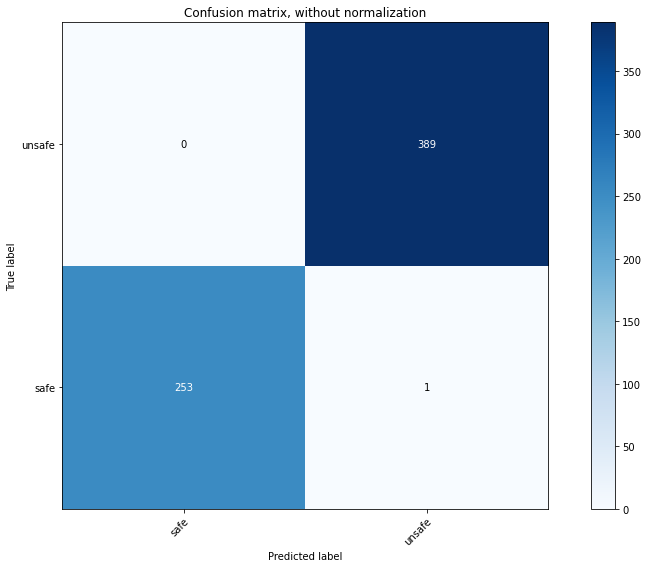


Save model to C:\Users\tirumva2\Realtime-Action-Recognition//model/trained_classifier.pickle


In [3]:
#!/usr/bin/env python
# coding: utf-8

''' This script does:
1. Load features and labels from csv files
2. Train the model
3. Save the model to `model/` folder.
'''

import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.metrics import classification_report

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_plot as lib_plot
    import utils.lib_commons as lib_commons
    from utils.lib_classifier import ClassifierOfflineTrain



def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s4_train.py"]

CLASSES = np.array(cfg_all["classes"])


SRC_PROCESSED_FEATURES = par(cfg["input"]["processed_features"])
SRC_PROCESSED_FEATURES_LABELS = par(cfg["input"]["processed_features_labels"])

DST_MODEL_PATH = par(cfg["output"]["model_path"])

# -- Functions

def train_test_split(X, Y, ratio_of_test_size):
    ''' Split training data by ratio '''
    IS_SPLIT_BY_SKLEARN_FUNC = True

    # Use sklearn.train_test_split
    if IS_SPLIT_BY_SKLEARN_FUNC:
        RAND_SEED = 1
        tr_X, te_X, tr_Y, te_Y = sklearn.model_selection.train_test_split(
            X, Y, test_size=ratio_of_test_size, random_state=RAND_SEED)

    # Make train/test the same.
    else:
        tr_X = np.copy(X)
        tr_Y = Y.copy()
        te_X = np.copy(X)
        te_Y = Y.copy()
    return tr_X, te_X, tr_Y, te_Y

def evaluate_model(model, classes, tr_X, tr_Y, te_X, te_Y):
    ''' Evaluate accuracy and time cost '''

    # Accuracy
    t0 = time.time()

    tr_accu, tr_Y_predict = model.predict_and_evaluate(tr_X, tr_Y)
    print(f"Accuracy on training set is {tr_accu}")

    te_accu, te_Y_predict = model.predict_and_evaluate(te_X, te_Y)
    print(f"Accuracy on testing set is {te_accu}")

    print("Accuracy report:")
    print(classification_report(
        te_Y, te_Y_predict, target_names=classes, output_dict=False))

    # Time cost
    average_time = (time.time() - t0) / (len(tr_Y) + len(te_Y))
    print("Time cost for predicting one sample: "
          "{:.5f} seconds".format(average_time))

    # Plot accuracy
    axis, cf = lib_plot.plot_confusion_matrix(
        te_Y, te_Y_predict, classes, normalize=False, size=(12, 8))
    plt.show()



# -- Main


def main():

    # -- Load preprocessed data
    print("\nReading csv files of classes, features, and labels ...")
    X = np.loadtxt(SRC_PROCESSED_FEATURES, dtype=float)  # features
    Y = np.loadtxt(SRC_PROCESSED_FEATURES_LABELS, dtype=int)  # labels
    
    # -- Train-test split
    tr_X, te_X, tr_Y, te_Y = train_test_split(
        X, Y, ratio_of_test_size=0.3)
    print("\nAfter train-test split:")
    print("Size of training data X:    ", tr_X.shape)
    print("Number of training samples: ", len(tr_Y))
    print("Number of testing samples:  ", len(te_Y))

    # -- Train the model
    print("\nStart training model ...")
    model = ClassifierOfflineTrain()
    model.train(tr_X, tr_Y)

    # -- Evaluate model
    print("\nStart evaluating model ...")
    evaluate_model(model, CLASSES, tr_X, tr_Y, te_X, te_Y)

    # -- Save model
    print("\nSave model to " + DST_MODEL_PATH)
    with open(DST_MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)


if __name__ == "__main__":
    main()


# s5_test.py

In [1]:
#!/usr/bin/env python
# coding: utf-8

'''
Test action recognition on
(1) a video, (2) a folder of images, (3) or web camera.

Input:
    model: model/trained_classifier.pickle

Output:
    result video:    output/${video_name}/video.avi
    result skeleton: output/${video_name}/skeleton_res/XXXXX.txt
    visualization by cv2.imshow() in img_displayer
'''

'''
Example of usage:

(1) Test on video file:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type video \
    --data_path data_test/exercise.avi \
    --output_folder output
    
(2) Test on a folder of images:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type folder \
    --data_path data_test/apple/ \
    --output_folder output

(3) Test on web camera:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type webcam \
    --data_path 0 \
    --output_folder output
    
'''

import tensorflow as tf
import numpy as np
import cv2
import argparse
if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"/../"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_images_io as lib_images_io
    import utils.lib_plot as lib_plot
    import utils.lib_commons as lib_commons
    from utils.lib_openpose import SkeletonDetector
    from utils.lib_tracker import Tracker
    from utils.lib_tracker import Tracker
    from utils.lib_classifier import ClassifierOnlineTest
    from utils.lib_classifier import *  # Import all sklearn related libraries


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path


# -- Command-line input


def get_command_line_arguments():

    def parse_args():
        parser = argparse.ArgumentParser(
            description="Test action recognition on \n"
            "(1) a video, (2) a folder of images, (3) or web camera.")
        parser.add_argument("-m", "--model_path", required=False,
                            default='model/trained_classifier.pickle')
        parser.add_argument("-t", "--data_type", required=False, default='video',
                            choices=["video", "folder", "webcam"])
        parser.add_argument("-p", "--data_path", required=False, default="data_test/unsafe_test.mp4",
                            help="path to a video file, or images folder, or webcam. \n"
                            "For video and folder, the path should be "
                            "absolute or relative to this project's root. "
                            "For webcam, either input an index or device name. ")
        parser.add_argument("-o", "--output_folder", required=False, default='output/',
                            help="Which folder to save result to.")

        #args = parser.parse_args()
        args, unknown = parser.parse_known_args()
        return args
    args = parse_args()
    if args.data_type != "webcam" and args.data_path and args.data_path[0] != "/":
        # If the path is not absolute, then its relative to the ROOT.
        args.data_path = ROOT + args.data_path
    return args


def get_dst_folder_name(src_data_type, src_data_path):
    ''' Compute a output folder name based on data_type and data_path.
        The final output of this script looks like this:
            DST_FOLDER/folder_name/vidoe.avi
            DST_FOLDER/folder_name/skeletons/XXXXX.txt
    '''

    assert(src_data_type in ["video", "folder", "webcam"])

    if src_data_type == "video":  # /root/data/video.avi --> video
        folder_name = os.path.basename(src_data_path).split(".")[-2]

    elif src_data_type == "folder":  # /root/data/video/ --> video
        folder_name = src_data_path.rstrip("/").split("/")[-1]

    elif src_data_type == "webcam":
        # month-day-hour-minute-seconds, e.g.: 02-26-15-51-12
        folder_name = lib_commons.get_time_string()

    return folder_name


args = get_command_line_arguments()

SRC_DATA_TYPE = args.data_type
SRC_DATA_PATH = args.data_path
SRC_MODEL_PATH = args.model_path

DST_FOLDER_NAME = get_dst_folder_name(SRC_DATA_TYPE, SRC_DATA_PATH)

# -- Settings

cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s5_test.py"]

CLASSES = np.array(cfg_all["classes"])
SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]

# Action recognition: number of frames used to extract features.
WINDOW_SIZE = int(cfg_all["features"]["window_size"])

# Output folder
DST_FOLDER = args.output_folder + "/" + DST_FOLDER_NAME + "/"
DST_SKELETON_FOLDER_NAME = cfg["output"]["skeleton_folder_name"]
DST_VIDEO_NAME = cfg["output"]["video_name"]
# framerate of output video.avi
DST_VIDEO_FPS = float(cfg["output"]["video_fps"])


# Video setttings

# If data_type is webcam, set the max frame rate.
SRC_WEBCAM_MAX_FPS = float(cfg["settings"]["source"]
                           ["webcam_max_framerate"])

# If data_type is video, set the sampling interval.
# For example, if it's 3, then the video will be read 3 times faster.
SRC_VIDEO_SAMPLE_INTERVAL = int(cfg["settings"]["source"]
                                ["video_sample_interval"])

# Openpose settings
OPENPOSE_MODEL = cfg["settings"]["openpose"]["model"]
OPENPOSE_IMG_SIZE = cfg["settings"]["openpose"]["img_size"]

# Display settings
img_disp_desired_rows = int(cfg["settings"]["display"]["desired_rows"])


# -- Function


def select_images_loader(src_data_type, src_data_path):
    if src_data_type == "video":
        images_loader = lib_images_io.ReadFromVideo(
            src_data_path,
            sample_interval=SRC_VIDEO_SAMPLE_INTERVAL)

    elif src_data_type == "folder":
        images_loader = lib_images_io.ReadFromFolder(
            folder_path=src_data_path)

    elif src_data_type == "webcam":
        if src_data_path == "":
            webcam_idx = 0
        elif src_data_path.isdigit():
            webcam_idx = int(src_data_path)
        else:
            webcam_idx = src_data_path
        images_loader = lib_images_io.ReadFromWebcam(
            SRC_WEBCAM_MAX_FPS, webcam_idx)
    return images_loader


class MultiPersonClassifier(object):
    ''' This is a wrapper around ClassifierOnlineTest
        for recognizing actions of multiple people.
    '''

    def __init__(self, model_path, classes):

        self.dict_id2clf = {}  # human id -> classifier of this person

        # Define a function for creating classifier for new people.
        self._create_classifier = lambda human_id: ClassifierOnlineTest(
            model_path, classes, WINDOW_SIZE, human_id)

    def classify(self, dict_id2skeleton):
        ''' Classify the action type of each skeleton in dict_id2skeleton '''

        # Clear people not in view
        old_ids = set(self.dict_id2clf)
        cur_ids = set(dict_id2skeleton)
        humans_not_in_view = list(old_ids - cur_ids)
        for human in humans_not_in_view:
            del self.dict_id2clf[human]

        # Predict each person's action
        id2label = {}
        for id, skeleton in dict_id2skeleton.items():

            if id not in self.dict_id2clf:  # add this new person
                self.dict_id2clf[id] = self._create_classifier(id)

            classifier = self.dict_id2clf[id]
            id2label[id] = classifier.predict(skeleton)  # predict label
            # print("\n\nPredicting label for human{}".format(id))
            # print("  skeleton: {}".format(skeleton))
            # print("  label: {}".format(id2label[id]))

        return id2label

    def get_classifier(self, id):
        ''' Get the classifier based on the person id.
        Arguments:
            id {int or "min"}
        '''
        if len(self.dict_id2clf) == 0:
            return None
        if id == 'min':
            id = min(self.dict_id2clf.keys())
        return self.dict_id2clf[id]


def remove_skeletons_with_few_joints(skeletons):
    ''' Remove bad skeletons before sending to the tracker '''
    good_skeletons = []
    for skeleton in skeletons:
        px = skeleton[2:2+13*2:2]
        py = skeleton[3:2+13*2:2]
        num_valid_joints = len([x for x in px if x != 0])
        num_leg_joints = len([x for x in px[-6:] if x != 0])
        total_size = max(py) - min(py)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # IF JOINTS ARE MISSING, TRY CHANGING THESE VALUES:
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if num_valid_joints >= 5 and total_size >= 0.1 and num_leg_joints >= 0:
            # add this skeleton only when all requirements are satisfied
            good_skeletons.append(skeleton)
    return good_skeletons


def draw_result_img(img_disp, ith_img, humans, dict_id2skeleton,
                    skeleton_detector, multiperson_classifier):
    ''' Draw skeletons, labels, and prediction scores onto image for display '''

    # Resize to a proper size for display
    r, c = img_disp.shape[0:2]
    desired_cols = int(1.0 * c * (img_disp_desired_rows / r))
    img_disp = cv2.resize(img_disp,
                          dsize=(desired_cols, img_disp_desired_rows))

    # Draw all people's skeleton
    skeleton_detector.draw(img_disp, humans)

    # Draw bounding box and label of each person
    if len(dict_id2skeleton):
        for id, label in dict_id2label.items():
            skeleton = dict_id2skeleton[id]
            # scale the y data back to original
            skeleton[1::2] = skeleton[1::2] / scale_h
            # print("Drawing skeleton: ", dict_id2skeleton[id], "with label:", label, ".")
            lib_plot.draw_action_result(img_disp, id, skeleton, label)

    # Add blank to the left for displaying prediction scores of each class
    img_disp = lib_plot.add_white_region_to_left_of_image(img_disp)

    cv2.putText(img_disp, "Frame:" + str(ith_img),
                (20, 20), fontScale=1.5, fontFace=cv2.FONT_HERSHEY_PLAIN,
                color=(0, 0, 0), thickness=2)

    # Draw predicting score for only 1 person
    if len(dict_id2skeleton):
        classifier_of_a_person = multiperson_classifier.get_classifier(
            id='min')
        classifier_of_a_person.draw_scores_onto_image(img_disp)
    return img_disp


def get_the_skeleton_data_to_save_to_disk(dict_id2skeleton):
    '''
    In each image, for each skeleton, save the:
        human_id, label, and the skeleton positions of length 18*2.
    So the total length per row is 2+36=38
    '''
    skels_to_save = []
    for human_id in dict_id2skeleton.keys():
        label = dict_id2label[human_id]
        skeleton = dict_id2skeleton[human_id]
        skels_to_save.append([[human_id, label] + skeleton.tolist()])
    return skels_to_save


# -- Main
if __name__ == "__main__":

    # -- Detector, tracker, classifier

    skeleton_detector = SkeletonDetector(OPENPOSE_MODEL, OPENPOSE_IMG_SIZE)

    multiperson_tracker = Tracker()

    multiperson_classifier = MultiPersonClassifier(SRC_MODEL_PATH, CLASSES)

    # -- Image reader and displayer
    images_loader = select_images_loader(SRC_DATA_TYPE, SRC_DATA_PATH)
    img_displayer = lib_images_io.ImageDisplayer()

    # -- Init output

    # output folder
    os.makedirs(DST_FOLDER, exist_ok=True)
    os.makedirs(DST_FOLDER + DST_SKELETON_FOLDER_NAME, exist_ok=True)

    # video writer
    video_writer = lib_images_io.VideoWriter(
        DST_FOLDER + DST_VIDEO_NAME, DST_VIDEO_FPS)

    # -- Read images and process
    try:
        ith_img = -1
        while images_loader.has_image():

            # -- Read image
            img = images_loader.read_image()
            ith_img += 1
            img_disp = img.copy()
            print(f"\nProcessing {ith_img}th image ...")

            # -- Detect skeletons
            humans = skeleton_detector.detect(img)
            skeletons, scale_h = skeleton_detector.humans_to_skels_list(humans)
            skeletons = remove_skeletons_with_few_joints(skeletons)

            # -- Track people
            dict_id2skeleton = multiperson_tracker.track(
                skeletons)  # int id -> np.array() skeleton

            # -- Recognize action of each person
            if len(dict_id2skeleton):
                dict_id2label = multiperson_classifier.classify(
                    dict_id2skeleton)

            # -- Draw
            img_disp = draw_result_img(img_disp, ith_img, humans, dict_id2skeleton,
                                       skeleton_detector, multiperson_classifier)

            # Print label of a person
            if len(dict_id2skeleton):
                min_id = min(dict_id2skeleton.keys())
                print("prediced label is :", dict_id2label[min_id])

            # -- Display image, and write to video.avi
            img_displayer.display(img_disp, wait_key_ms=1)
            video_writer.write(img_disp)

            # -- Get skeleton data and save to file
            skels_to_save = get_the_skeleton_data_to_save_to_disk(
                dict_id2skeleton)
            lib_commons.save_listlist(
                DST_FOLDER + DST_SKELETON_FOLDER_NAME +
                SKELETON_FILENAME_FORMAT.format(ith_img),
                skels_to_save)
    finally:
        video_writer.stop()
        print("Program ends")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





[2021-05-28 13:34:55,769] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/mobilenet_thin/graph_opt.pb(default size=656x368)






TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimat



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





[2021-05-28 13:34:57,347] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:57,347] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 0th image ...


[2021-05-28 13:34:57,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:57,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:57,638] [TfPoseEstimator] [DEBUG] estimate time=0.01081
[2021-05-28 13:34:57,638] [TfPoseEstimator] [DEBUG] estimate time=0.01081
[2021-05-28 13:34:57,639] [TfPoseEstimator] [INFO] inference image in 0.2911 seconds.
[2021-05-28 13:34:57,639] [TfPoseEstimator] [INFO] inference image in 0.2911 seconds.
[2021-05-28 13:34:57,655] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:57,655] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 1th image ...


[2021-05-28 13:34:57,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:57,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:57,929] [TfPoseEstimator] [DEBUG] estimate time=0.00942
[2021-05-28 13:34:57,929] [TfPoseEstimator] [DEBUG] estimate time=0.00942
[2021-05-28 13:34:57,930] [TfPoseEstimator] [INFO] inference image in 0.2755 seconds.
[2021-05-28 13:34:57,930] [TfPoseEstimator] [INFO] inference image in 0.2755 seconds.
[2021-05-28 13:34:57,942] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:57,942] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 2th image ...


[2021-05-28 13:34:58,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,218] [TfPoseEstimator] [DEBUG] estimate time=0.00785
[2021-05-28 13:34:58,218] [TfPoseEstimator] [DEBUG] estimate time=0.00785
[2021-05-28 13:34:58,219] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 13:34:58,219] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-05-28 13:34:58,232] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:58,232] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 3th image ...


[2021-05-28 13:34:58,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,509] [TfPoseEstimator] [DEBUG] estimate time=0.00332
[2021-05-28 13:34:58,509] [TfPoseEstimator] [DEBUG] estimate time=0.00332
[2021-05-28 13:34:58,510] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 13:34:58,510] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 13:34:58,527] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:58,527] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 4th image ...


[2021-05-28 13:34:58,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:58,806] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:34:58,806] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:34:58,807] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-05-28 13:34:58,807] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-05-28 13:34:58,835] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:58,835] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 5th image ...


[2021-05-28 13:34:59,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,130] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-05-28 13:34:59,130] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-05-28 13:34:59,131] [TfPoseEstimator] [INFO] inference image in 0.2953 seconds.
[2021-05-28 13:34:59,131] [TfPoseEstimator] [INFO] inference image in 0.2953 seconds.
[2021-05-28 13:34:59,143] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:59,143] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 6th image ...


[2021-05-28 13:34:59,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,421] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:34:59,421] [TfPoseEstimator] [DEBUG] estimate time=0.00151
[2021-05-28 13:34:59,422] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:34:59,422] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:34:59,463] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:59,463] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.51443674e-09 9.99999996e-01]
prediced label is : unsafe

Processing 7th image ...


[2021-05-28 13:34:59,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:34:59,774] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 13:34:59,774] [TfPoseEstimator] [DEBUG] estimate time=0.00728
[2021-05-28 13:34:59,775] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:34:59,775] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-05-28 13:34:59,788] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:34:59,788] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [9.29036403e-08 9.99999907e-01]
prediced label is : unsafe

Processing 8th image ...


[2021-05-28 13:35:00,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,062] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:35:00,062] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-05-28 13:35:00,063] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 13:35:00,063] [TfPoseEstimator] [INFO] inference image in 0.2747 seconds.
[2021-05-28 13:35:00,077] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:00,077] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.04185944e-05 9.99989581e-01]
prediced label is : unsafe

Processing 9th image ...


[2021-05-28 13:35:00,345] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,345] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,352] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-05-28 13:35:00,352] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-05-28 13:35:00,353] [TfPoseEstimator] [INFO] inference image in 0.2765 seconds.
[2021-05-28 13:35:00,353] [TfPoseEstimator] [INFO] inference image in 0.2765 seconds.
[2021-05-28 13:35:00,366] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:00,366] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.03274480e-05 9.99989673e-01]
prediced label is : unsafe

Processing 10th image ...


[2021-05-28 13:35:00,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,647] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-05-28 13:35:00,647] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-05-28 13:35:00,648] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-05-28 13:35:00,648] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-05-28 13:35:00,662] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:00,662] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.30397350e-04 9.99769603e-01]
prediced label is : unsafe

Processing 11th image ...


[2021-05-28 13:35:00,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:00,942] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 13:35:00,942] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-05-28 13:35:00,943] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-05-28 13:35:00,943] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-05-28 13:35:00,957] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:00,957] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.30398154e-04 9.99769602e-01]
prediced label is : unsafe

Processing 12th image ...


[2021-05-28 13:35:01,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,241] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 13:35:01,241] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-05-28 13:35:01,242] [TfPoseEstimator] [INFO] inference image in 0.2857 seconds.
[2021-05-28 13:35:01,242] [TfPoseEstimator] [INFO] inference image in 0.2857 seconds.
[2021-05-28 13:35:01,270] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:01,270] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 13th image ...


[2021-05-28 13:35:01,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,574] [TfPoseEstimator] [DEBUG] estimate time=0.00750
[2021-05-28 13:35:01,574] [TfPoseEstimator] [DEBUG] estimate time=0.00750
[2021-05-28 13:35:01,575] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 13:35:01,575] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 13:35:01,586] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:01,586] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 14th image ...


[2021-05-28 13:35:01,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:01,858] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:35:01,858] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:35:01,859] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 13:35:01,859] [TfPoseEstimator] [INFO] inference image in 0.2735 seconds.
[2021-05-28 13:35:01,875] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:01,875] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 15th image ...


[2021-05-28 13:35:02,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,157] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 13:35:02,157] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-05-28 13:35:02,158] [TfPoseEstimator] [INFO] inference image in 0.2827 seconds.
[2021-05-28 13:35:02,158] [TfPoseEstimator] [INFO] inference image in 0.2827 seconds.
[2021-05-28 13:35:02,170] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:02,170] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 16th image ...


[2021-05-28 13:35:02,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,446] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-05-28 13:35:02,446] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-05-28 13:35:02,447] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 13:35:02,447] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 13:35:02,460] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:02,460] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 17th image ...


[2021-05-28 13:35:02,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:02,742] [TfPoseEstimator] [DEBUG] estimate time=0.00982
[2021-05-28 13:35:02,742] [TfPoseEstimator] [DEBUG] estimate time=0.00982
[2021-05-28 13:35:02,743] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-05-28 13:35:02,743] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-05-28 13:35:02,754] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:02,754] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 18th image ...


[2021-05-28 13:35:03,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,027] [TfPoseEstimator] [DEBUG] estimate time=0.00380
[2021-05-28 13:35:03,027] [TfPoseEstimator] [DEBUG] estimate time=0.00380
[2021-05-28 13:35:03,028] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 13:35:03,028] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 13:35:03,052] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:03,052] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 19th image ...


[2021-05-28 13:35:03,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,359] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 13:35:03,359] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 13:35:03,360] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:35:03,360] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:35:03,372] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:03,372] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 20th image ...


[2021-05-28 13:35:03,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,648] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2021-05-28 13:35:03,648] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2021-05-28 13:35:03,649] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 13:35:03,649] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 13:35:03,662] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:03,662] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 21th image ...


[2021-05-28 13:35:03,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:03,937] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 13:35:03,937] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-05-28 13:35:03,938] [TfPoseEstimator] [INFO] inference image in 0.2757 seconds.
[2021-05-28 13:35:03,938] [TfPoseEstimator] [INFO] inference image in 0.2757 seconds.
[2021-05-28 13:35:03,951] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:03,951] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 22th image ...


[2021-05-28 13:35:04,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,239] [TfPoseEstimator] [DEBUG] estimate time=0.00910
[2021-05-28 13:35:04,239] [TfPoseEstimator] [DEBUG] estimate time=0.00910
[2021-05-28 13:35:04,240] [TfPoseEstimator] [INFO] inference image in 0.2893 seconds.
[2021-05-28 13:35:04,240] [TfPoseEstimator] [INFO] inference image in 0.2893 seconds.
[2021-05-28 13:35:04,254] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:04,254] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.41208748 0.58791252]
prediced label is : unsafe

Processing 23th image ...


[2021-05-28 13:35:04,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,536] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:35:04,536] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-05-28 13:35:04,538] [TfPoseEstimator] [INFO] inference image in 0.2842 seconds.
[2021-05-28 13:35:04,538] [TfPoseEstimator] [INFO] inference image in 0.2842 seconds.
[2021-05-28 13:35:04,563] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:04,563] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.45419662 0.54580338]
prediced label is : unsafe

Processing 24th image ...


[2021-05-28 13:35:04,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:04,851] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 13:35:04,851] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-05-28 13:35:04,852] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2021-05-28 13:35:04,852] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2021-05-28 13:35:04,865] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:04,865] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.04211597 0.95788403]
prediced label is : unsafe

Processing 25th image ...


[2021-05-28 13:35:05,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,152] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:35:05,152] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:35:05,153] [TfPoseEstimator] [INFO] inference image in 0.2882 seconds.
[2021-05-28 13:35:05,153] [TfPoseEstimator] [INFO] inference image in 0.2882 seconds.
[2021-05-28 13:35:05,167] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:05,167] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [6.8300888e-06 9.9999317e-01]
prediced label is : unsafe

Processing 26th image ...


[2021-05-28 13:35:05,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,444] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-05-28 13:35:05,444] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-05-28 13:35:05,445] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 13:35:05,445] [TfPoseEstimator] [INFO] inference image in 0.2778 seconds.
[2021-05-28 13:35:05,459] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:05,459] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.32406325e-11 1.00000000e+00]
prediced label is : unsafe

Processing 27th image ...


[2021-05-28 13:35:05,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:05,731] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-05-28 13:35:05,731] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-05-28 13:35:05,732] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:05,732] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:05,745] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:05,745] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [5.65337777e-11 1.00000000e+00]
prediced label is : unsafe

Processing 28th image ...


[2021-05-28 13:35:06,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,014] [TfPoseEstimator] [DEBUG] estimate time=0.00764
[2021-05-28 13:35:06,014] [TfPoseEstimator] [DEBUG] estimate time=0.00764
[2021-05-28 13:35:06,015] [TfPoseEstimator] [INFO] inference image in 0.2701 seconds.
[2021-05-28 13:35:06,015] [TfPoseEstimator] [INFO] inference image in 0.2701 seconds.
[2021-05-28 13:35:06,028] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:06,028] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.94941982e-09 9.99999995e-01]
prediced label is : unsafe

Processing 29th image ...


[2021-05-28 13:35:06,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,299] [TfPoseEstimator] [DEBUG] estimate time=0.00655
[2021-05-28 13:35:06,299] [TfPoseEstimator] [DEBUG] estimate time=0.00655
[2021-05-28 13:35:06,300] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 13:35:06,300] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2021-05-28 13:35:06,313] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:06,313] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.54936976e-06 9.99997451e-01]
prediced label is : unsafe

Processing 30th image ...


[2021-05-28 13:35:06,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,583] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 13:35:06,583] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-05-28 13:35:06,584] [TfPoseEstimator] [INFO] inference image in 0.2714 seconds.
[2021-05-28 13:35:06,584] [TfPoseEstimator] [INFO] inference image in 0.2714 seconds.
[2021-05-28 13:35:06,598] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:06,598] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.44625279 0.55374721]
prediced label is : unsafe

Processing 31th image ...


[2021-05-28 13:35:06,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:06,869] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 13:35:06,869] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-05-28 13:35:06,870] [TfPoseEstimator] [INFO] inference image in 0.2719 seconds.
[2021-05-28 13:35:06,870] [TfPoseEstimator] [INFO] inference image in 0.2719 seconds.
[2021-05-28 13:35:06,883] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:06,883] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.446264 0.553736]
prediced label is : unsafe

Processing 32th image ...


[2021-05-28 13:35:07,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,144] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,154] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-05-28 13:35:07,154] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-05-28 13:35:07,155] [TfPoseEstimator] [INFO] inference image in 0.2720 seconds.
[2021-05-28 13:35:07,155] [TfPoseEstimator] [INFO] inference image in 0.2720 seconds.
[2021-05-28 13:35:07,167] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:07,167] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 33th image ...


[2021-05-28 13:35:07,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,443] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:35:07,443] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:35:07,444] [TfPoseEstimator] [INFO] inference image in 0.2767 seconds.
[2021-05-28 13:35:07,444] [TfPoseEstimator] [INFO] inference image in 0.2767 seconds.
[2021-05-28 13:35:07,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:07,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 34th image ...


[2021-05-28 13:35:07,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:07,730] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-05-28 13:35:07,730] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-05-28 13:35:07,731] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-05-28 13:35:07,731] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-05-28 13:35:07,742] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:07,742] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 35th image ...


[2021-05-28 13:35:08,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,014] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-05-28 13:35:08,014] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-05-28 13:35:08,015] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:08,015] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:08,026] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:08,026] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 36th image ...


[2021-05-28 13:35:08,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,304] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 13:35:08,304] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-05-28 13:35:08,305] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 13:35:08,305] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 13:35:08,318] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:08,318] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 37th image ...


[2021-05-28 13:35:08,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,589] [TfPoseEstimator] [DEBUG] estimate time=0.00619
[2021-05-28 13:35:08,589] [TfPoseEstimator] [DEBUG] estimate time=0.00619
[2021-05-28 13:35:08,590] [TfPoseEstimator] [INFO] inference image in 0.2726 seconds.
[2021-05-28 13:35:08,590] [TfPoseEstimator] [INFO] inference image in 0.2726 seconds.
[2021-05-28 13:35:08,600] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:08,600] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 38th image ...


[2021-05-28 13:35:08,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:08,872] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-05-28 13:35:08,872] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-05-28 13:35:08,873] [TfPoseEstimator] [INFO] inference image in 0.2727 seconds.
[2021-05-28 13:35:08,873] [TfPoseEstimator] [INFO] inference image in 0.2727 seconds.
[2021-05-28 13:35:08,895] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:08,895] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 39th image ...


[2021-05-28 13:35:09,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,193] [TfPoseEstimator] [DEBUG] estimate time=0.00981
[2021-05-28 13:35:09,193] [TfPoseEstimator] [DEBUG] estimate time=0.00981
[2021-05-28 13:35:09,194] [TfPoseEstimator] [INFO] inference image in 0.2988 seconds.
[2021-05-28 13:35:09,194] [TfPoseEstimator] [INFO] inference image in 0.2988 seconds.
[2021-05-28 13:35:09,204] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:09,204] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 40th image ...


[2021-05-28 13:35:09,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,477] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:35:09,477] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:35:09,478] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2021-05-28 13:35:09,478] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2021-05-28 13:35:09,488] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:09,488] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 41th image ...


[2021-05-28 13:35:09,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:09,773] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 13:35:09,773] [TfPoseEstimator] [DEBUG] estimate time=0.00124
[2021-05-28 13:35:09,774] [TfPoseEstimator] [INFO] inference image in 0.2858 seconds.
[2021-05-28 13:35:09,774] [TfPoseEstimator] [INFO] inference image in 0.2858 seconds.
[2021-05-28 13:35:09,785] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:09,785] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 42th image ...


[2021-05-28 13:35:10,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,057] [TfPoseEstimator] [DEBUG] estimate time=0.00759
[2021-05-28 13:35:10,057] [TfPoseEstimator] [DEBUG] estimate time=0.00759
[2021-05-28 13:35:10,058] [TfPoseEstimator] [INFO] inference image in 0.2736 seconds.
[2021-05-28 13:35:10,058] [TfPoseEstimator] [INFO] inference image in 0.2736 seconds.
[2021-05-28 13:35:10,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:10,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 43th image ...


[2021-05-28 13:35:10,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,340] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-05-28 13:35:10,340] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-05-28 13:35:10,341] [TfPoseEstimator] [INFO] inference image in 0.2723 seconds.
[2021-05-28 13:35:10,341] [TfPoseEstimator] [INFO] inference image in 0.2723 seconds.
[2021-05-28 13:35:10,351] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:10,351] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 44th image ...


[2021-05-28 13:35:10,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,629] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 13:35:10,629] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-05-28 13:35:10,630] [TfPoseEstimator] [INFO] inference image in 0.2785 seconds.
[2021-05-28 13:35:10,630] [TfPoseEstimator] [INFO] inference image in 0.2785 seconds.
[2021-05-28 13:35:10,641] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:10,641] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 45th image ...


[2021-05-28 13:35:10,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:10,920] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-05-28 13:35:10,920] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-05-28 13:35:10,921] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-05-28 13:35:10,921] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-05-28 13:35:10,931] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:10,931] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 46th image ...


[2021-05-28 13:35:11,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,201] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:11,201] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:11,202] [TfPoseEstimator] [INFO] inference image in 0.2710 seconds.
[2021-05-28 13:35:11,202] [TfPoseEstimator] [INFO] inference image in 0.2710 seconds.
[2021-05-28 13:35:11,215] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:11,215] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 47th image ...


[2021-05-28 13:35:11,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,483] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,493] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-05-28 13:35:11,493] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-05-28 13:35:11,494] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 13:35:11,494] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 13:35:11,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:11,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 48th image ...


[2021-05-28 13:35:11,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:11,791] [TfPoseEstimator] [DEBUG] estimate time=0.00757
[2021-05-28 13:35:11,791] [TfPoseEstimator] [DEBUG] estimate time=0.00757
[2021-05-28 13:35:11,792] [TfPoseEstimator] [INFO] inference image in 0.2869 seconds.
[2021-05-28 13:35:11,792] [TfPoseEstimator] [INFO] inference image in 0.2869 seconds.
[2021-05-28 13:35:11,815] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:11,815] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 49th image ...


[2021-05-28 13:35:12,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,086] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 13:35:12,086] [TfPoseEstimator] [DEBUG] estimate time=0.00421
[2021-05-28 13:35:12,087] [TfPoseEstimator] [INFO] inference image in 0.2724 seconds.
[2021-05-28 13:35:12,087] [TfPoseEstimator] [INFO] inference image in 0.2724 seconds.
[2021-05-28 13:35:12,099] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:12,099] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 50th image ...


[2021-05-28 13:35:12,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,382] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 13:35:12,382] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 13:35:12,383] [TfPoseEstimator] [INFO] inference image in 0.2850 seconds.
[2021-05-28 13:35:12,383] [TfPoseEstimator] [INFO] inference image in 0.2850 seconds.
[2021-05-28 13:35:12,396] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:12,396] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 51th image ...


[2021-05-28 13:35:12,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,692] [TfPoseEstimator] [DEBUG] estimate time=0.00926
[2021-05-28 13:35:12,692] [TfPoseEstimator] [DEBUG] estimate time=0.00926
[2021-05-28 13:35:12,693] [TfPoseEstimator] [INFO] inference image in 0.2977 seconds.
[2021-05-28 13:35:12,693] [TfPoseEstimator] [INFO] inference image in 0.2977 seconds.
[2021-05-28 13:35:12,705] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:12,705] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 52th image ...


[2021-05-28 13:35:12,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:12,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,002] [TfPoseEstimator] [DEBUG] estimate time=0.00335
[2021-05-28 13:35:13,002] [TfPoseEstimator] [DEBUG] estimate time=0.00335
[2021-05-28 13:35:13,003] [TfPoseEstimator] [INFO] inference image in 0.2980 seconds.
[2021-05-28 13:35:13,003] [TfPoseEstimator] [INFO] inference image in 0.2980 seconds.
[2021-05-28 13:35:13,014] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:13,014] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 53th image ...


[2021-05-28 13:35:13,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,297] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 13:35:13,297] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 13:35:13,299] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 13:35:13,299] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-05-28 13:35:13,310] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:13,310] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 54th image ...


[2021-05-28 13:35:13,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,586] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,597] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:13,597] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:13,598] [TfPoseEstimator] [INFO] inference image in 0.2876 seconds.
[2021-05-28 13:35:13,598] [TfPoseEstimator] [INFO] inference image in 0.2876 seconds.
[2021-05-28 13:35:13,610] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:13,610] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 55th image ...


[2021-05-28 13:35:13,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:13,882] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:35:13,882] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-05-28 13:35:13,883] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:13,883] [TfPoseEstimator] [INFO] inference image in 0.2732 seconds.
[2021-05-28 13:35:13,895] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:13,895] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 56th image ...


[2021-05-28 13:35:14,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,181] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 13:35:14,181] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 13:35:14,182] [TfPoseEstimator] [INFO] inference image in 0.2870 seconds.
[2021-05-28 13:35:14,182] [TfPoseEstimator] [INFO] inference image in 0.2870 seconds.
[2021-05-28 13:35:14,193] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:14,193] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 57th image ...


[2021-05-28 13:35:14,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,481] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:14,481] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:14,482] [TfPoseEstimator] [INFO] inference image in 0.2890 seconds.
[2021-05-28 13:35:14,482] [TfPoseEstimator] [INFO] inference image in 0.2890 seconds.
[2021-05-28 13:35:14,493] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:14,493] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 58th image ...


[2021-05-28 13:35:14,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:14,776] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 13:35:14,776] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 13:35:14,777] [TfPoseEstimator] [INFO] inference image in 0.2841 seconds.
[2021-05-28 13:35:14,777] [TfPoseEstimator] [INFO] inference image in 0.2841 seconds.
[2021-05-28 13:35:14,787] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:14,787] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 59th image ...


[2021-05-28 13:35:15,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,068] [TfPoseEstimator] [DEBUG] estimate time=0.00779
[2021-05-28 13:35:15,068] [TfPoseEstimator] [DEBUG] estimate time=0.00779
[2021-05-28 13:35:15,069] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-05-28 13:35:15,069] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-05-28 13:35:15,081] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:15,081] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 60th image ...


[2021-05-28 13:35:15,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,361] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 13:35:15,361] [TfPoseEstimator] [DEBUG] estimate time=0.00161
[2021-05-28 13:35:15,362] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-05-28 13:35:15,362] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-05-28 13:35:15,372] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:15,372] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 61th image ...


[2021-05-28 13:35:15,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,648] [TfPoseEstimator] [DEBUG] estimate time=0.00779
[2021-05-28 13:35:15,648] [TfPoseEstimator] [DEBUG] estimate time=0.00779
[2021-05-28 13:35:15,649] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:15,649] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:15,660] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:15,660] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 62th image ...


[2021-05-28 13:35:15,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:15,937] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 13:35:15,937] [TfPoseEstimator] [DEBUG] estimate time=0.00394
[2021-05-28 13:35:15,938] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 13:35:15,938] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-05-28 13:35:15,948] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:15,948] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 63th image ...


[2021-05-28 13:35:16,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,225] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 13:35:16,225] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2021-05-28 13:35:16,226] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 13:35:16,226] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2021-05-28 13:35:16,238] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:16,238] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 64th image ...


[2021-05-28 13:35:16,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,517] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:35:16,517] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-05-28 13:35:16,518] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2021-05-28 13:35:16,518] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2021-05-28 13:35:16,528] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:16,528] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 65th image ...


[2021-05-28 13:35:16,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:16,804] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 13:35:16,804] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-05-28 13:35:16,805] [TfPoseEstimator] [INFO] inference image in 0.2776 seconds.
[2021-05-28 13:35:16,805] [TfPoseEstimator] [INFO] inference image in 0.2776 seconds.
[2021-05-28 13:35:16,816] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:16,816] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 66th image ...


[2021-05-28 13:35:17,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,097] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:35:17,097] [TfPoseEstimator] [DEBUG] estimate time=0.00747
[2021-05-28 13:35:17,098] [TfPoseEstimator] [INFO] inference image in 0.2817 seconds.
[2021-05-28 13:35:17,098] [TfPoseEstimator] [INFO] inference image in 0.2817 seconds.
[2021-05-28 13:35:17,110] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:17,110] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 67th image ...


[2021-05-28 13:35:17,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,400] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-05-28 13:35:17,400] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-05-28 13:35:17,402] [TfPoseEstimator] [INFO] inference image in 0.2917 seconds.
[2021-05-28 13:35:17,402] [TfPoseEstimator] [INFO] inference image in 0.2917 seconds.
[2021-05-28 13:35:17,412] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:17,412] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 68th image ...


[2021-05-28 13:35:17,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:17,709] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:35:17,709] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:35:17,710] [TfPoseEstimator] [INFO] inference image in 0.2982 seconds.
[2021-05-28 13:35:17,710] [TfPoseEstimator] [INFO] inference image in 0.2982 seconds.
[2021-05-28 13:35:17,724] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:17,724] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 69th image ...


[2021-05-28 13:35:18,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,012] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-05-28 13:35:18,012] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-05-28 13:35:18,013] [TfPoseEstimator] [INFO] inference image in 0.2892 seconds.
[2021-05-28 13:35:18,013] [TfPoseEstimator] [INFO] inference image in 0.2892 seconds.
[2021-05-28 13:35:18,025] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:18,025] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 70th image ...


[2021-05-28 13:35:18,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,302] [TfPoseEstimator] [DEBUG] estimate time=0.00188
[2021-05-28 13:35:18,302] [TfPoseEstimator] [DEBUG] estimate time=0.00188
[2021-05-28 13:35:18,303] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 13:35:18,303] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-05-28 13:35:18,314] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:18,314] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 71th image ...


[2021-05-28 13:35:18,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,592] [TfPoseEstimator] [DEBUG] estimate time=0.00915
[2021-05-28 13:35:18,592] [TfPoseEstimator] [DEBUG] estimate time=0.00915
[2021-05-28 13:35:18,593] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:35:18,593] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:35:18,604] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:18,604] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 72th image ...


[2021-05-28 13:35:18,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:18,883] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 13:35:18,883] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-05-28 13:35:18,884] [TfPoseEstimator] [INFO] inference image in 0.2800 seconds.
[2021-05-28 13:35:18,884] [TfPoseEstimator] [INFO] inference image in 0.2800 seconds.
[2021-05-28 13:35:18,898] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:18,898] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.81971915e-08 9.99999962e-01]
prediced label is : unsafe

Processing 73th image ...


[2021-05-28 13:35:19,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,174] [TfPoseEstimator] [DEBUG] estimate time=0.00778
[2021-05-28 13:35:19,174] [TfPoseEstimator] [DEBUG] estimate time=0.00778
[2021-05-28 13:35:19,175] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-05-28 13:35:19,175] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-05-28 13:35:19,186] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:19,186] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 74th image ...


[2021-05-28 13:35:19,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,460] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:35:19,460] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:35:19,461] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 13:35:19,461] [TfPoseEstimator] [INFO] inference image in 0.2744 seconds.
[2021-05-28 13:35:19,475] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:19,475] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 75th image ...


[2021-05-28 13:35:19,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:19,761] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:19,761] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:19,762] [TfPoseEstimator] [INFO] inference image in 0.2873 seconds.
[2021-05-28 13:35:19,762] [TfPoseEstimator] [INFO] inference image in 0.2873 seconds.
[2021-05-28 13:35:19,774] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:19,774] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 76th image ...


[2021-05-28 13:35:20,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,060] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 13:35:20,060] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-05-28 13:35:20,061] [TfPoseEstimator] [INFO] inference image in 0.2868 seconds.
[2021-05-28 13:35:20,061] [TfPoseEstimator] [INFO] inference image in 0.2868 seconds.
[2021-05-28 13:35:20,072] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:20,072] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 77th image ...


[2021-05-28 13:35:20,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,354] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-05-28 13:35:20,354] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-05-28 13:35:20,355] [TfPoseEstimator] [INFO] inference image in 0.2831 seconds.
[2021-05-28 13:35:20,355] [TfPoseEstimator] [INFO] inference image in 0.2831 seconds.
[2021-05-28 13:35:20,367] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:20,367] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 78th image ...


[2021-05-28 13:35:20,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,642] [TfPoseEstimator] [DEBUG] estimate time=0.00828
[2021-05-28 13:35:20,642] [TfPoseEstimator] [DEBUG] estimate time=0.00828
[2021-05-28 13:35:20,643] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-05-28 13:35:20,643] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-05-28 13:35:20,655] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:20,655] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [7.34185823e-10 9.99999999e-01]
prediced label is : unsafe

Processing 79th image ...


[2021-05-28 13:35:20,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:20,932] [TfPoseEstimator] [DEBUG] estimate time=0.01036
[2021-05-28 13:35:20,932] [TfPoseEstimator] [DEBUG] estimate time=0.01036
[2021-05-28 13:35:20,933] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:20,933] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:20,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:20,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.79581957e-09 9.99999995e-01]
prediced label is : unsafe

Processing 80th image ...


[2021-05-28 13:35:21,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,225] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 13:35:21,225] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2021-05-28 13:35:21,226] [TfPoseEstimator] [INFO] inference image in 0.2791 seconds.
[2021-05-28 13:35:21,226] [TfPoseEstimator] [INFO] inference image in 0.2791 seconds.
[2021-05-28 13:35:21,237] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:21,237] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 81th image ...


[2021-05-28 13:35:21,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,514] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 13:35:21,514] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-05-28 13:35:21,515] [TfPoseEstimator] [INFO] inference image in 0.2786 seconds.
[2021-05-28 13:35:21,515] [TfPoseEstimator] [INFO] inference image in 0.2786 seconds.
[2021-05-28 13:35:21,528] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:21,528] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 82th image ...


[2021-05-28 13:35:21,790] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,790] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:21,799] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-05-28 13:35:21,799] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-05-28 13:35:21,800] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2021-05-28 13:35:21,800] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2021-05-28 13:35:21,812] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:21,812] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 83th image ...


[2021-05-28 13:35:22,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,089] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:35:22,089] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-05-28 13:35:22,090] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:22,090] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:22,106] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:22,106] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 84th image ...


[2021-05-28 13:35:22,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,383] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:35:22,383] [TfPoseEstimator] [DEBUG] estimate time=0.00784
[2021-05-28 13:35:22,384] [TfPoseEstimator] [INFO] inference image in 0.2782 seconds.
[2021-05-28 13:35:22,384] [TfPoseEstimator] [INFO] inference image in 0.2782 seconds.
[2021-05-28 13:35:22,395] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:22,395] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 85th image ...


[2021-05-28 13:35:22,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,671] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:35:22,671] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:35:22,672] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:22,672] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:22,685] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:22,685] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.52015799 0.47984201]
prediced label is : safe

Processing 86th image ...


[2021-05-28 13:35:22,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:22,973] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:35:22,973] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:35:22,974] [TfPoseEstimator] [INFO] inference image in 0.2897 seconds.
[2021-05-28 13:35:22,974] [TfPoseEstimator] [INFO] inference image in 0.2897 seconds.
[2021-05-28 13:35:22,986] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:22,986] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.30632029 0.69367971]
prediced label is : unsafe

Processing 87th image ...


[2021-05-28 13:35:23,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,263] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 13:35:23,263] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-05-28 13:35:23,264] [TfPoseEstimator] [INFO] inference image in 0.2776 seconds.
[2021-05-28 13:35:23,264] [TfPoseEstimator] [INFO] inference image in 0.2776 seconds.
[2021-05-28 13:35:23,277] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:23,277] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.05195874 0.94804126]
prediced label is : unsafe

Processing 88th image ...


[2021-05-28 13:35:23,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,568] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-05-28 13:35:23,568] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-05-28 13:35:23,569] [TfPoseEstimator] [INFO] inference image in 0.2920 seconds.
[2021-05-28 13:35:23,569] [TfPoseEstimator] [INFO] inference image in 0.2920 seconds.
[2021-05-28 13:35:23,582] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:23,582] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.04774039 0.95225961]
prediced label is : unsafe

Processing 89th image ...


[2021-05-28 13:35:23,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:23,863] [TfPoseEstimator] [DEBUG] estimate time=0.00923
[2021-05-28 13:35:23,863] [TfPoseEstimator] [DEBUG] estimate time=0.00923
[2021-05-28 13:35:23,864] [TfPoseEstimator] [INFO] inference image in 0.2817 seconds.
[2021-05-28 13:35:23,864] [TfPoseEstimator] [INFO] inference image in 0.2817 seconds.
[2021-05-28 13:35:23,877] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:23,877] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.07087626 0.92912374]
prediced label is : unsafe

Processing 90th image ...


[2021-05-28 13:35:24,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,151] [TfPoseEstimator] [DEBUG] estimate time=0.00829
[2021-05-28 13:35:24,151] [TfPoseEstimator] [DEBUG] estimate time=0.00829
[2021-05-28 13:35:24,152] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-05-28 13:35:24,152] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-05-28 13:35:24,165] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:24,165] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.05036918 0.94963082]
prediced label is : unsafe

Processing 91th image ...


[2021-05-28 13:35:24,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,444] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 13:35:24,444] [TfPoseEstimator] [DEBUG] estimate time=0.00735
[2021-05-28 13:35:24,445] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:35:24,445] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-05-28 13:35:24,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:24,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 92th image ...


[2021-05-28 13:35:24,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:24,732] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:35:24,732] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:35:24,733] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:24,733] [TfPoseEstimator] [INFO] inference image in 0.2780 seconds.
[2021-05-28 13:35:24,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:24,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 93th image ...


[2021-05-28 13:35:25,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,022] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-05-28 13:35:25,022] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-05-28 13:35:25,023] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:25,023] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-05-28 13:35:25,035] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:25,035] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 94th image ...


[2021-05-28 13:35:25,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,318] [TfPoseEstimator] [DEBUG] estimate time=0.00896
[2021-05-28 13:35:25,318] [TfPoseEstimator] [DEBUG] estimate time=0.00896
[2021-05-28 13:35:25,319] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2021-05-28 13:35:25,319] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2021-05-28 13:35:25,330] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:25,330] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 95th image ...


[2021-05-28 13:35:25,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,608] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-05-28 13:35:25,608] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-05-28 13:35:25,609] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 13:35:25,609] [TfPoseEstimator] [INFO] inference image in 0.2789 seconds.
[2021-05-28 13:35:25,621] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:25,621] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 96th image ...


[2021-05-28 13:35:25,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:25,898] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-05-28 13:35:25,898] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-05-28 13:35:25,899] [TfPoseEstimator] [INFO] inference image in 0.2774 seconds.
[2021-05-28 13:35:25,899] [TfPoseEstimator] [INFO] inference image in 0.2774 seconds.
[2021-05-28 13:35:25,911] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:25,911] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 97th image ...


[2021-05-28 13:35:26,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,189] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 13:35:26,189] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2021-05-28 13:35:26,190] [TfPoseEstimator] [INFO] inference image in 0.2792 seconds.
[2021-05-28 13:35:26,190] [TfPoseEstimator] [INFO] inference image in 0.2792 seconds.
[2021-05-28 13:35:26,201] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:26,201] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 98th image ...


[2021-05-28 13:35:26,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,485] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-05-28 13:35:26,485] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-05-28 13:35:26,486] [TfPoseEstimator] [INFO] inference image in 0.2844 seconds.
[2021-05-28 13:35:26,486] [TfPoseEstimator] [INFO] inference image in 0.2844 seconds.
[2021-05-28 13:35:26,499] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:26,499] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 99th image ...


[2021-05-28 13:35:26,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:26,786] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-05-28 13:35:26,786] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-05-28 13:35:26,787] [TfPoseEstimator] [INFO] inference image in 0.2882 seconds.
[2021-05-28 13:35:26,787] [TfPoseEstimator] [INFO] inference image in 0.2882 seconds.
[2021-05-28 13:35:26,800] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:26,800] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 100th image ...


[2021-05-28 13:35:27,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,109] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-05-28 13:35:27,109] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-05-28 13:35:27,110] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:35:27,110] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:35:27,127] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:27,127] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 101th image ...


[2021-05-28 13:35:27,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,432] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:35:27,432] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-05-28 13:35:27,433] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:27,433] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:27,447] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:27,447] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 102th image ...


[2021-05-28 13:35:27,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:27,755] [TfPoseEstimator] [DEBUG] estimate time=0.00188
[2021-05-28 13:35:27,755] [TfPoseEstimator] [DEBUG] estimate time=0.00188
[2021-05-28 13:35:27,756] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:35:27,756] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:35:27,771] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:27,771] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 103th image ...


[2021-05-28 13:35:28,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,100] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-05-28 13:35:28,100] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-05-28 13:35:28,101] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:35:28,101] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:35:28,113] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:28,113] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 104th image ...


[2021-05-28 13:35:28,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,415] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:35:28,415] [TfPoseEstimator] [DEBUG] estimate time=0.00725
[2021-05-28 13:35:28,416] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 13:35:28,416] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-05-28 13:35:28,431] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:28,431] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 105th image ...


[2021-05-28 13:35:28,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:28,739] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-05-28 13:35:28,739] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-05-28 13:35:28,741] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:35:28,741] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:35:28,752] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:28,752] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 106th image ...


[2021-05-28 13:35:29,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,066] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:35:29,066] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:35:29,068] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:35:29,068] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-05-28 13:35:29,082] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:29,082] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 107th image ...


[2021-05-28 13:35:29,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,387] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 13:35:29,387] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 13:35:29,388] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:29,388] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:29,402] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:29,402] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 108th image ...


[2021-05-28 13:35:29,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:29,731] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-05-28 13:35:29,731] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-05-28 13:35:29,732] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:35:29,732] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-05-28 13:35:29,745] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:29,745] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 109th image ...


[2021-05-28 13:35:30,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,077] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-05-28 13:35:30,077] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-05-28 13:35:30,078] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:35:30,078] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:35:30,090] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:30,090] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 110th image ...


[2021-05-28 13:35:30,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,421] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2021-05-28 13:35:30,421] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2021-05-28 13:35:30,422] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-05-28 13:35:30,422] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-05-28 13:35:30,438] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:30,438] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 111th image ...


[2021-05-28 13:35:30,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:30,771] [TfPoseEstimator] [DEBUG] estimate time=0.00750
[2021-05-28 13:35:30,771] [TfPoseEstimator] [DEBUG] estimate time=0.00750
[2021-05-28 13:35:30,772] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-05-28 13:35:30,772] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-05-28 13:35:30,785] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:30,785] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 112th image ...


[2021-05-28 13:35:31,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,102] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:31,102] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:31,103] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 13:35:31,103] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-05-28 13:35:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 113th image ...


[2021-05-28 13:35:31,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,445] [TfPoseEstimator] [DEBUG] estimate time=0.00829
[2021-05-28 13:35:31,445] [TfPoseEstimator] [DEBUG] estimate time=0.00829
[2021-05-28 13:35:31,446] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-05-28 13:35:31,446] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-05-28 13:35:31,460] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:31,460] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 114th image ...


[2021-05-28 13:35:31,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:31,792] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 13:35:31,792] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-05-28 13:35:31,793] [TfPoseEstimator] [INFO] inference image in 0.3333 seconds.
[2021-05-28 13:35:31,793] [TfPoseEstimator] [INFO] inference image in 0.3333 seconds.
[2021-05-28 13:35:31,808] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:31,808] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00109023 0.99890977]
prediced label is : unsafe

Processing 115th image ...


[2021-05-28 13:35:32,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,135] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-05-28 13:35:32,135] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-05-28 13:35:32,136] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-05-28 13:35:32,136] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-05-28 13:35:32,152] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:32,152] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00378749 0.99621251]
prediced label is : unsafe

Processing 116th image ...


[2021-05-28 13:35:32,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,490] [TfPoseEstimator] [DEBUG] estimate time=0.00687
[2021-05-28 13:35:32,490] [TfPoseEstimator] [DEBUG] estimate time=0.00687
[2021-05-28 13:35:32,491] [TfPoseEstimator] [INFO] inference image in 0.3398 seconds.
[2021-05-28 13:35:32,491] [TfPoseEstimator] [INFO] inference image in 0.3398 seconds.
[2021-05-28 13:35:32,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:32,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00324241 0.99675759]
prediced label is : unsafe

Processing 117th image ...


[2021-05-28 13:35:32,827] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,827] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:32,831] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-05-28 13:35:32,831] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-05-28 13:35:32,846] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:32,846] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [6.00997193e-08 9.99999940e-01]
prediced label is : unsafe

Processing 118th image ...


[2021-05-28 13:35:33,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,168] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,177] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:35:33,177] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:35:33,179] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-05-28 13:35:33,179] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-05-28 13:35:33,194] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:33,194] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.86334017e-08 9.99999981e-01]
prediced label is : unsafe

Processing 119th image ...


[2021-05-28 13:35:33,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,522] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-05-28 13:35:33,522] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-05-28 13:35:33,523] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:35:33,523] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:35:33,537] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:33,537] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.13655005e-09 9.99999998e-01]
prediced label is : unsafe

Processing 120th image ...


[2021-05-28 13:35:33,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:33,862] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:33,862] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:33,863] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-05-28 13:35:33,863] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-05-28 13:35:33,878] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:33,878] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.42794652e-06 9.99997572e-01]
prediced label is : unsafe

Processing 121th image ...


[2021-05-28 13:35:34,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,206] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-05-28 13:35:34,206] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-05-28 13:35:34,208] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:35:34,208] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:35:34,222] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:34,222] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.86441414e-06 9.99997136e-01]
prediced label is : unsafe

Processing 122th image ...


[2021-05-28 13:35:34,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,552] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:35:34,552] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-05-28 13:35:34,553] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-05-28 13:35:34,553] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-05-28 13:35:34,568] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:34,568] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.80164191e-06 9.99995198e-01]
prediced label is : unsafe

Processing 123th image ...


[2021-05-28 13:35:34,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:34,903] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:34,903] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:34,904] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 13:35:34,904] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 13:35:34,918] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:34,918] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.38358148e-06 9.99995616e-01]
prediced label is : unsafe

Processing 124th image ...


[2021-05-28 13:35:35,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,242] [TfPoseEstimator] [DEBUG] estimate time=0.00924
[2021-05-28 13:35:35,242] [TfPoseEstimator] [DEBUG] estimate time=0.00924
[2021-05-28 13:35:35,243] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 13:35:35,243] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-05-28 13:35:35,259] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:35,259] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.18384875e-07 9.99999882e-01]
prediced label is : unsafe

Processing 125th image ...


[2021-05-28 13:35:35,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,585] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 13:35:35,585] [TfPoseEstimator] [DEBUG] estimate time=0.00813
[2021-05-28 13:35:35,586] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-05-28 13:35:35,586] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-05-28 13:35:35,602] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:35,602] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.02360054e-07 9.99999898e-01]
prediced label is : unsafe

Processing 126th image ...


[2021-05-28 13:35:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:35,929] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:35:35,929] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-05-28 13:35:35,930] [TfPoseEstimator] [INFO] inference image in 0.3282 seconds.
[2021-05-28 13:35:35,930] [TfPoseEstimator] [INFO] inference image in 0.3282 seconds.
[2021-05-28 13:35:35,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:35,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.52512157e-07 9.99999647e-01]
prediced label is : unsafe

Processing 127th image ...


[2021-05-28 13:35:36,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,274] [TfPoseEstimator] [DEBUG] estimate time=0.00281
[2021-05-28 13:35:36,274] [TfPoseEstimator] [DEBUG] estimate time=0.00281
[2021-05-28 13:35:36,275] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:35:36,275] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:35:36,291] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:36,291] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [6.19063038e-07 9.99999381e-01]
prediced label is : unsafe

Processing 128th image ...


[2021-05-28 13:35:36,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,613] [TfPoseEstimator] [DEBUG] estimate time=0.01247
[2021-05-28 13:35:36,613] [TfPoseEstimator] [DEBUG] estimate time=0.01247
[2021-05-28 13:35:36,614] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 13:35:36,614] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-05-28 13:35:36,629] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:36,629] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [9.10133189e-06 9.99990899e-01]
prediced label is : unsafe

Processing 129th image ...


[2021-05-28 13:35:36,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:36,964] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 13:35:36,964] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 13:35:36,965] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-05-28 13:35:36,965] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-05-28 13:35:36,980] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:36,980] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.07515802e-05 9.99979248e-01]
prediced label is : unsafe

Processing 130th image ...


[2021-05-28 13:35:37,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:37,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:37,329] [TfPoseEstimator] [DEBUG] estimate time=0.00767
[2021-05-28 13:35:37,329] [TfPoseEstimator] [DEBUG] estimate time=0.00767
[2021-05-28 13:35:37,330] [TfPoseEstimator] [INFO] inference image in 0.3500 seconds.
[2021-05-28 13:35:37,330] [TfPoseEstimator] [INFO] inference image in 0.3500 seconds.
[2021-05-28 13:35:37,345] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:37,345] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.97547876e-04 9.99602452e-01]
prediced label is : unsafe

Processing 131th image ...


[2021-05-28 13:35:37,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:37,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:37,660] [TfPoseEstimator] [DEBUG] estimate time=0.00746
[2021-05-28 13:35:37,660] [TfPoseEstimator] [DEBUG] estimate time=0.00746
[2021-05-28 13:35:37,662] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:35:37,662] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-05-28 13:35:37,677] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:37,677] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.23531223e-04 9.99576469e-01]
prediced label is : unsafe

Processing 132th image ...


[2021-05-28 13:35:38,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,018] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 13:35:38,018] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-05-28 13:35:38,019] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 13:35:38,019] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-05-28 13:35:38,033] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:38,033] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [5.42446509e-05 9.99945755e-01]
prediced label is : unsafe

Processing 133th image ...


[2021-05-28 13:35:38,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,372] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-05-28 13:35:38,372] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-05-28 13:35:38,374] [TfPoseEstimator] [INFO] inference image in 0.3408 seconds.
[2021-05-28 13:35:38,374] [TfPoseEstimator] [INFO] inference image in 0.3408 seconds.
[2021-05-28 13:35:38,388] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:38,388] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.09057219e-04 9.99890943e-01]
prediced label is : unsafe

Processing 134th image ...


[2021-05-28 13:35:38,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:38,716] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-05-28 13:35:38,716] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-05-28 13:35:38,717] [TfPoseEstimator] [INFO] inference image in 0.3296 seconds.
[2021-05-28 13:35:38,717] [TfPoseEstimator] [INFO] inference image in 0.3296 seconds.
[2021-05-28 13:35:38,732] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:38,732] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.11821071e-04 9.99888179e-01]
prediced label is : unsafe

Processing 135th image ...


[2021-05-28 13:35:39,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,056] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 13:35:39,056] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-05-28 13:35:39,057] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 13:35:39,057] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-05-28 13:35:39,072] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:39,072] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.07681222e-04 9.99892319e-01]
prediced label is : unsafe

Processing 136th image ...


[2021-05-28 13:35:39,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,397] [TfPoseEstimator] [DEBUG] estimate time=0.00773
[2021-05-28 13:35:39,397] [TfPoseEstimator] [DEBUG] estimate time=0.00773
[2021-05-28 13:35:39,398] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-05-28 13:35:39,398] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-05-28 13:35:39,416] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:39,416] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.03573429e-04 9.99896427e-01]
prediced label is : unsafe

Processing 137th image ...


[2021-05-28 13:35:39,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:39,744] [TfPoseEstimator] [DEBUG] estimate time=0.01033
[2021-05-28 13:35:39,744] [TfPoseEstimator] [DEBUG] estimate time=0.01033
[2021-05-28 13:35:39,745] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-05-28 13:35:39,745] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-05-28 13:35:39,758] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:39,758] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 138th image ...


[2021-05-28 13:35:40,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,090] [TfPoseEstimator] [DEBUG] estimate time=0.00344
[2021-05-28 13:35:40,090] [TfPoseEstimator] [DEBUG] estimate time=0.00344
[2021-05-28 13:35:40,091] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:35:40,091] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-05-28 13:35:40,105] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:40,105] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 139th image ...


[2021-05-28 13:35:40,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,431] [TfPoseEstimator] [DEBUG] estimate time=0.00787
[2021-05-28 13:35:40,431] [TfPoseEstimator] [DEBUG] estimate time=0.00787
[2021-05-28 13:35:40,432] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:35:40,432] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:35:40,445] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:40,445] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 140th image ...


[2021-05-28 13:35:40,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:40,774] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-05-28 13:35:40,774] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-05-28 13:35:40,775] [TfPoseEstimator] [INFO] inference image in 0.3299 seconds.
[2021-05-28 13:35:40,775] [TfPoseEstimator] [INFO] inference image in 0.3299 seconds.
[2021-05-28 13:35:40,789] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:40,789] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 141th image ...


[2021-05-28 13:35:41,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,118] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 13:35:41,118] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-05-28 13:35:41,119] [TfPoseEstimator] [INFO] inference image in 0.3305 seconds.
[2021-05-28 13:35:41,119] [TfPoseEstimator] [INFO] inference image in 0.3305 seconds.
[2021-05-28 13:35:41,131] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:41,131] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 142th image ...


[2021-05-28 13:35:41,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,460] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:35:41,460] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-05-28 13:35:41,461] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:35:41,461] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-05-28 13:35:41,476] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:41,476] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 143th image ...


[2021-05-28 13:35:41,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:41,796] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:35:41,796] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:35:41,797] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-05-28 13:35:41,797] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-05-28 13:35:41,810] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:41,810] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 144th image ...


[2021-05-28 13:35:42,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,129] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:42,129] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:42,130] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:35:42,130] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:35:42,142] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:42,142] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 145th image ...


[2021-05-28 13:35:42,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,469] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-05-28 13:35:42,469] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-05-28 13:35:42,470] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-05-28 13:35:42,470] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-05-28 13:35:42,484] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:42,484] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 146th image ...


[2021-05-28 13:35:42,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:42,790] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 13:35:42,790] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-05-28 13:35:42,791] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:35:42,791] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-05-28 13:35:42,804] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:42,804] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 147th image ...


[2021-05-28 13:35:43,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,138] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 13:35:43,138] [TfPoseEstimator] [DEBUG] estimate time=0.00475
[2021-05-28 13:35:43,139] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-05-28 13:35:43,139] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-05-28 13:35:43,152] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:43,152] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 148th image ...


[2021-05-28 13:35:43,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,486] [TfPoseEstimator] [DEBUG] estimate time=0.00561
[2021-05-28 13:35:43,486] [TfPoseEstimator] [DEBUG] estimate time=0.00561
[2021-05-28 13:35:43,487] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 13:35:43,487] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-05-28 13:35:43,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:43,505] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 149th image ...


[2021-05-28 13:35:43,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:43,825] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:43,825] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:35:43,825] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:35:43,825] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:35:43,837] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:43,837] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 150th image ...


[2021-05-28 13:35:44,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,161] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-05-28 13:35:44,161] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-05-28 13:35:44,163] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:35:44,163] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:35:44,176] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:44,176] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 151th image ...


[2021-05-28 13:35:44,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,506] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:44,506] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2021-05-28 13:35:44,508] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-05-28 13:35:44,508] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-05-28 13:35:44,520] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:44,520] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 152th image ...


[2021-05-28 13:35:44,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:44,853] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:44,853] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:35:44,854] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-05-28 13:35:44,854] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-05-28 13:35:44,866] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:44,866] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 153th image ...


[2021-05-28 13:35:45,184] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,184] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,188] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-05-28 13:35:45,188] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-05-28 13:35:45,189] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 13:35:45,189] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 13:35:45,203] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:45,203] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 154th image ...


[2021-05-28 13:35:45,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,527] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-05-28 13:35:45,527] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-05-28 13:35:45,528] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:35:45,528] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:35:45,541] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:45,541] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 155th image ...


[2021-05-28 13:35:45,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:45,850] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:35:45,850] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2021-05-28 13:35:45,851] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:35:45,851] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:35:45,864] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:45,864] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 156th image ...


[2021-05-28 13:35:46,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,172] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-05-28 13:35:46,172] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-05-28 13:35:46,173] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:35:46,173] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:35:46,186] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:46,186] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 157th image ...


[2021-05-28 13:35:46,480] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,480] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,491] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-05-28 13:35:46,491] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-05-28 13:35:46,492] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:46,492] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:35:46,504] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:46,504] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 158th image ...


[2021-05-28 13:35:46,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:46,814] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 13:35:46,814] [TfPoseEstimator] [DEBUG] estimate time=0.00365
[2021-05-28 13:35:46,815] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:35:46,815] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:35:46,827] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:46,827] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 159th image ...


[2021-05-28 13:35:47,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,133] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 13:35:47,133] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-05-28 13:35:47,134] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:35:47,134] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:35:47,146] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:47,146] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 160th image ...


[2021-05-28 13:35:47,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,452] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 13:35:47,452] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-05-28 13:35:47,453] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:35:47,453] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:35:47,465] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:47,465] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 161th image ...


[2021-05-28 13:35:47,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,767] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:47,772] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 13:35:47,772] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-05-28 13:35:47,773] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:35:47,773] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-05-28 13:35:47,786] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:47,786] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 162th image ...


[2021-05-28 13:35:48,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,092] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 13:35:48,092] [TfPoseEstimator] [DEBUG] estimate time=0.00502
[2021-05-28 13:35:48,094] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:35:48,094] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:35:48,106] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:48,106] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 163th image ...


[2021-05-28 13:35:48,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,412] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-05-28 13:35:48,412] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-05-28 13:35:48,413] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:35:48,413] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:35:48,425] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:48,425] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 164th image ...


[2021-05-28 13:35:48,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:48,735] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 13:35:48,735] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-05-28 13:35:48,736] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:35:48,736] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:35:48,747] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:48,747] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 165th image ...


[2021-05-28 13:35:49,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,055] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-05-28 13:35:49,055] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-05-28 13:35:49,056] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:35:49,056] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:35:49,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:49,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 166th image ...


[2021-05-28 13:35:49,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,383] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-05-28 13:35:49,383] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-05-28 13:35:49,384] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:35:49,384] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:35:49,398] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:49,398] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 167th image ...


[2021-05-28 13:35:49,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:49,703] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:35:49,703] [TfPoseEstimator] [DEBUG] estimate time=0.00974
[2021-05-28 13:35:49,704] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:35:49,704] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:35:49,716] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:49,716] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 168th image ...


[2021-05-28 13:35:50,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,029] [TfPoseEstimator] [DEBUG] estimate time=0.00854
[2021-05-28 13:35:50,029] [TfPoseEstimator] [DEBUG] estimate time=0.00854
[2021-05-28 13:35:50,030] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:35:50,030] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-05-28 13:35:50,044] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:50,044] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 169th image ...


[2021-05-28 13:35:50,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,348] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-05-28 13:35:50,348] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-05-28 13:35:50,349] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 13:35:50,349] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-05-28 13:35:50,361] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:50,361] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 170th image ...


[2021-05-28 13:35:50,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,671] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-05-28 13:35:50,671] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-05-28 13:35:50,672] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:35:50,672] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:35:50,684] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:50,684] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 171th image ...


[2021-05-28 13:35:50,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:50,993] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-05-28 13:35:50,993] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-05-28 13:35:50,994] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:35:50,994] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:35:51,007] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:51,007] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 172th image ...


[2021-05-28 13:35:51,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,322] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-05-28 13:35:51,322] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-05-28 13:35:51,323] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:35:51,323] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-05-28 13:35:51,337] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:51,337] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 173th image ...


[2021-05-28 13:35:51,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,644] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-05-28 13:35:51,644] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-05-28 13:35:51,645] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:35:51,645] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:35:51,657] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:51,657] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 174th image ...


[2021-05-28 13:35:51,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:51,969] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 13:35:51,969] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-05-28 13:35:51,970] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:35:51,970] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:35:51,982] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:51,982] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 175th image ...


[2021-05-28 13:35:52,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,291] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-05-28 13:35:52,291] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-05-28 13:35:52,292] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:35:52,292] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-05-28 13:35:52,304] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:52,304] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 176th image ...


[2021-05-28 13:35:52,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,611] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 13:35:52,611] [TfPoseEstimator] [DEBUG] estimate time=0.00177
[2021-05-28 13:35:52,612] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 13:35:52,612] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-05-28 13:35:52,624] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:52,624] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 177th image ...


[2021-05-28 13:35:52,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,927] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:52,936] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:35:52,936] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-05-28 13:35:52,937] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:35:52,937] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:35:52,958] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:52,958] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 178th image ...


[2021-05-28 13:35:53,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,261] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 13:35:53,261] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 13:35:53,262] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 13:35:53,262] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-05-28 13:35:53,274] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:53,274] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 179th image ...


[2021-05-28 13:35:53,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,582] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-05-28 13:35:53,582] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-05-28 13:35:53,583] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:35:53,583] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:35:53,597] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:53,597] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 180th image ...


[2021-05-28 13:35:53,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:53,909] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 13:35:53,909] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-05-28 13:35:53,910] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:35:53,910] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:35:53,924] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:53,924] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 181th image ...


[2021-05-28 13:35:54,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,236] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:35:54,236] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:35:54,237] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:35:54,237] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-05-28 13:35:54,254] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:54,254] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 182th image ...


[2021-05-28 13:35:54,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,560] [TfPoseEstimator] [DEBUG] estimate time=0.00931
[2021-05-28 13:35:54,560] [TfPoseEstimator] [DEBUG] estimate time=0.00931
[2021-05-28 13:35:54,561] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:35:54,561] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-05-28 13:35:54,576] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:54,576] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 183th image ...


[2021-05-28 13:35:54,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:54,885] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-05-28 13:35:54,885] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-05-28 13:35:54,886] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:35:54,886] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:35:54,899] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:54,899] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 184th image ...


[2021-05-28 13:35:55,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,205] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 13:35:55,205] [TfPoseEstimator] [DEBUG] estimate time=0.00147
[2021-05-28 13:35:55,206] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:35:55,206] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:35:55,219] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:55,219] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 185th image ...


[2021-05-28 13:35:55,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,527] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 13:35:55,527] [TfPoseEstimator] [DEBUG] estimate time=0.01047
[2021-05-28 13:35:55,528] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:35:55,528] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:35:55,540] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:55,540] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 186th image ...


[2021-05-28 13:35:55,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:55,844] [TfPoseEstimator] [DEBUG] estimate time=0.00860
[2021-05-28 13:35:55,844] [TfPoseEstimator] [DEBUG] estimate time=0.00860
[2021-05-28 13:35:55,845] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 13:35:55,845] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-05-28 13:35:55,859] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:55,859] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 187th image ...


[2021-05-28 13:35:56,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,168] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-05-28 13:35:56,168] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-05-28 13:35:56,169] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:35:56,169] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:35:56,182] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:56,182] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 188th image ...


[2021-05-28 13:35:56,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,491] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 13:35:56,491] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-05-28 13:35:56,492] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:35:56,492] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:35:56,506] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:56,506] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 189th image ...


[2021-05-28 13:35:56,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:56,816] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:35:56,816] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-05-28 13:35:56,817] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:35:56,817] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:35:56,830] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:56,830] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 190th image ...


[2021-05-28 13:35:57,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,148] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-05-28 13:35:57,148] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-05-28 13:35:57,149] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:35:57,149] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:35:57,163] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:57,163] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.88901226e-07 9.99999711e-01]
prediced label is : unsafe

Processing 191th image ...


[2021-05-28 13:35:57,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,469] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:35:57,469] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-05-28 13:35:57,470] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 13:35:57,470] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-05-28 13:35:57,485] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:57,485] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [8.63926675e-06 9.99991361e-01]
prediced label is : unsafe

Processing 192th image ...


[2021-05-28 13:35:57,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:57,794] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:35:57,794] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-05-28 13:35:57,795] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:35:57,795] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-05-28 13:35:57,810] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:57,810] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.74212970e-05 9.99972579e-01]
prediced label is : unsafe

Processing 193th image ...


[2021-05-28 13:35:58,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,115] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 13:35:58,115] [TfPoseEstimator] [DEBUG] estimate time=0.00155
[2021-05-28 13:35:58,116] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:35:58,116] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-05-28 13:35:58,132] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:58,132] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.40724018e-05 9.99965928e-01]
prediced label is : unsafe

Processing 194th image ...


[2021-05-28 13:35:58,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,439] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-05-28 13:35:58,439] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-05-28 13:35:58,440] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:35:58,440] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-05-28 13:35:58,454] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:58,454] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.02342523e-05 9.99979766e-01]
prediced label is : unsafe

Processing 195th image ...


[2021-05-28 13:35:58,760] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,760] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:58,771] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2021-05-28 13:35:58,771] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2021-05-28 13:35:58,772] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:35:58,772] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-05-28 13:35:58,786] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:58,786] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [8.11223949e-06 9.99991888e-01]
prediced label is : unsafe

Processing 196th image ...


[2021-05-28 13:35:59,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,092] [TfPoseEstimator] [DEBUG] estimate time=0.00834
[2021-05-28 13:35:59,092] [TfPoseEstimator] [DEBUG] estimate time=0.00834
[2021-05-28 13:35:59,093] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:35:59,093] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-05-28 13:35:59,109] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:59,109] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [5.60883149e-06 9.99994391e-01]
prediced label is : unsafe

Processing 197th image ...


[2021-05-28 13:35:59,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,416] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:35:59,416] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-05-28 13:35:59,417] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:35:59,417] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:35:59,431] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:59,431] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.17945844e-06 9.99995821e-01]
prediced label is : unsafe

Processing 198th image ...


[2021-05-28 13:35:59,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:35:59,736] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 13:35:59,736] [TfPoseEstimator] [DEBUG] estimate time=0.00918
[2021-05-28 13:35:59,737] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:35:59,737] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:35:59,751] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:35:59,751] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.29775410e-06 9.99995702e-01]
prediced label is : unsafe

Processing 199th image ...


[2021-05-28 13:36:00,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,063] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:36:00,063] [TfPoseEstimator] [DEBUG] estimate time=0.00684
[2021-05-28 13:36:00,064] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:36:00,064] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-05-28 13:36:00,079] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:00,079] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.71227747e-06 9.99996288e-01]
prediced label is : unsafe

Processing 200th image ...


[2021-05-28 13:36:00,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,384] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-05-28 13:36:00,384] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-05-28 13:36:00,385] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 13:36:00,385] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 13:36:00,399] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:00,399] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [8.12257177e-06 9.99991877e-01]
prediced label is : unsafe

Processing 201th image ...


[2021-05-28 13:36:00,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:00,706] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:00,706] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:00,707] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:36:00,707] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-05-28 13:36:00,721] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:00,721] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.01384820e-05 9.99989862e-01]
prediced label is : unsafe

Processing 202th image ...


[2021-05-28 13:36:01,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,030] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 13:36:01,030] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-05-28 13:36:01,031] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:36:01,031] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-05-28 13:36:01,046] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:01,046] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [8.74502015e-06 9.99991255e-01]
prediced label is : unsafe

Processing 203th image ...


[2021-05-28 13:36:01,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,353] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:36:01,353] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-05-28 13:36:01,354] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:36:01,354] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-05-28 13:36:01,369] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:01,369] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.08614901e-05 9.99969139e-01]
prediced label is : unsafe

Processing 204th image ...


[2021-05-28 13:36:01,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,682] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:36:01,682] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-05-28 13:36:01,683] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:36:01,683] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-05-28 13:36:01,698] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:01,698] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [6.55512724e-05 9.99934449e-01]
prediced label is : unsafe

Processing 205th image ...


[2021-05-28 13:36:01,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:01,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,003] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-05-28 13:36:02,003] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-05-28 13:36:02,004] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:36:02,004] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-05-28 13:36:02,018] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:02,018] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.11081029e-04 9.99888919e-01]
prediced label is : unsafe

Processing 206th image ...


[2021-05-28 13:36:02,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,326] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:36:02,326] [TfPoseEstimator] [DEBUG] estimate time=0.00940
[2021-05-28 13:36:02,328] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:36:02,328] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:36:02,343] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:02,343] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 207th image ...


[2021-05-28 13:36:02,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,647] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:36:02,647] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-05-28 13:36:02,648] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:36:02,648] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-05-28 13:36:02,660] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:02,660] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 208th image ...


[2021-05-28 13:36:02,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:02,966] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:36:02,966] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-05-28 13:36:02,967] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:36:02,967] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:36:02,979] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:02,979] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 209th image ...


[2021-05-28 13:36:03,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,287] [TfPoseEstimator] [DEBUG] estimate time=0.00305
[2021-05-28 13:36:03,287] [TfPoseEstimator] [DEBUG] estimate time=0.00305
[2021-05-28 13:36:03,288] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:36:03,288] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:36:03,301] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:03,301] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 210th image ...


[2021-05-28 13:36:03,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,606] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-05-28 13:36:03,606] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-05-28 13:36:03,607] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:03,607] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:03,625] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:03,625] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 211th image ...


[2021-05-28 13:36:03,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:03,932] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:36:03,932] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-05-28 13:36:03,933] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 13:36:03,933] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-05-28 13:36:03,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:03,946] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 212th image ...


[2021-05-28 13:36:04,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,254] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-05-28 13:36:04,254] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-05-28 13:36:04,255] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:04,255] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:04,269] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:04,269] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 213th image ...


[2021-05-28 13:36:04,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,573] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 13:36:04,573] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-05-28 13:36:04,574] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:36:04,574] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-05-28 13:36:04,587] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:04,587] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 214th image ...


[2021-05-28 13:36:04,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:04,900] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 13:36:04,900] [TfPoseEstimator] [DEBUG] estimate time=0.00706
[2021-05-28 13:36:04,901] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:36:04,901] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-05-28 13:36:04,914] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:04,914] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 215th image ...


[2021-05-28 13:36:05,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,221] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-05-28 13:36:05,221] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-05-28 13:36:05,223] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:36:05,223] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-05-28 13:36:05,235] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:05,235] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 216th image ...


[2021-05-28 13:36:05,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,548] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-05-28 13:36:05,548] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-05-28 13:36:05,549] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:36:05,549] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-05-28 13:36:05,565] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:05,565] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 217th image ...


[2021-05-28 13:36:05,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:05,875] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 13:36:05,875] [TfPoseEstimator] [DEBUG] estimate time=0.00479
[2021-05-28 13:36:05,876] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:05,876] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:05,890] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:05,890] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 218th image ...


[2021-05-28 13:36:06,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,196] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-05-28 13:36:06,196] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-05-28 13:36:06,197] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:36:06,197] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:36:06,214] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:06,214] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 219th image ...


[2021-05-28 13:36:06,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,536] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 13:36:06,536] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-05-28 13:36:06,537] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 13:36:06,537] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-05-28 13:36:06,550] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:06,550] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 220th image ...


[2021-05-28 13:36:06,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:06,869] [TfPoseEstimator] [DEBUG] estimate time=0.00954
[2021-05-28 13:36:06,869] [TfPoseEstimator] [DEBUG] estimate time=0.00954
[2021-05-28 13:36:06,870] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:36:06,870] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:36:06,887] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:06,887] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 221th image ...


[2021-05-28 13:36:07,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,202] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:36:07,202] [TfPoseEstimator] [DEBUG] estimate time=0.00879
[2021-05-28 13:36:07,203] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:36:07,203] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-05-28 13:36:07,217] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:07,217] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.37189372e-05 9.99986281e-01]
prediced label is : unsafe

Processing 222th image ...


[2021-05-28 13:36:07,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,544] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 13:36:07,544] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-05-28 13:36:07,545] [TfPoseEstimator] [INFO] inference image in 0.3278 seconds.
[2021-05-28 13:36:07,545] [TfPoseEstimator] [INFO] inference image in 0.3278 seconds.
[2021-05-28 13:36:07,559] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:07,559] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.90010816e-05 9.99960999e-01]
prediced label is : unsafe

Processing 223th image ...


[2021-05-28 13:36:07,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:07,867] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 13:36:07,867] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-05-28 13:36:07,869] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:36:07,869] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:36:07,882] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:07,882] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.90987614e-05 9.99960901e-01]
prediced label is : unsafe

Processing 224th image ...


[2021-05-28 13:36:08,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,199] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 13:36:08,199] [TfPoseEstimator] [DEBUG] estimate time=0.00782
[2021-05-28 13:36:08,200] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:36:08,200] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-05-28 13:36:08,215] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:08,215] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.38575958e-04 9.99761424e-01]
prediced label is : unsafe

Processing 225th image ...


[2021-05-28 13:36:08,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,528] [TfPoseEstimator] [DEBUG] estimate time=0.00778
[2021-05-28 13:36:08,528] [TfPoseEstimator] [DEBUG] estimate time=0.00778
[2021-05-28 13:36:08,529] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:36:08,529] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-05-28 13:36:08,545] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:08,545] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.69010177e-04 9.99730990e-01]
prediced label is : unsafe

Processing 226th image ...


[2021-05-28 13:36:08,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:08,864] [TfPoseEstimator] [DEBUG] estimate time=0.00703
[2021-05-28 13:36:08,864] [TfPoseEstimator] [DEBUG] estimate time=0.00703
[2021-05-28 13:36:08,865] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:36:08,865] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:36:08,880] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:08,880] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [5.02047800e-05 9.99949795e-01]
prediced label is : unsafe

Processing 227th image ...


[2021-05-28 13:36:09,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,192] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-05-28 13:36:09,192] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-05-28 13:36:09,194] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:09,194] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:09,208] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:09,208] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.60137432e-05 9.99983986e-01]
prediced label is : unsafe

Processing 228th image ...


[2021-05-28 13:36:09,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,527] [TfPoseEstimator] [DEBUG] estimate time=0.00695
[2021-05-28 13:36:09,527] [TfPoseEstimator] [DEBUG] estimate time=0.00695
[2021-05-28 13:36:09,528] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:36:09,528] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-05-28 13:36:09,544] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:09,544] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.14914710e-05 9.99988509e-01]
prediced label is : unsafe

Processing 229th image ...


[2021-05-28 13:36:09,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:09,865] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:36:09,865] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:36:09,866] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 13:36:09,866] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-05-28 13:36:09,882] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:09,882] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [1.14615662e-05 9.99988538e-01]
prediced label is : unsafe

Processing 230th image ...


[2021-05-28 13:36:10,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,201] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:36:10,201] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-05-28 13:36:10,202] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 13:36:10,202] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-05-28 13:36:10,219] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:10,219] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.90604378e-06 9.99996094e-01]
prediced label is : unsafe

Processing 231th image ...


[2021-05-28 13:36:10,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,550] [TfPoseEstimator] [DEBUG] estimate time=0.01264
[2021-05-28 13:36:10,550] [TfPoseEstimator] [DEBUG] estimate time=0.01264
[2021-05-28 13:36:10,552] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-05-28 13:36:10,552] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-05-28 13:36:10,569] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:10,569] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.83582567e-06 9.99997164e-01]
prediced label is : unsafe

Processing 232th image ...


[2021-05-28 13:36:10,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:10,908] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-05-28 13:36:10,908] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-05-28 13:36:10,910] [TfPoseEstimator] [INFO] inference image in 0.3413 seconds.
[2021-05-28 13:36:10,910] [TfPoseEstimator] [INFO] inference image in 0.3413 seconds.
[2021-05-28 13:36:10,926] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:10,926] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.75153812e-06 9.99996248e-01]
prediced label is : unsafe

Processing 233th image ...


[2021-05-28 13:36:11,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,253] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-05-28 13:36:11,253] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-05-28 13:36:11,254] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 13:36:11,254] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-05-28 13:36:11,268] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:11,268] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.28460550e-06 9.99996715e-01]
prediced label is : unsafe

Processing 234th image ...


[2021-05-28 13:36:11,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,577] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,579] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-05-28 13:36:11,579] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-05-28 13:36:11,581] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:36:11,581] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:36:11,596] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:11,596] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [3.19762999e-06 9.99996802e-01]
prediced label is : unsafe

Processing 235th image ...


[2021-05-28 13:36:11,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:11,905] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-05-28 13:36:11,905] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-05-28 13:36:11,906] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:36:11,906] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:36:11,920] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:11,920] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.42409243e-06 9.99997576e-01]
prediced label is : unsafe

Processing 236th image ...


[2021-05-28 13:36:12,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,228] [TfPoseEstimator] [DEBUG] estimate time=0.00416
[2021-05-28 13:36:12,228] [TfPoseEstimator] [DEBUG] estimate time=0.00416
[2021-05-28 13:36:12,229] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:36:12,229] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-05-28 13:36:12,247] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:12,247] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [7.26139885e-06 9.99992739e-01]
prediced label is : unsafe

Processing 237th image ...


[2021-05-28 13:36:12,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,552] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:36:12,552] [TfPoseEstimator] [DEBUG] estimate time=0.00883
[2021-05-28 13:36:12,553] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 13:36:12,553] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-05-28 13:36:12,567] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:12,567] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [7.13476045e-06 9.99992865e-01]
prediced label is : unsafe

Processing 238th image ...


[2021-05-28 13:36:12,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:12,876] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:36:12,876] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:36:12,877] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:36:12,877] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-05-28 13:36:12,891] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:12,891] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [9.04572263e-06 9.99990954e-01]
prediced label is : unsafe

Processing 239th image ...


[2021-05-28 13:36:13,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,211] [TfPoseEstimator] [DEBUG] estimate time=0.00470
[2021-05-28 13:36:13,211] [TfPoseEstimator] [DEBUG] estimate time=0.00470
[2021-05-28 13:36:13,212] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:36:13,212] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-05-28 13:36:13,226] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:13,226] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.39863421e-05 9.99976014e-01]
prediced label is : unsafe

Processing 240th image ...


[2021-05-28 13:36:13,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,532] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:36:13,532] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-05-28 13:36:13,533] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:36:13,533] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-05-28 13:36:13,545] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:13,545] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 241th image ...


[2021-05-28 13:36:13,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:13,854] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 13:36:13,854] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-05-28 13:36:13,855] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:36:13,855] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-05-28 13:36:13,869] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:13,869] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 242th image ...


[2021-05-28 13:36:14,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,203] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:14,203] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:14,204] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-05-28 13:36:14,204] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-05-28 13:36:14,217] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:14,217] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 243th image ...


[2021-05-28 13:36:14,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,543] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:14,543] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:14,544] [TfPoseEstimator] [INFO] inference image in 0.3269 seconds.
[2021-05-28 13:36:14,544] [TfPoseEstimator] [INFO] inference image in 0.3269 seconds.
[2021-05-28 13:36:14,559] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:14,559] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 244th image ...


[2021-05-28 13:36:14,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:14,881] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-05-28 13:36:14,881] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-05-28 13:36:14,882] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-05-28 13:36:14,882] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-05-28 13:36:14,896] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:14,896] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 245th image ...


[2021-05-28 13:36:15,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,239] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:36:15,239] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-05-28 13:36:15,241] [TfPoseEstimator] [INFO] inference image in 0.3452 seconds.
[2021-05-28 13:36:15,241] [TfPoseEstimator] [INFO] inference image in 0.3452 seconds.
[2021-05-28 13:36:15,261] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:15,261] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 246th image ...


[2021-05-28 13:36:15,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,609] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:15,609] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:15,611] [TfPoseEstimator] [INFO] inference image in 0.3511 seconds.
[2021-05-28 13:36:15,611] [TfPoseEstimator] [INFO] inference image in 0.3511 seconds.
[2021-05-28 13:36:15,628] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:15,628] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 247th image ...


[2021-05-28 13:36:15,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:15,973] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:15,973] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:15,974] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:36:15,974] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-05-28 13:36:15,986] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:15,986] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 248th image ...


[2021-05-28 13:36:16,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,313] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:16,313] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:16,315] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:36:16,315] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-05-28 13:36:16,329] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:16,329] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 249th image ...


[2021-05-28 13:36:16,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,662] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:16,662] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:16,664] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-05-28 13:36:16,664] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-05-28 13:36:16,677] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:16,677] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 250th image ...


[2021-05-28 13:36:16,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:16,992] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:36:16,992] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:36:16,993] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 13:36:16,993] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-05-28 13:36:17,007] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:17,007] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 251th image ...


[2021-05-28 13:36:17,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:17,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:17,330] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:17,330] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:17,332] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:36:17,332] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:36:17,345] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:17,345] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 252th image ...


[2021-05-28 13:36:17,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:17,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:17,657] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:17,657] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:17,658] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:36:17,658] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-05-28 13:36:17,670] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:17,670] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 253th image ...


[2021-05-28 13:36:17,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:17,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:18,001] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:18,001] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:18,003] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-05-28 13:36:18,003] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-05-28 13:36:18,017] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:18,017] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 254th image ...


[2021-05-28 13:36:18,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:18,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:18,352] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:18,352] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:18,353] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-05-28 13:36:18,353] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-05-28 13:36:18,366] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:18,366] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 255th image ...


[2021-05-28 13:36:18,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:18,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:18,695] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:18,695] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:18,697] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-05-28 13:36:18,697] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-05-28 13:36:18,710] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:18,710] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 256th image ...


[2021-05-28 13:36:19,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,017] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:19,017] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:19,019] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:19,019] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:19,030] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:19,030] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 257th image ...


[2021-05-28 13:36:19,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,343] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:36:19,343] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-05-28 13:36:19,345] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 13:36:19,345] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-05-28 13:36:19,356] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:19,356] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 258th image ...


[2021-05-28 13:36:19,658] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,658] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,661] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:19,661] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:19,662] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:36:19,662] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:36:19,674] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:19,674] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 259th image ...


[2021-05-28 13:36:19,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:19,982] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:19,982] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:19,984] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:36:19,984] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:36:19,996] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:19,996] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 260th image ...


[2021-05-28 13:36:20,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,308] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:20,308] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:20,310] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:36:20,310] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:36:20,322] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:20,322] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 261th image ...


[2021-05-28 13:36:20,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,630] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:20,630] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:20,632] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:20,632] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:20,644] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:20,644] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 262th image ...


[2021-05-28 13:36:20,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:20,951] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:20,951] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:20,953] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:20,953] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:20,965] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:20,965] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 263th image ...


[2021-05-28 13:36:21,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,272] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:21,272] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:21,274] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:21,274] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:21,286] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:21,286] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 264th image ...


[2021-05-28 13:36:21,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,591] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:21,591] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:21,593] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:36:21,593] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-05-28 13:36:21,605] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:21,605] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 265th image ...


[2021-05-28 13:36:21,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:21,922] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:21,922] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:21,923] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:36:21,923] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-05-28 13:36:21,935] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:21,935] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 266th image ...


[2021-05-28 13:36:22,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,250] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:22,250] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:22,251] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:36:22,251] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:36:22,263] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:22,263] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 267th image ...


[2021-05-28 13:36:22,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,570] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 13:36:22,570] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-05-28 13:36:22,571] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:36:22,571] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-05-28 13:36:22,587] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:22,587] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 268th image ...


[2021-05-28 13:36:22,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:22,901] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:36:22,901] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2021-05-28 13:36:22,902] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:36:22,902] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-05-28 13:36:22,917] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:22,917] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 269th image ...


[2021-05-28 13:36:23,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,223] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 13:36:23,223] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-05-28 13:36:23,225] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:23,225] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-05-28 13:36:23,237] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:23,237] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 270th image ...


[2021-05-28 13:36:23,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,545] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 13:36:23,545] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-05-28 13:36:23,546] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:36:23,546] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:36:23,560] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:23,560] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 271th image ...


[2021-05-28 13:36:23,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:23,867] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-05-28 13:36:23,867] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-05-28 13:36:23,868] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:36:23,868] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-05-28 13:36:23,883] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:23,883] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 272th image ...


[2021-05-28 13:36:24,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,189] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:36:24,189] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-05-28 13:36:24,191] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:36:24,191] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-05-28 13:36:24,204] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:24,204] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 273th image ...


[2021-05-28 13:36:24,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,516] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 13:36:24,516] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-05-28 13:36:24,517] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:24,517] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:24,530] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:24,530] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 274th image ...


[2021-05-28 13:36:24,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:24,837] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:24,837] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:24,839] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:24,839] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:24,852] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:24,852] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 275th image ...


[2021-05-28 13:36:25,157] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,157] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,162] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:36:25,162] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-05-28 13:36:25,163] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:36:25,163] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-05-28 13:36:25,177] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:25,177] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 276th image ...


[2021-05-28 13:36:25,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 13:36:25,492] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2021-05-28 13:36:25,493] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:36:25,493] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-05-28 13:36:25,506] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:25,506] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 277th image ...


[2021-05-28 13:36:25,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:25,816] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-05-28 13:36:25,816] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-05-28 13:36:25,817] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:36:25,817] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:36:25,830] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:25,830] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 278th image ...


[2021-05-28 13:36:26,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,136] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 13:36:26,136] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-05-28 13:36:26,137] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:36:26,137] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-05-28 13:36:26,150] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:26,150] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 279th image ...


[2021-05-28 13:36:26,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,458] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:36:26,458] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-05-28 13:36:26,459] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:36:26,459] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-05-28 13:36:26,474] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:26,474] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 280th image ...


[2021-05-28 13:36:26,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:26,783] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-05-28 13:36:26,783] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-05-28 13:36:26,784] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:26,784] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:26,797] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:26,797] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 281th image ...


[2021-05-28 13:36:27,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,122] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 13:36:27,122] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-05-28 13:36:27,123] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 13:36:27,123] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-05-28 13:36:27,135] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:27,135] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 282th image ...


[2021-05-28 13:36:27,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,441] [TfPoseEstimator] [DEBUG] estimate time=0.00409
[2021-05-28 13:36:27,441] [TfPoseEstimator] [DEBUG] estimate time=0.00409
[2021-05-28 13:36:27,442] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:36:27,442] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-05-28 13:36:27,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:27,456] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 283th image ...


[2021-05-28 13:36:27,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:27,766] [TfPoseEstimator] [DEBUG] estimate time=0.00193
[2021-05-28 13:36:27,766] [TfPoseEstimator] [DEBUG] estimate time=0.00193
[2021-05-28 13:36:27,768] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:36:27,768] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-05-28 13:36:27,780] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:27,780] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 284th image ...


[2021-05-28 13:36:28,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,088] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 13:36:28,088] [TfPoseEstimator] [DEBUG] estimate time=0.00771
[2021-05-28 13:36:28,089] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:36:28,089] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-05-28 13:36:28,102] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:28,102] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Processing 285th image ...


[2021-05-28 13:36:28,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,400] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,406] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-05-28 13:36:28,406] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-05-28 13:36:28,408] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:28,408] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:28,423] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:28,423] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 286th image ...


[2021-05-28 13:36:28,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:28,732] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 13:36:28,732] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-05-28 13:36:28,734] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:36:28,734] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-05-28 13:36:28,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:28,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 287th image ...


[2021-05-28 13:36:29,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,055] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:36:29,055] [TfPoseEstimator] [DEBUG] estimate time=0.00194
[2021-05-28 13:36:29,057] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:29,057] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:29,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:29,069] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 288th image ...


[2021-05-28 13:36:29,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,379] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:36:29,379] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-05-28 13:36:29,380] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:36:29,380] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-05-28 13:36:29,397] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:29,397] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 289th image ...


[2021-05-28 13:36:29,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:29,705] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 13:36:29,705] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-05-28 13:36:29,707] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:36:29,707] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-05-28 13:36:29,737] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:29,737] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 290th image ...


[2021-05-28 13:36:30,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,050] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:36:30,050] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-05-28 13:36:30,051] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:36:30,051] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-05-28 13:36:30,068] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:30,068] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 291th image ...


[2021-05-28 13:36:30,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,373] [TfPoseEstimator] [DEBUG] estimate time=0.00387
[2021-05-28 13:36:30,373] [TfPoseEstimator] [DEBUG] estimate time=0.00387
[2021-05-28 13:36:30,374] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:36:30,374] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-05-28 13:36:30,390] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:30,390] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 292th image ...


[2021-05-28 13:36:30,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:30,703] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:36:30,703] [TfPoseEstimator] [DEBUG] estimate time=0.00676
[2021-05-28 13:36:30,704] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:30,704] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-05-28 13:36:30,717] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:30,717] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 293th image ...


[2021-05-28 13:36:31,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,026] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:36:31,026] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-05-28 13:36:31,027] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:36:31,027] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:36:31,040] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:31,040] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 294th image ...


[2021-05-28 13:36:31,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,353] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 13:36:31,353] [TfPoseEstimator] [DEBUG] estimate time=0.01018
[2021-05-28 13:36:31,355] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:36:31,355] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-05-28 13:36:31,368] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:31,368] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 295th image ...


[2021-05-28 13:36:31,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:31,687] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:31,687] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:31,687] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:36:31,687] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-05-28 13:36:31,704] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:31,704] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480


prediced label is : 

Processing 296th image ...


[2021-05-28 13:36:32,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,017] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:32,017] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:32,017] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:36:32,017] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-05-28 13:36:32,044] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:32,044] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.78988463e-06 9.99997210e-01]
prediced label is : unsafe

Processing 297th image ...


[2021-05-28 13:36:32,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,378] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:32,378] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:32,378] [TfPoseEstimator] [INFO] inference image in 0.3346 seconds.
[2021-05-28 13:36:32,378] [TfPoseEstimator] [INFO] inference image in 0.3346 seconds.
[2021-05-28 13:36:32,404] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:32,404] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.66070817e-05 9.99973393e-01]
prediced label is : unsafe

Processing 298th image ...


[2021-05-28 13:36:32,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:32,730] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:32,730] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:32,730] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:36:32,730] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-05-28 13:36:32,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:32,746] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [8.91415255e-04 9.99108585e-01]
prediced label is : unsafe

Processing 299th image ...


[2021-05-28 13:36:33,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,071] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:33,071] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:33,071] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:36:33,071] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-05-28 13:36:33,097] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:33,097] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.01763308 0.98236692]
prediced label is : unsafe

Processing 300th image ...


[2021-05-28 13:36:33,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,421] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:33,421] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:33,421] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 13:36:33,421] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-05-28 13:36:33,437] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:33,437] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.14273468 0.85726532]
prediced label is : unsafe

Processing 301th image ...


[2021-05-28 13:36:33,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:33,763] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:33,763] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-05-28 13:36:33,763] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:36:33,763] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-05-28 13:36:33,778] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:33,778] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.13656741 0.86343259]
prediced label is : unsafe

Processing 302th image ...


[2021-05-28 13:36:34,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,099] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,099] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,099] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 13:36:34,099] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-05-28 13:36:34,125] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:34,125] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.06550333 0.93449667]
prediced label is : unsafe

Processing 303th image ...


[2021-05-28 13:36:34,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,447] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-05-28 13:36:34,447] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-05-28 13:36:34,483] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:34,483] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.11050264 0.88949736]
prediced label is : unsafe

Processing 304th image ...


[2021-05-28 13:36:34,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:34,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-05-28 13:36:34,808] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:36:34,808] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-05-28 13:36:34,825] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:34,825] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.32111069 0.67888931]
prediced label is : unsafe

Processing 305th image ...


[2021-05-28 13:36:35,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,169] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,171] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:35,171] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-05-28 13:36:35,173] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-05-28 13:36:35,173] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-05-28 13:36:35,187] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:35,187] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.2958505 0.7041495]
prediced label is : unsafe

Processing 306th image ...


[2021-05-28 13:36:35,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,495] [TfPoseEstimator] [DEBUG] estimate time=0.01113
[2021-05-28 13:36:35,495] [TfPoseEstimator] [DEBUG] estimate time=0.01113
[2021-05-28 13:36:35,503] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:36:35,503] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-05-28 13:36:35,517] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:35,517] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.11347392 0.88652608]
prediced label is : unsafe

Processing 307th image ...


[2021-05-28 13:36:35,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:35,830] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-05-28 13:36:35,830] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-05-28 13:36:35,831] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:36:35,831] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-05-28 13:36:35,846] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:35,846] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.09307691 0.90692309]
prediced label is : unsafe

Processing 308th image ...


[2021-05-28 13:36:36,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,153] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,155] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:36,155] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:36,157] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:36,157] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:36,172] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:36,172] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.02386862 0.97613138]
prediced label is : unsafe

Processing 309th image ...


[2021-05-28 13:36:36,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,481] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:36:36,481] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-05-28 13:36:36,482] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:36:36,482] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-05-28 13:36:36,497] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:36,497] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.02488142 0.97511858]
prediced label is : unsafe

Processing 310th image ...


[2021-05-28 13:36:36,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:36,807] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:36:36,807] [TfPoseEstimator] [DEBUG] estimate time=0.00639
[2021-05-28 13:36:36,808] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:36:36,808] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-05-28 13:36:36,822] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:36,822] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.0387491 0.9612509]
prediced label is : unsafe

Processing 311th image ...


[2021-05-28 13:36:37,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,132] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:37,132] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-05-28 13:36:37,134] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:36:37,134] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-05-28 13:36:37,148] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:37,148] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.08419193 0.91580807]
prediced label is : unsafe

Processing 312th image ...


[2021-05-28 13:36:37,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,456] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:36:37,456] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-05-28 13:36:37,457] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:37,457] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-05-28 13:36:37,473] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:37,473] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.05880022 0.94119978]
prediced label is : unsafe

Processing 313th image ...


[2021-05-28 13:36:37,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:37,785] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:37,785] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-05-28 13:36:37,787] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:36:37,787] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-05-28 13:36:37,800] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:37,800] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00266412 0.99733588]
prediced label is : unsafe

Processing 314th image ...


[2021-05-28 13:36:38,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,108] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-05-28 13:36:38,108] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-05-28 13:36:38,109] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:36:38,109] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-05-28 13:36:38,123] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:38,123] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00204637 0.99795363]
prediced label is : unsafe

Processing 315th image ...


[2021-05-28 13:36:38,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,431] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 13:36:38,431] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-05-28 13:36:38,432] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:38,432] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:38,446] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:38,446] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.02045012 0.97954988]
prediced label is : unsafe

Processing 316th image ...


[2021-05-28 13:36:38,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:38,756] [TfPoseEstimator] [DEBUG] estimate time=0.01225
[2021-05-28 13:36:38,756] [TfPoseEstimator] [DEBUG] estimate time=0.01225
[2021-05-28 13:36:38,757] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:36:38,757] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-05-28 13:36:38,772] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:38,772] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.32741484 0.67258516]
prediced label is : unsafe

Processing 317th image ...


[2021-05-28 13:36:39,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,084] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:36:39,084] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-05-28 13:36:39,085] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:36:39,085] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-05-28 13:36:39,099] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:39,099] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.31268711 0.68731289]
prediced label is : unsafe

Processing 318th image ...


[2021-05-28 13:36:39,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,409] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 13:36:39,409] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-05-28 13:36:39,410] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:39,410] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-05-28 13:36:39,424] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:39,424] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00676395 0.99323605]
prediced label is : unsafe

Processing 319th image ...


[2021-05-28 13:36:39,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:39,739] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 13:36:39,739] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-05-28 13:36:39,747] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-05-28 13:36:39,747] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-05-28 13:36:39,782] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:39,782] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00313252 0.99686748]
prediced label is : unsafe

Processing 320th image ...


[2021-05-28 13:36:40,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,101] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-05-28 13:36:40,101] [TfPoseEstimator] [DEBUG] estimate time=0.00401
[2021-05-28 13:36:40,102] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 13:36:40,102] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-05-28 13:36:40,115] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:40,115] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [4.01788571e-04 9.99598211e-01]
prediced label is : unsafe

Processing 321th image ...


[2021-05-28 13:36:40,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,421] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:36:40,421] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-05-28 13:36:40,422] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:40,422] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-05-28 13:36:40,436] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:40,436] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [2.17949107e-04 9.99782051e-01]
prediced label is : unsafe

Processing 322th image ...


[2021-05-28 13:36:40,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:40,744] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-05-28 13:36:40,744] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-05-28 13:36:40,746] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:40,746] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-05-28 13:36:40,759] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:40,759] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [7.09714957e-04 9.99290285e-01]
prediced label is : unsafe

Processing 323th image ...


[2021-05-28 13:36:41,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,069] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-05-28 13:36:41,069] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-05-28 13:36:41,070] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:41,070] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:41,084] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:41,084] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00670192 0.99329808]
prediced label is : unsafe

Processing 324th image ...


[2021-05-28 13:36:41,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,393] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2021-05-28 13:36:41,393] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2021-05-28 13:36:41,394] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:41,394] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:41,408] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:41,408] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.01209982 0.98790018]
prediced label is : unsafe

Processing 325th image ...


[2021-05-28 13:36:41,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:41,718] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:36:41,718] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-05-28 13:36:41,719] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:36:41,719] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-05-28 13:36:41,737] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:41,737] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.02763938 0.97236062]
prediced label is : unsafe

Processing 326th image ...


[2021-05-28 13:36:42,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,041] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 13:36:42,041] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-05-28 13:36:42,042] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 13:36:42,042] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-05-28 13:36:42,055] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:42,055] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.02520426 0.97479574]
prediced label is : unsafe

Processing 327th image ...


[2021-05-28 13:36:42,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,365] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:36:42,365] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-05-28 13:36:42,366] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:42,366] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-05-28 13:36:42,379] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480
[2021-05-28 13:36:42,379] [TfPoseEstimator] [DEBUG] inference+ original shape=848x480



Mean score:
 [0.00612997 0.99387003]
prediced label is : unsafe

Processing 328th image ...


[2021-05-28 13:36:42,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-05-28 13:36:42,690] [TfPoseEstimator] [DEBUG] estimate time=0.00951
[2021-05-28 13:36:42,690] [TfPoseEstimator] [DEBUG] estimate time=0.00951
[2021-05-28 13:36:42,699] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-05-28 13:36:42,699] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.



Mean score:
 [0.00341021 0.99658979]
prediced label is : unsafe
Complete writing 10.0fps and 32.9s video to output//unsafe_test/video.avi
Program ends


In [1]:
import os
print(os.listdir())

['.git', '.gitignore', '.ipynb_checkpoints', 'config', 'data', 'data_proc', 'data_test', 'doc', 'kernel for testing the model.ipynb', 'kernel for training the model.ipynb', 'LICENSE', 'model', 'output', 'README.md', 'requirements.txt', 'Rescaling a video.ipynb', 'src', 'test.mp4', 'test_rescale.avi', 'tools', 'Untitled1.ipynb', 'utils']
